In [34]:
#importation des librairies nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import statistics 
import math

In [35]:
! pip install geopandas
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [36]:
!pip install st-dbscan
from st_dbscan import ST_DBSCAN

In [37]:
#ouverture de la dataframe
df=pd.read_csv(r"/Users/hamzaab/Desktop/cours/2Ak/statap/bdd.csv", low_memory=False)

In [38]:
# création d'une fonction qui convertit la date en heures (sur une année)
def convert_hour(donnee):
    date=donnee['TIME_EVENT']
    dt=datetime.strptime(date,'%Y-%m-%d %H:%M:%S')
    x=float(dt.month)
    y=float(dt.day)
    z=float(dt.hour)
    m=float(dt.minute)
    s=float(dt.second)
    t= (x-1)*365*2 + y*24 + z + m/60 + s/3600
    return t

In [39]:
def convert_hour2(donnee):
    donnee['TIME_EVENT'] = pd.to_datetime(donnee['TIME_EVENT'],format = '%Y-%m-%d %H:%M:%S')
    #x=(donnee['TIME_EVENT'].values.astype(np.float64))/((10**9)*3600) # in nanoseconds
    return (donnee['TIME_EVENT'].astype(np.float64))/((10**9)*3600)

In [40]:
# fonction qui renvoie une liste contenant les clusters
def clust(donnee, classif):
    list1=[]
    n=len(donnee)
    for i in range(len(np.unique(classif))):
        EV=[]
        for j in range(n):
            if classif[j]==np.unique(classif)[i]:
                EV.append(j)
        list1.append(EV)
    return list1

In [41]:
# fonction qui prend en paramètre deux listes et retourne leur intersection
def intersection(E, F) :
    inter=[]
    for val in E:
        if val in F:
            inter.append(val)
    return inter

# fonction qui prend en paramètre deux listes et retourne leur union
def reunion (E,F) :
    reu=[]
    for x in E:
        reu.append(x)
    for y in F:
        if not (y in reu):
            reu.append(y)
    return reu

#
def priv(E,F):
    #pri=[]
    for x in E:
        if x in F:
            #pri.append(x)
            del E[E.index(x)]
    return E

In [42]:
# créer une fonction qui prend en paramètre le pays, l'année et les paramètres pour la st_dbscan et renvoie une 
# visualisation graphique de la clusterisation

def clusterise_country_year(country, year, ep1, ep2, minpts):
    
    # extraction des données nécessaires 
    country=str(country)
    df_clst=df[df['YEAR']==year]
    df_clst=df_clst[df_clst['COUNTRY']==country]
    
    #conversion de la date en heures
    df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)
    
    #bdd finale à utiliser
    df_clst=df_clst.loc[:,['TIME_HOUR','LATITUDE','LONGITUDE']]
    
    # application de st dbscan
    df_clst1=df_clst.copy()
    model = ST_DBSCAN(eps1=ep1, eps2=ep2,min_samples=minpts)
    model.fit(df_clst1)
    df_clst1["cluster"] = model.fit(df_clst)
    classi = model.labels
    
    # colonne contenant les labels
    df_clst1["classe"]=classi
    
    #on cherche à rajouter une colonne contenant le nombre de rapports par classe
    k=df_clst1.groupby(['classe']).count()
    l=[]
    for i in range(len(df_clst1)):
    
        for j in range(len(k)):
            if df_clst1.iloc[i]['classe']==j-1:
                l.append(k['LONGITUDE'][df_clst1.iloc[i]['classe']])
    df_clst1['LENGTH_EVENT']=l
    
    #on élimine les rapports contenus dans la classe déchets
    df_clst1=df_clst1[(df_clst1["classe"]>-1)]
    events= clust(df_clst1,classi)
    
    #nombre de clusters et de rapports par cluster
    #print(k.to_string())
    
    #on ne visualise que les plus grands tracks
    b=df_clst1['LENGTH_EVENT'].unique()
    b=sorted(b,reverse=True)
    d=b[0]+1
    c=b[5]-1
    df_clst1=df_clst1[(df_clst1['LENGTH_EVENT']>c)&(df_clst1['LENGTH_EVENT']<d)]
    k=k[(k['LATITUDE']>c)&(k['LATITUDE']<d)]
    print(k.to_string())

    #visulation
    geometry = [Point(xy) for xy in zip(df_clst1['LONGITUDE'], df_clst1['LATITUDE'])]
    gdf = GeoDataFrame(df_clst1, geometry=geometry)      
    ax = gdf.plot(figsize=(30,25), color="gray")
    
    df_clst1.plot.scatter(ax=ax, x = "LONGITUDE", y = "LATITUDE", c = "classe", marker='^', cmap = "tab20")
    plt.title("Évènements en " +str(country) + " en " + str(year) + ", eps1=" + str(ep1 ) + ", eps2=" + str(ep2 ) +" et minsamples=" +str(minpts ))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
    

In [43]:
def find_eps1(country,year,ep2,minpts,i,j):
    
    # extraction des données nécessaires 
    country=str(country)
    df_clst=df[df['YEAR']==year]
    df_clst=df_clst[df_clst['COUNTRY']==country]
    
    #conversion de la date en heures
    df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)
    
    #bdd finale à utiliser
    df_clst=df_clst.loc[:,['TIME_HOUR','LATITUDE','LONGITUDE']]
    
    #itérer le modèle pour plusieurs eps1
    EP1=[]
    NBR_EVENT=[]
    MEAN_LENGTH_EVENT=[]
    STD_LENGTH_EVENT=[]
    LENGTH_CLASS_1=[]
    reu=[]
    inter=[]
    for v in range(i,j):
        s=v/10
        # application de st dbscan
        df_clst1=df_clst.copy()
        model = ST_DBSCAN(eps1=s, eps2=ep2,min_samples=minpts)
        model.fit(df_clst1)
        df_clst1["cluster"] = model.fit(df_clst)
        classi = model.labels
        # liste contenant des listes de rapports correspondants aux orages 
        events= clust(df_clst1,classi)

    
        # colonne contenant les labels
        df_clst1["classe"]=classi
    
        #on cherche à rajouter une colonne contenant le nombre de rapports par classe
        k=df_clst1.groupby(['classe']).count()
        EP1.append(s)
        NBR_EVENT.append(len(k)-1)
        MEAN_LENGTH_EVENT.append(statistics.mean(k['LONGITUDE']))
        STD_LENGTH_EVENT.append(statistics.stdev(k['LONGITUDE']))
        
        reu=reunion(reu,events[0])
        #r=(len(events[0])/len(df_clst))*100
        r=len(events[0])
        LENGTH_CLASS_1.append(r)
        if v==i:
            inter=events[0]
        elif v!=i:
            inter=intersection(inter,events[0])
               
    restr=priv(reu,inter)
    lat=[]
    long=[]
    hour=[]
    for e in range(len(df_clst)):
        for f in range(len(restr)):
            if e==restr[f]:
                lat.append(df_clst['LATITUDE'].iloc[e])
                long.append(df_clst['LONGITUDE'].iloc[e])
                hour.append(df_clst['TIME_HOUR'].iloc[e])
        
    df2 = pd.DataFrame(list(zip(EP1,NBR_EVENT,MEAN_LENGTH_EVENT,STD_LENGTH_EVENT,LENGTH_CLASS_1)),columns =['EPS1','NBR_EVENTS','MEAN_LENGTH_EVENTS','STD_LENGTH_EVENTS','LENGTH CLASS -1'])
    print(df2.to_string())
    
    # Assign variables to the y axis part of the curve
    x = df2['EPS1']
    y = df2['NBR_EVENTS']
    z = df2['MEAN_LENGTH_EVENTS']
    t = df2['STD_LENGTH_EVENTS']
    h = LENGTH_CLASS_1
  
    # Plotting both the curves simultaneously
    plt.plot(x, y, color='r', label='NBR OF EVENTS')
    plt.plot(x, z, color='g', label='MEAN LENGTH EVENTS')
    plt.plot(x, t, color='b', label='STD LENGTH EVENTS')
    plt.plot(x, h, color='grey', label= 'number of tracks in class -1')
    plt.xlabel("EP1")
    plt.title("Évènements en " +str(country) + " en " + str(year) + ", eps1=" + str(i/10) + " à " +str((j-1)/10) + ", eps2=" + str(ep2 ) +" et minsamples=" +str(minpts ))
    plt.legend()
    plt.show()
    
    #ploting the classe -1
    x1=min(df_clst['LONGITUDE'])
    x2=max(df_clst['LONGITUDE'])
    y1=min(df_clst['LATITUDE'])
    y2=max(df_clst['LATITUDE'])
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    sc = plt.scatter(long,lat, s = 200, c=hour, cmap=plt.cm.jet)
    cbar = fig.colorbar(sc, orientation='horizontal')
    plt.xlim([x1, x2])
    plt.ylim([y1,y2])
    plt.title("Les rapports contenus dans la réunion des classes -1 pour eps1=" + str(i/10) + " à " +str((j-1)/10) +  " privé de leur intersection")
    plt.show()

In [44]:
def find_eps2(country,year,ep1,minpts,i,j):
    
    # extraction des données nécessaires 
    country=str(country)
    df_clst=df[df['YEAR']==year]
    df_clst=df_clst[df_clst['COUNTRY']==country]
    
    #conversion de la date en heures
    df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)
    
    #bdd finale à utiliser
    df_clst=df_clst.loc[:,['TIME_HOUR','LATITUDE','LONGITUDE']]
    
    #itérer le modèle pour plusieurs eps2
    EP2=[]
    NBR_EVENT=[]
    MEAN_LENGTH_EVENT=[]
    STD_LENGTH_EVENT=[]
    LENGTH_CLASS_1=[]
    reu=[]
    inter=[]
    for v in range(i,j):
        # application de st dbscan
        df_clst1=df_clst.copy()
        model = ST_DBSCAN(eps1=ep1, eps2=v,min_samples=minpts)
        model.fit(df_clst1)
        df_clst1["cluster"] = model.fit(df_clst)
        classi = model.labels
        
        # liste contenant des listes de rapports correspondants aux orages 
        events= clust(df_clst1,classi)
        #r=(len(events[0])/len(df_clst))*100
        r=len(events[0])
        LENGTH_CLASS_1.append(r)
    
        # colonne contenant les labels
        df_clst1["classe"]=classi
    
        #on cherche à rajouter une colonne contenant le nombre de rapports par classe
        k=df_clst1.groupby(['classe']).count()
        EP2.append(v)
        NBR_EVENT.append(len(k)-1)
        MEAN_LENGTH_EVENT.append(statistics.mean(k['LONGITUDE']))
        STD_LENGTH_EVENT.append(statistics.stdev(k['LONGITUDE']))        
        reu=reunion(reu,events[0])
        if v==i:
            inter=events[0]
        elif v!=i:
            inter=intersection(inter,events[0])
    restr=priv(reu,inter)
    lat=[]
    long=[]
    hour=[]
    for e in range(len(df_clst)):
        for f in range(len(restr)):
            if e==restr[f]:
                r=df_clst['LATITUDE'].iloc[e]
                s=df_clst['LONGITUDE'].iloc[e]
                lat.append(df_clst['LATITUDE'].iloc[e])
                long.append(df_clst['LONGITUDE'].iloc[e])
                hour.append(df_clst['TIME_HOUR'].iloc[e])
        
    df2 = pd.DataFrame(list(zip(EP2,NBR_EVENT,MEAN_LENGTH_EVENT,STD_LENGTH_EVENT,LENGTH_CLASS_1)),columns =['EPS2','NBR_EVENTS','MEAN_LENGTH_EVENTS','STD_LENGTH_EVENTS','LENGTH CLASS -1'])
    print(df2.to_string())
    
    # Assign variables to the y axis part of the curve
    x = df2['EPS2']
    y = df2['NBR_EVENTS']
    z = df2['MEAN_LENGTH_EVENTS']
    t = df2['STD_LENGTH_EVENTS']
    h = LENGTH_CLASS_1

    
    # Plotting both the curves simultaneously
    plt.plot(x, y, color='r', label='NBR OF EVENTS')
    plt.plot(x, z, color='g', label='MEAN LENGTH EVENTS')
    plt.plot(x, t, color='b', label='STD LENGTH EVENTS')
    plt.plot(x, h, color='grey', label= 'number of tracks in class -1')
    plt.xlabel("EPS2")
    plt.title("Évènements en " +str(country) + " en " + str(year) + ", eps1=" + str(ep1) + ", eps2=" + str(i) + " à " +str(j-1) +" et minsamples=" +str(minpts ))
    plt.legend()
    plt.show()
    
    #ploting the classe -1
    x1=min(df_clst['LONGITUDE'])
    x2=max(df_clst['LONGITUDE'])
    y1=min(df_clst['LATITUDE'])
    y2=max(df_clst['LATITUDE'])
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    sc = plt.scatter(long,lat, s = 200, c=hour, cmap=plt.cm.jet)
    cbar = fig.colorbar(sc, orientation='horizontal')
    plt.xlim([x1, x2])
    plt.ylim([y1,y2])
    plt.title("Les rapports contenus dans la réunion des classes -1 pour eps2=" + str(i) + " à " +str(j-1) +  " privé de leur intersection")
    plt.show()

In [45]:
def find_minPts(country,year,ep1,ep2,i,j):    
    
    # extraction des données nécessaires 
    country=str(country)
    df_clst=df[df['YEAR']==year]
    df_clst=df_clst[df_clst['COUNTRY']==country]
    
    #conversion de la date en heures
    df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)
    
    #bdd finale à utiliser
    df_clst=df_clst.loc[:,['TIME_HOUR','LATITUDE','LONGITUDE']]
    
    #itérer le modèle pour plusieurs minPts
    MINPT=[]
    NBR_EVENT=[]
    MEAN_LENGTH_EVENT=[]
    STD_LENGTH_EVENT=[]
    LENGTH_CLASS_1=[]
    reu=[]
    inter=[]
    for v in range(i,j):
        # application de st dbscan
        df_clst1=df_clst.copy()
        model = ST_DBSCAN(eps1=ep1, eps2=ep2,min_samples=v)
        model.fit(df_clst1)
        df_clst1["cluster"] = model.fit(df_clst)
        classi = model.labels
        
        # liste contenant des listes de rapports correspondants aux orages 
        events= clust(df_clst1,classi)
        #r=(len(events[0])/len(df_clst))*100
        r=len(events[0])
        LENGTH_CLASS_1.append(r)
    
        # colonne contenant les labels
        df_clst1["classe"]=classi
    
        #on cherche à rajouter une colonne contenant le nombre de rapports par classe
        k=df_clst1.groupby(['classe']).count()
        MINPT.append(v)
        NBR_EVENT.append(len(k)-1)
        MEAN_LENGTH_EVENT.append(statistics.mean(k['LONGITUDE']))
        STD_LENGTH_EVENT.append(statistics.stdev(k['LONGITUDE']))
        
        reu=reunion(reu,events[0])
        if v==i:
            inter=events[0]
        elif v!=i:
            inter=intersection(inter,events[0])
    
    restr=priv(reu,inter)
    lat=[]
    long=[]
    hour=[]
    for e in range(len(df_clst)):
        for f in range(len(restr)):
            if e==restr[f]:
                lat.append(df_clst['LATITUDE'].iloc[e])
                long.append(df_clst['LONGITUDE'].iloc[e])
                hour.append(df_clst['TIME_HOUR'].iloc[e])
    
    df2 = pd.DataFrame(list(zip(MINPT,NBR_EVENT,MEAN_LENGTH_EVENT,STD_LENGTH_EVENT,LENGTH_CLASS_1)),columns =['MINPT','NBR_EVENTS','MEAN_LENGTH_EVENTS','STD_LENGTH_EVENTS','LENGTH CLASS -1'])
    print(df2.to_string())
    
    # Assign variables to the y axis part of the curve
    x = df2['MINPT']
    y = df2['NBR_EVENTS']
    z = df2['MEAN_LENGTH_EVENTS']
    t = df2['STD_LENGTH_EVENTS']
    h = LENGTH_CLASS_1

    
    # Plotting both the curves simultaneously
    plt.plot(x, y, color='r', label='NBR OF EVENTS')
    plt.plot(x, z, color='g', label='MEAN LENGTH EVENTS')
    plt.plot(x, t, color='b', label='STD LENGTH EVENTS')
    plt.plot(x, h, color='grey', label= 'number of tracks in class -1')
    plt.xlabel("MIN_SAMPLES")
    plt.title("Évènements en " +str(country) + " en " + str(year) + ", eps1=" + str(ep1) + ", eps2=" + str(ep2) +" et minsamples=" + str(i) + " à " +str(j-1))
    plt.legend()
    plt.show()
    
    #ploting the classe -1
    x1=min(df_clst['LONGITUDE'])
    x2=max(df_clst['LONGITUDE'])
    y1=min(df_clst['LATITUDE'])
    y2=max(df_clst['LATITUDE'])
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    sc = plt.scatter(long,lat, s = 200, c=hour, cmap=plt.cm.jet)
    cbar = fig.colorbar(sc, orientation='horizontal')
    plt.xlim([x1, x2])
    plt.ylim([y1,y2])
    plt.title("Les rapports contenus dans la réunion des classes -1 pour minsamples=" + str(i) + " à " +str(j-1) +  " privé de leur intersection")
    plt.show()

In [46]:
# créer une fonction qui prend en paramètre l'année et les paramètres pour la st_dbscan et renvoie une 
# visualisation graphique de la clusterisation

def clusterise_per_year(year, ep1, ep2, minpts):
    
    # extraction des données nécessaires 
    df_clst=df[df['YEAR']==year]
    
    #conversion de la date en heures
    df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)
    
    #bdd finale à utiliser
    df_clst=df_clst.loc[:,['TIME_HOUR','LATITUDE','LONGITUDE']]
    
    # application de st dbscan
    df_clst1=df_clst.copy()

    model = ST_DBSCAN(eps1=ep1, eps2=ep2,min_samples=minpts)

    model.fit(df_clst1)

    df_clst1["cluster"] = model.fit(df_clst)
    classi = model.labels
    
    # colonne contenant les labels
    df_clst1["classe"]=classi
    
    #on cherche à rajouter une colonne contenant le nombre de rapports par classe
    k=df_clst1.groupby(['classe']).count()
    l=[]
    for i in range(len(df_clst1)):
    
        for j in range(len(k)):
            if df_clst1.iloc[i]['classe']==j-1:
                l.append(k['LONGITUDE'][df_clst1.iloc[i]['classe']])
    df_clst1['LENGTH_EVENT']=l
    
    #on élimine les rapports contenus dans la classe déchets
    df_clst1=df_clst1[(df_clst1["classe"]>-1)]
    
    events= clust(df_clst1,classi)
    
    #nombre de clusters et de rapports par cluster
    #print(k.to_string())
    
    #on ne visualise que les plus grands tracks
    b=df_clst1['LENGTH_EVENT'].unique()
    b=sorted(b,reverse=True)
    d=b[0]+1
    c=b[8]-1
    df_clst1=df_clst1[(df_clst1['LENGTH_EVENT']>c)&(df_clst1['LENGTH_EVENT']<d)]  
    k=k[(k['LATITUDE']>c)&(k['LATITUDE']<d)]
    print(k.to_string())
    
    #df_clst1=df_clst1[df_clst1["classe"]>-1]
    #visulation
    geometry = [Point(xy) for xy in zip(df_clst1['LONGITUDE'], df_clst1['LATITUDE'])]
    gdf = GeoDataFrame(df_clst1, geometry=geometry)      
    ax = gdf.plot(figsize=(30,25), color="gray")

    df_clst1.plot.scatter(ax=ax, x = "LONGITUDE", y = "LATITUDE", c = "classe", cmap = "Accent")
    plt.title("Évènements en Europe en " + str(year) + ", eps1=" + str(ep1 ) + ", eps2=" + str(ep2 ) +" et minsamples=" +str(minpts ))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

    EPS1  NBR_EVENTS  MEAN_LENGTH_EVENTS  STD_LENGTH_EVENTS  LENGTH CLASS -1
0    0.1          50           20.941176          48.590292              186
1    0.2          36           28.864865          63.045470              145
2    0.3          37           28.105263          80.254255              114
3    0.4          37           28.105263          79.820335               95
4    0.5          36           28.864865          99.108011               84
5    0.6          34           30.514286         101.689947               79
6    0.7          32           32.363636         104.528949               71
7    0.8          35           29.666667         100.216623               59
8    0.9          35           29.666667         100.143896               52
9    1.0          35           29.666667         100.124209               44
10   1.1          34           30.514286         101.798062               40


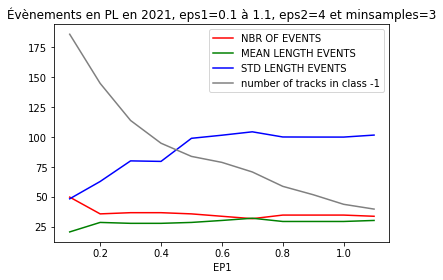

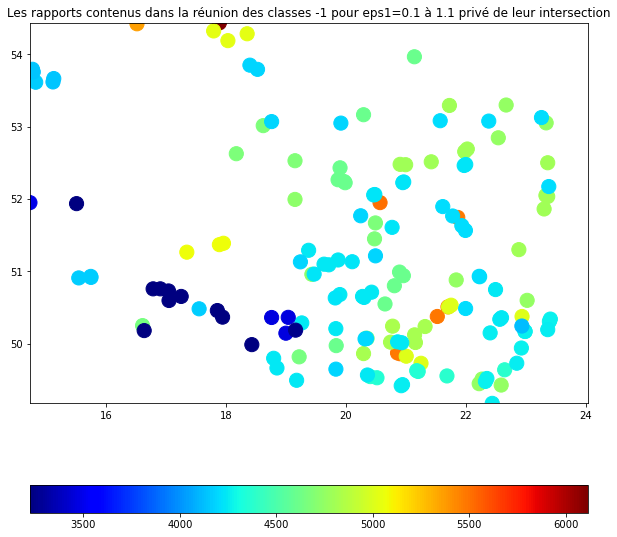

In [47]:
x="PL"
find_eps1(x,2021,4,3,1,12)

    EPS2  NBR_EVENTS  MEAN_LENGTH_EVENTS  STD_LENGTH_EVENTS  LENGTH CLASS -1
0      1          39           10.025000          15.756948               88
1      2          38           10.282051          14.878364               79
2      3          36           10.837838          15.047173               78
3      4          36           10.837838          15.047173               78
4      5          36           10.837838          15.047173               78
5      6          36           10.837838          14.915528               77
6      7          36           10.837838          14.915528               77
7      8          36           10.837838          14.915528               77
8      9          36           10.837838          14.915528               77
9     10          36           10.837838          14.915528               77
10    11          36           10.837838          14.915528               77
11    12          36           10.837838          14.915528               77

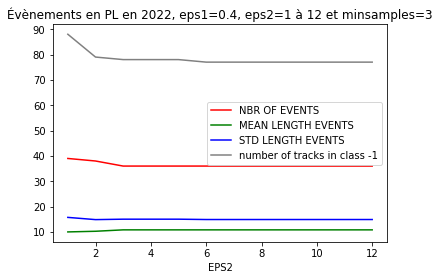

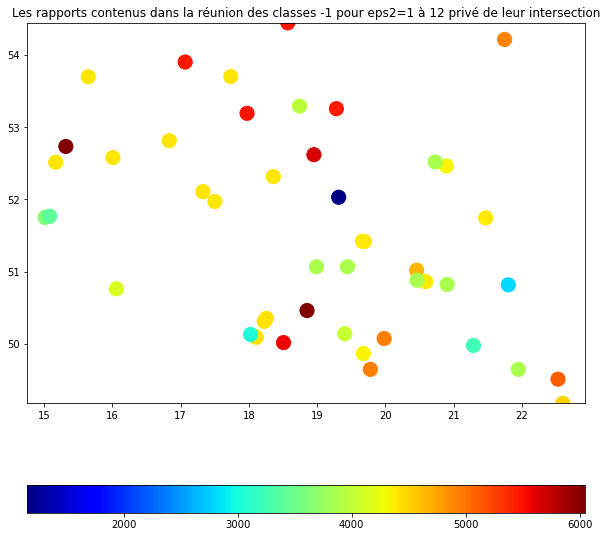

In [48]:
x="PL"
find_eps2(x,2022,0.4,3,1,13)

   MINPT  NBR_EVENTS  MEAN_LENGTH_EVENTS  STD_LENGTH_EVENTS  LENGTH CLASS -1
0      1          99            4.010000           7.043150                1
1      2          50            7.862745          10.785211               50
2      3          36           10.837838          15.047173               78
3      4          31           12.531250          17.953316               93
4      5          23           16.708333          26.635183              130
5      6          15           25.062500          40.900642              171
6      7          12           30.846154          51.629846              197


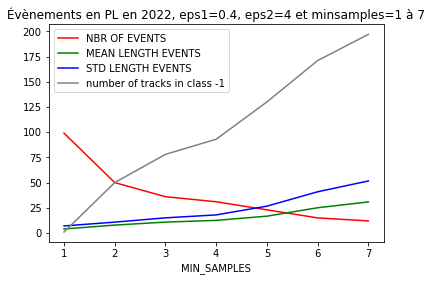

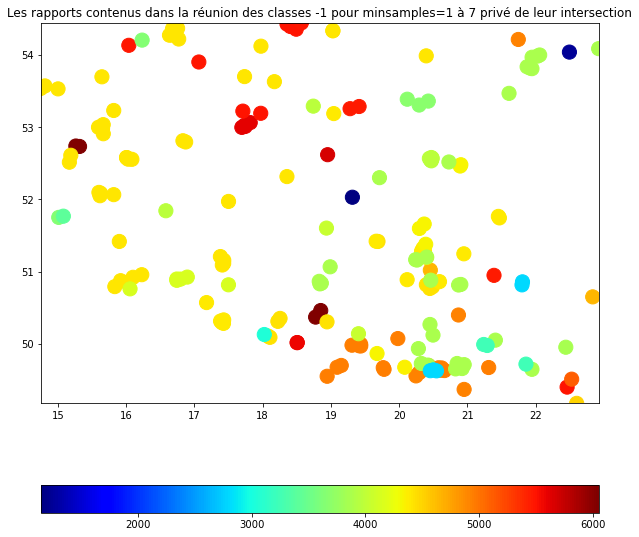

In [49]:
x="PL"
find_minPts(x,2022,0.4,4,1,8)

    EPS1  NBR_EVENTS  MEAN_LENGTH_EVENTS  STD_LENGTH_EVENTS  LENGTH CLASS -1
0    0.1         136           14.452555          35.903255              376
1    0.2         104           18.857143          34.671932              249
2    0.3          88           22.247191          37.189710              189
3    0.4          84           23.294118          42.007602              156
4    0.5          83           23.571429          41.799373              124
5    0.6          78           25.063291          42.976542              112
6    0.7          73           26.756757          44.446308              104
7    0.8          72           27.123288          44.780311               93
8    0.9          68           28.695652          45.931312               84
9    1.0          66           29.552239          46.322415               81
10   1.1          62           31.428571          47.724584               77


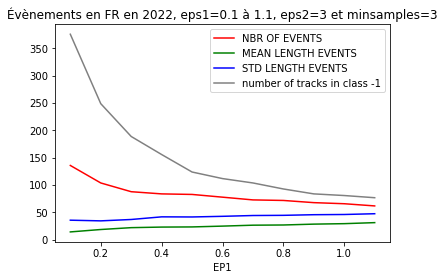

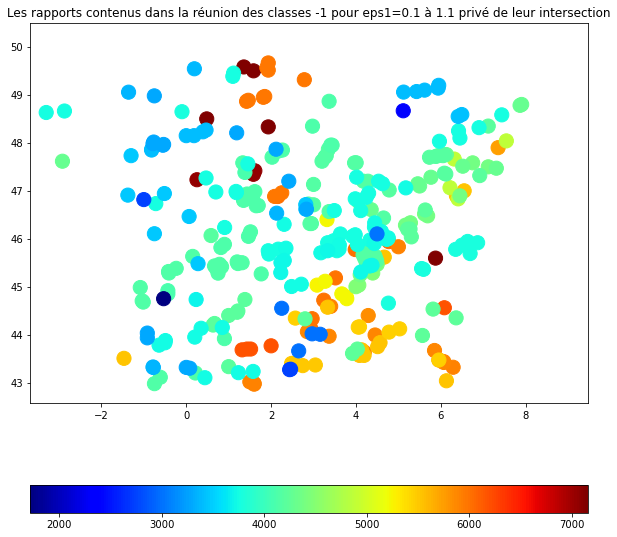

In [50]:
x="FR"
find_eps1(x,2022,3,3,1,12)

    EPS2  NBR_EVENTS  MEAN_LENGTH_EVENTS  STD_LENGTH_EVENTS  LENGTH CLASS -1
0      1          97           20.204082          34.124381              212
1      2          89           22.000000          37.089930              192
2      3          88           22.247191          37.189710              189
3      4          88           22.247191          37.148131              185
4      5          88           22.247191          37.148131              185
5      6          88           22.247191          37.148131              185
6      7          89           22.000000          36.847088              182
7      8          89           22.000000          36.793075              181
8      9          89           22.000000          36.793075              181
9     10          89           22.000000          36.793075              181
10    11          88           22.247191          36.983191              181
11    12          88           22.247191          36.983191              181

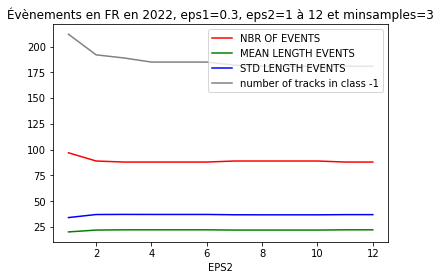

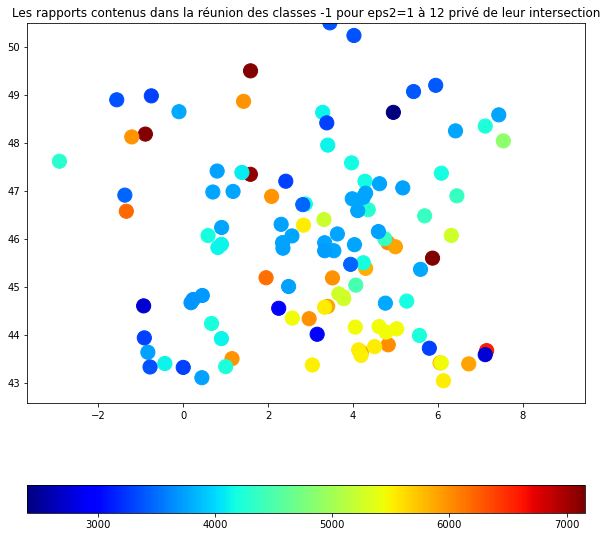

In [51]:
x="FR"
find_eps2(x,2022,0.3,3,1,13)

   MINPT  NBR_EVENTS  MEAN_LENGTH_EVENTS  STD_LENGTH_EVENTS  LENGTH CLASS -1
0      1         228            8.646288          22.282511                2
1      2         136           14.452555          28.473923               93
2      3          88           22.247191          37.189710              189
3      4          74           26.400000          42.205738              233
4      5          61           31.935484          49.545432              289
5      6          56           34.736842          54.403757              325
6      7          50           38.823529          61.538510              373


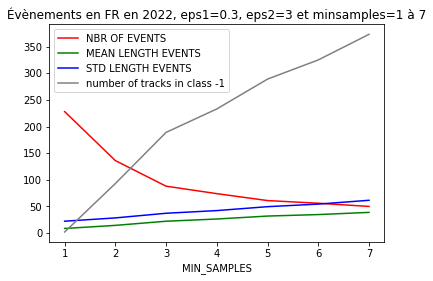

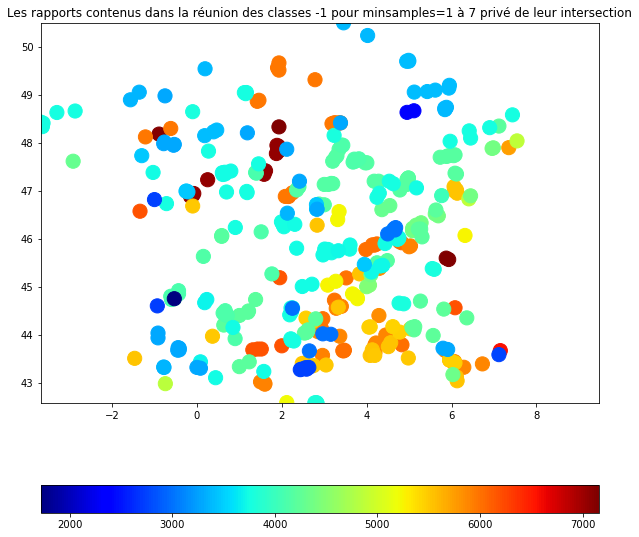

In [52]:
x="FR"
find_minPts(x,2022,0.3,3,1,8)

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
8               7         7          7        7
9              41        41         41       41
20             10        10         10       10
24             24        24         24       24
25             10        10         10       10
28             29        29         29       29
33             22        22         22       22
35              7         7          7        7
42             10        10         10       10


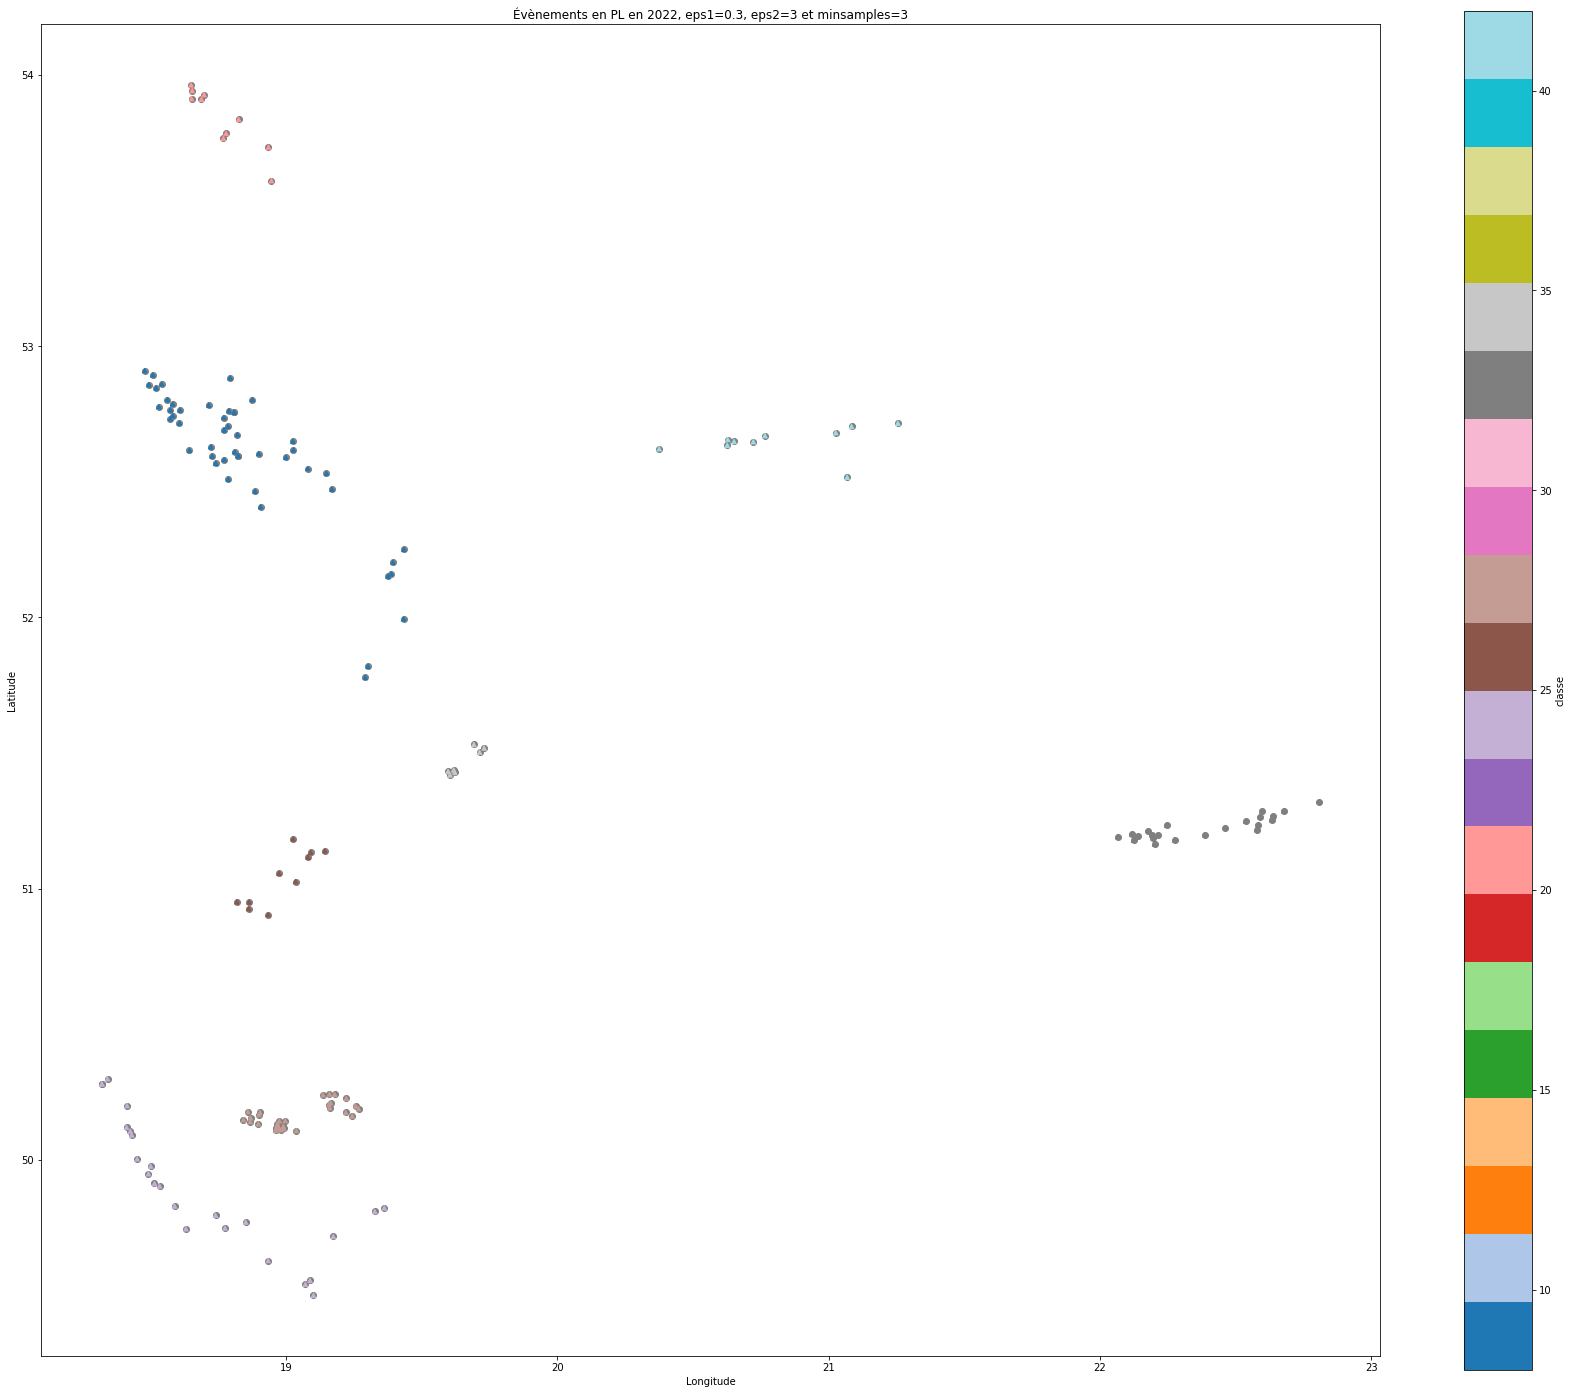

In [53]:
x="PL"

clusterise_country_year(x, 2022, 0.3, 3, 3)

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
7               7         7          7        7
8              41        41         41       41
24             19        19         19       19
25             10        10         10       10
29             29        29         29       29
34             22        22         22       22
44             10        10         10       10


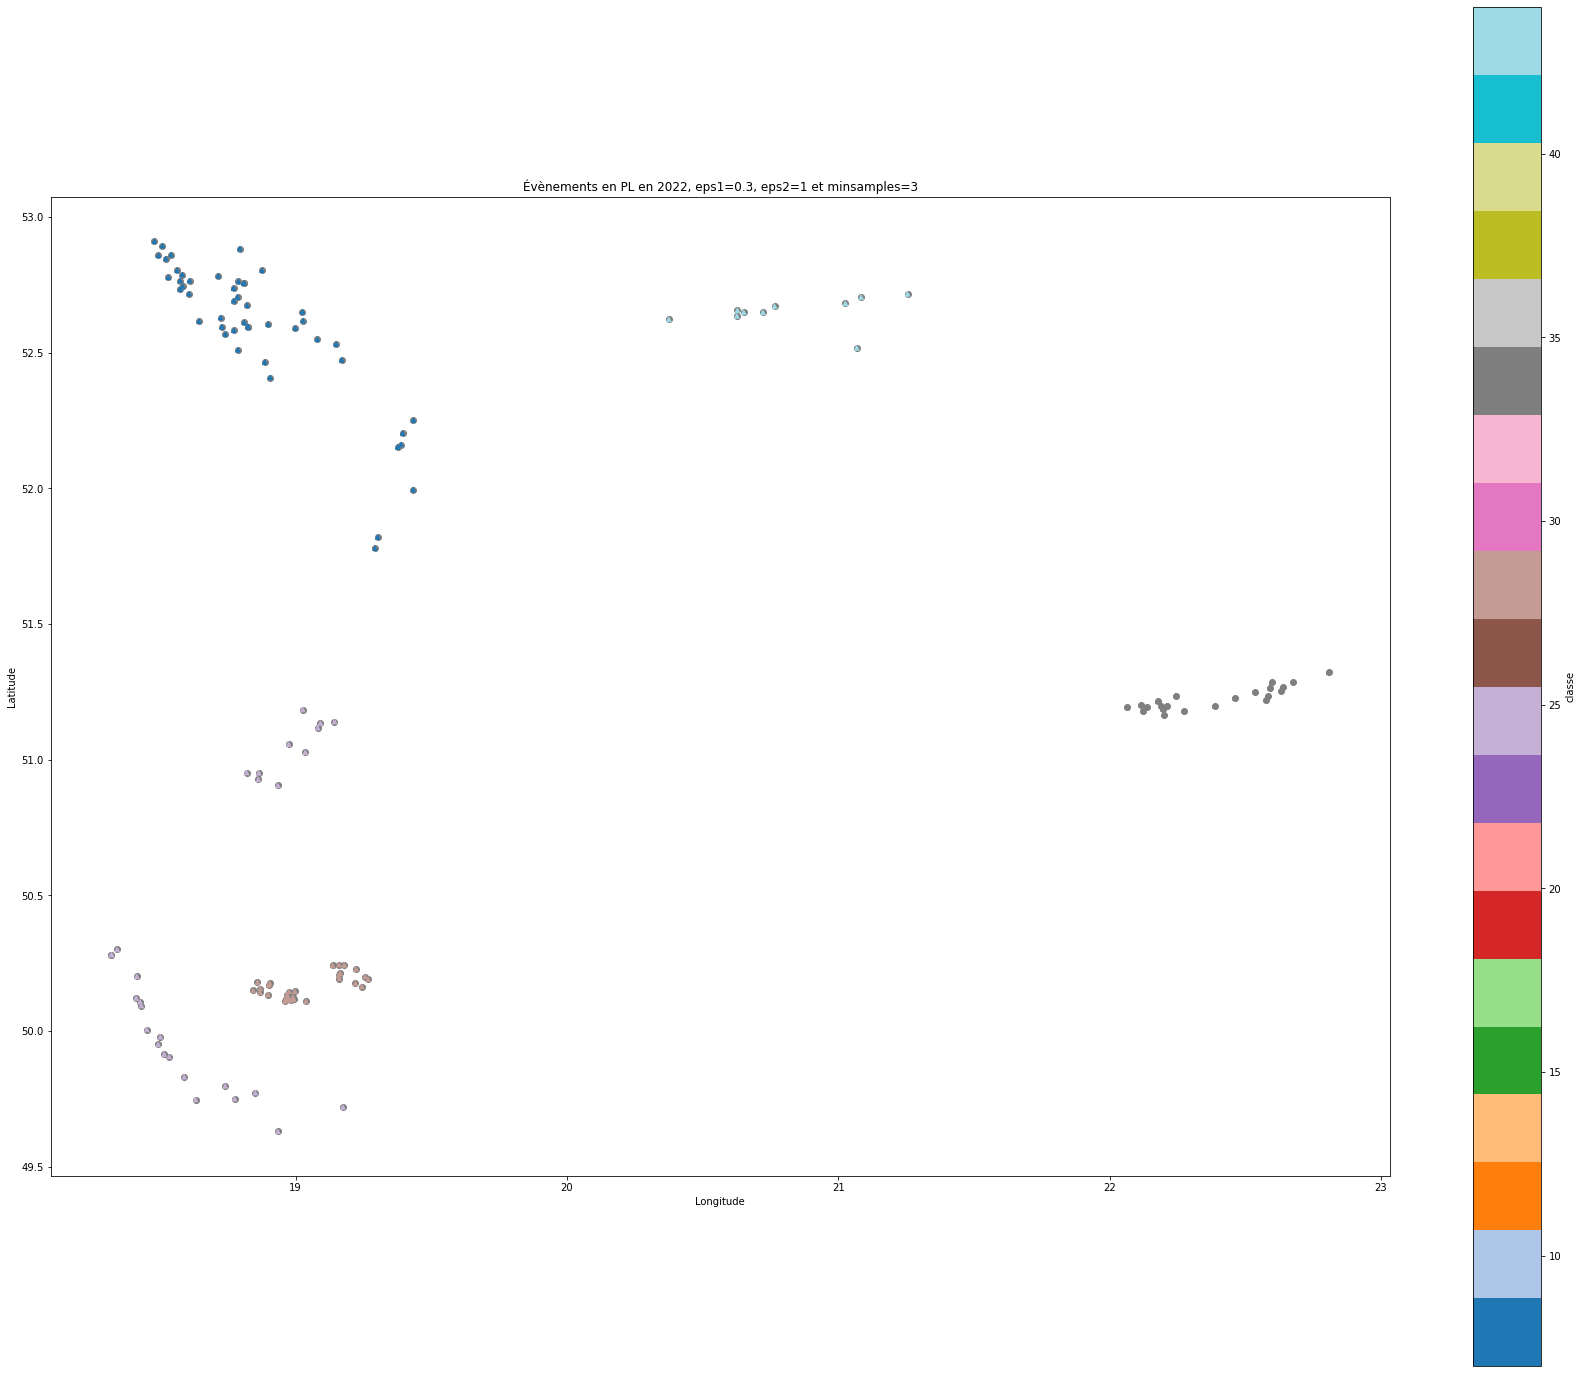

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
8               7         7          7        7
9              41        41         41       41
20             10        10         10       10
24             24        24         24       24
25             10        10         10       10
28             29        29         29       29
33             22        22         22       22
43             10        10         10       10


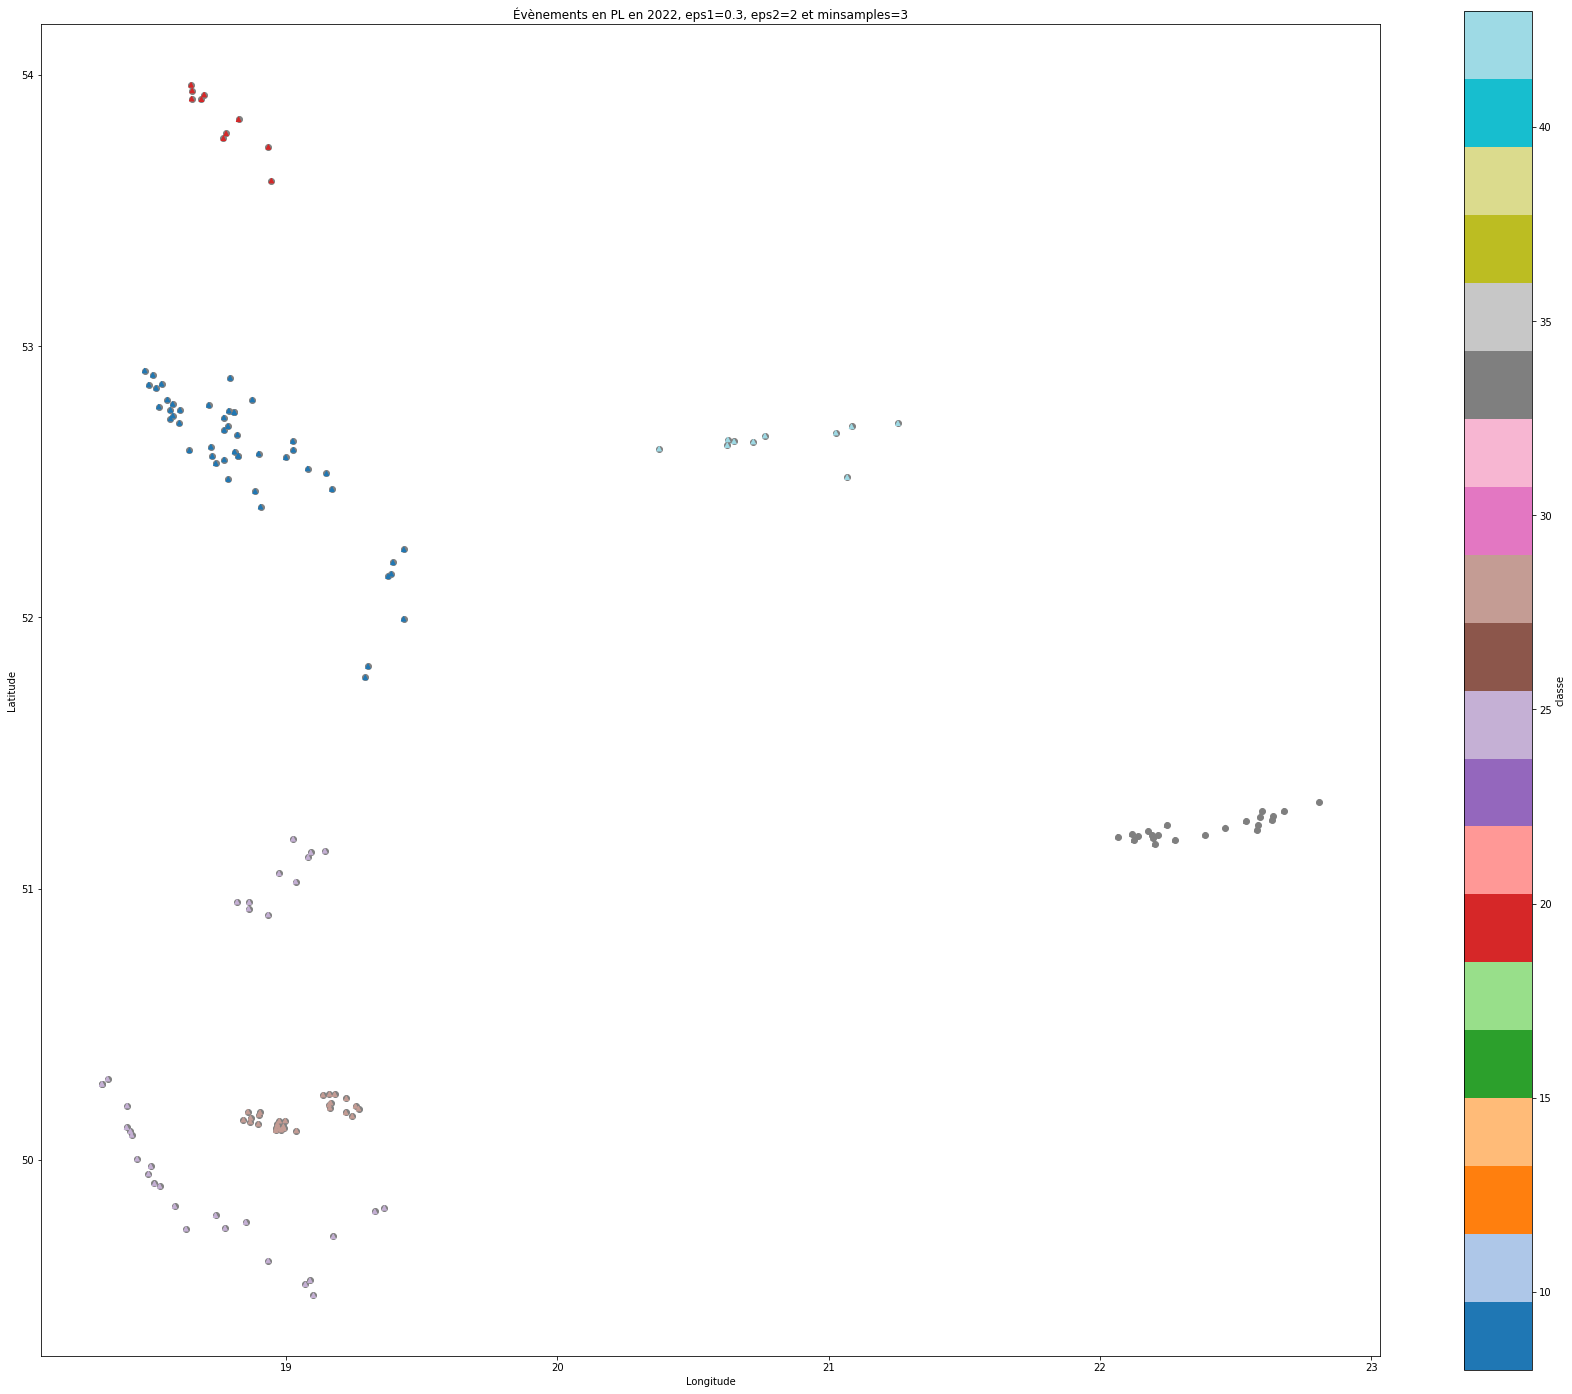

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
8               7         7          7        7
9              41        41         41       41
20             10        10         10       10
24             24        24         24       24
25             10        10         10       10
28             29        29         29       29
33             22        22         22       22
35              7         7          7        7
42             10        10         10       10


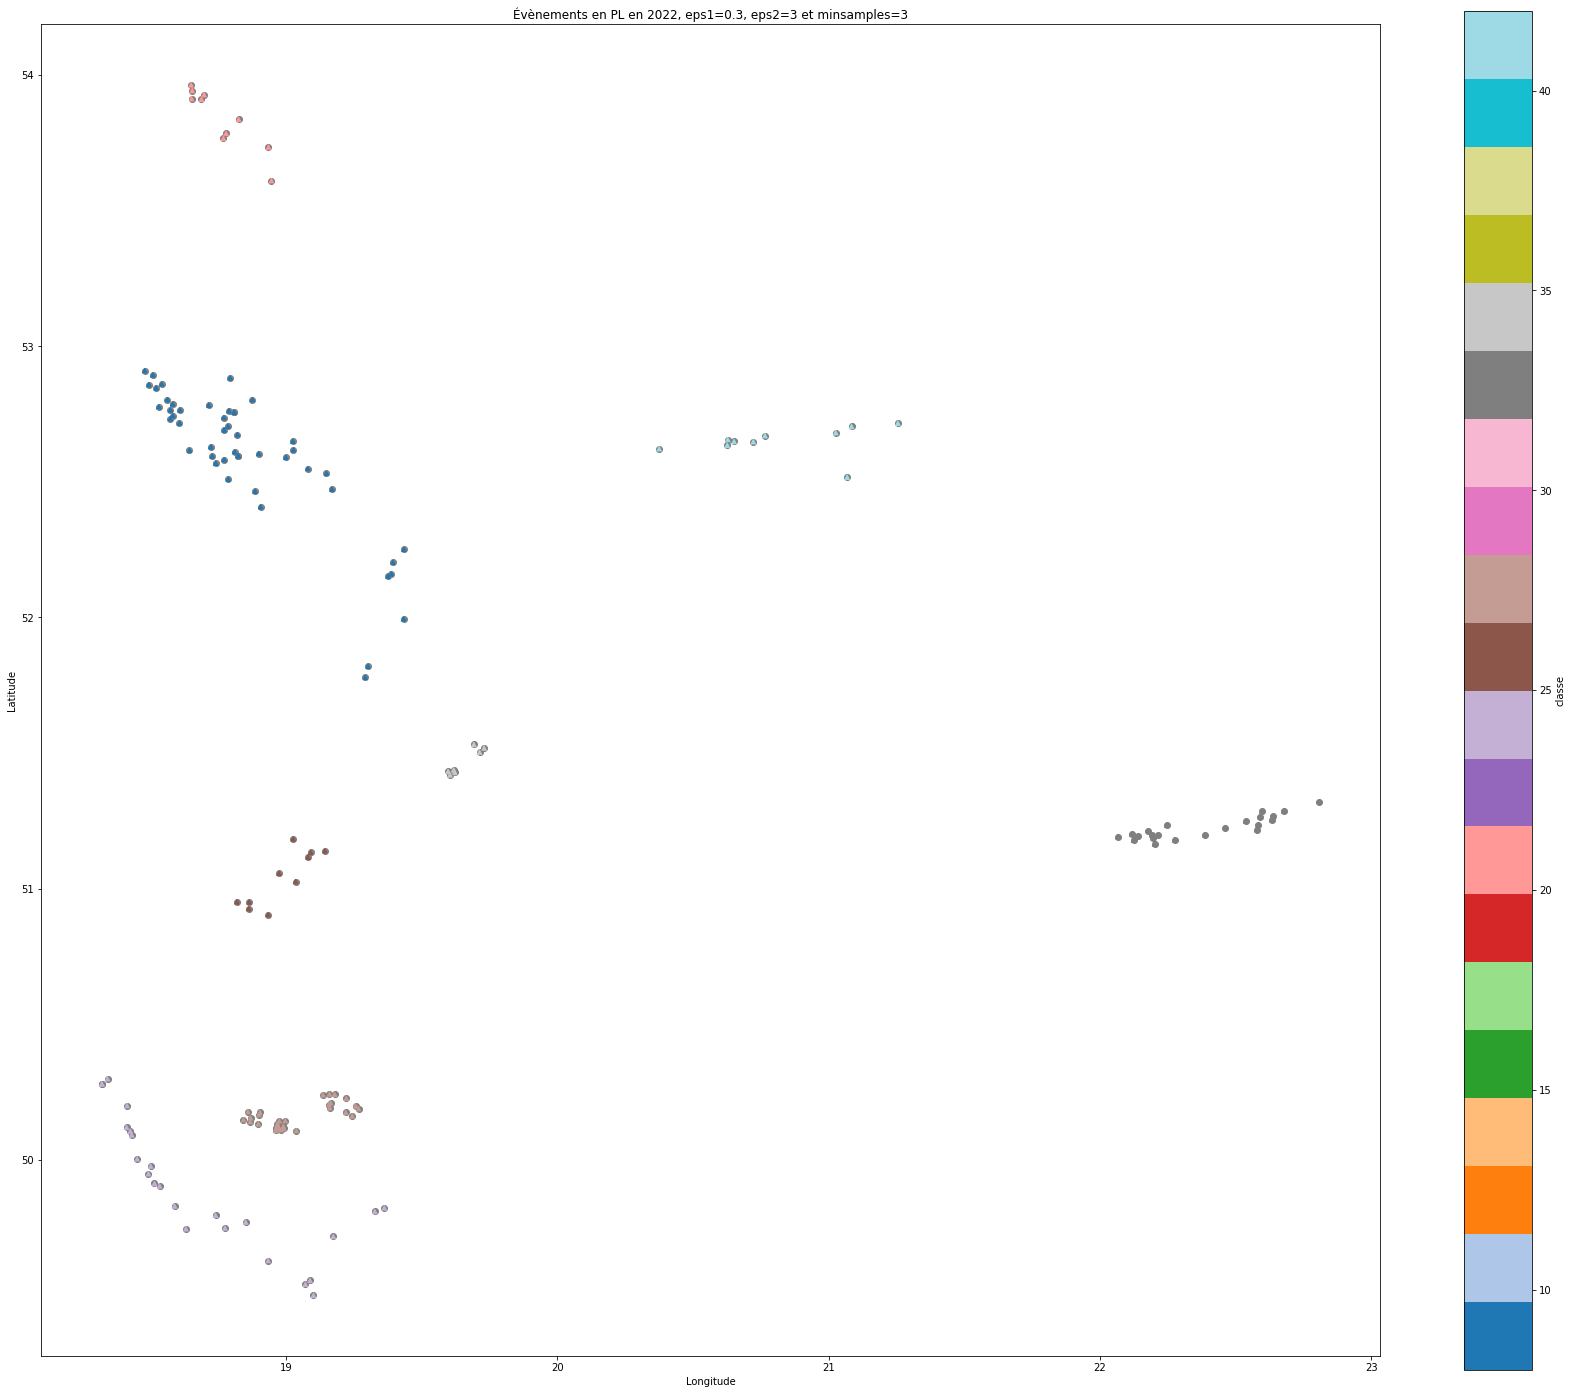

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
8               7         7          7        7
9              41        41         41       41
20             10        10         10       10
24             24        24         24       24
25             10        10         10       10
28             29        29         29       29
33             22        22         22       22
35              7         7          7        7
42             10        10         10       10


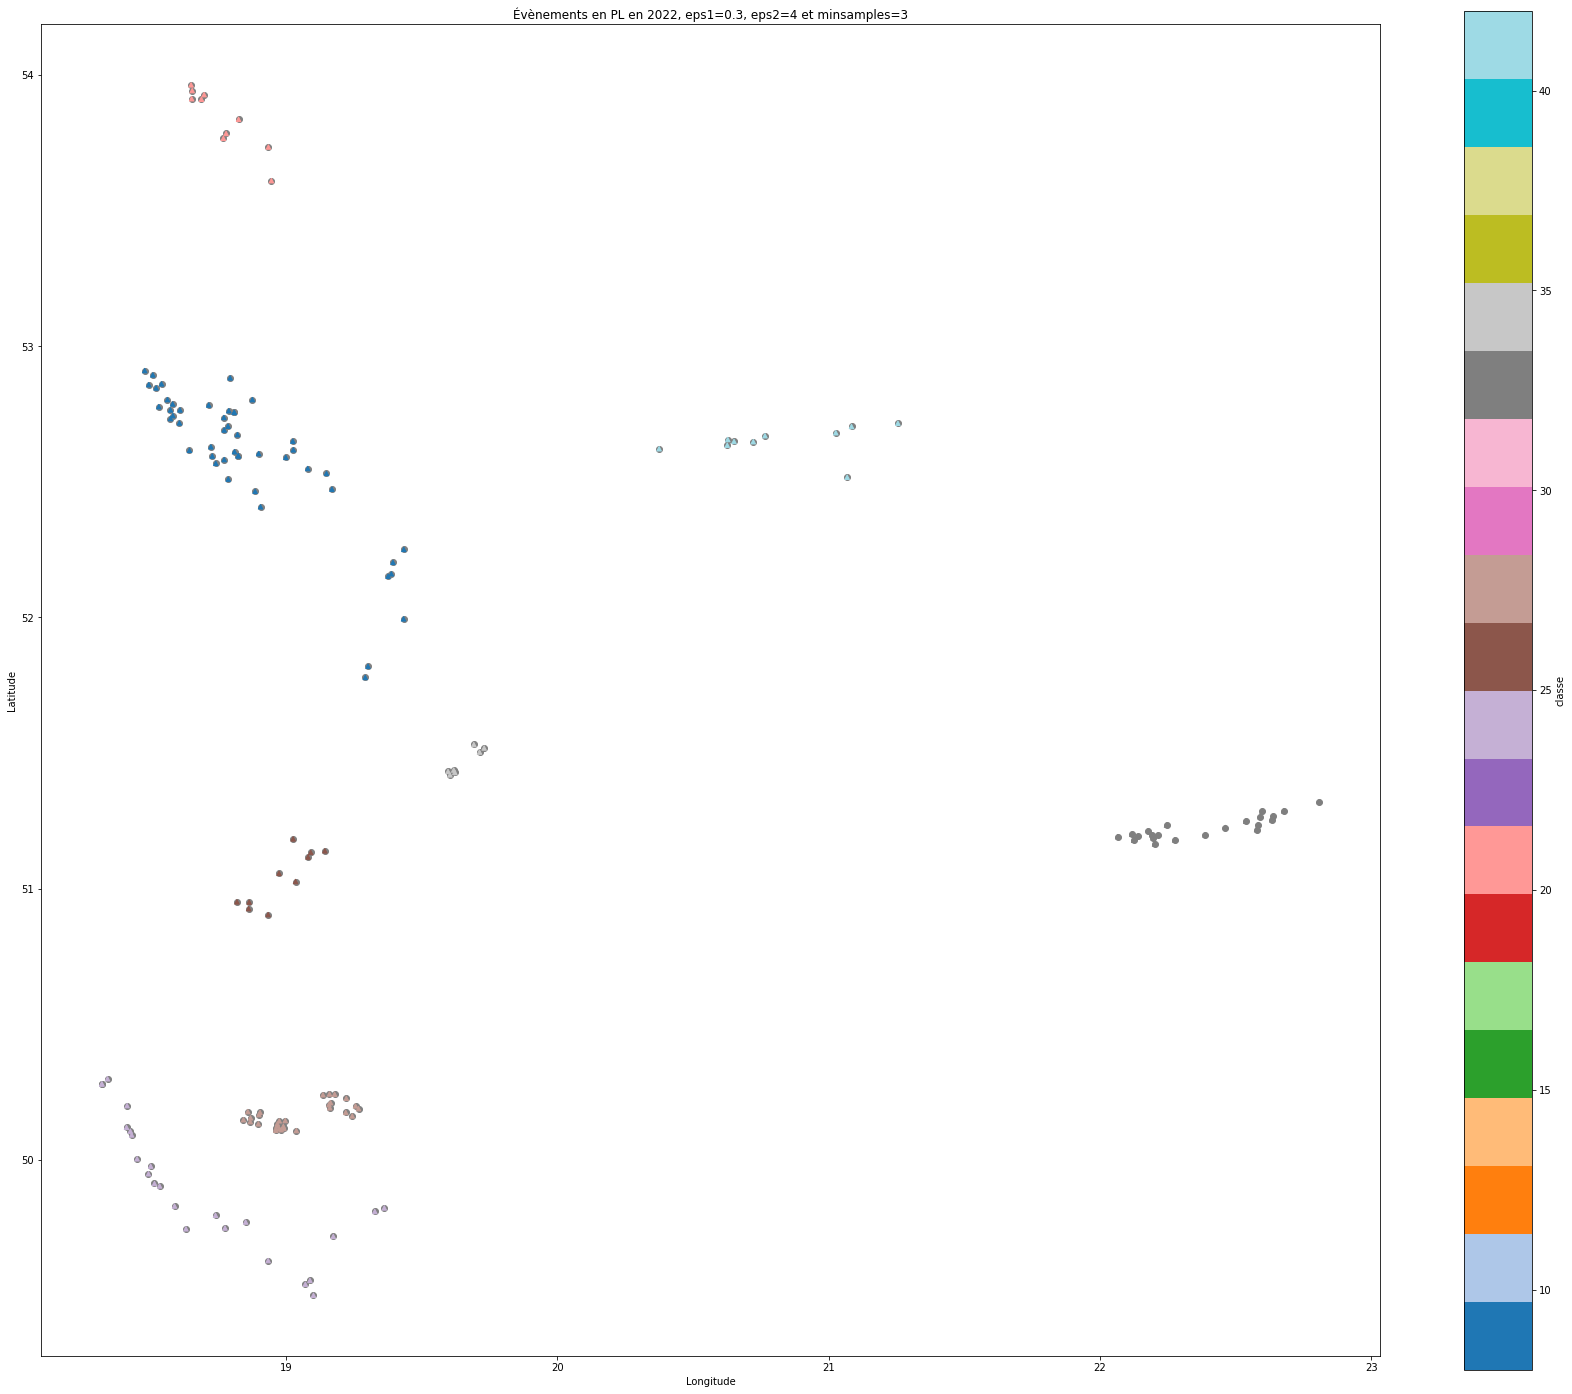

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
8               7         7          7        7
9              41        41         41       41
20             10        10         10       10
24             24        24         24       24
25             10        10         10       10
28             29        29         29       29
33             22        22         22       22
35              7         7          7        7
42             10        10         10       10


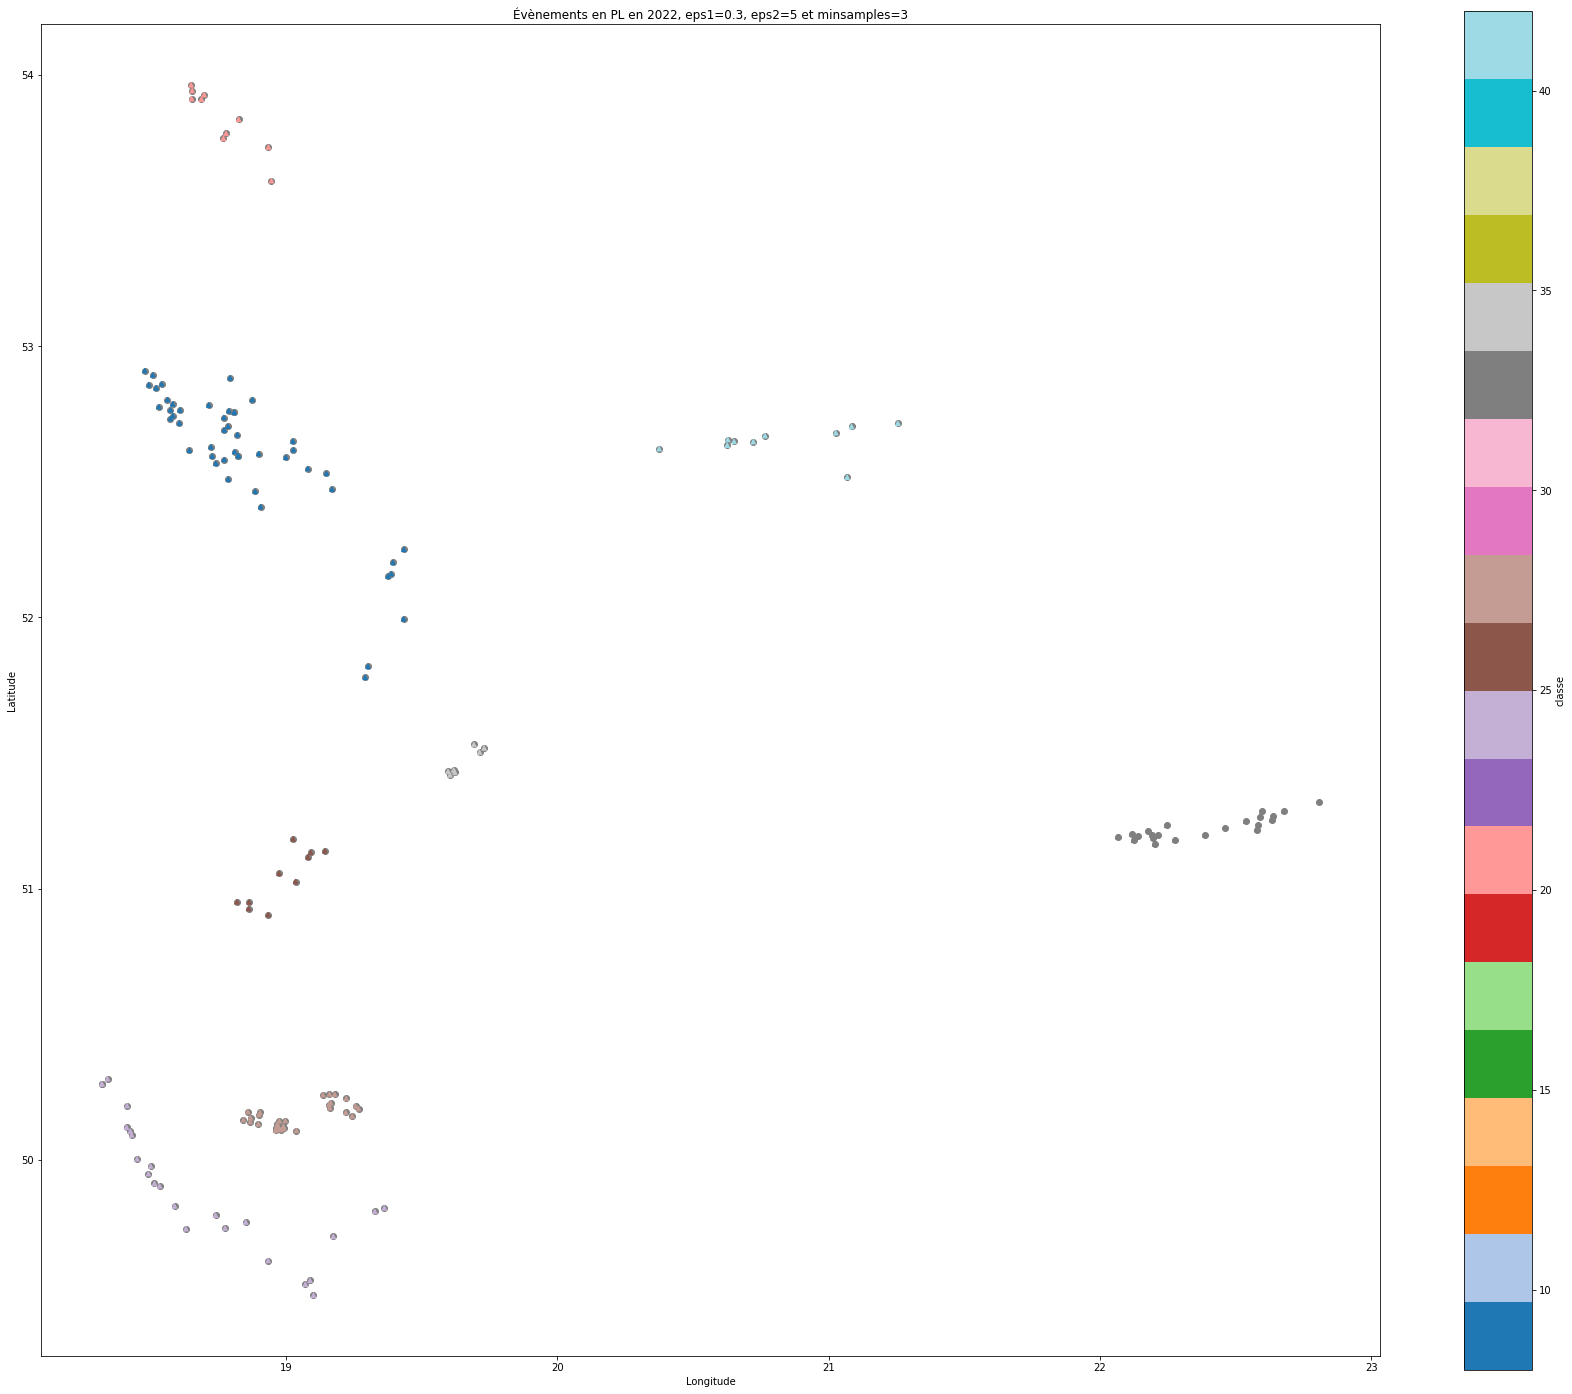

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
8               7         7          7        7
9              41        41         41       41
20             10        10         10       10
24             24        24         24       24
25             10        10         10       10
28             29        29         29       29
33             22        22         22       22
35              7         7          7        7
42             10        10         10       10


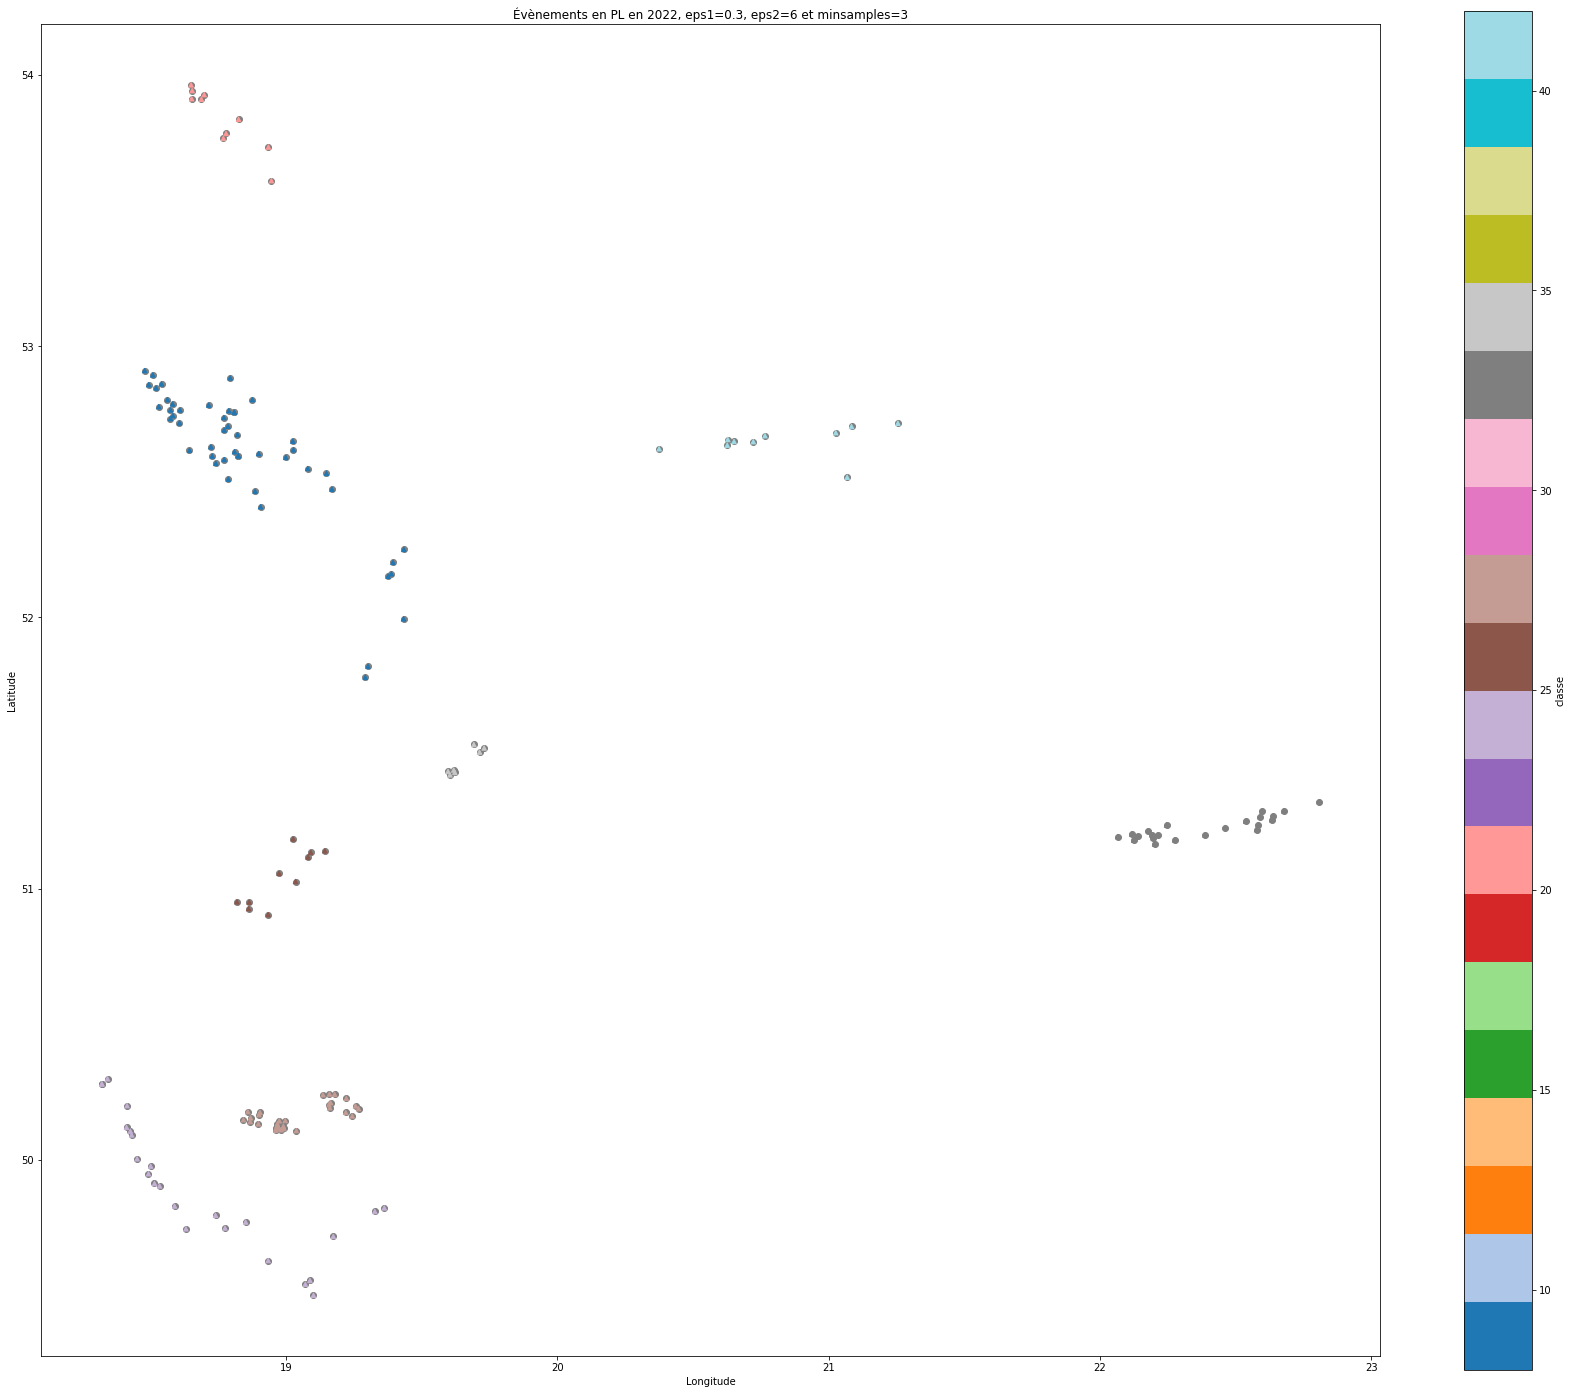

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
8               7         7          7        7
9              41        41         41       41
20             10        10         10       10
24             24        24         24       24
25             10        10         10       10
28             29        29         29       29
33             22        22         22       22
35              7         7          7        7
42             10        10         10       10


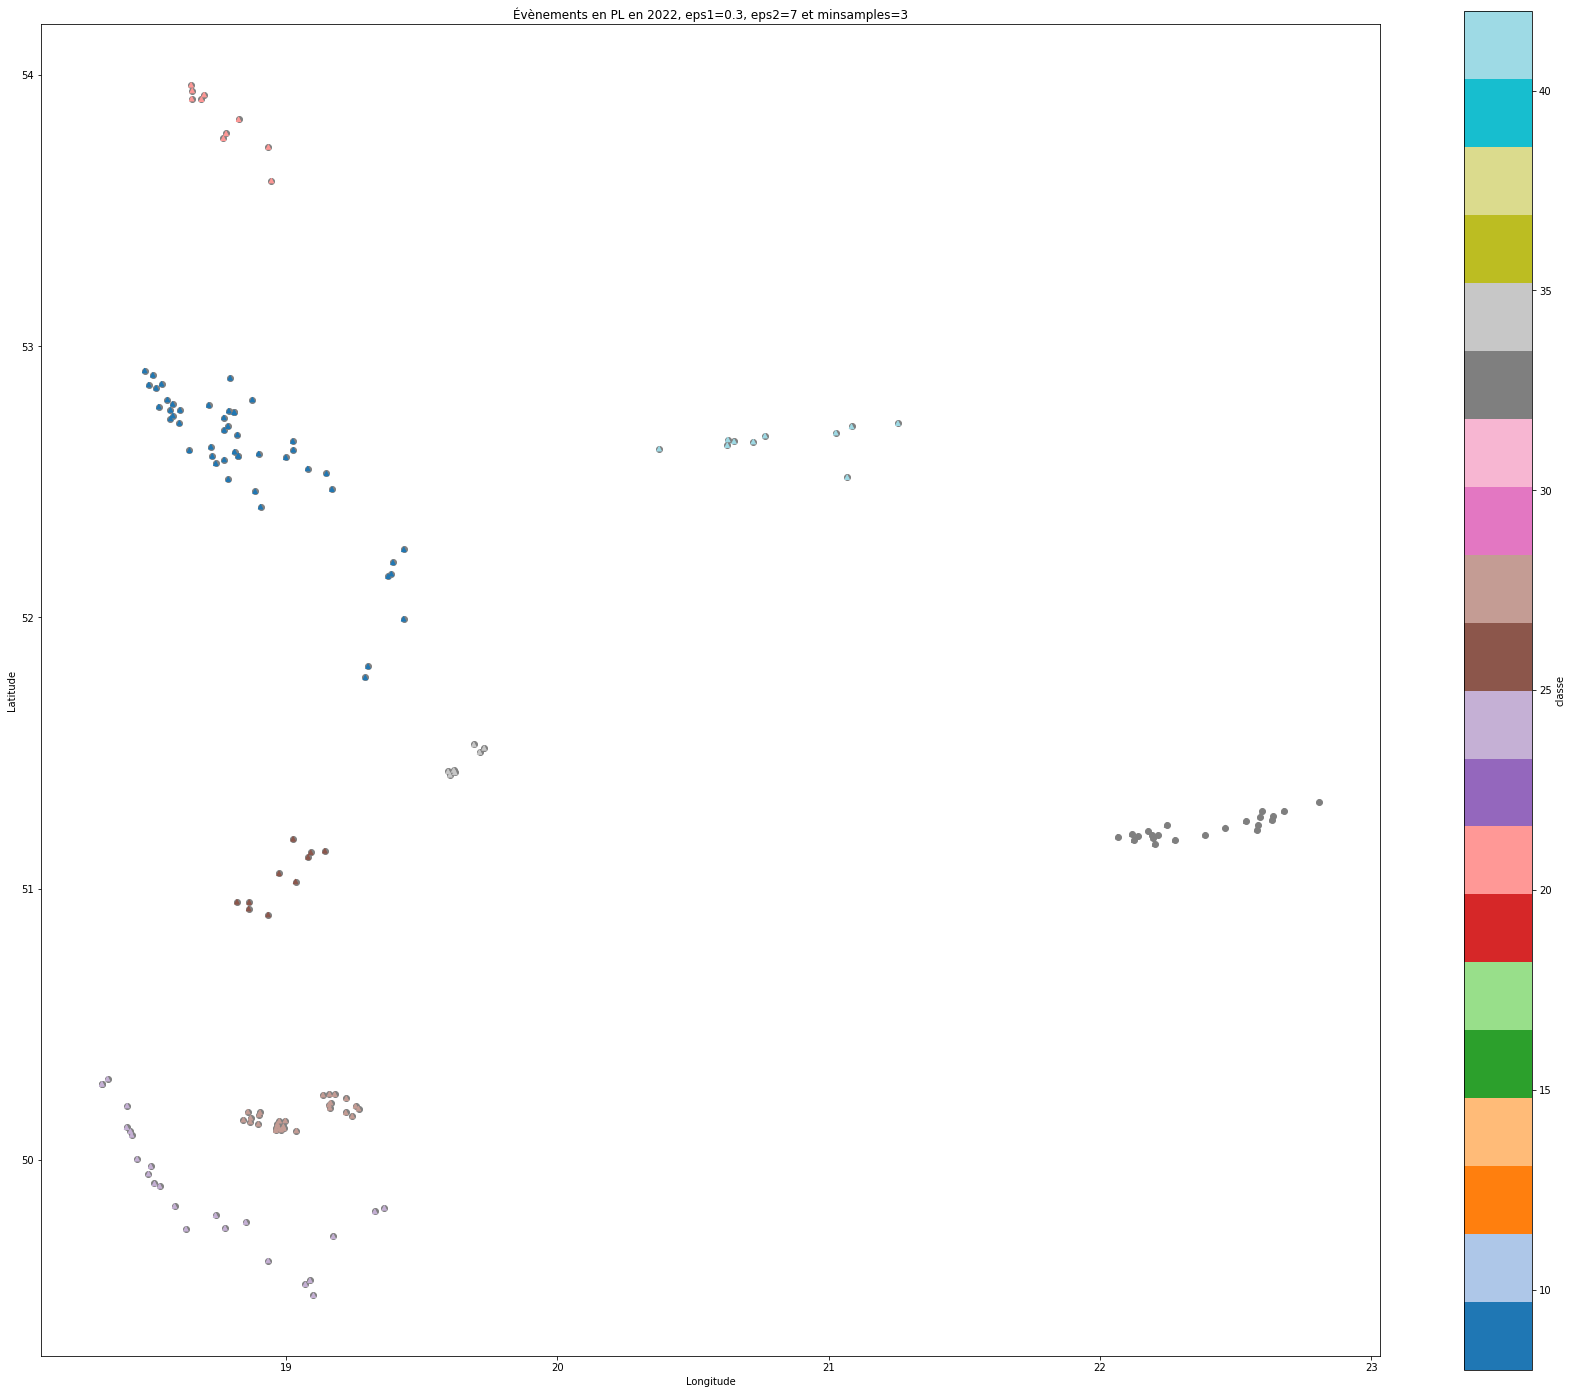

In [54]:
x="PL"

for i in range(1 ,8 ):
    
    clusterise_country_year(x, 2022, 0.3, i, 3)

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
4               6         6          6        6
6               6         6          6        6
7              19        19         19       19
9              13        13         13       13
24             11        11         11       11
28              6         6          6        6
29             18        18         18       18
30             11        11         11       11
34             10        10         10       10
36             11        11         11       11


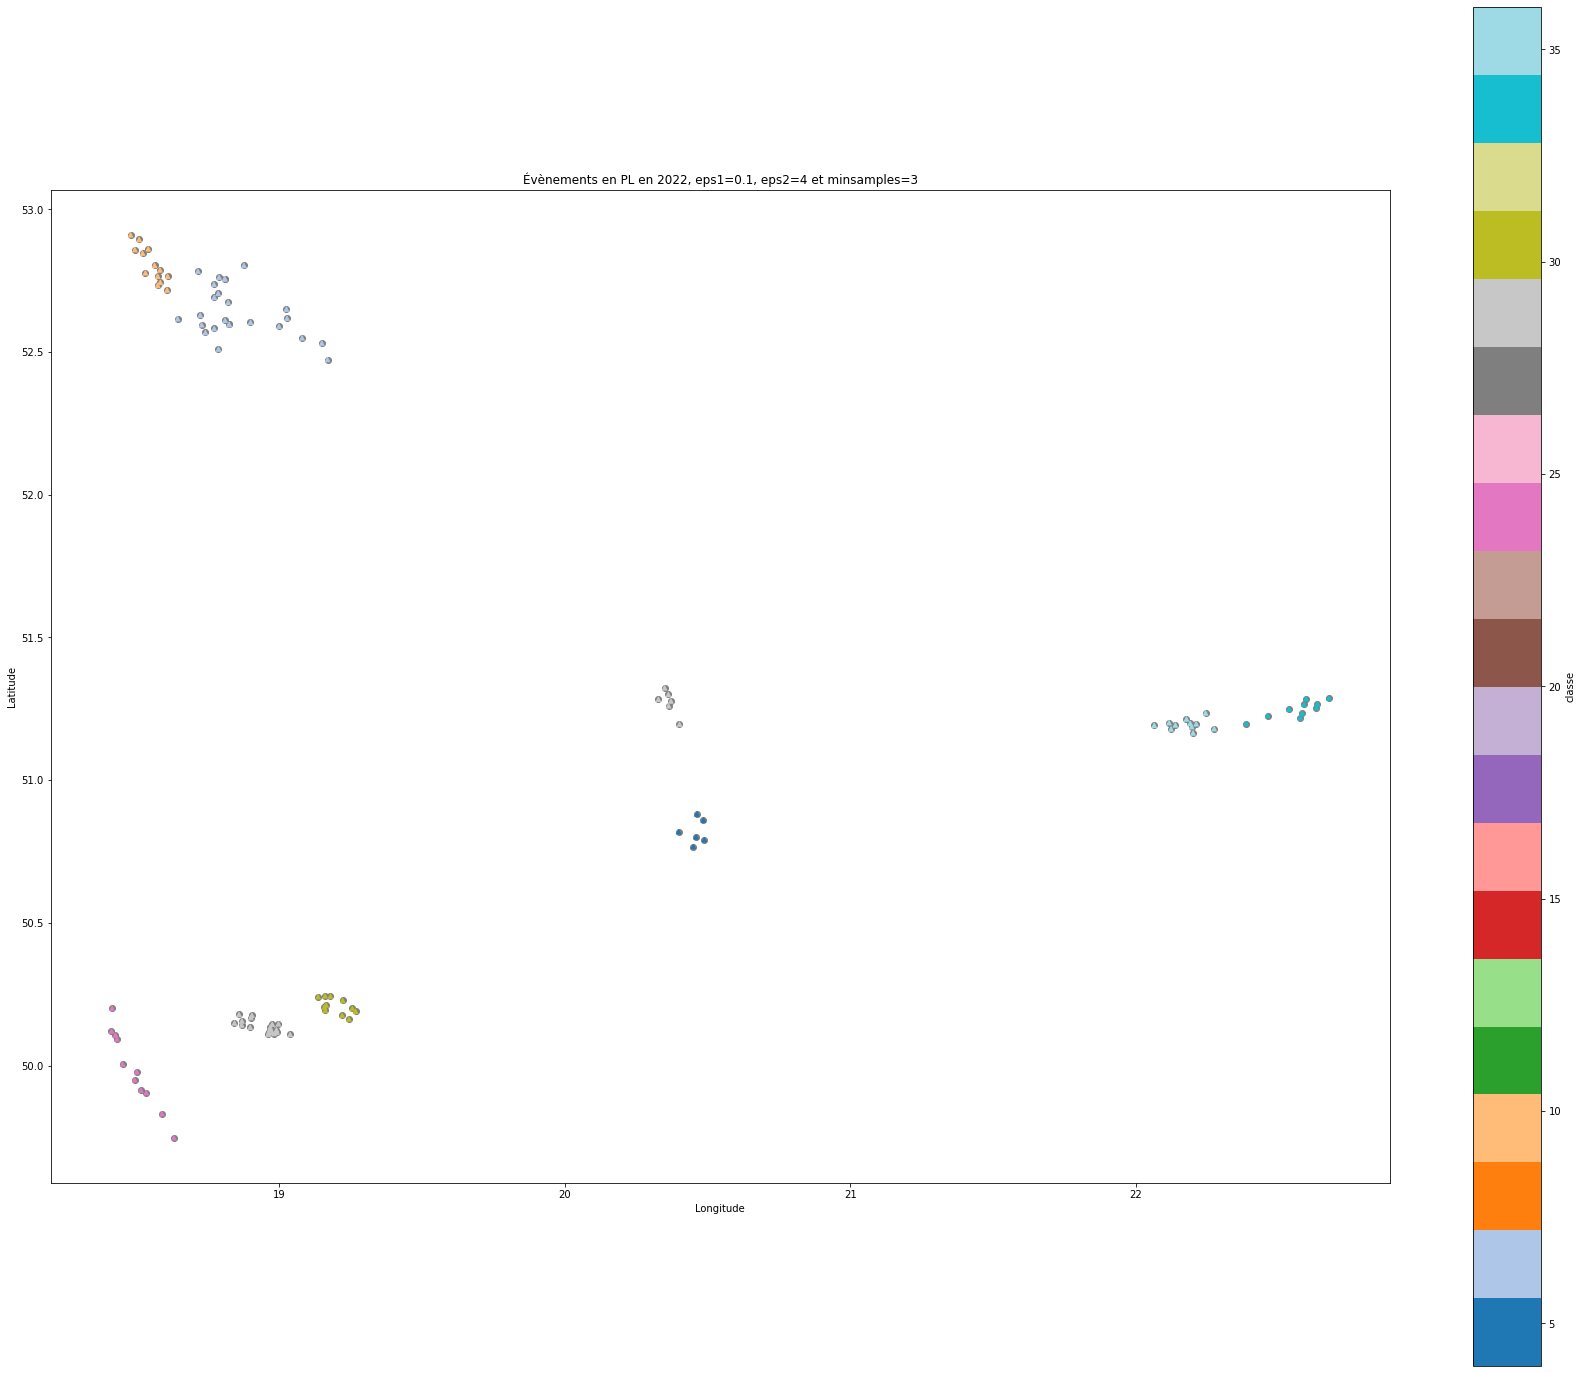

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
8              41        41         41       41
19             10        10         10       10
23             24        24         24       24
24             10        10         10       10
27             29        29         29       29
31             22        22         22       22
33              7         7          7        7


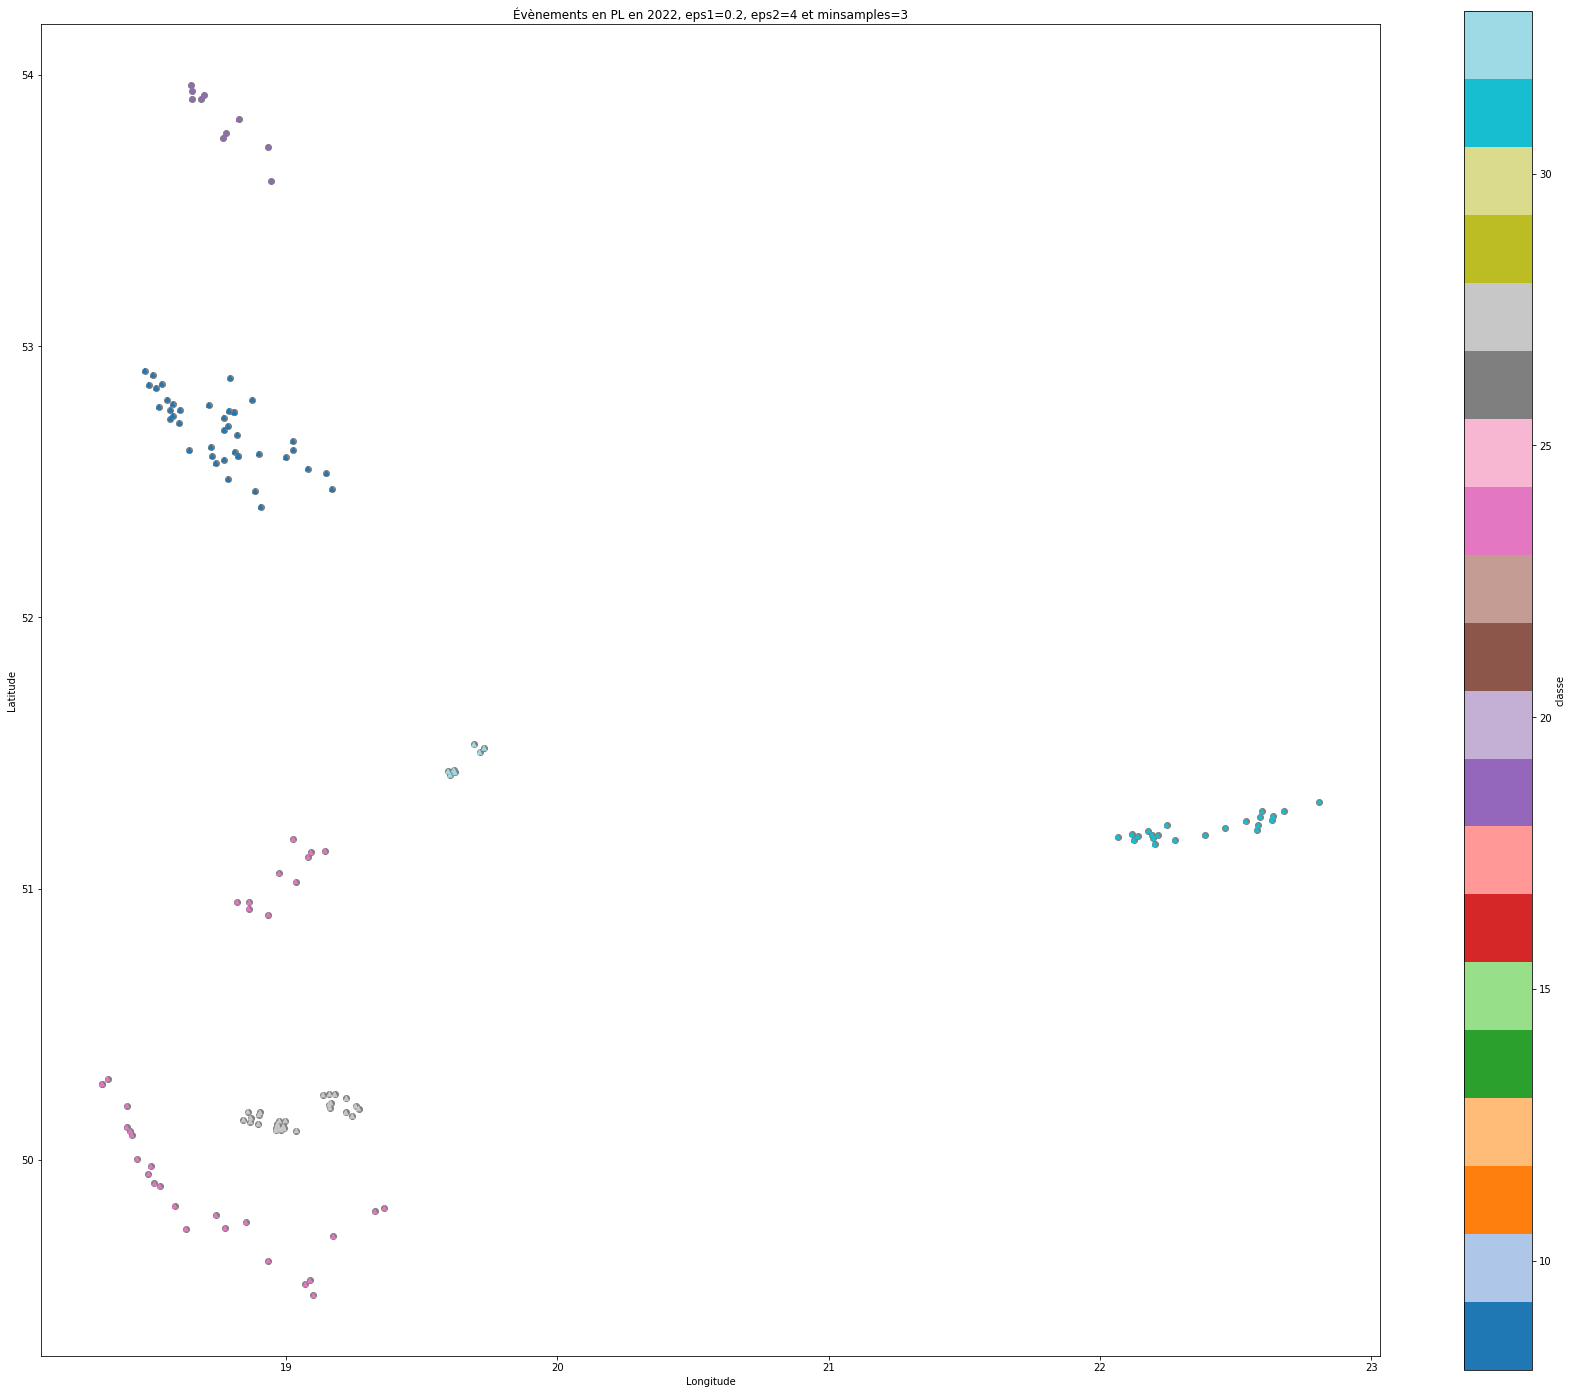

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
8               7         7          7        7
9              41        41         41       41
20             10        10         10       10
24             24        24         24       24
25             10        10         10       10
28             29        29         29       29
33             22        22         22       22
35              7         7          7        7
42             10        10         10       10


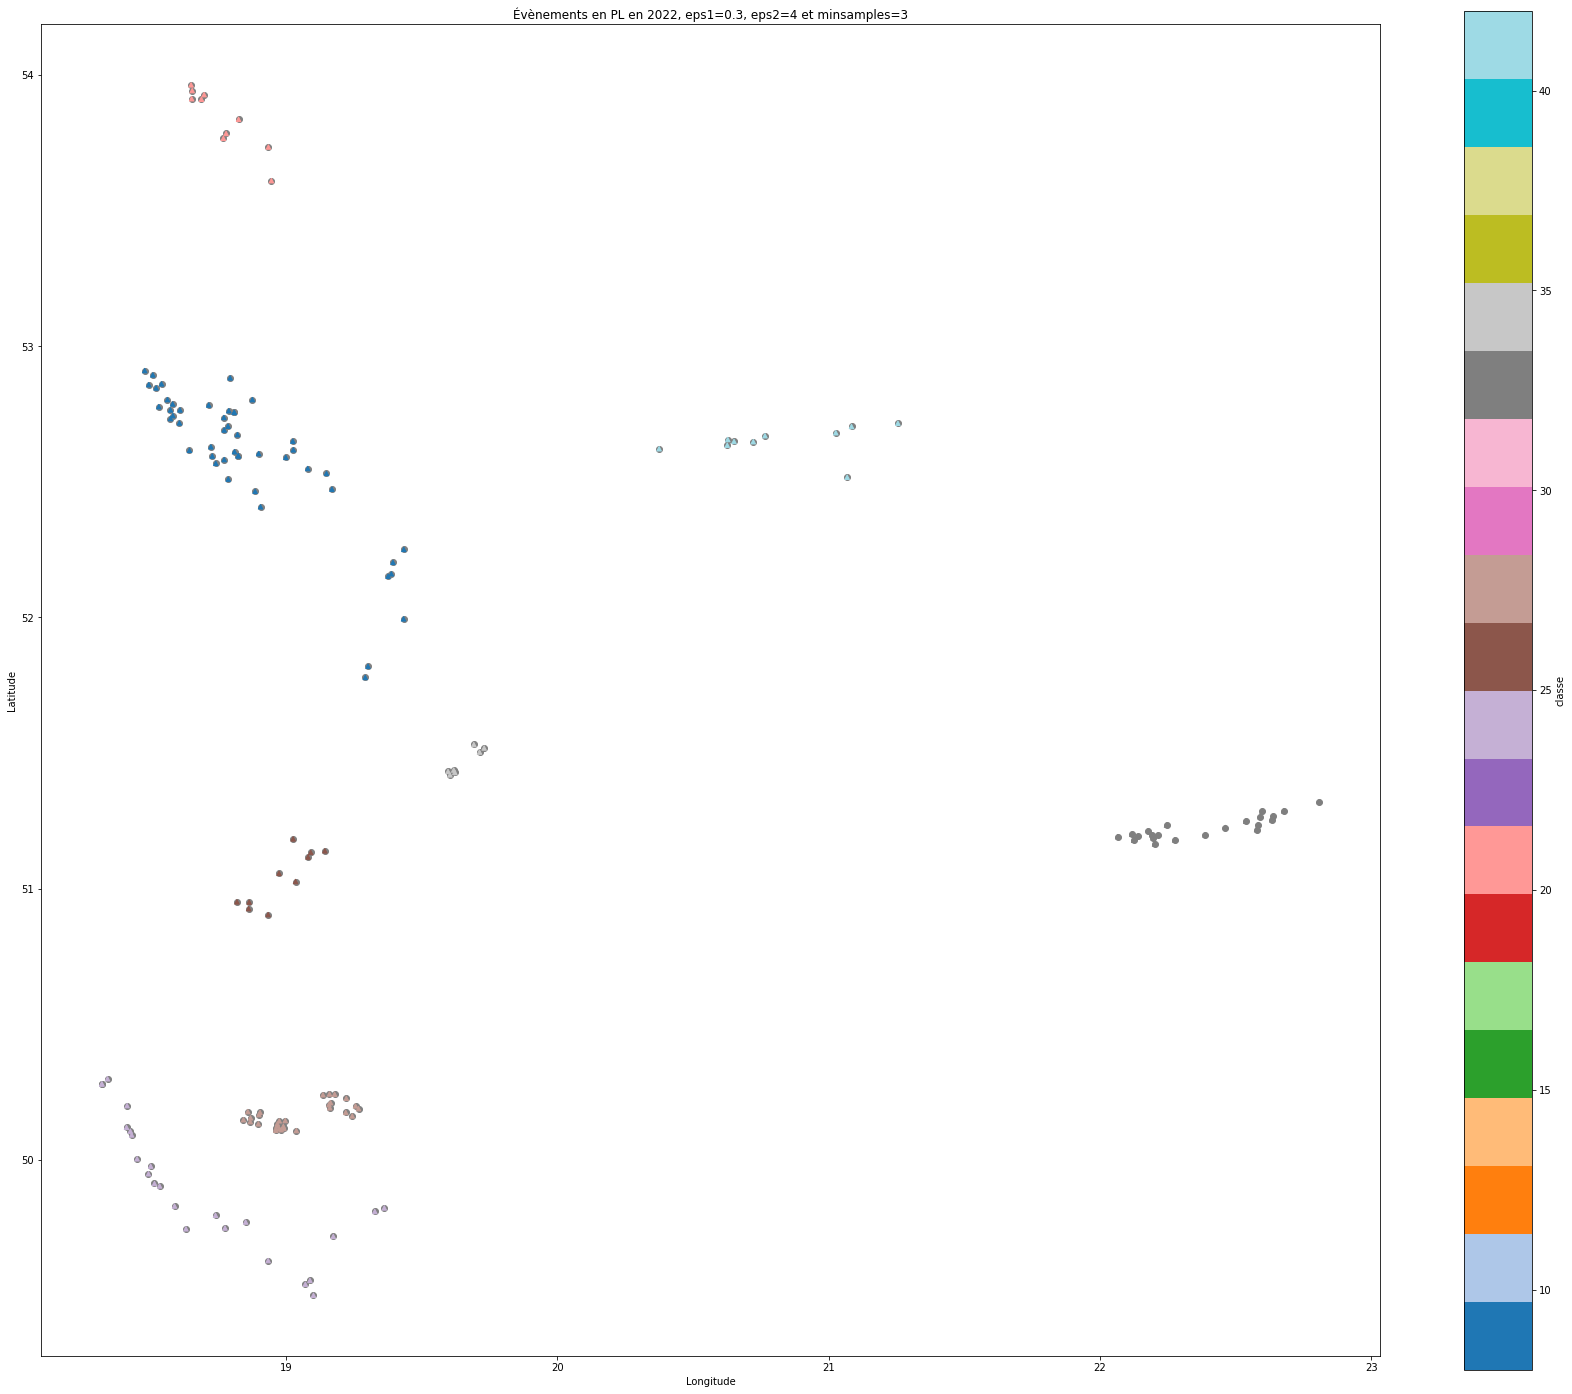

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
7              54        54         54       54
16             14        14         14       14
18             19        19         19       19
19             24        24         24       24
21             29        29         29       29
25             22        22         22       22


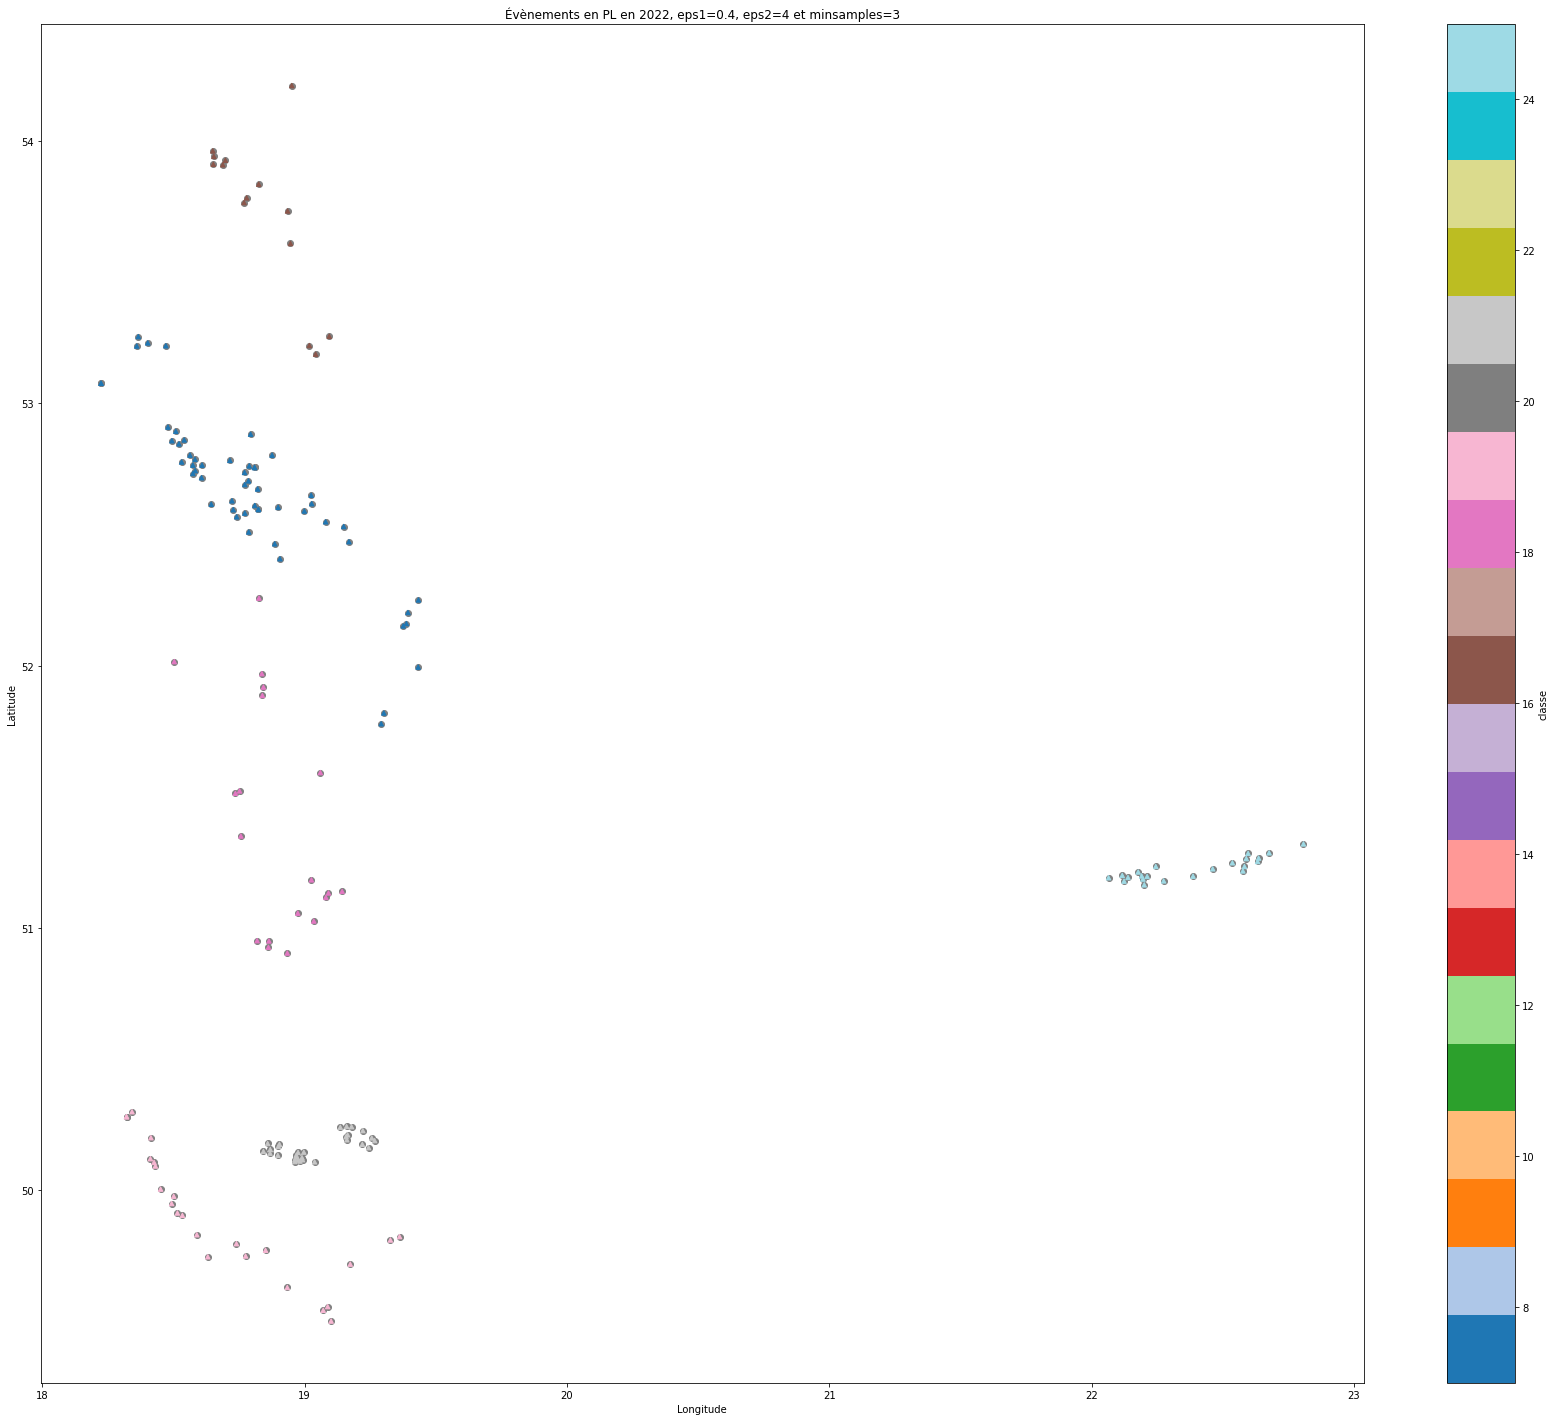

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
7              58        58         58       58
15             14        14         14       14
17             19        19         19       19
18             24        24         24       24
20             40        40         40       40
23             22        22         22       22


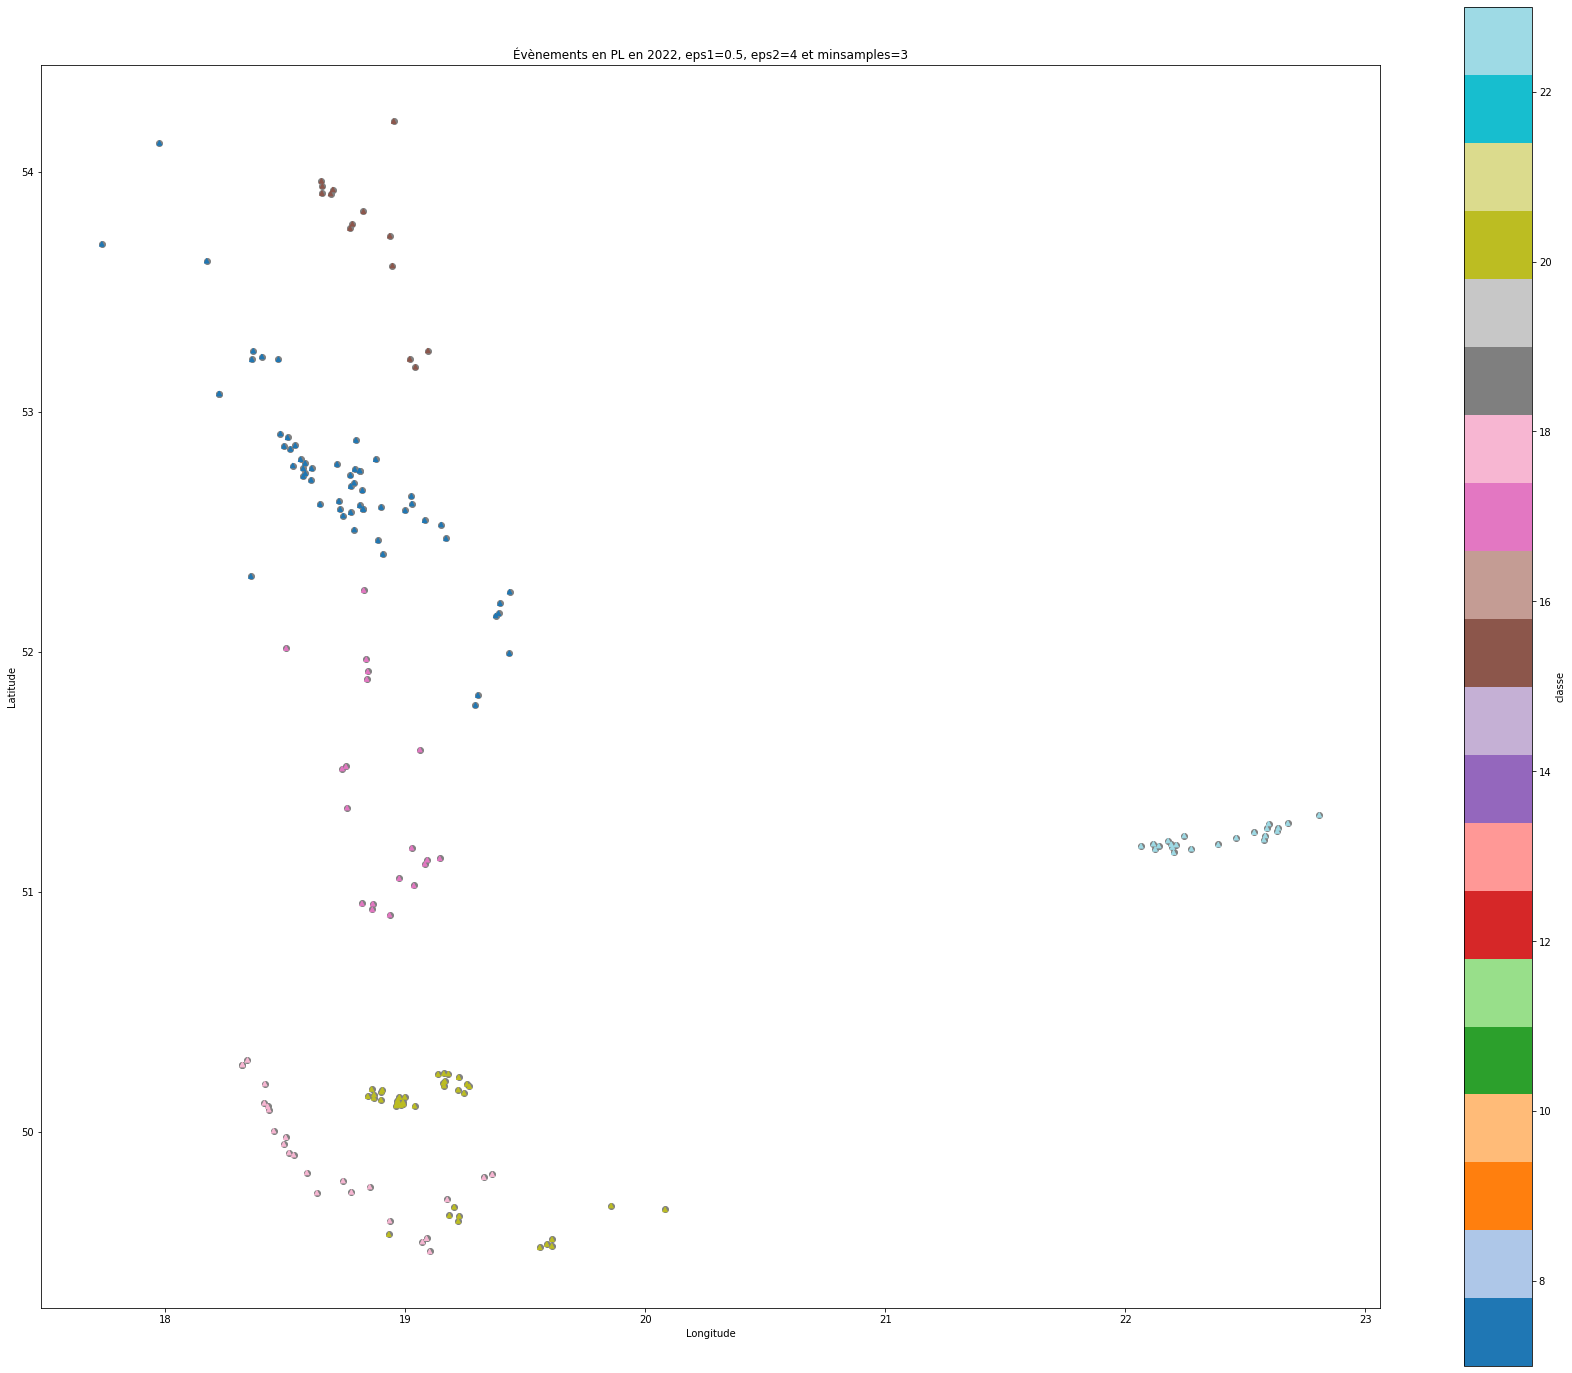

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             56        56         56       56
 7             59        59         59       59
 9             16        16         16       16
 16            20        20         20       20
 17            24        24         24       24
 19            40        40         40       40
 22            22        22         22       22


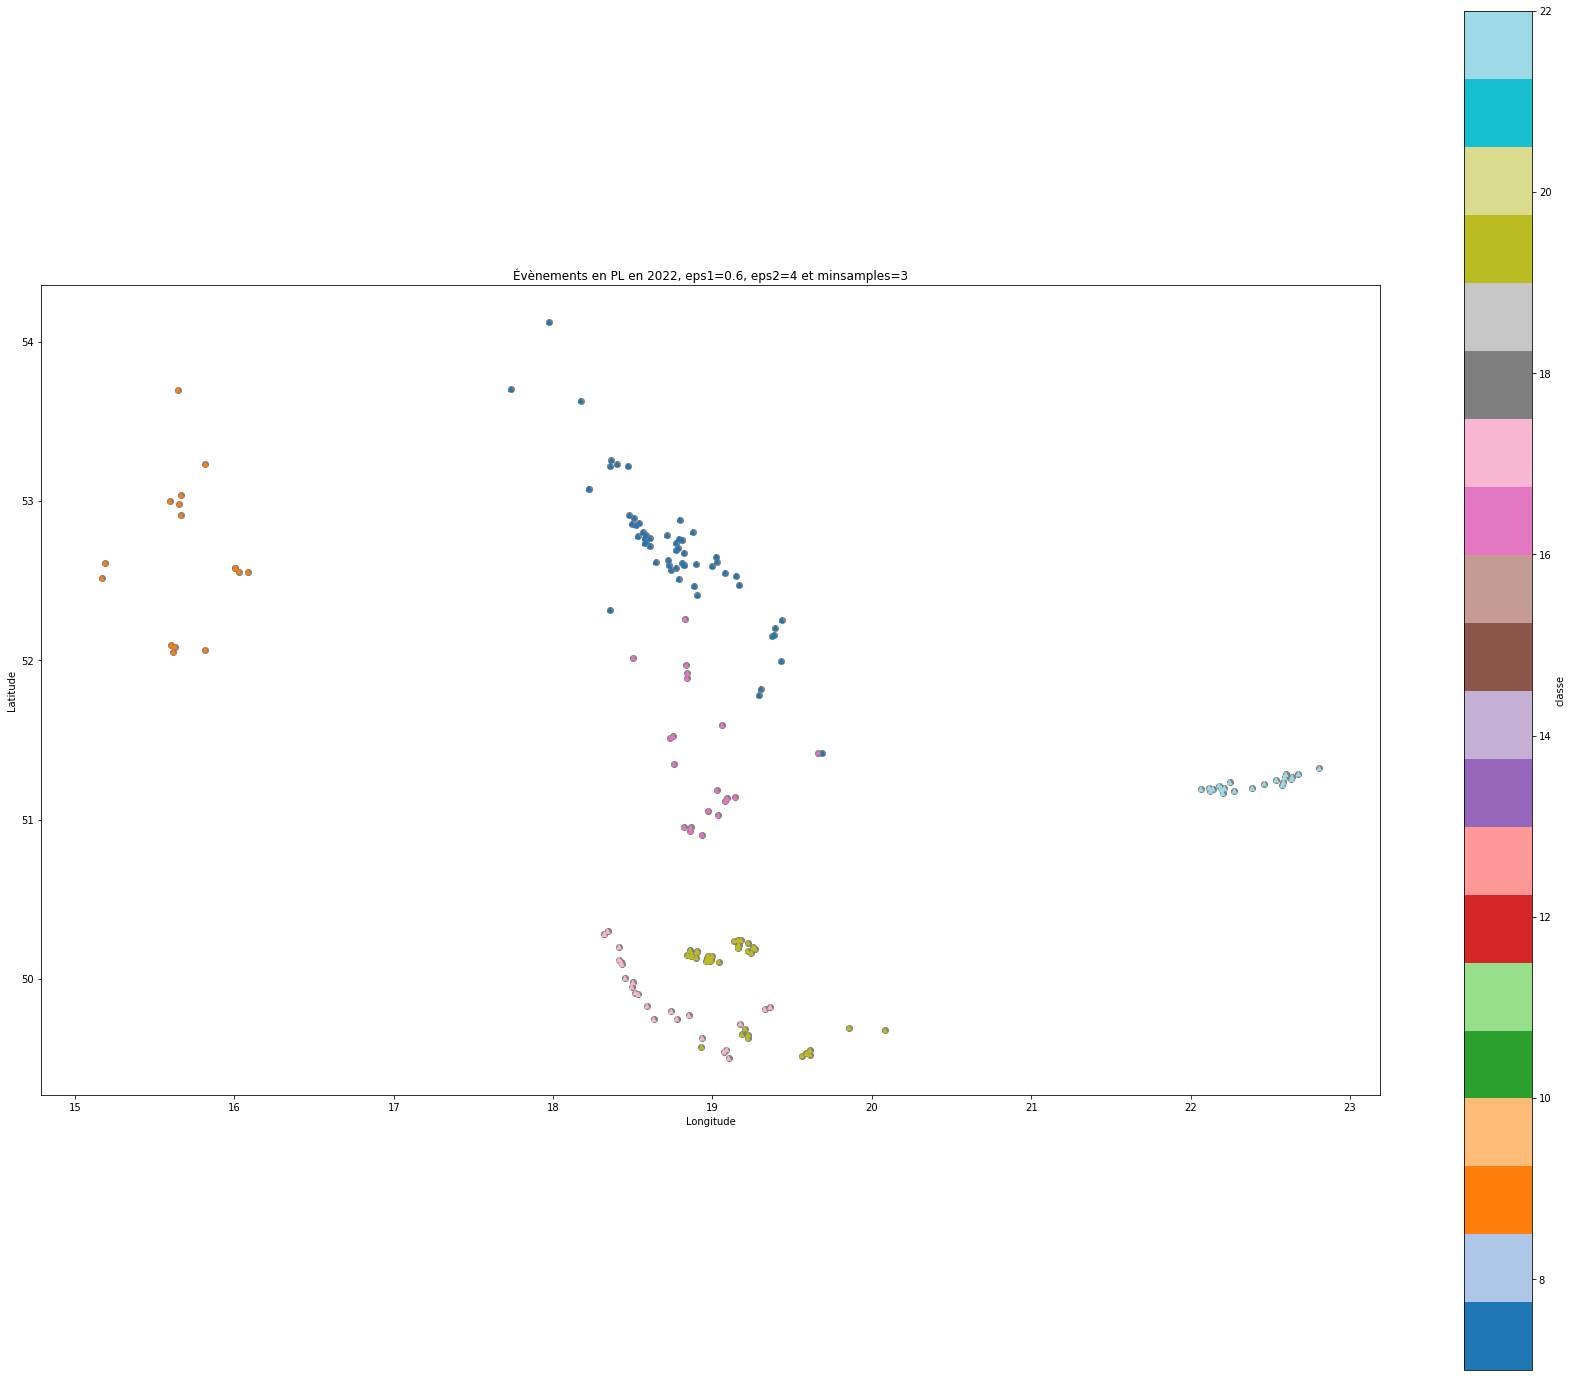

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             47        47         47       47
 7             59        59         59       59
 9             33        33         33       33
 14            29        29         29       29
 15            24        24         24       24
 16            40        40         40       40
 21            30        30         30       30


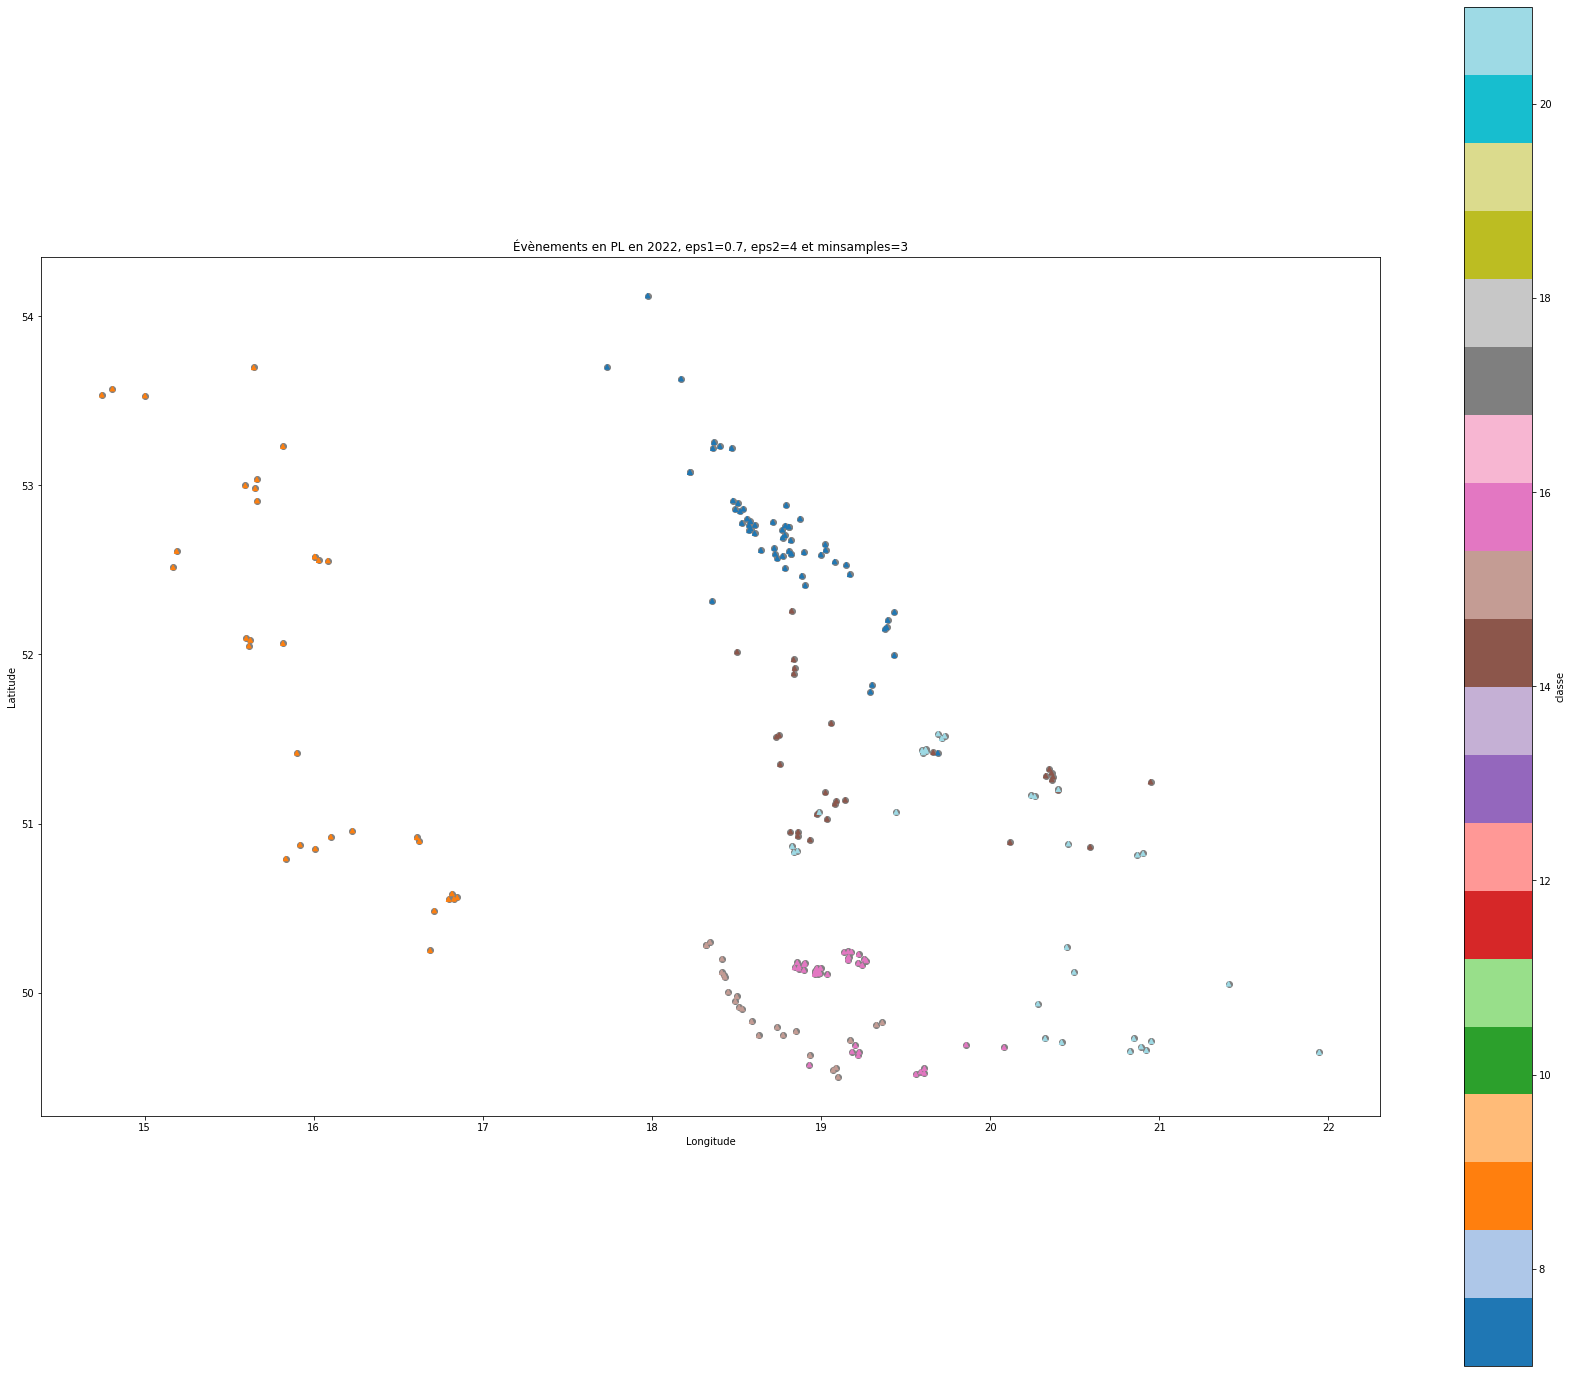

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             45        45         45       45
 6            106       106        106      106
 10            31        31         31       31
 11            24        24         24       24
 12            40        40         40       40
 15            22        22         22       22
 17            30        30         30       30


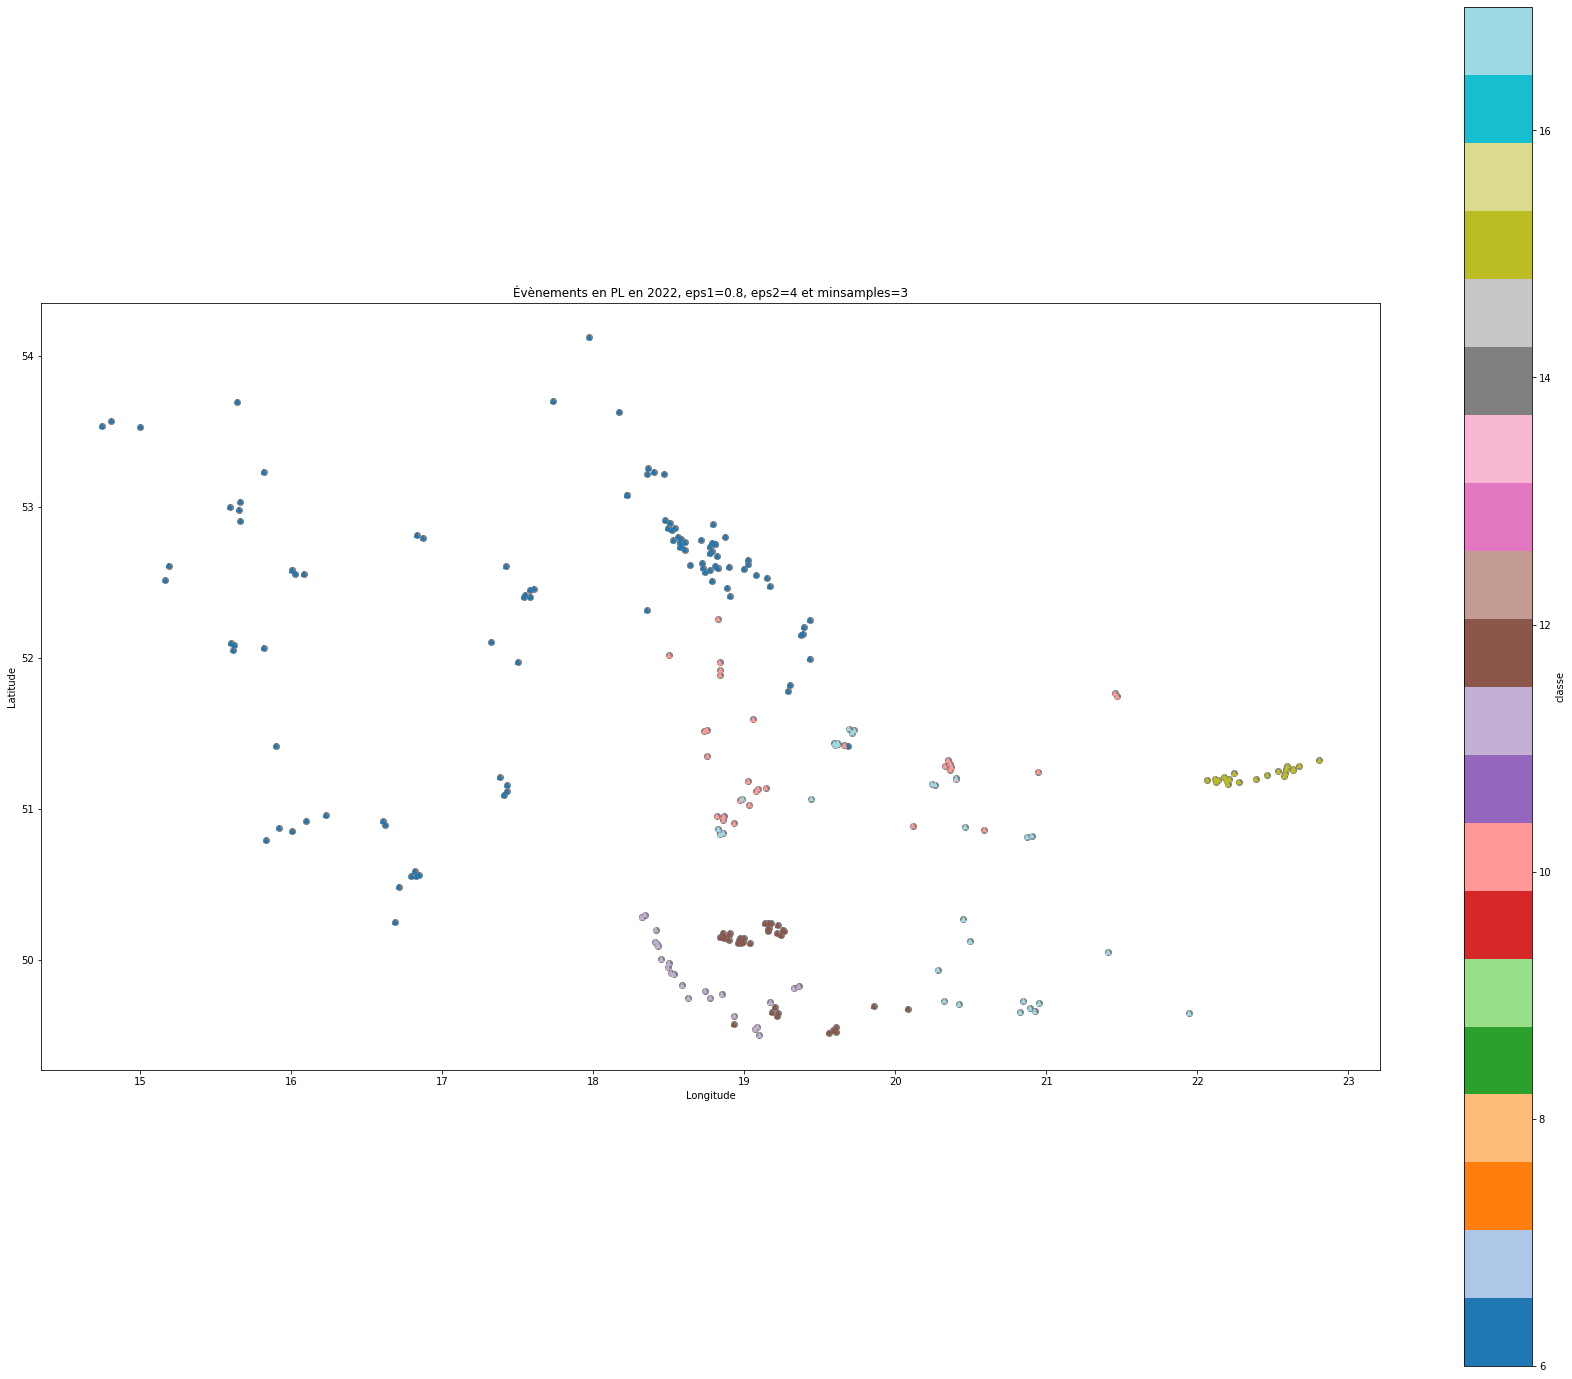

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             42        42         42       42
 2             16        16         16       16
 6            106       106        106      106
 9             60        60         60       60
 10            40        40         40       40
 13            22        22         22       22
 15            31        31         31       31


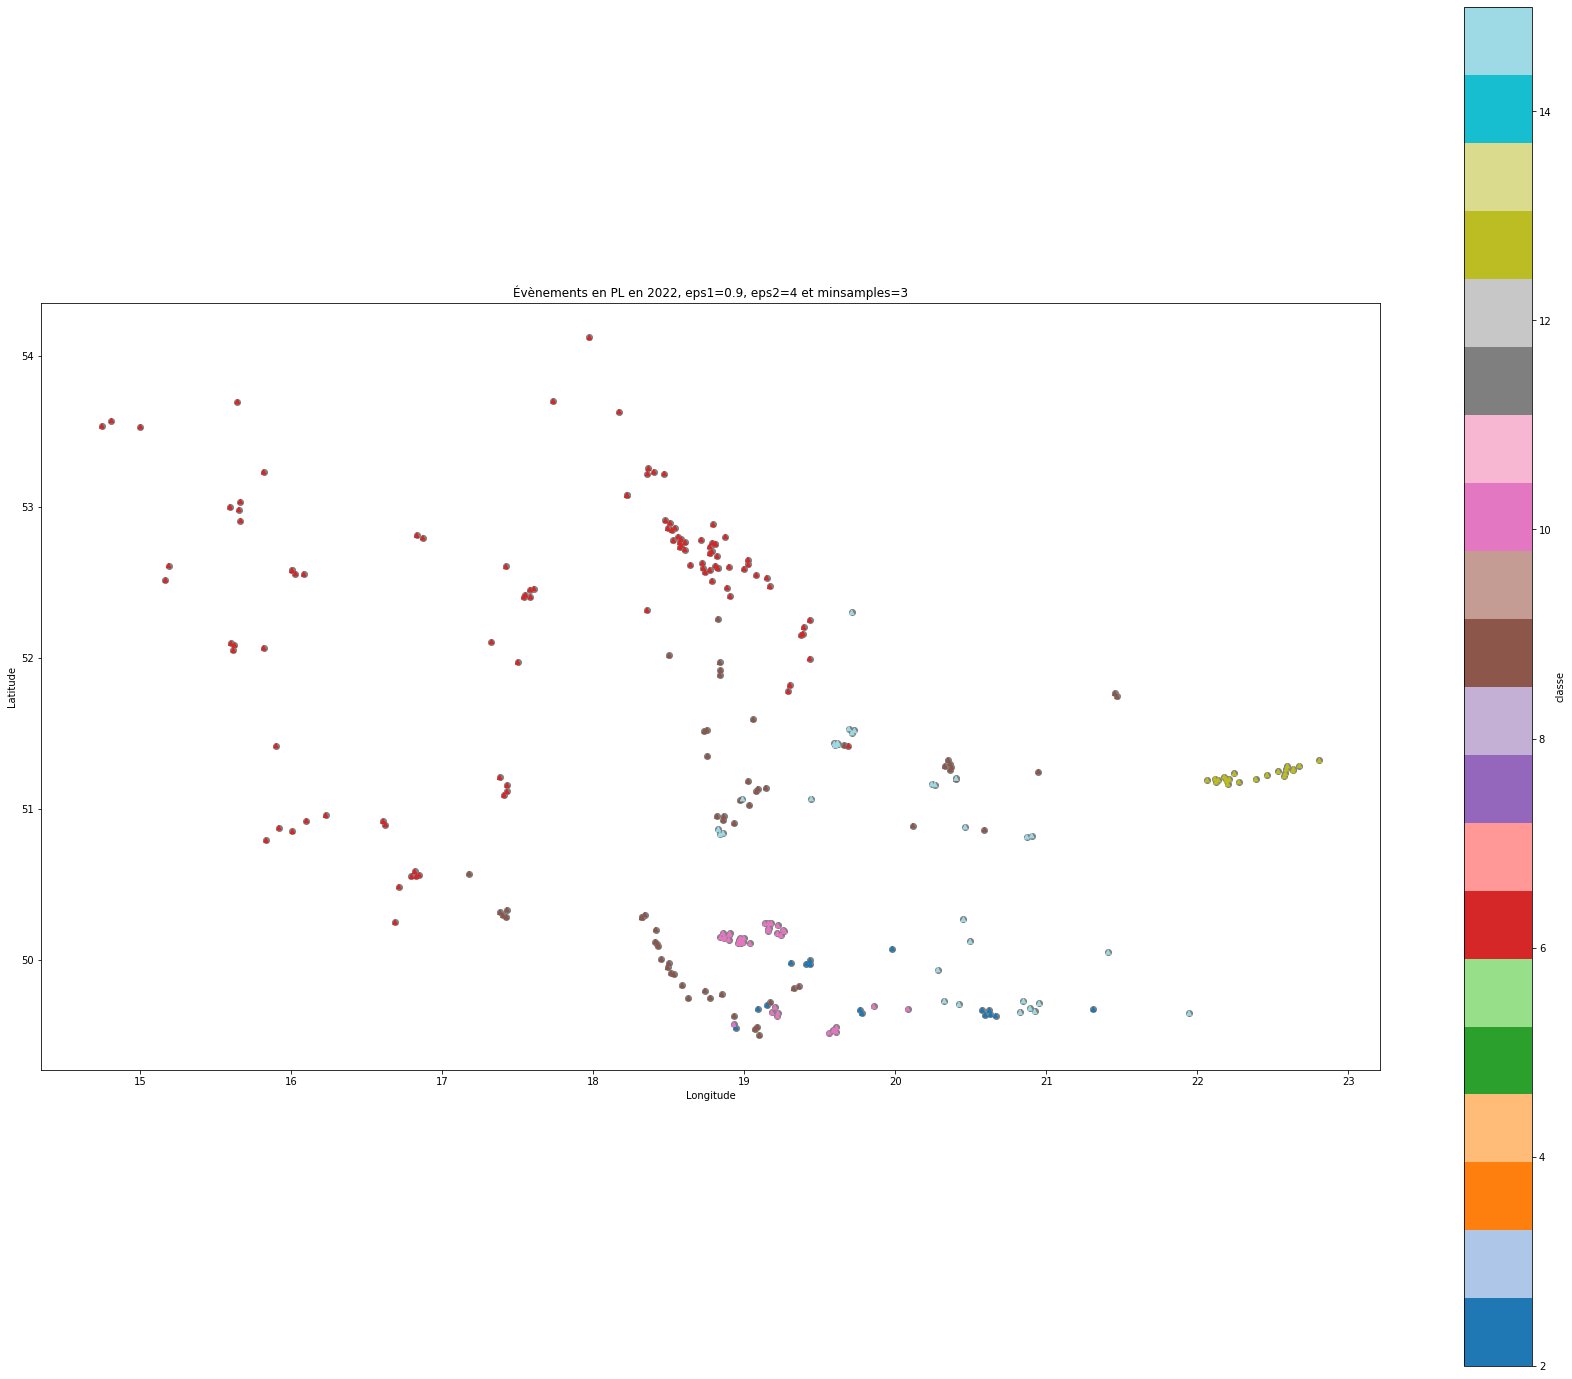

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             40        40         40       40
 2             16        16         16       16
 5            112       112        112      112
 7             74        74         74       74
 8             40        40         40       40
 11            22        22         22       22
 13            31        31         31       31


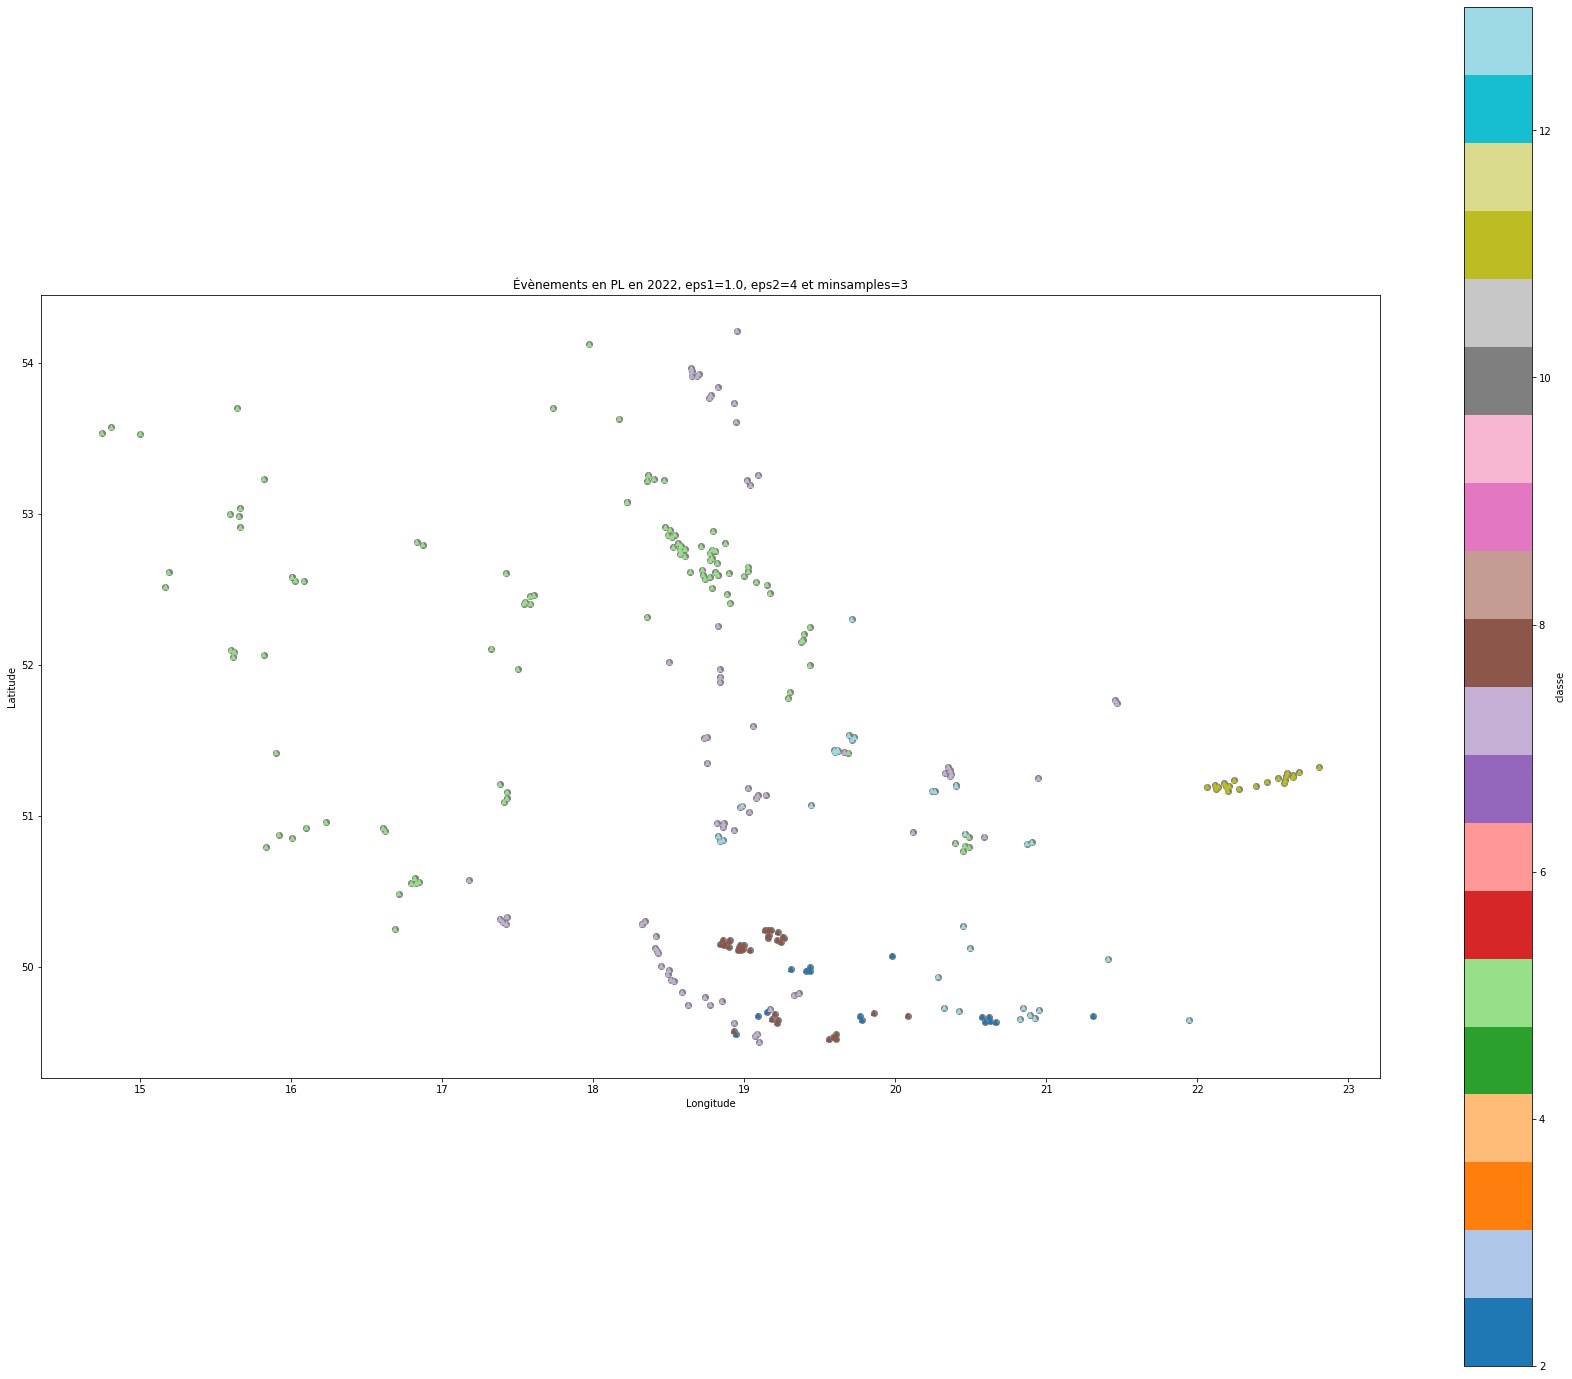

In [55]:
x="PL"

for i in range(1,11,1):
    y=i/10
    
    clusterise_country_year(x, 2022, y, 4, 3)

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
15              7         7          7        7
16             41        41         41       41
31             10        10         10       10
35             24        24         24       24
36             10        10         10       10
40             29        29         29       29
46             22        22         22       22
50              7         7          7        7
56             10        10         10       10


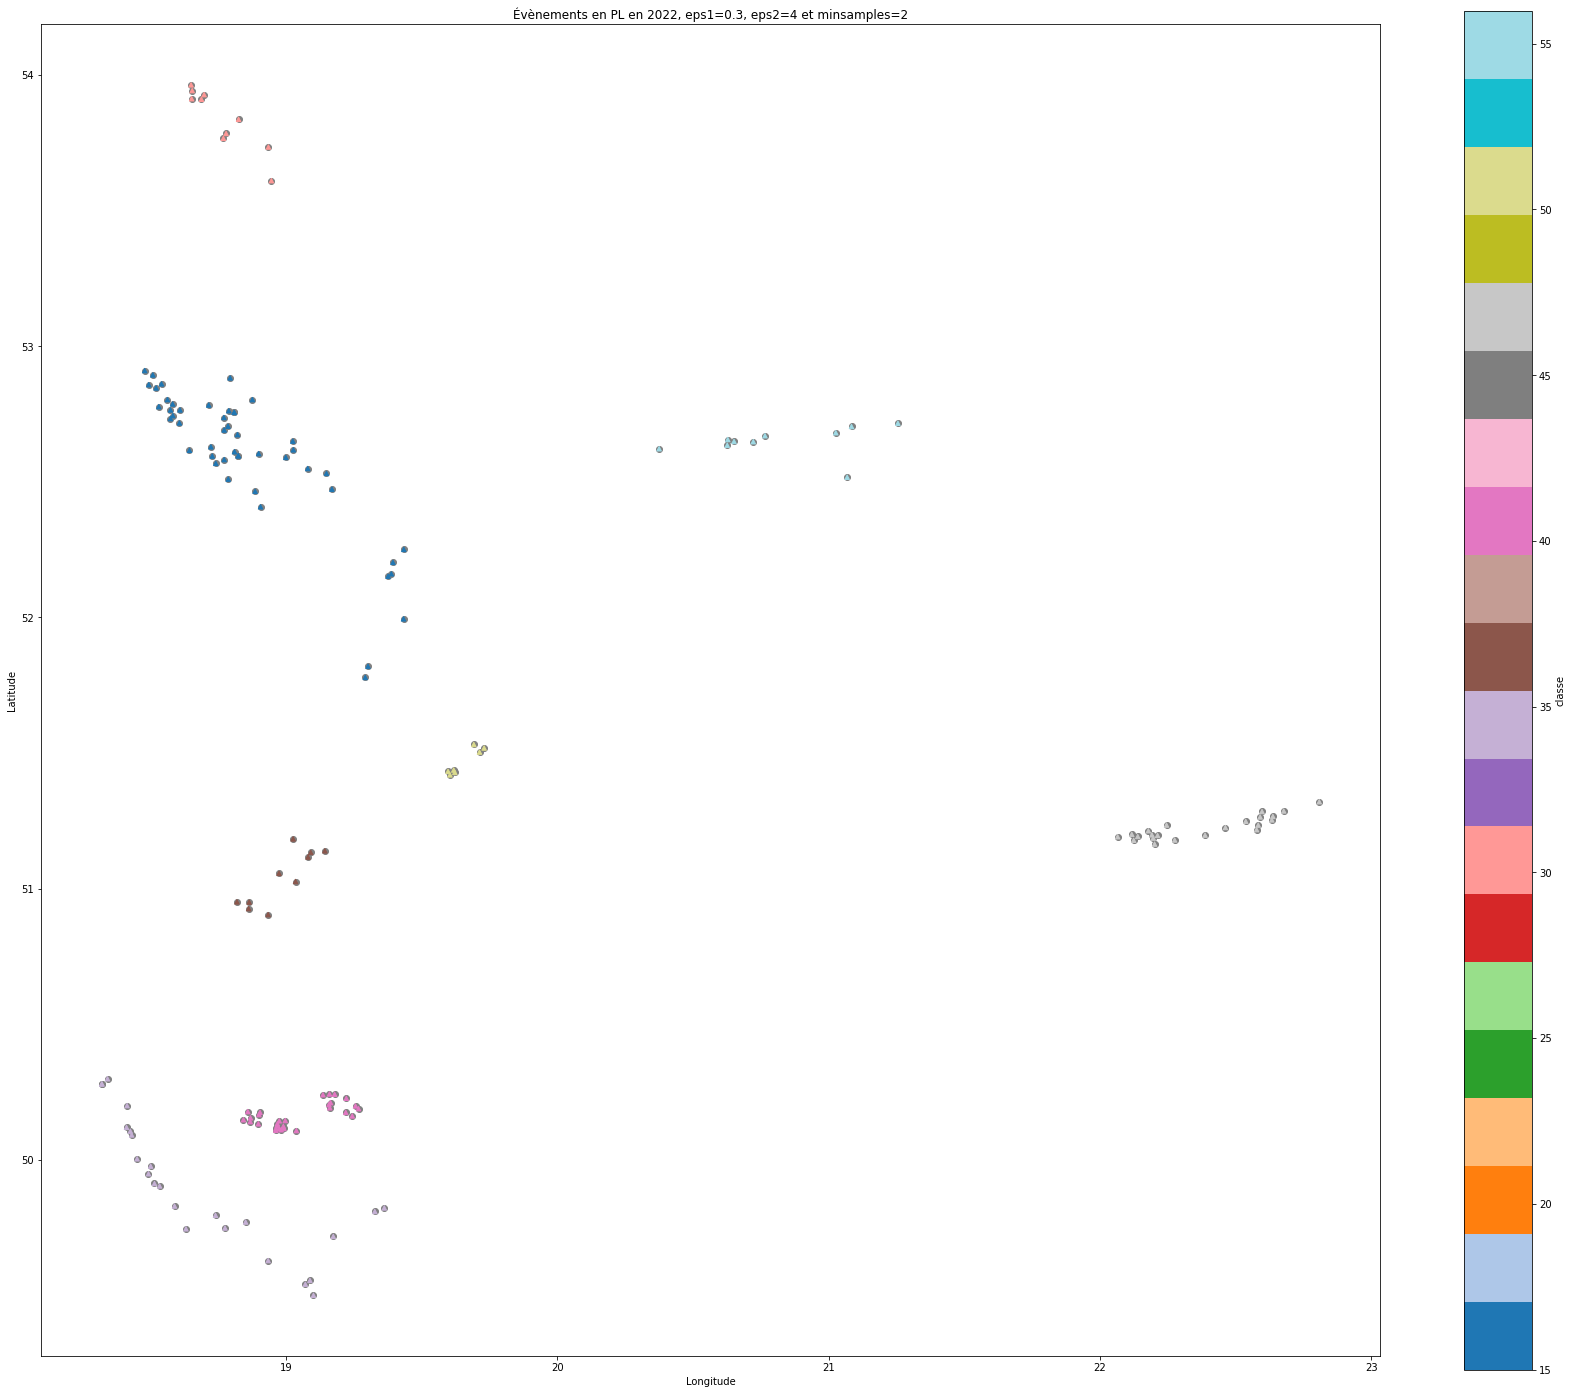

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
8               7         7          7        7
9              41        41         41       41
20             10        10         10       10
24             24        24         24       24
25             10        10         10       10
28             29        29         29       29
33             22        22         22       22
35              7         7          7        7
42             10        10         10       10


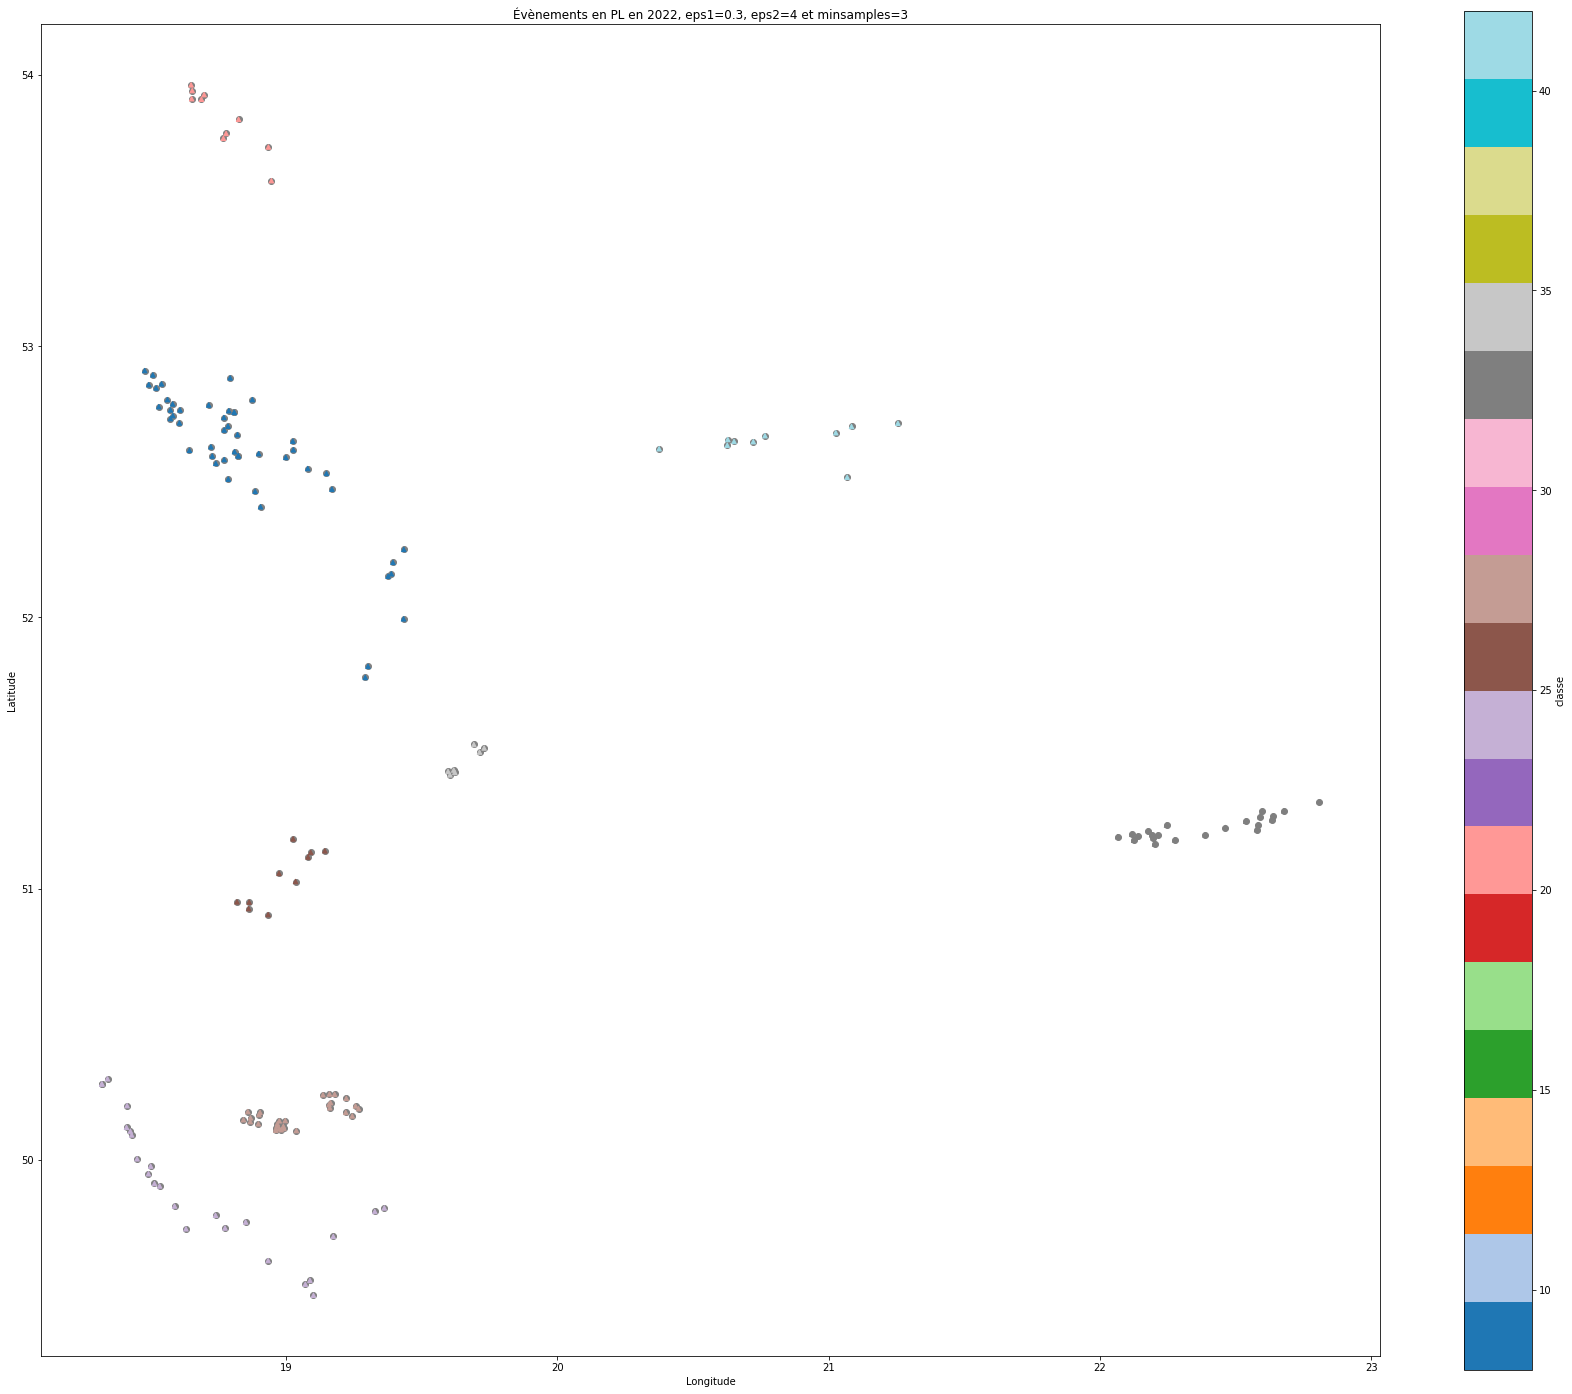

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
5               7         7          7        7
6              41        41         41       41
17             10        10         10       10
20             24        24         24       24
21             10        10         10       10
23             29        29         29       29
27             22        22         22       22
29              7         7          7        7
34             10        10         10       10


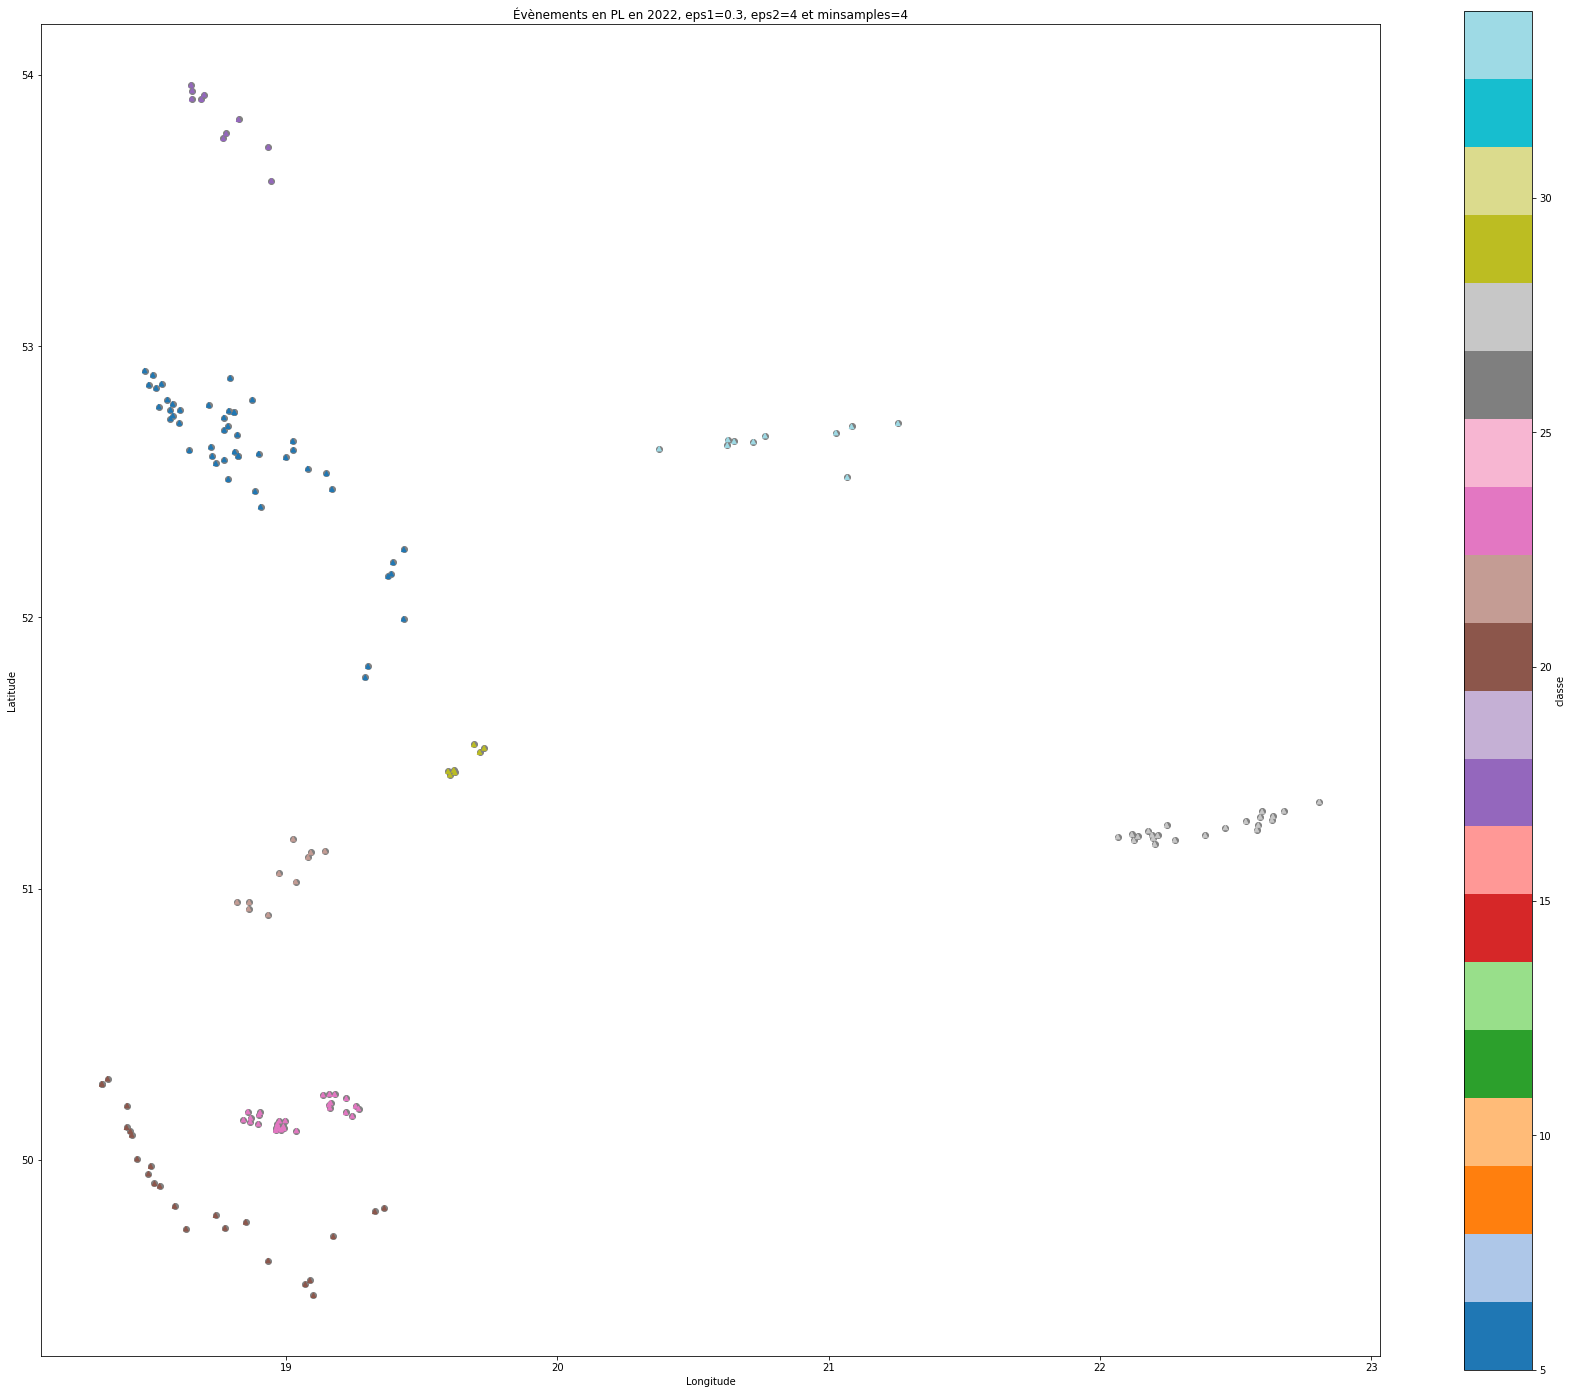

In [56]:
x="PL"

for i in range(2,5):    
    clusterise_country_year(x, 2022,0.3, 4,i)

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
32             74        74         74       74
35            114       114        114      114
55            110       110        110      110
56             76        76         76       76
58             76        76         76       76
67            164       164        164      164
85            118       118        118      118


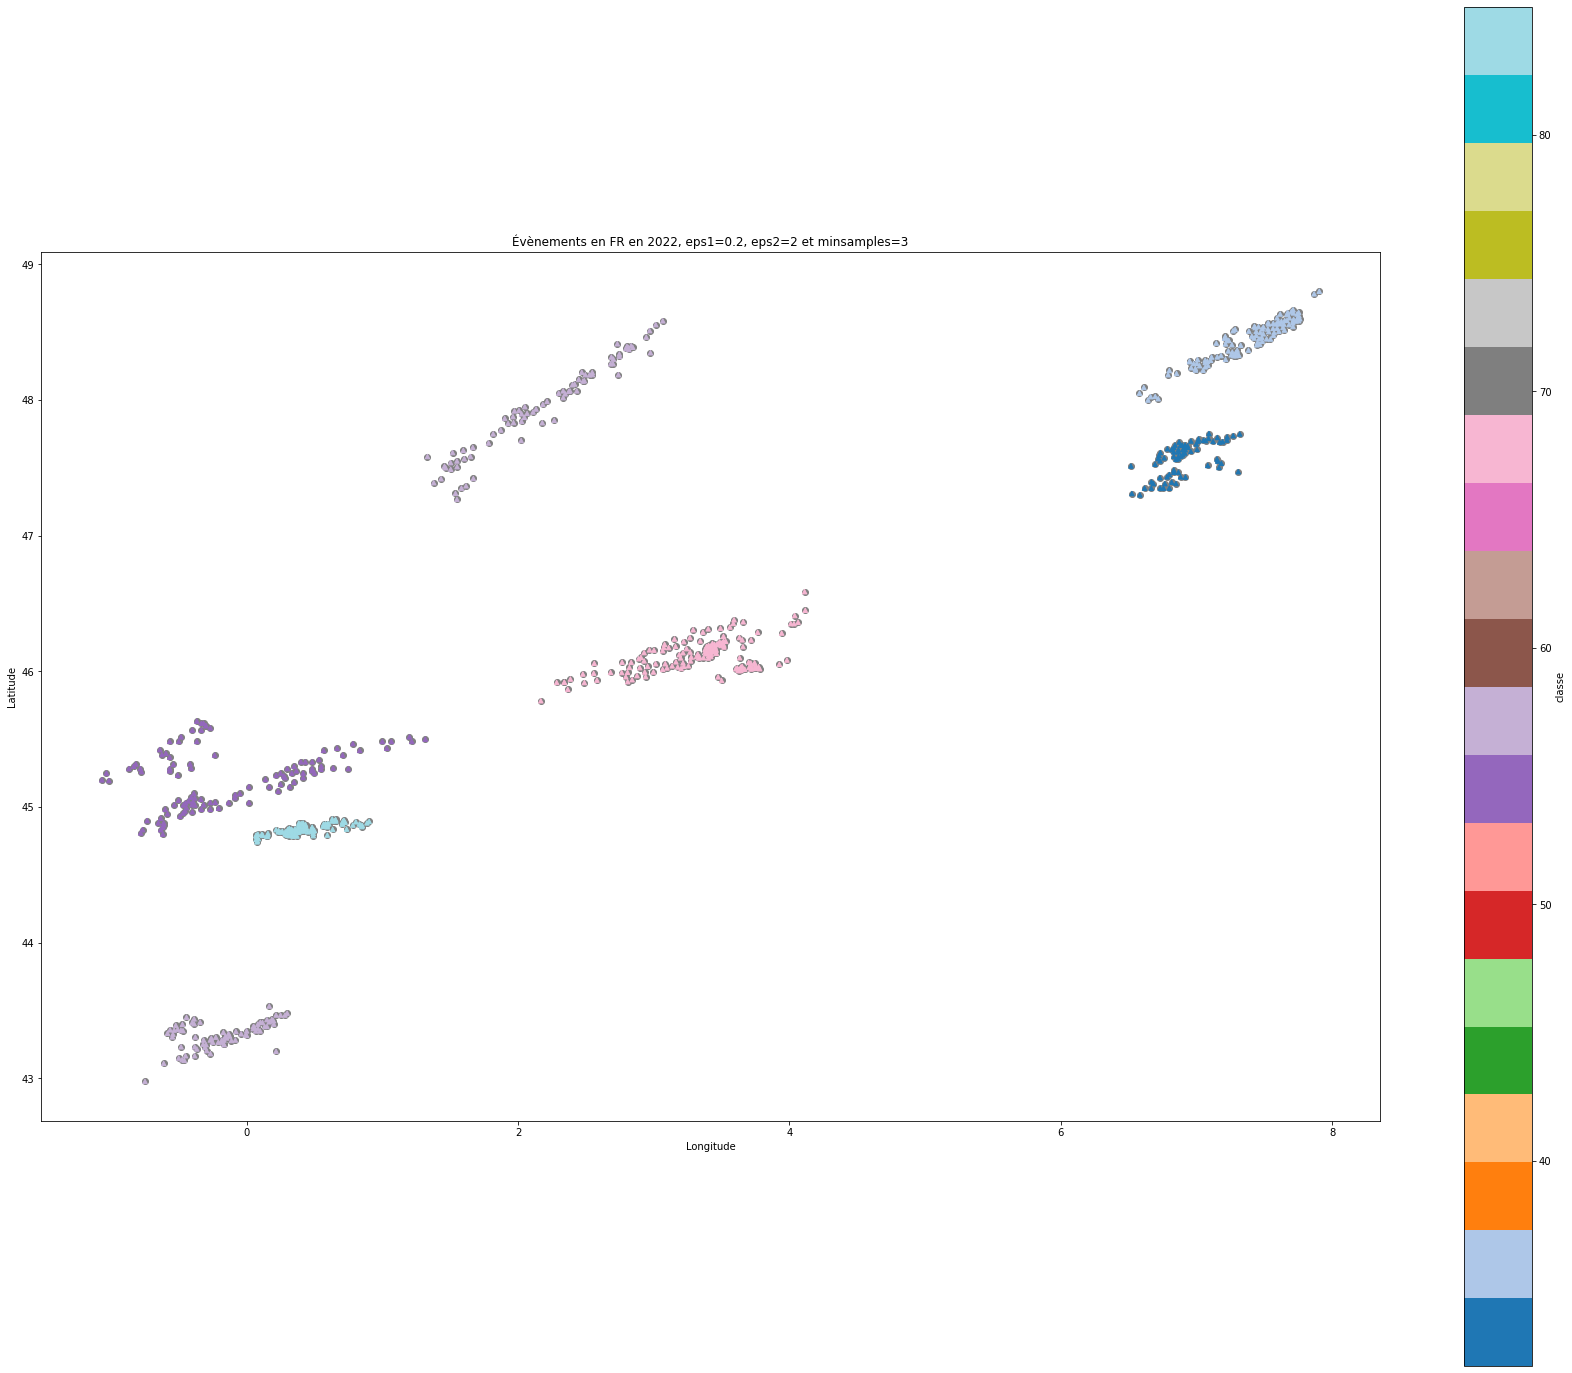

In [57]:
x="FR"

clusterise_country_year(x, 2022, 0.2, 2, 3)

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
30            110       110        110      110
31            134       134        134      134
49            113       113        113      113
52             97        97         97       97
61            133       133        133      133
81            117       117        117      117


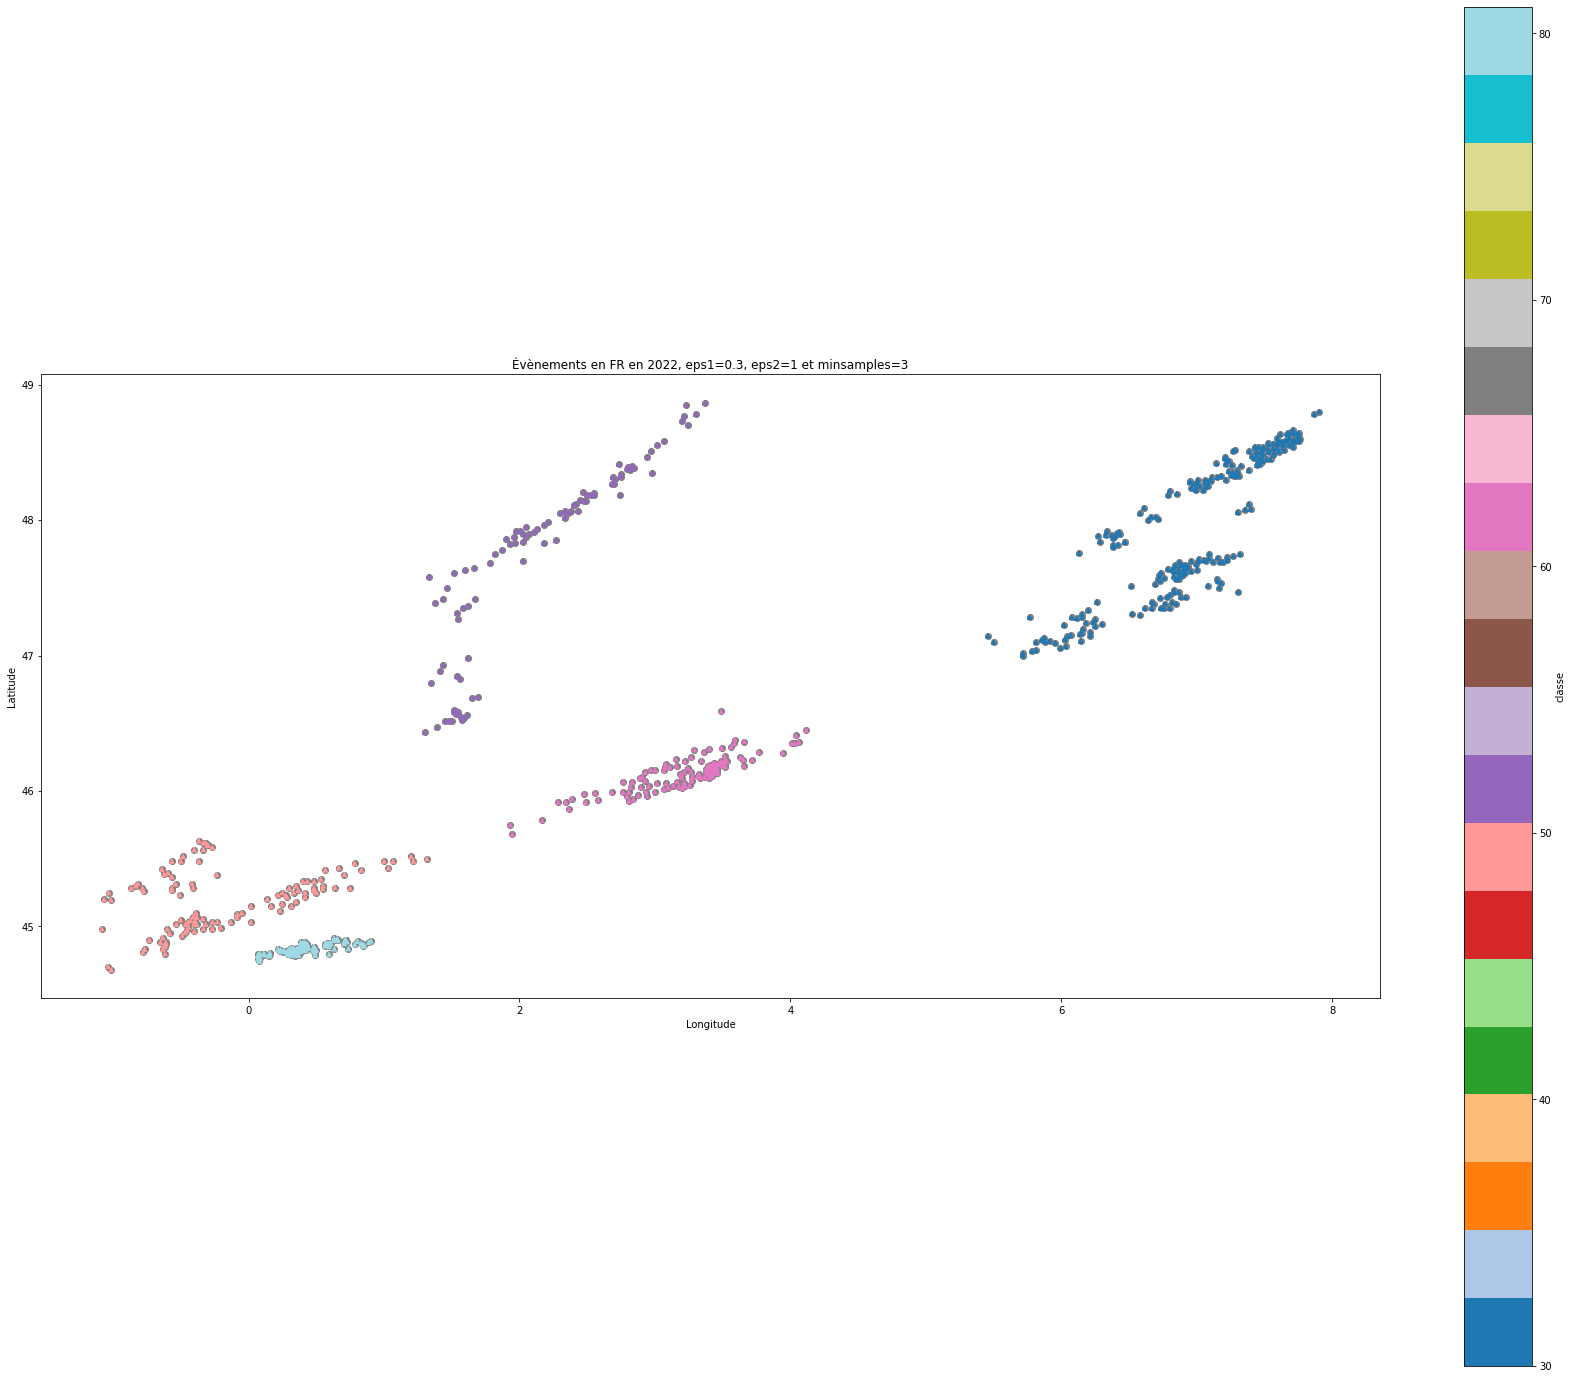

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
29            110       110        110      110
30            134       134        134      134
46            113       113        113      113
48            105       105        105      105
56            184       184        184      184
73            118       118        118      118


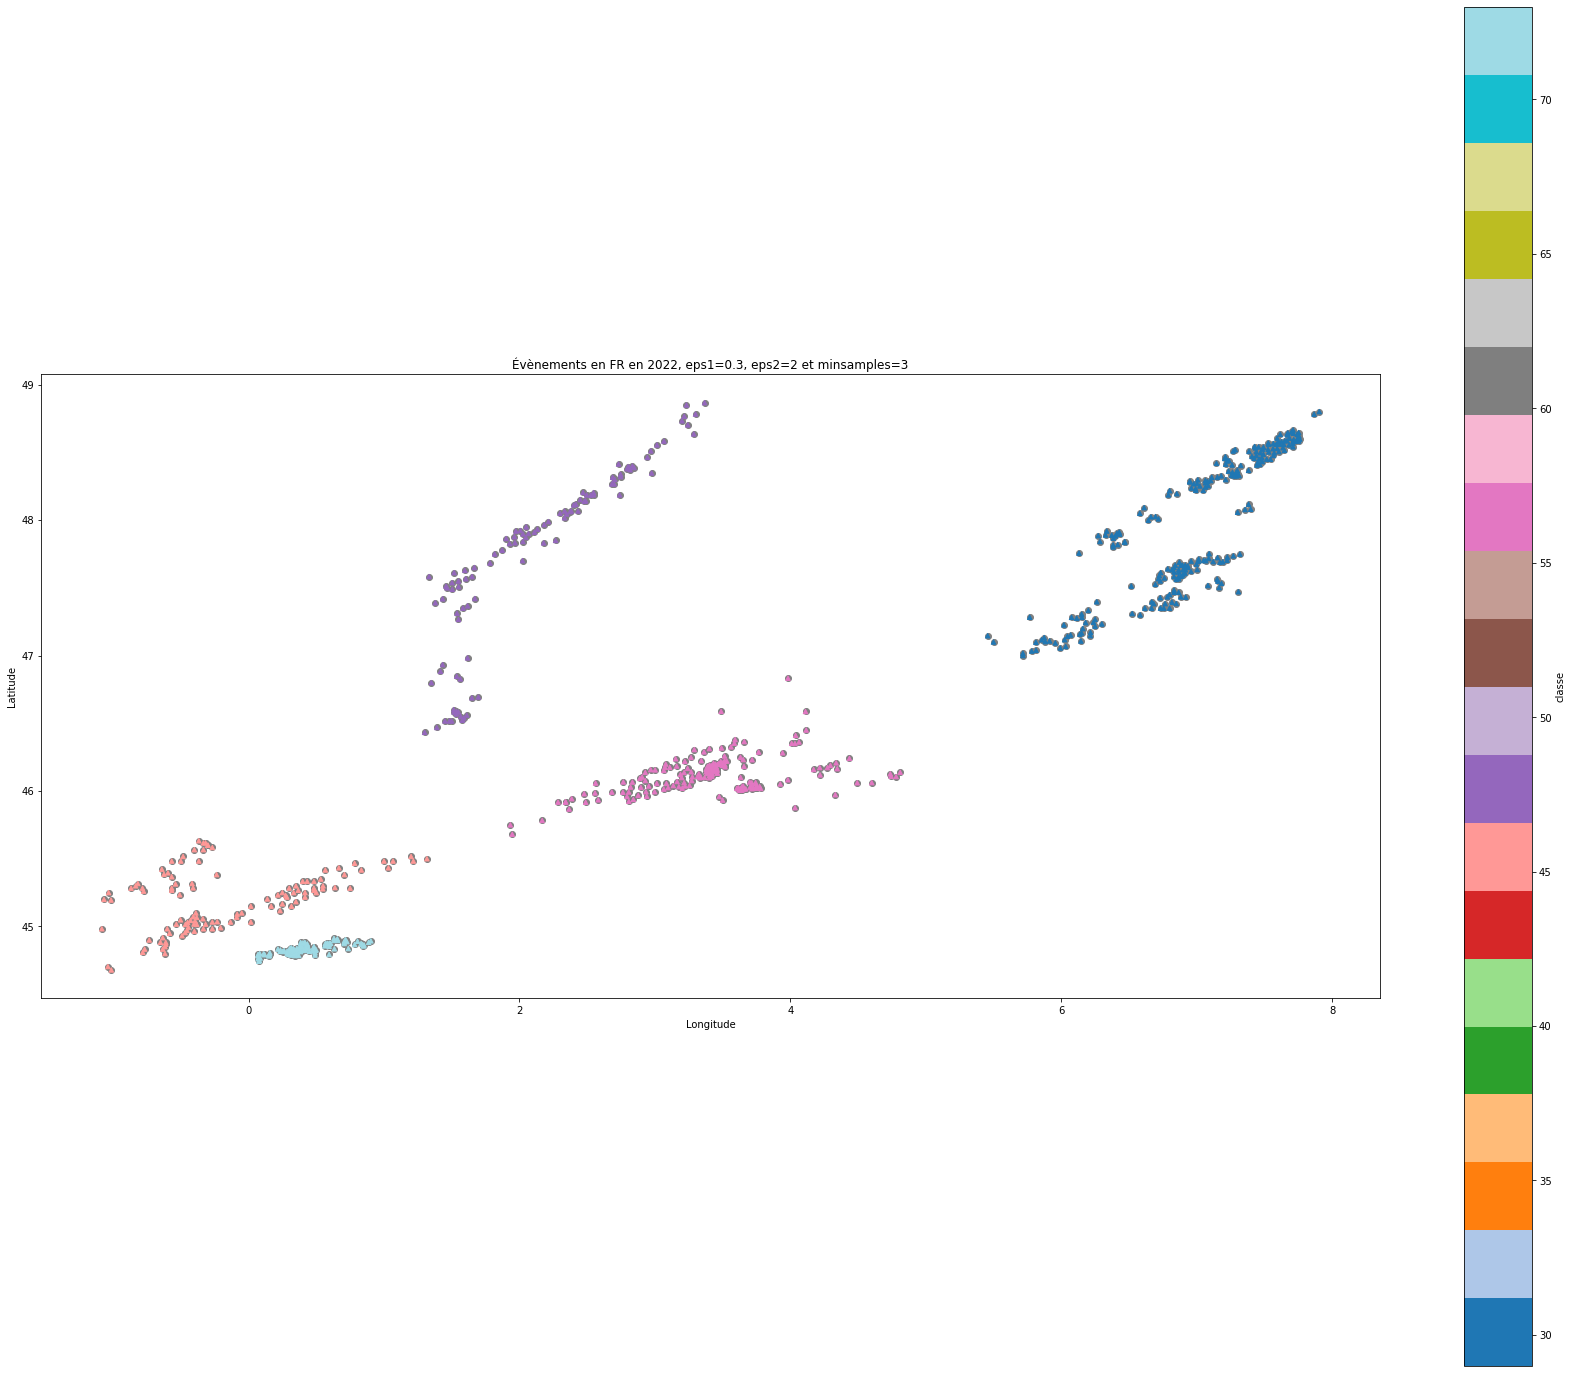

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
28            110       110        110      110
29            134       134        134      134
45            113       113        113      113
47            105       105        105      105
55            186       186        186      186
72            118       118        118      118


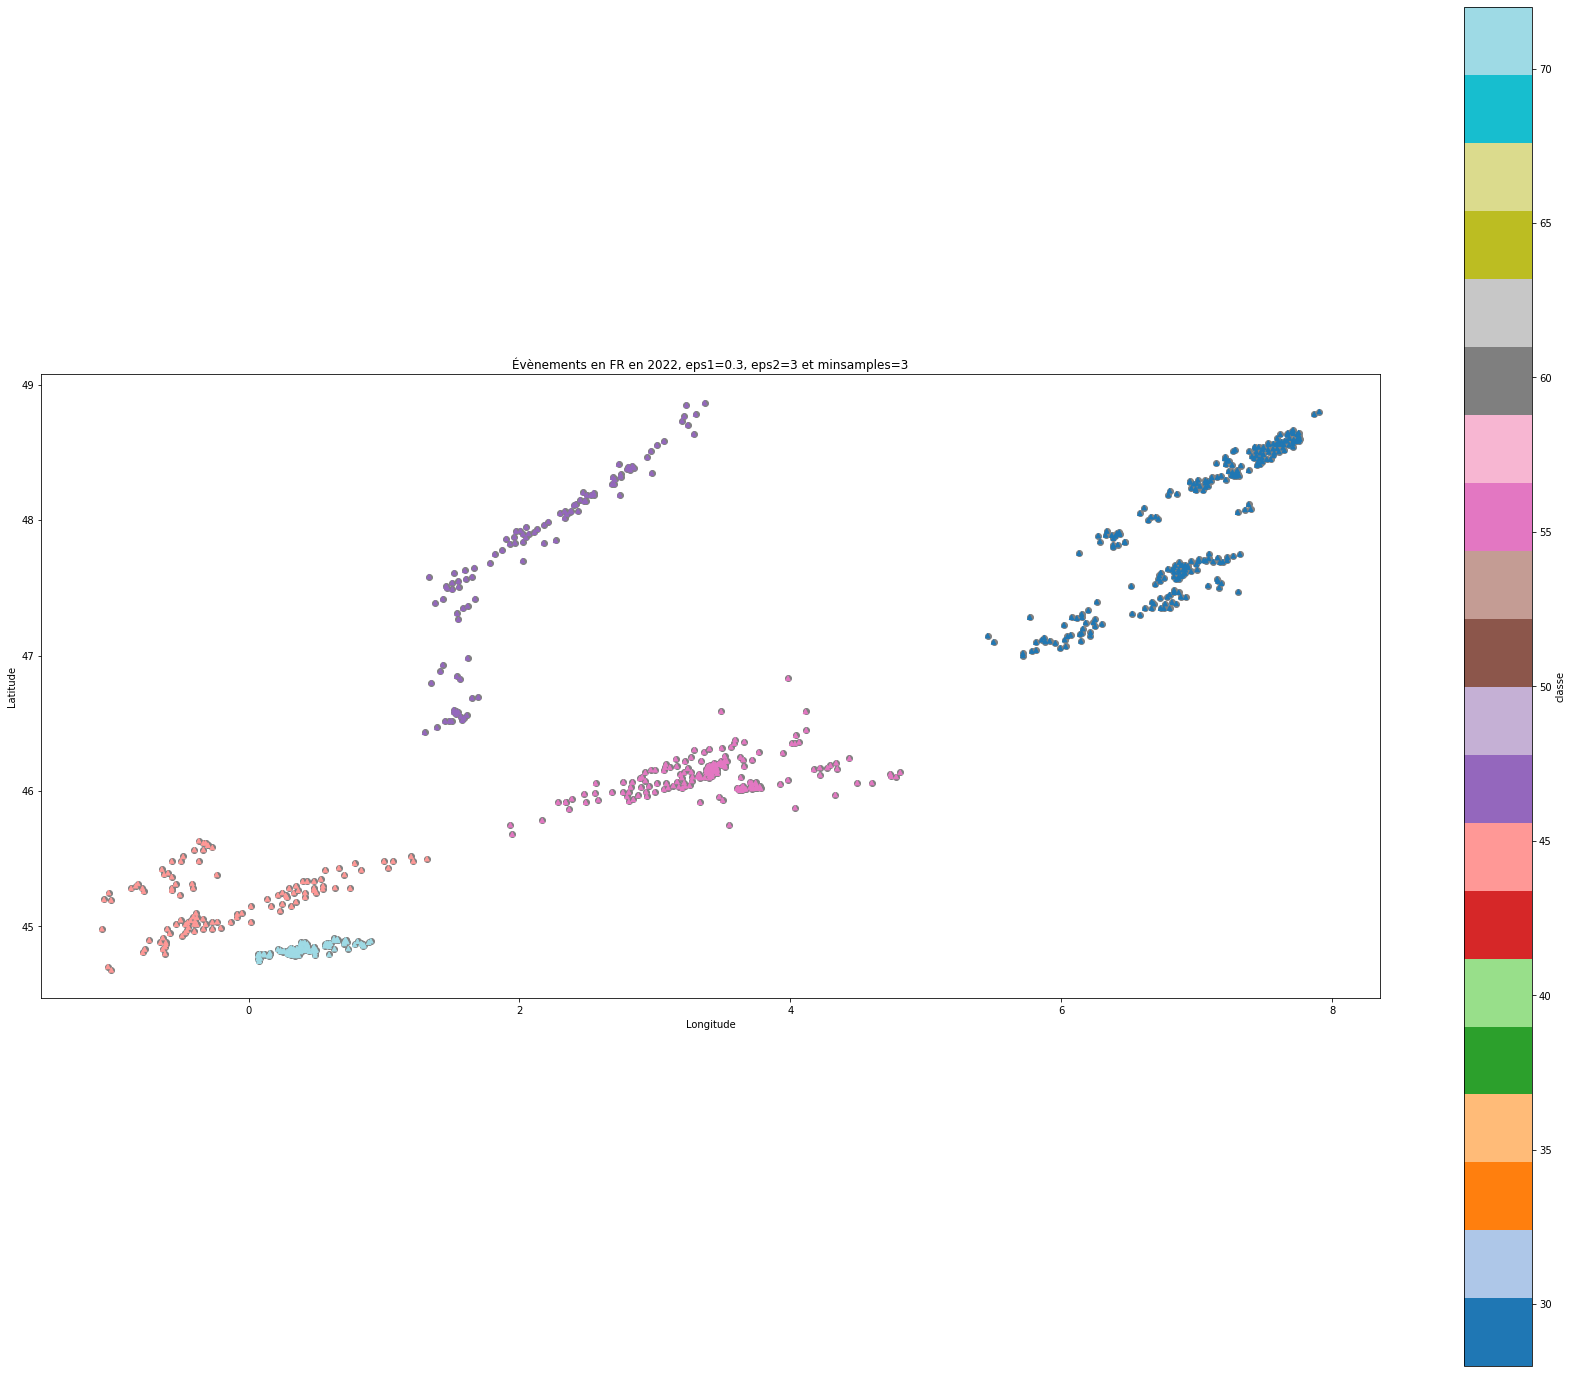

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            185       185        185      185
 28           110       110        110      110
 29           134       134        134      134
 45           113       113        113      113
 47           105       105        105      105
 55           188       188        188      188
 72           120       120        120      120


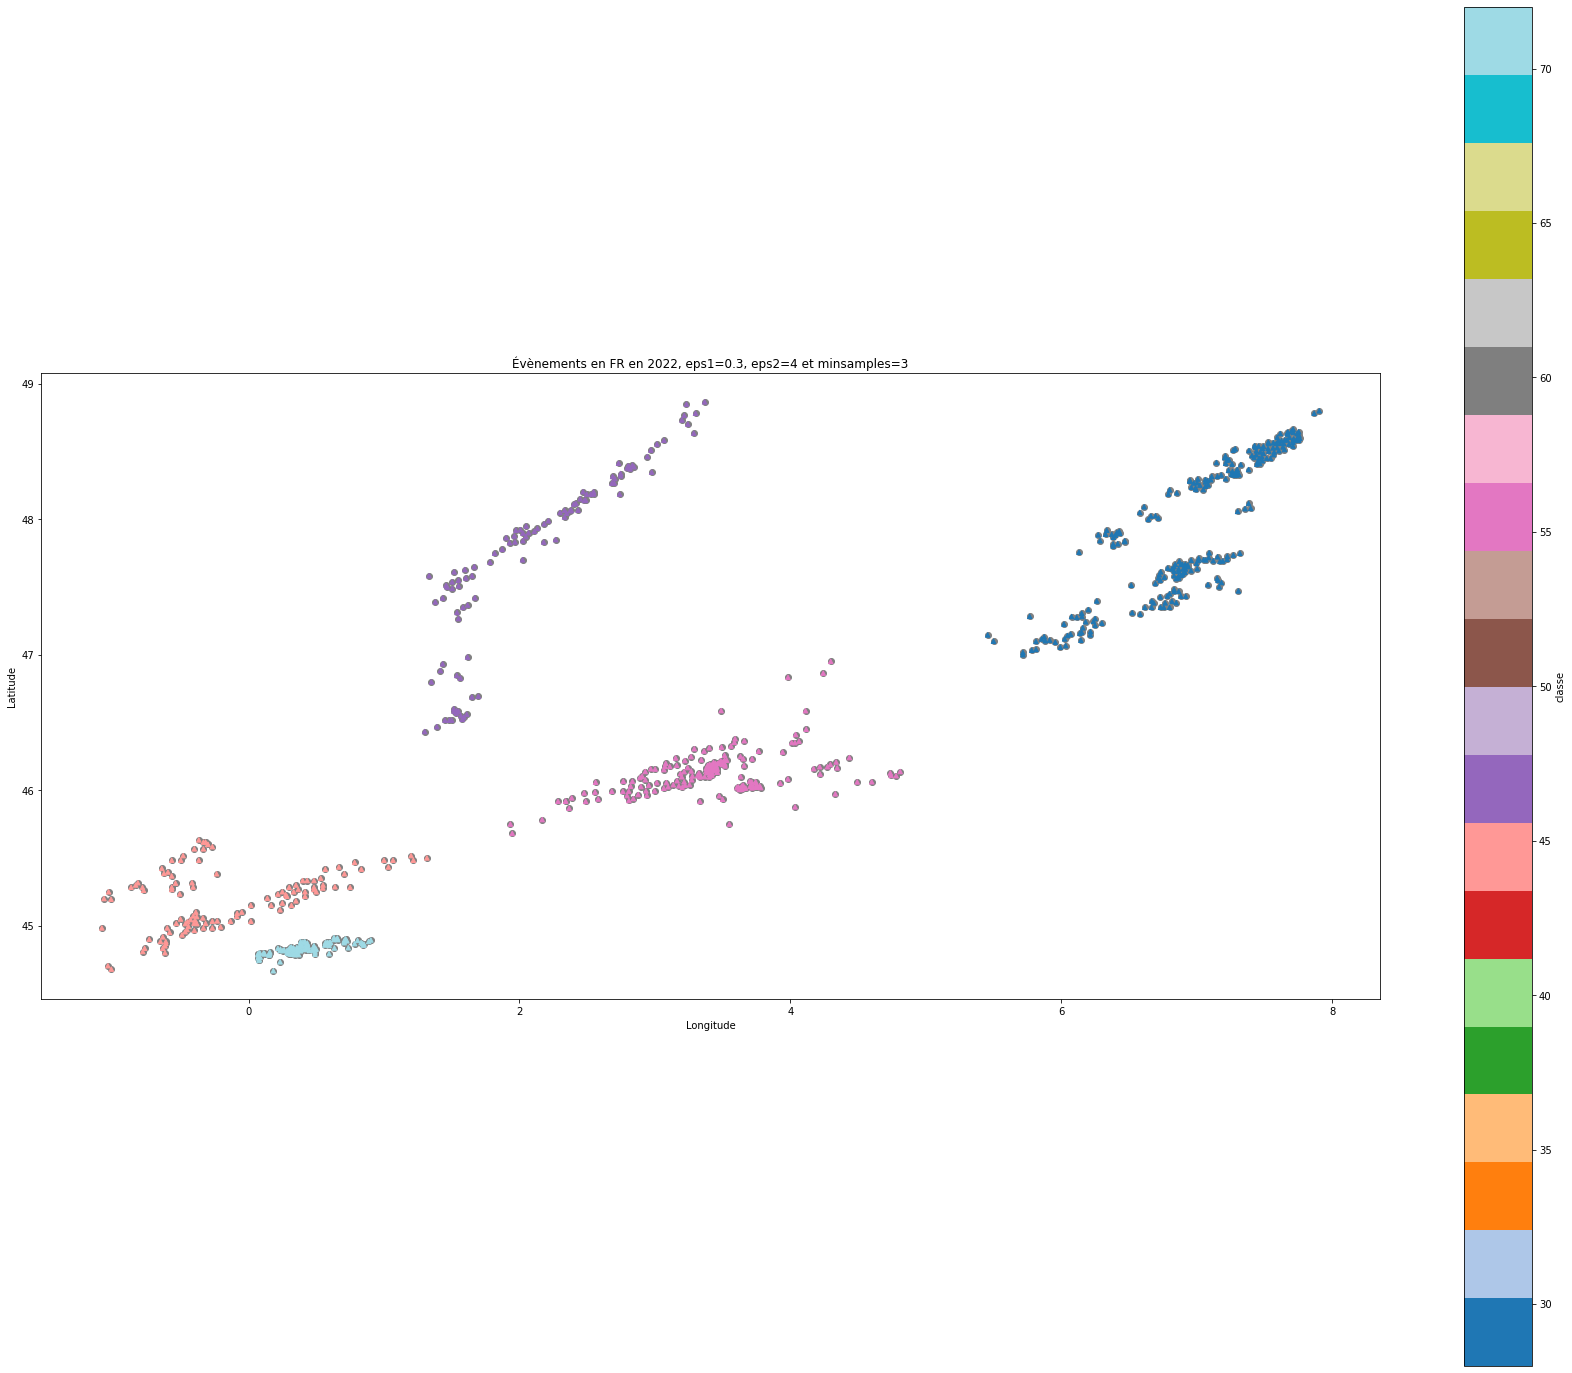

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            185       185        185      185
 28           110       110        110      110
 29           134       134        134      134
 45           113       113        113      113
 47           105       105        105      105
 55           188       188        188      188
 72           120       120        120      120


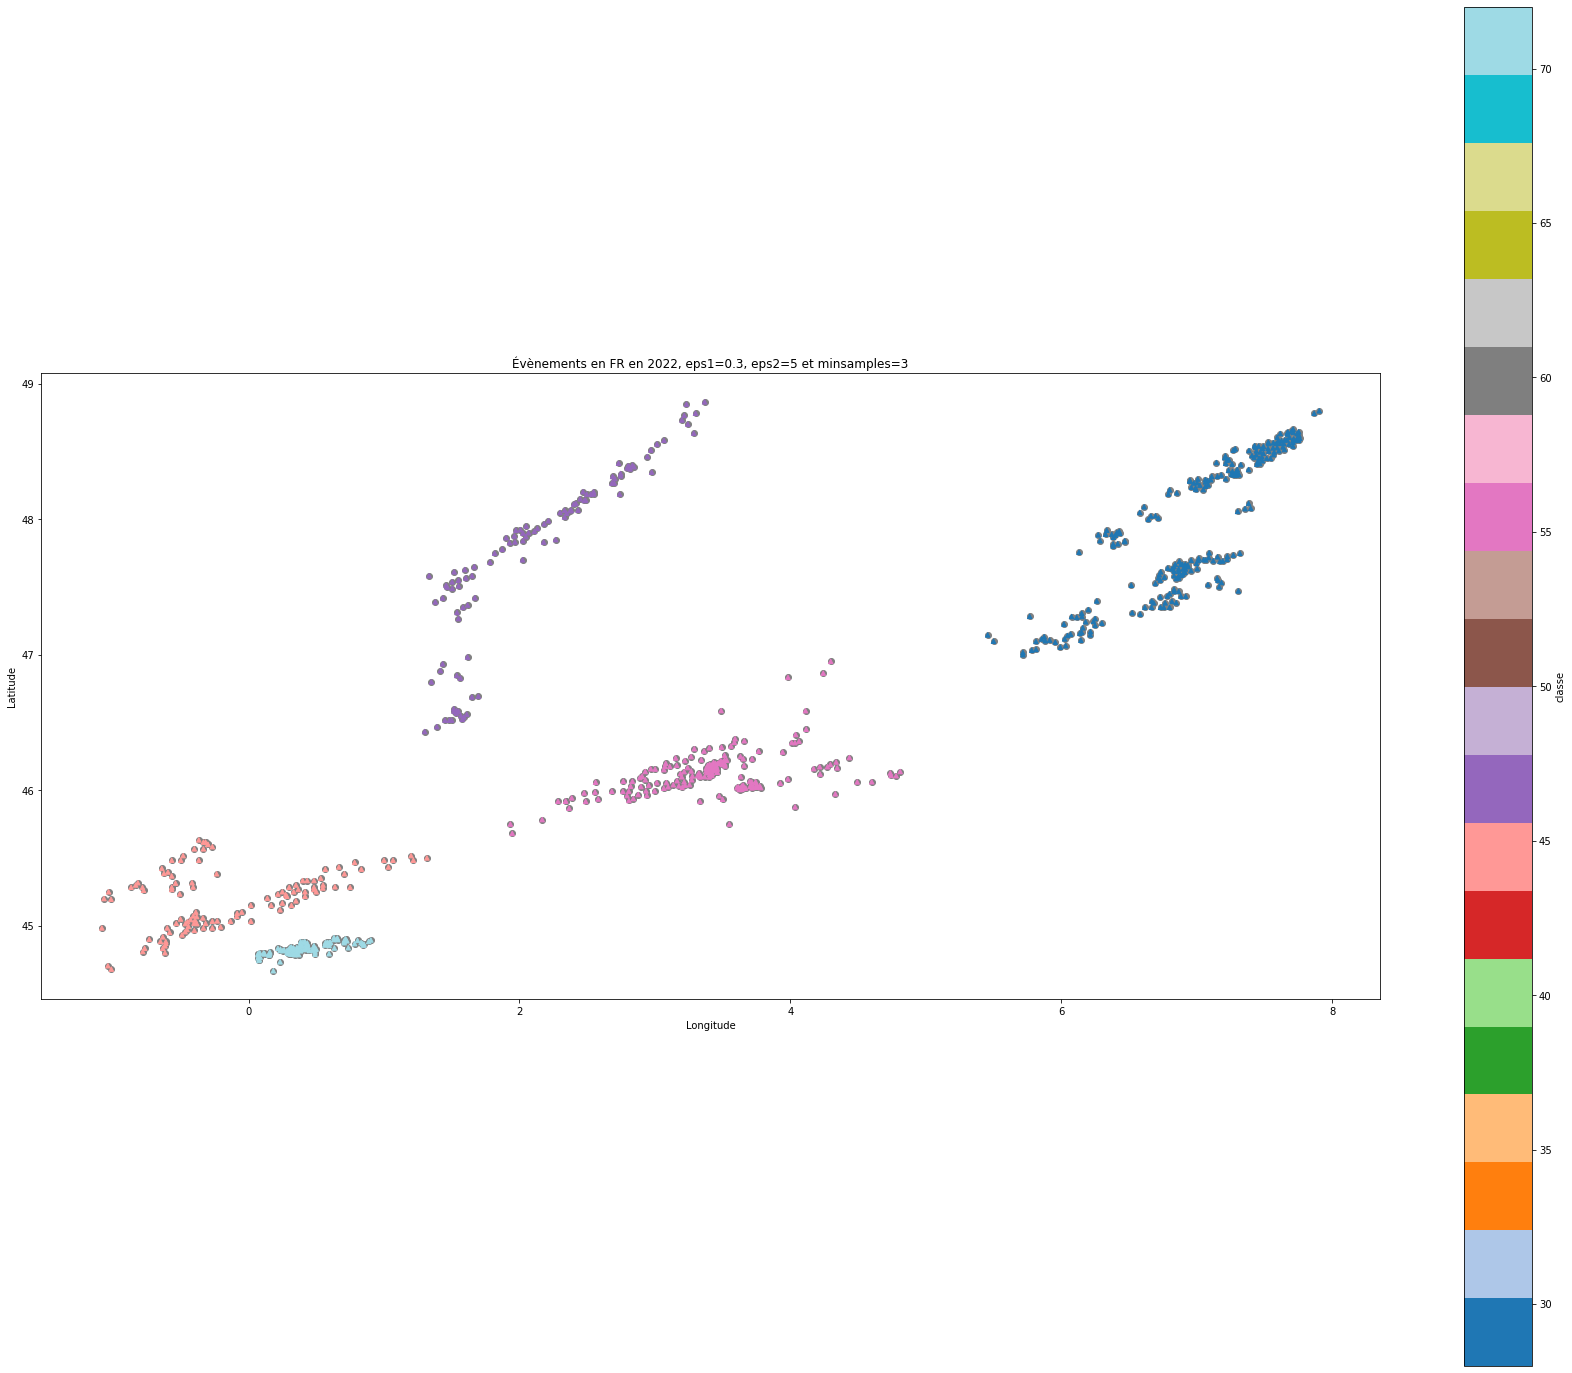

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            185       185        185      185
 28           110       110        110      110
 29           134       134        134      134
 45           113       113        113      113
 47           105       105        105      105
 55           188       188        188      188
 72           120       120        120      120


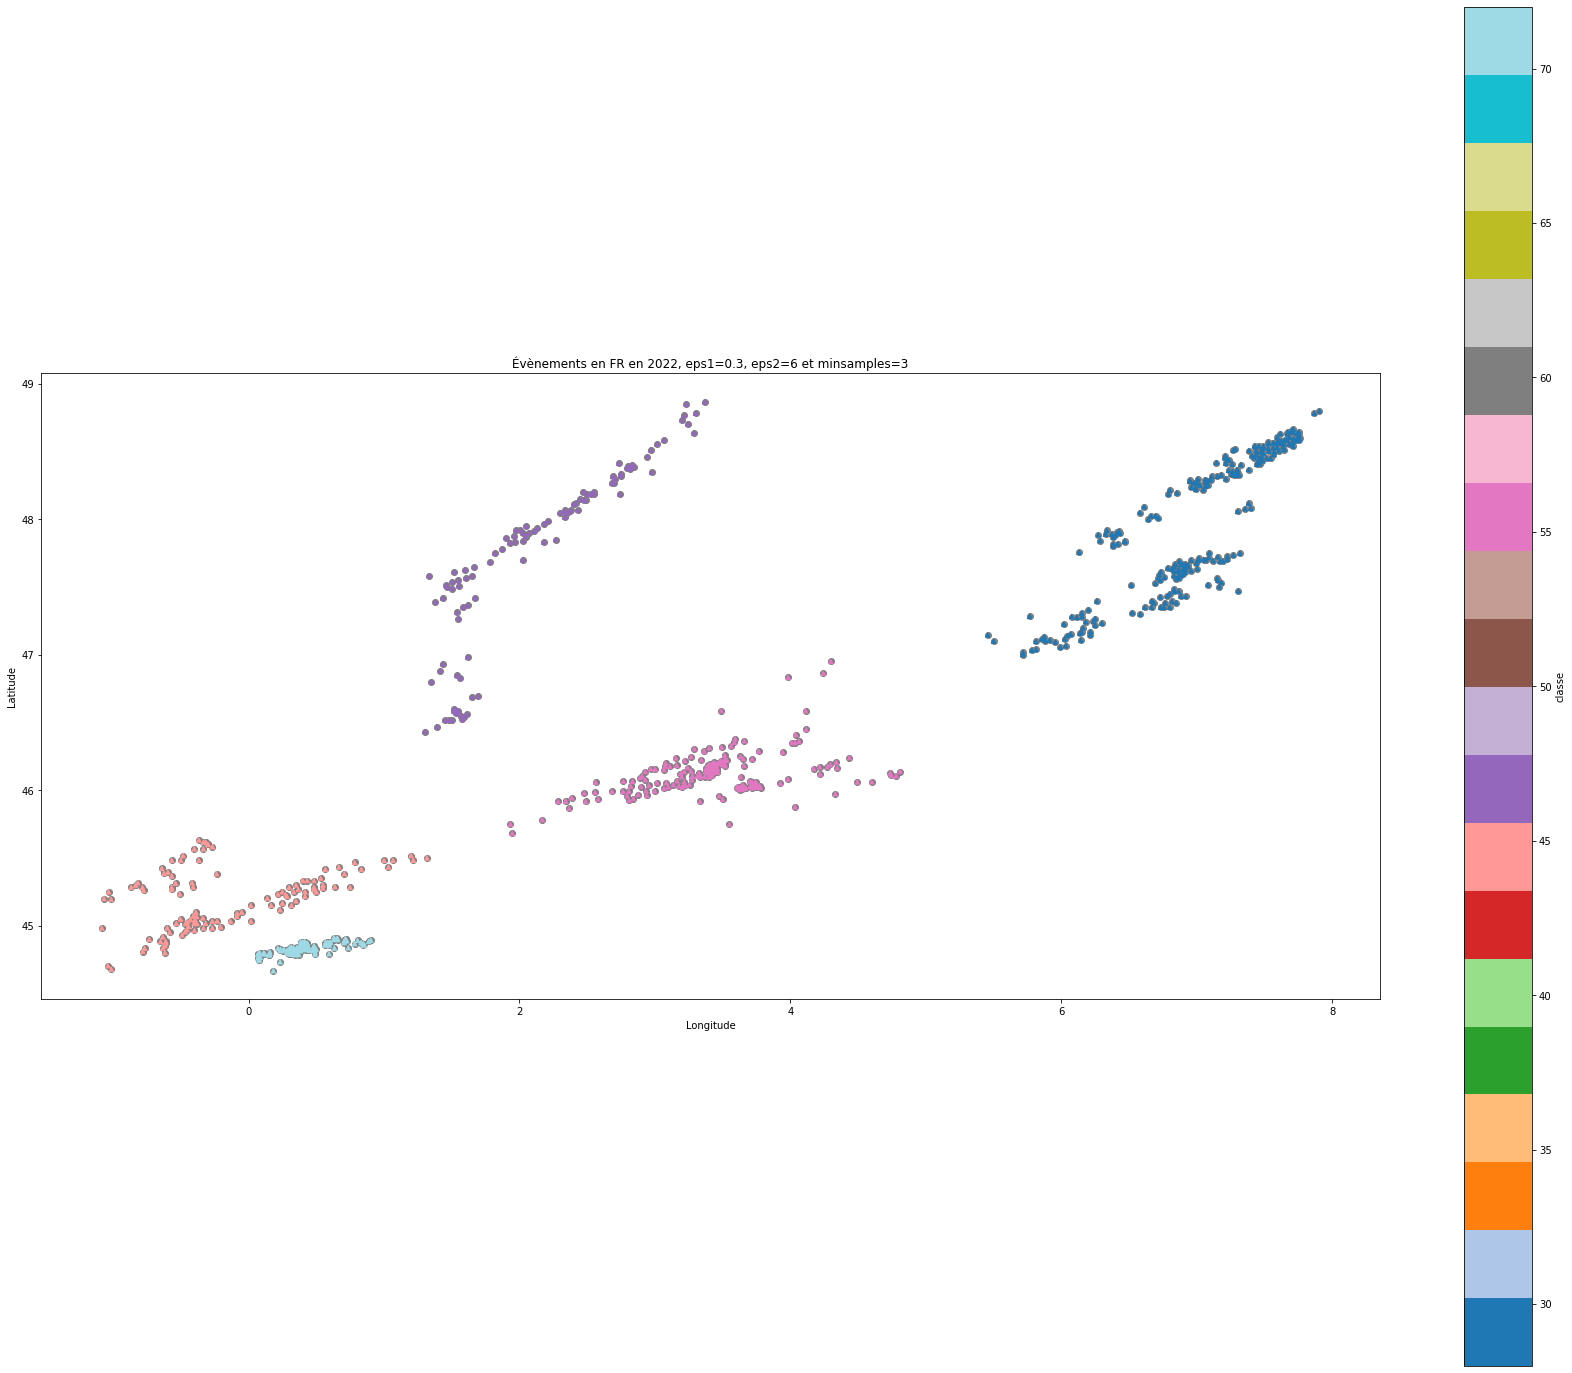

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            182       182        182      182
 29           110       110        110      110
 30           134       134        134      134
 46           113       113        113      113
 48           105       105        105      105
 56           188       188        188      188
 73           120       120        120      120


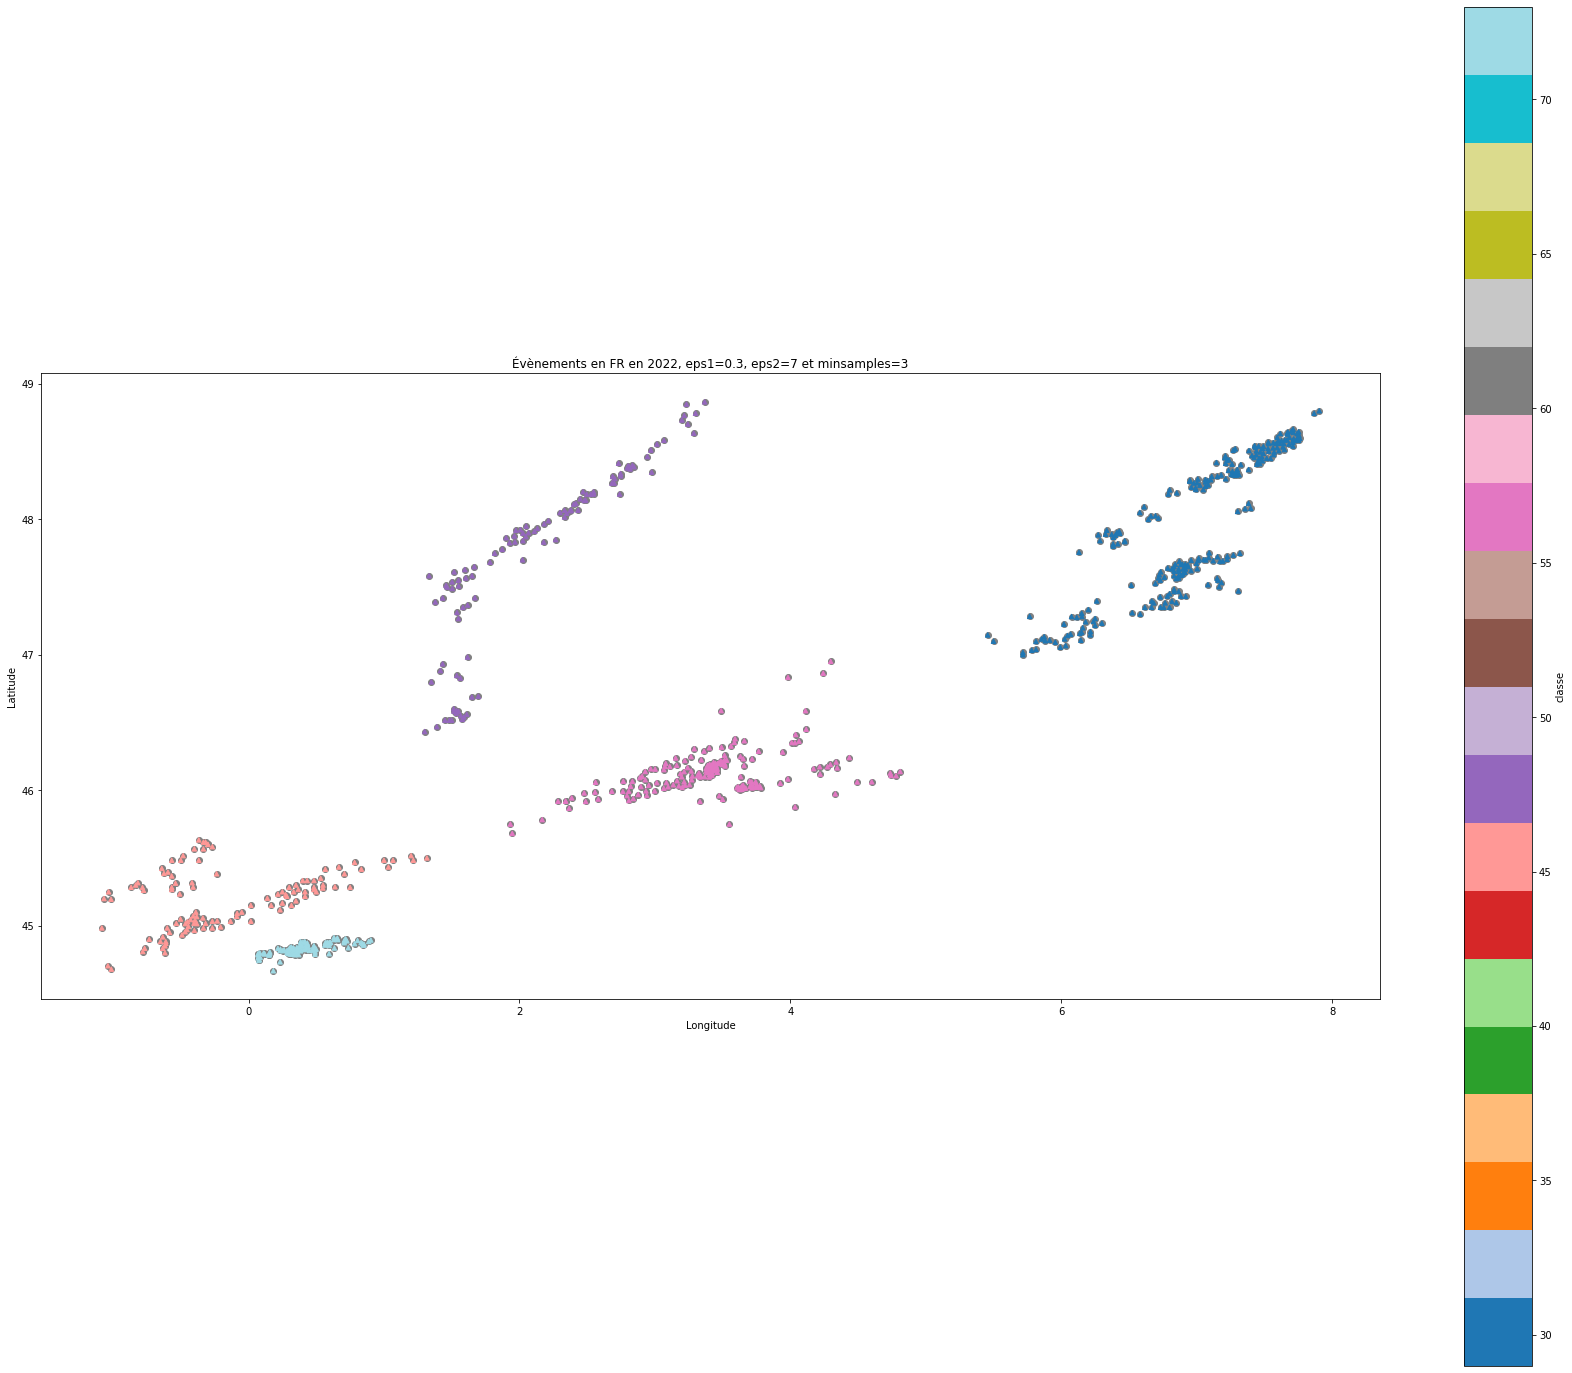

In [58]:
x="FR"

for i in range(1 ,8 ):
    
    clusterise_country_year(x, 2022, 0.3, i, 3)

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
40             67        67         67       67
43            103       103        103      103
66             73        73         73       73
69             41        41         41       41
90            110       110        110      110
115           118       118        118      118


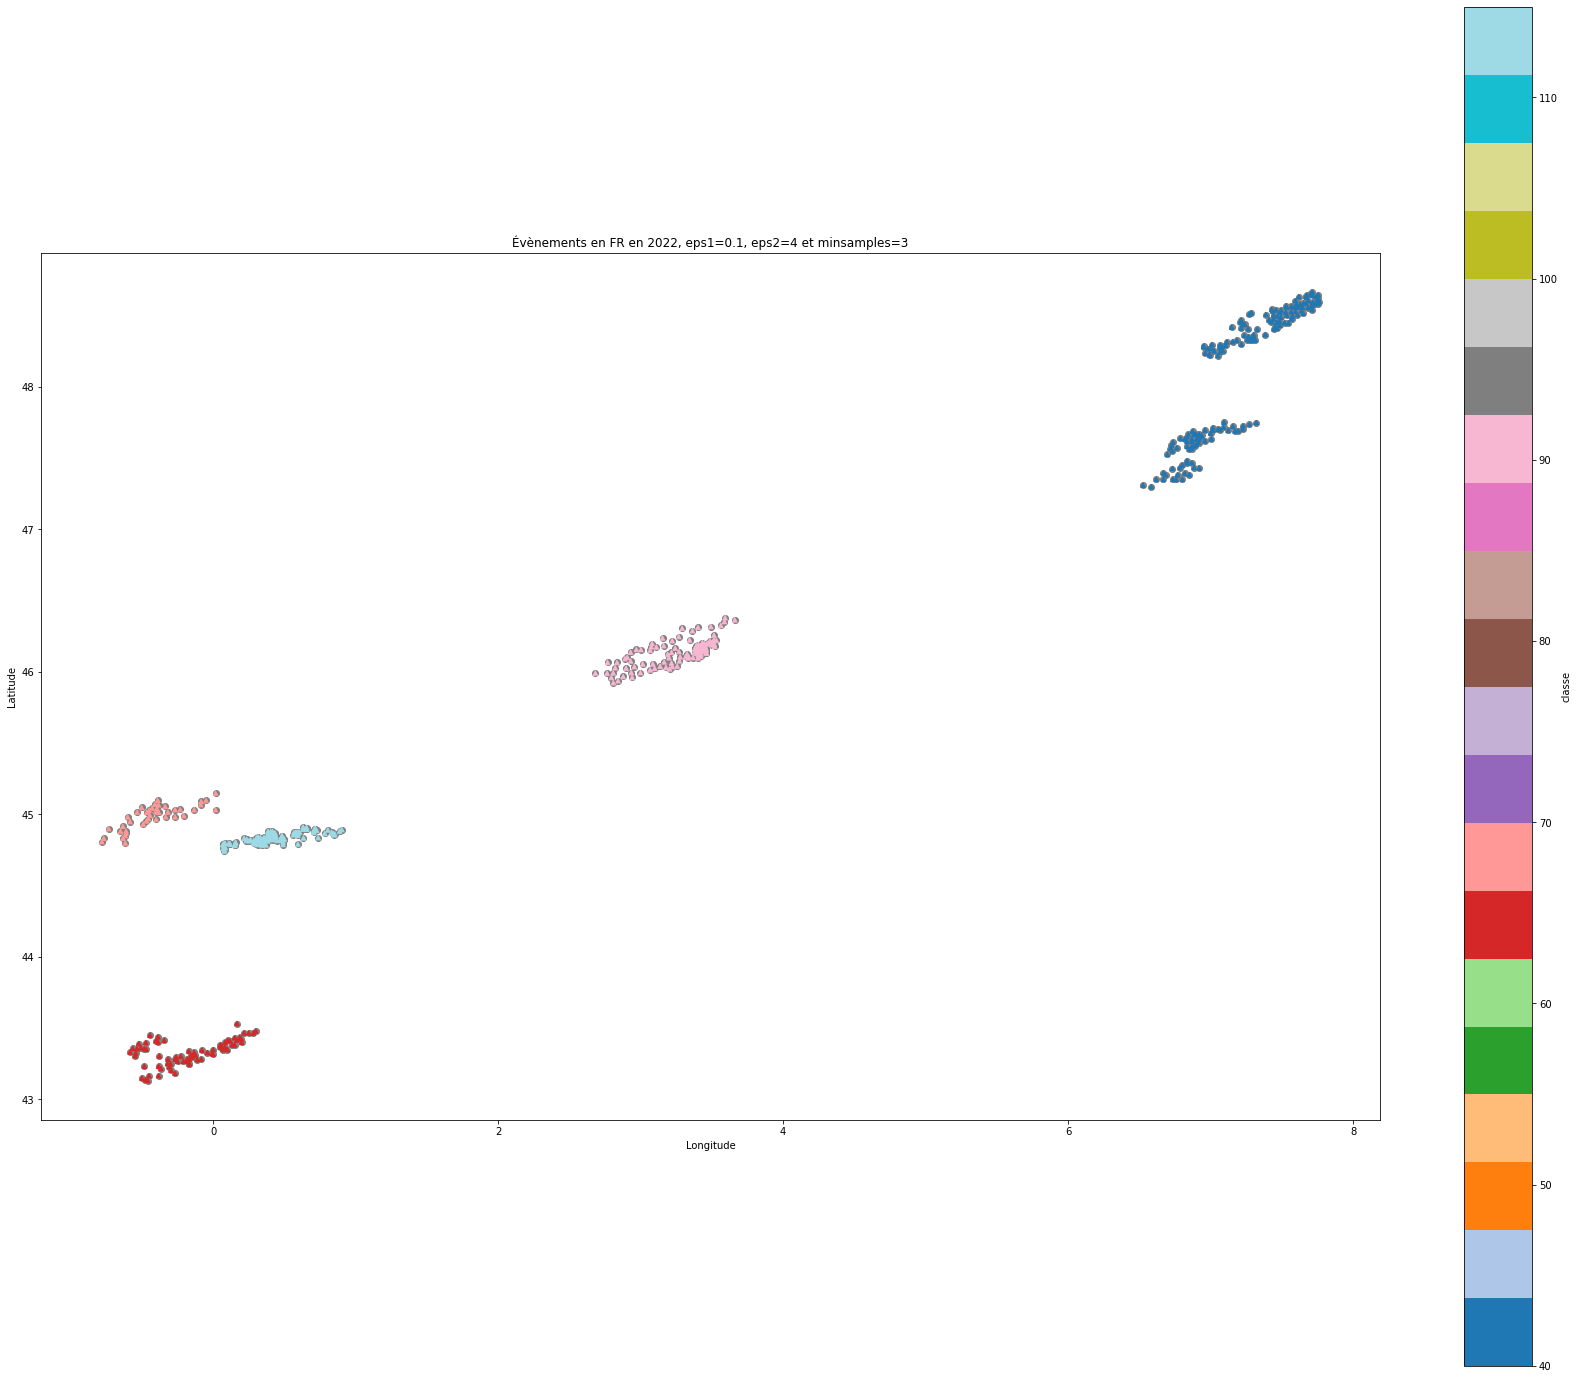

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
32             74        74         74       74
35            114       114        114      114
55            110       110        110      110
56             76        76         76       76
58             76        76         76       76
67            165       165        165      165
85            118       118        118      118


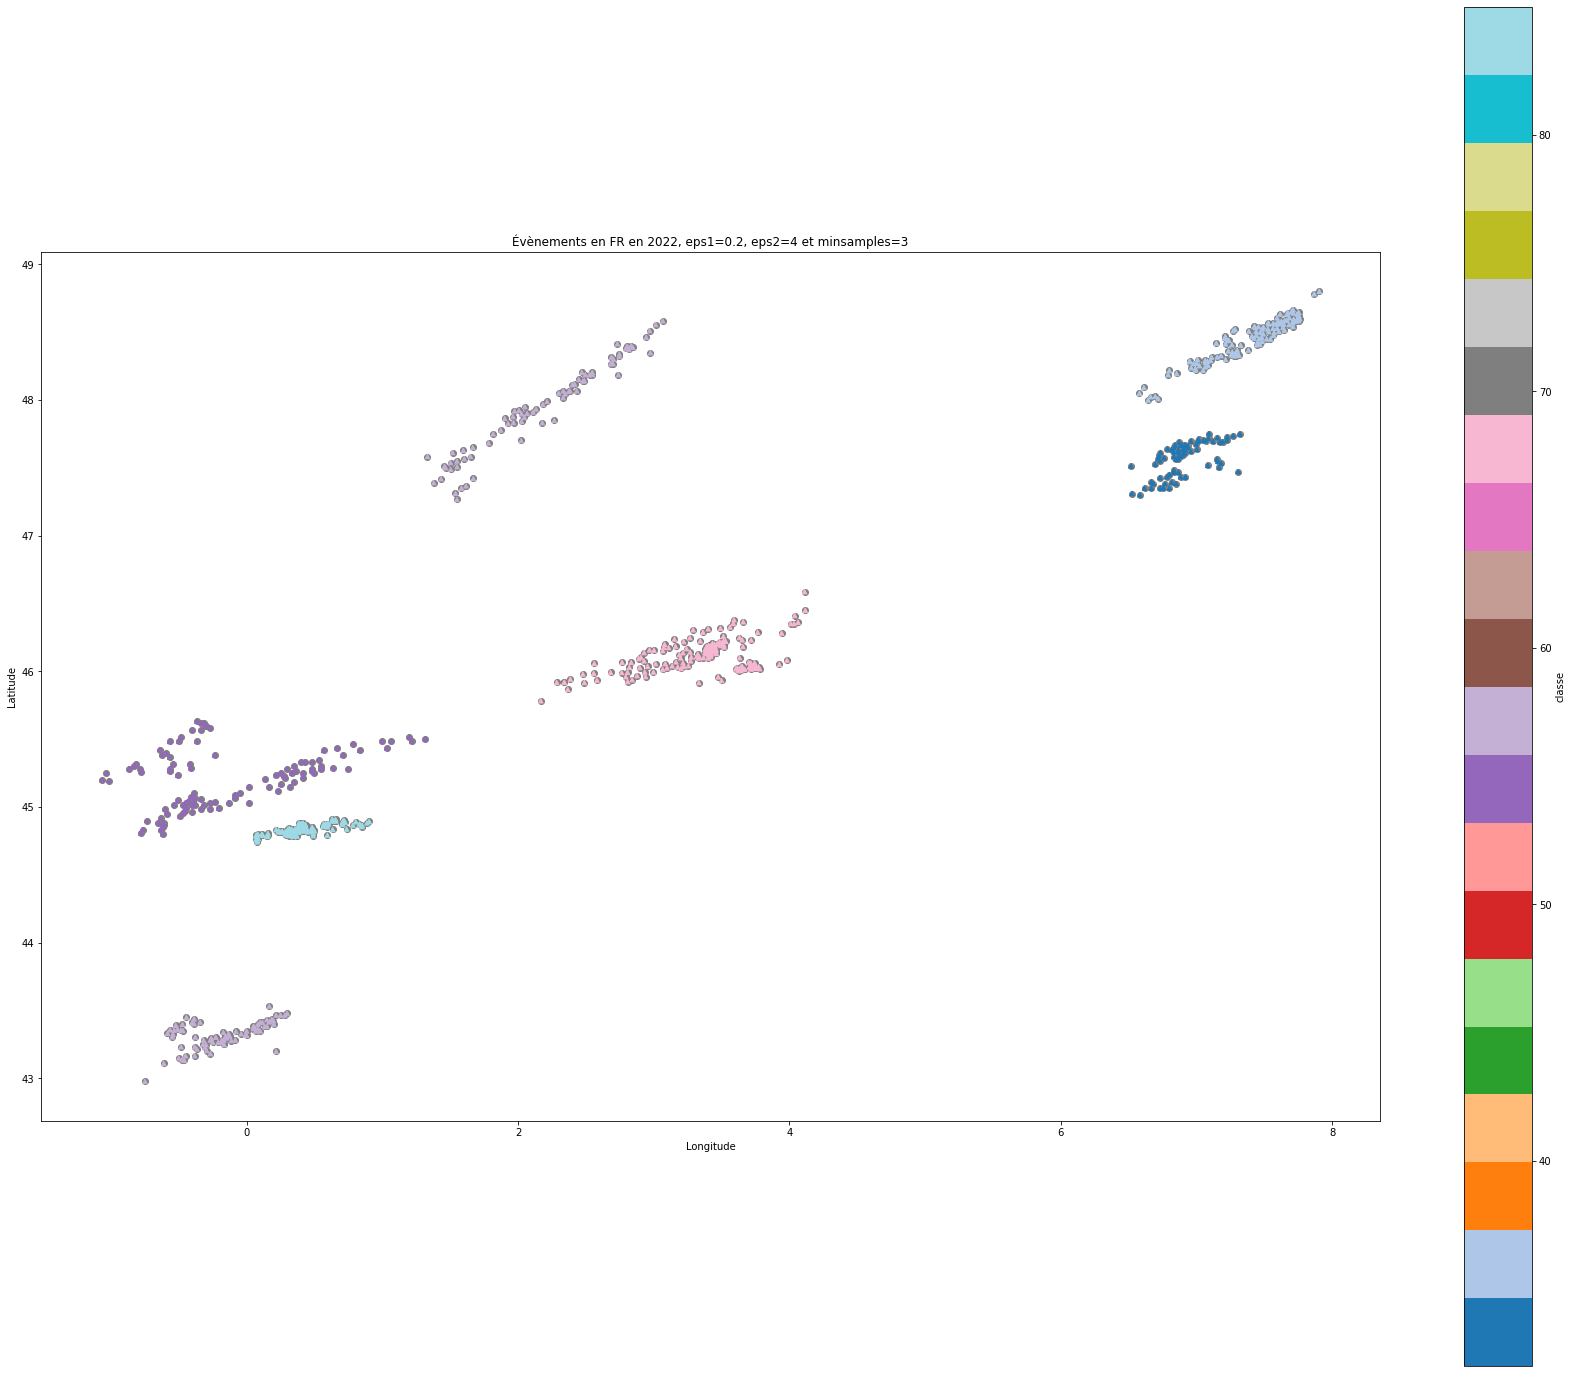

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            185       185        185      185
 28           110       110        110      110
 29           134       134        134      134
 45           113       113        113      113
 47           105       105        105      105
 55           188       188        188      188
 72           120       120        120      120


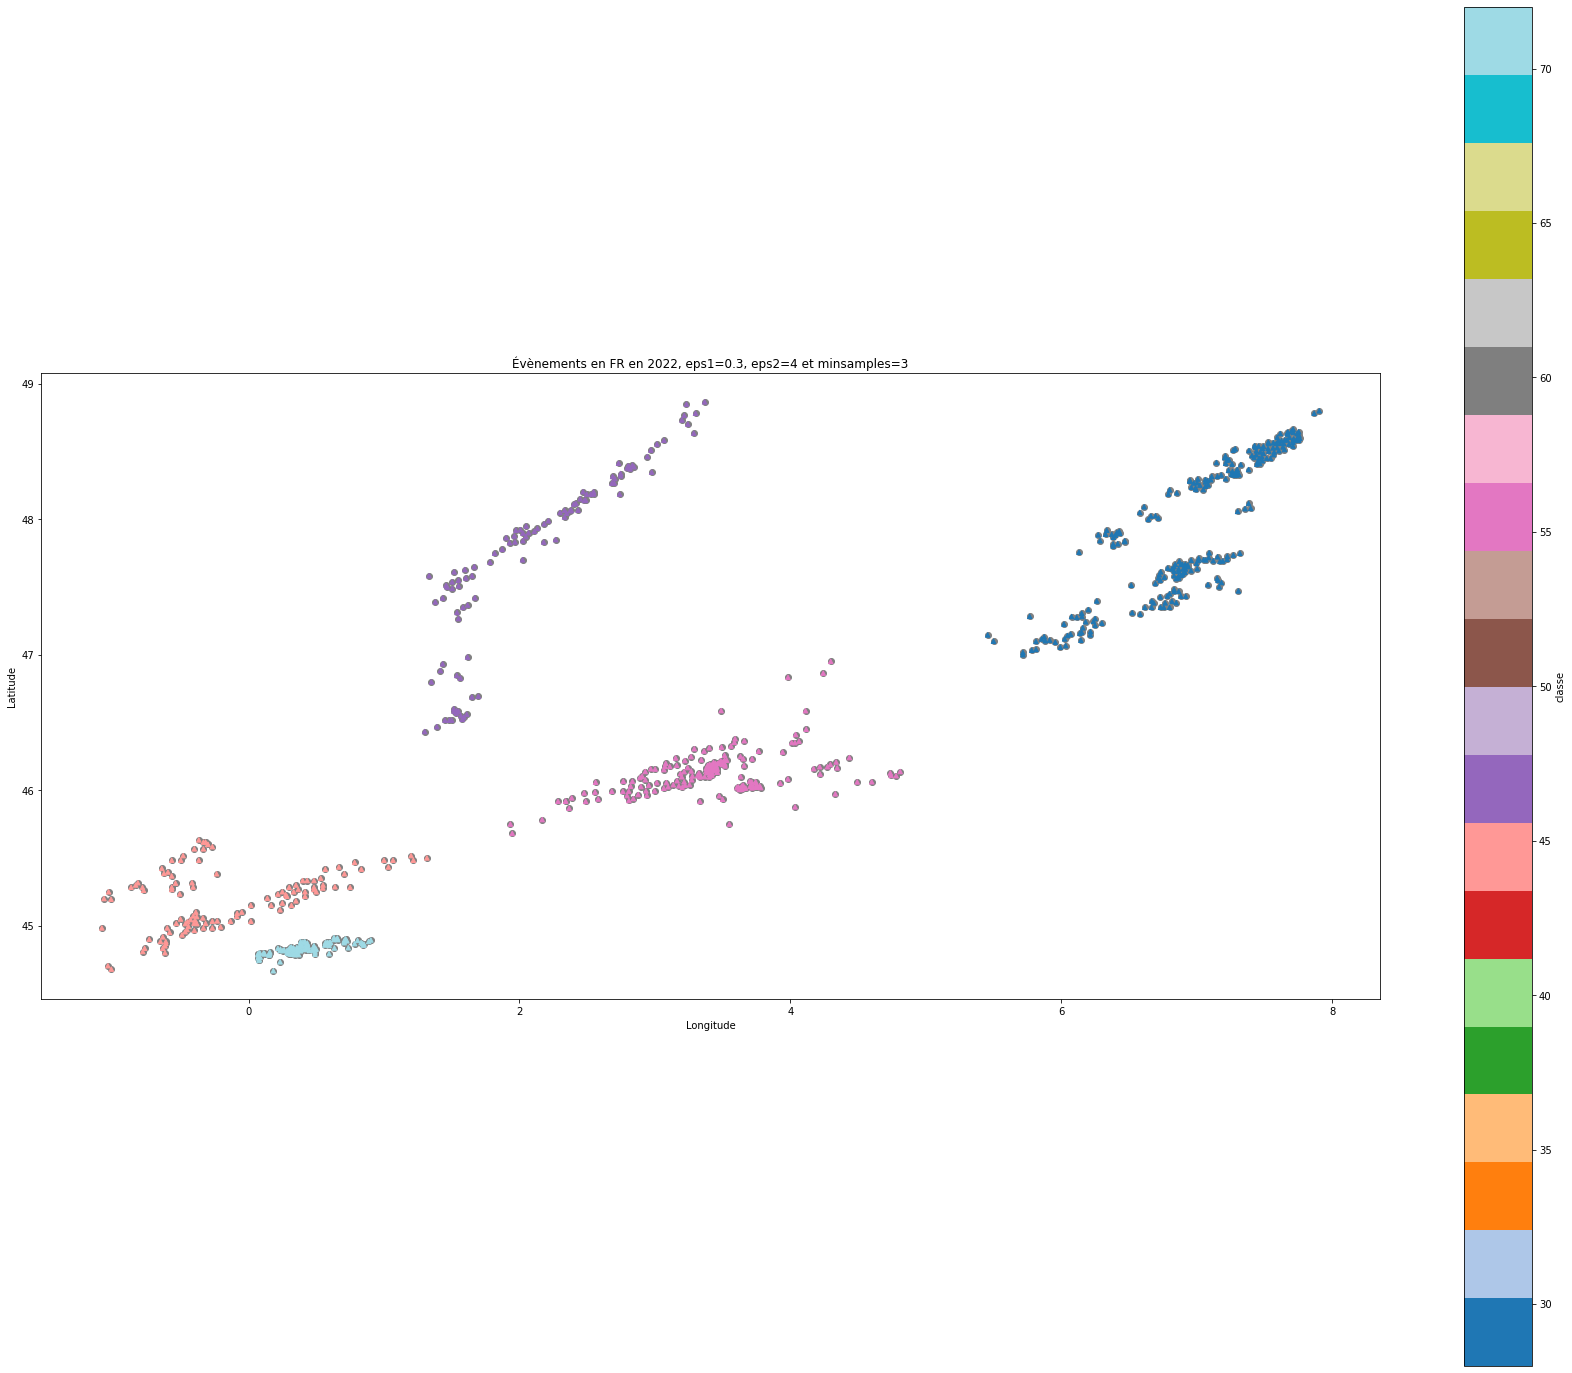

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            153       153        153      153
 27           244       244        244      244
 43           114       114        114      114
 44            76        76         76       76
 45           125       125        125      125
 52           190       190        190      190
 68           120       120        120      120


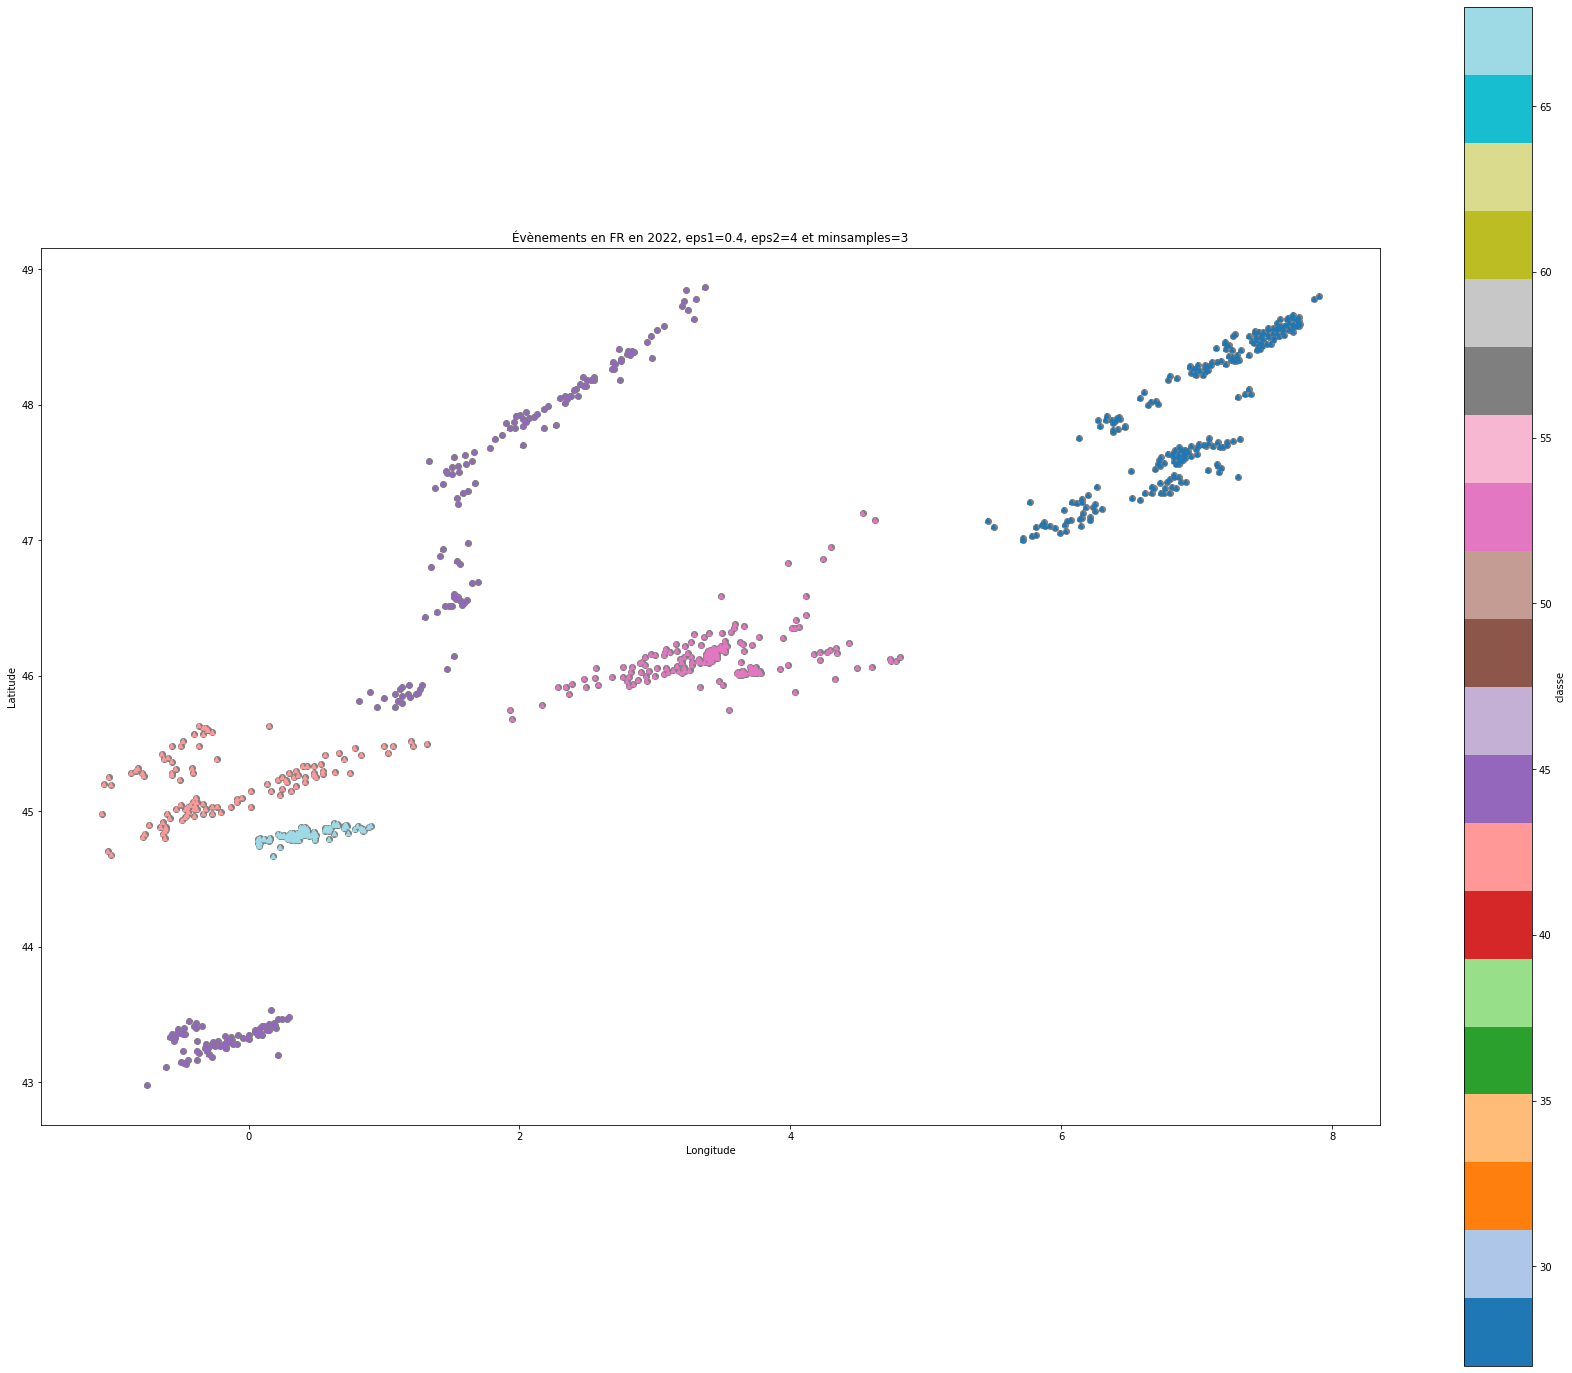

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            121       121        121      121
 28           244       244        244      244
 41           114       114        114      114
 42            76        76         76       76
 43           125       125        125      125
 51           204       204        204      204
 65           120       120        120      120


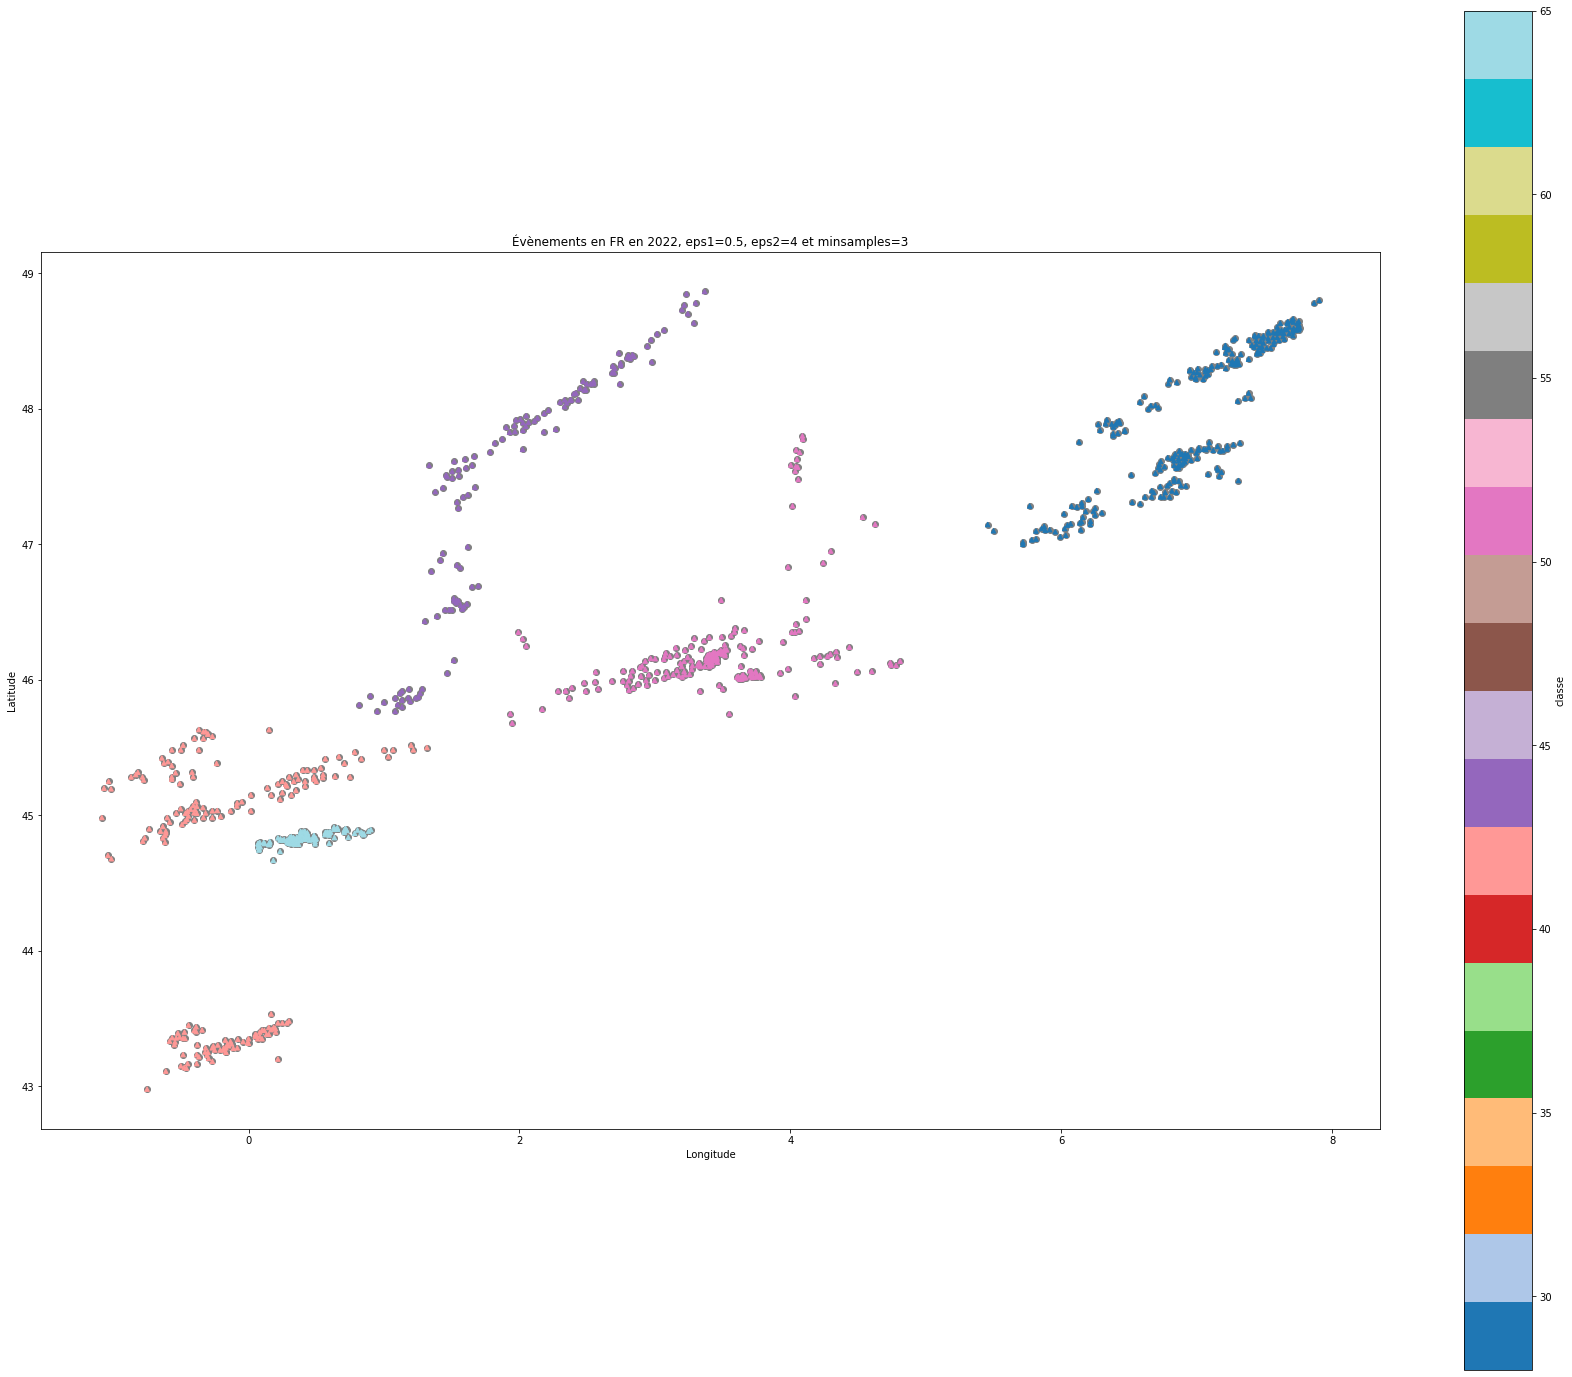

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            107       107        107      107
 27           244       244        244      244
 38           114       114        114      114
 40           131       131        131      131
 47           204       204        204      204
 60           120       120        120      120
 62            92        92         92       92


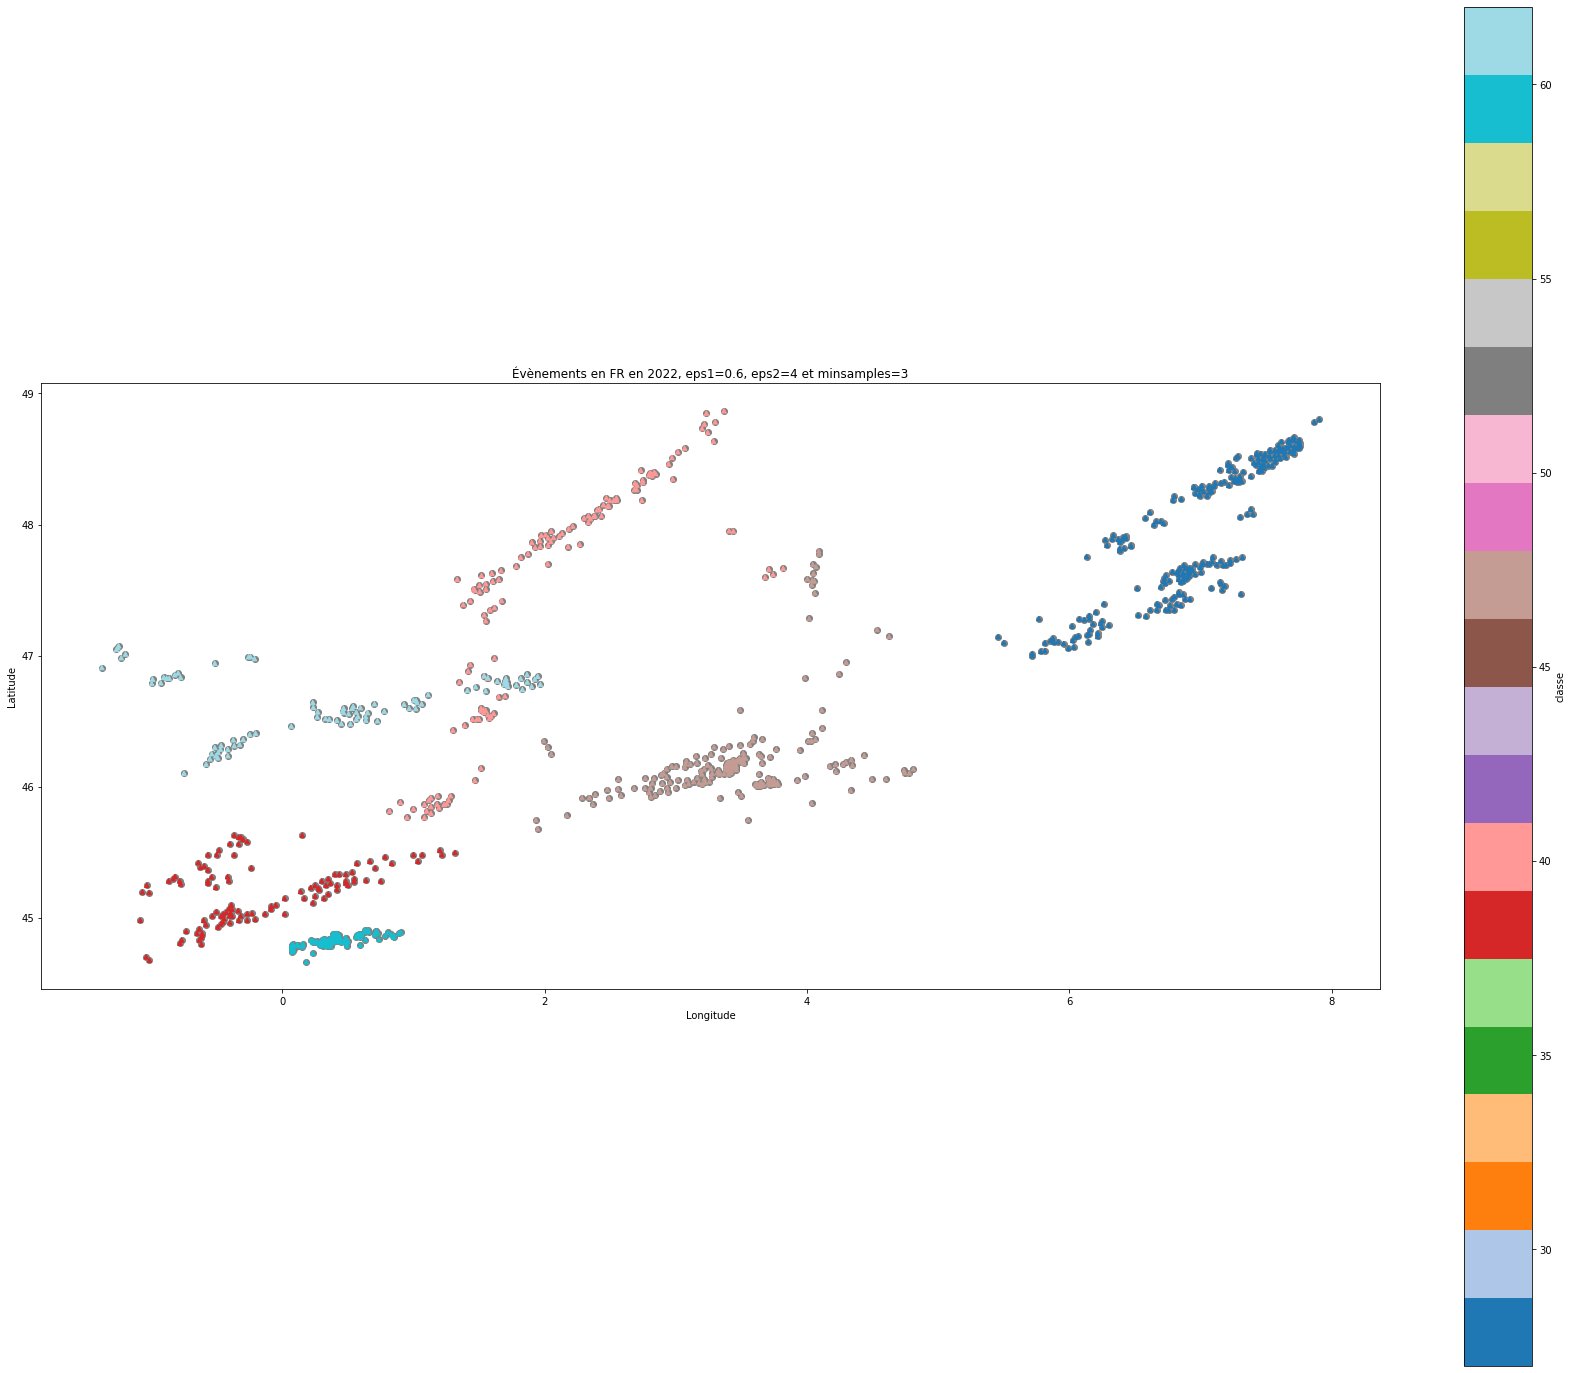

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             97        97         97       97
 26           244       244        244      244
 37           114       114        114      114
 39           131       131        131      131
 46           204       204        204      204
 60           120       120        120      120
 62            93        93         93       93


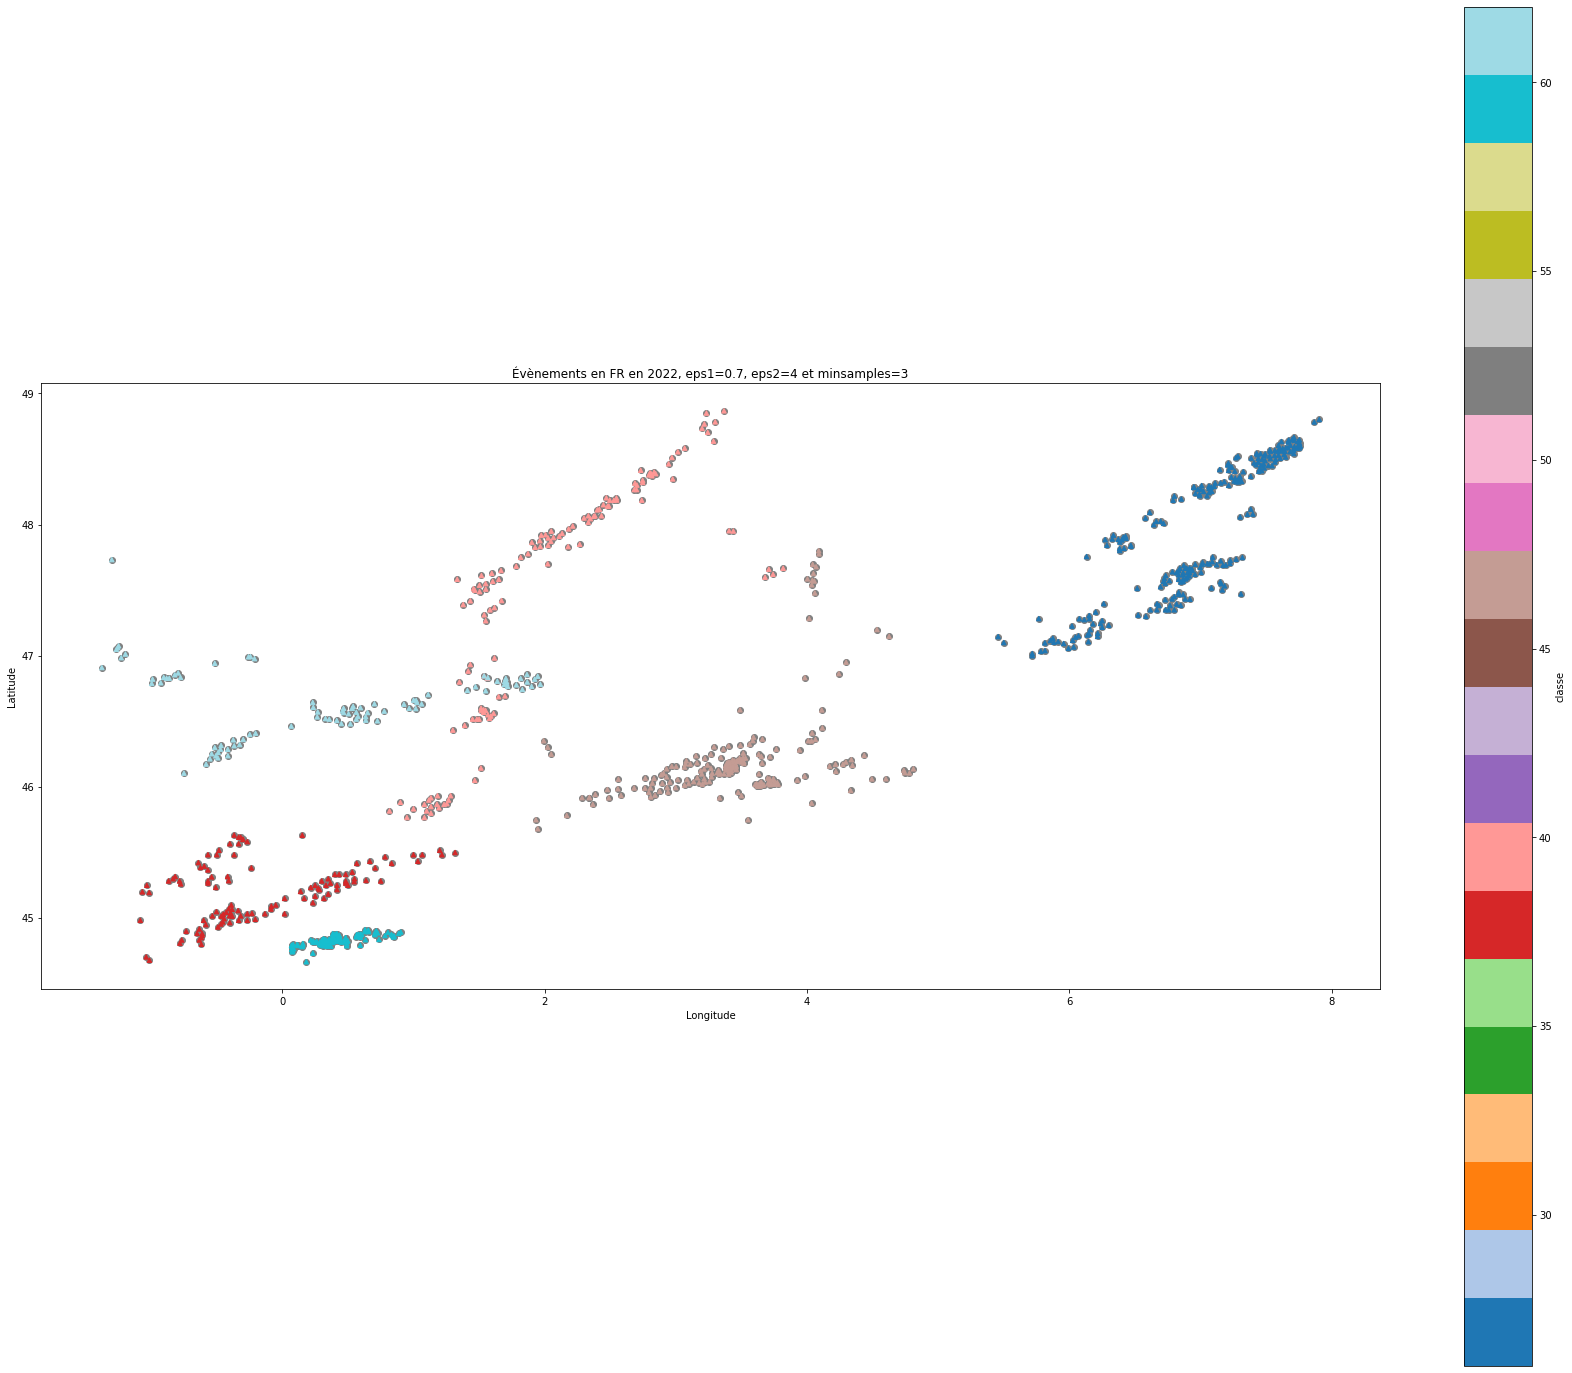

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
26            244       244        244      244
37            114       114        114      114
39            132       132        132      132
46            204       204        204      204
59            120       120        120      120
61            102       102        102      102


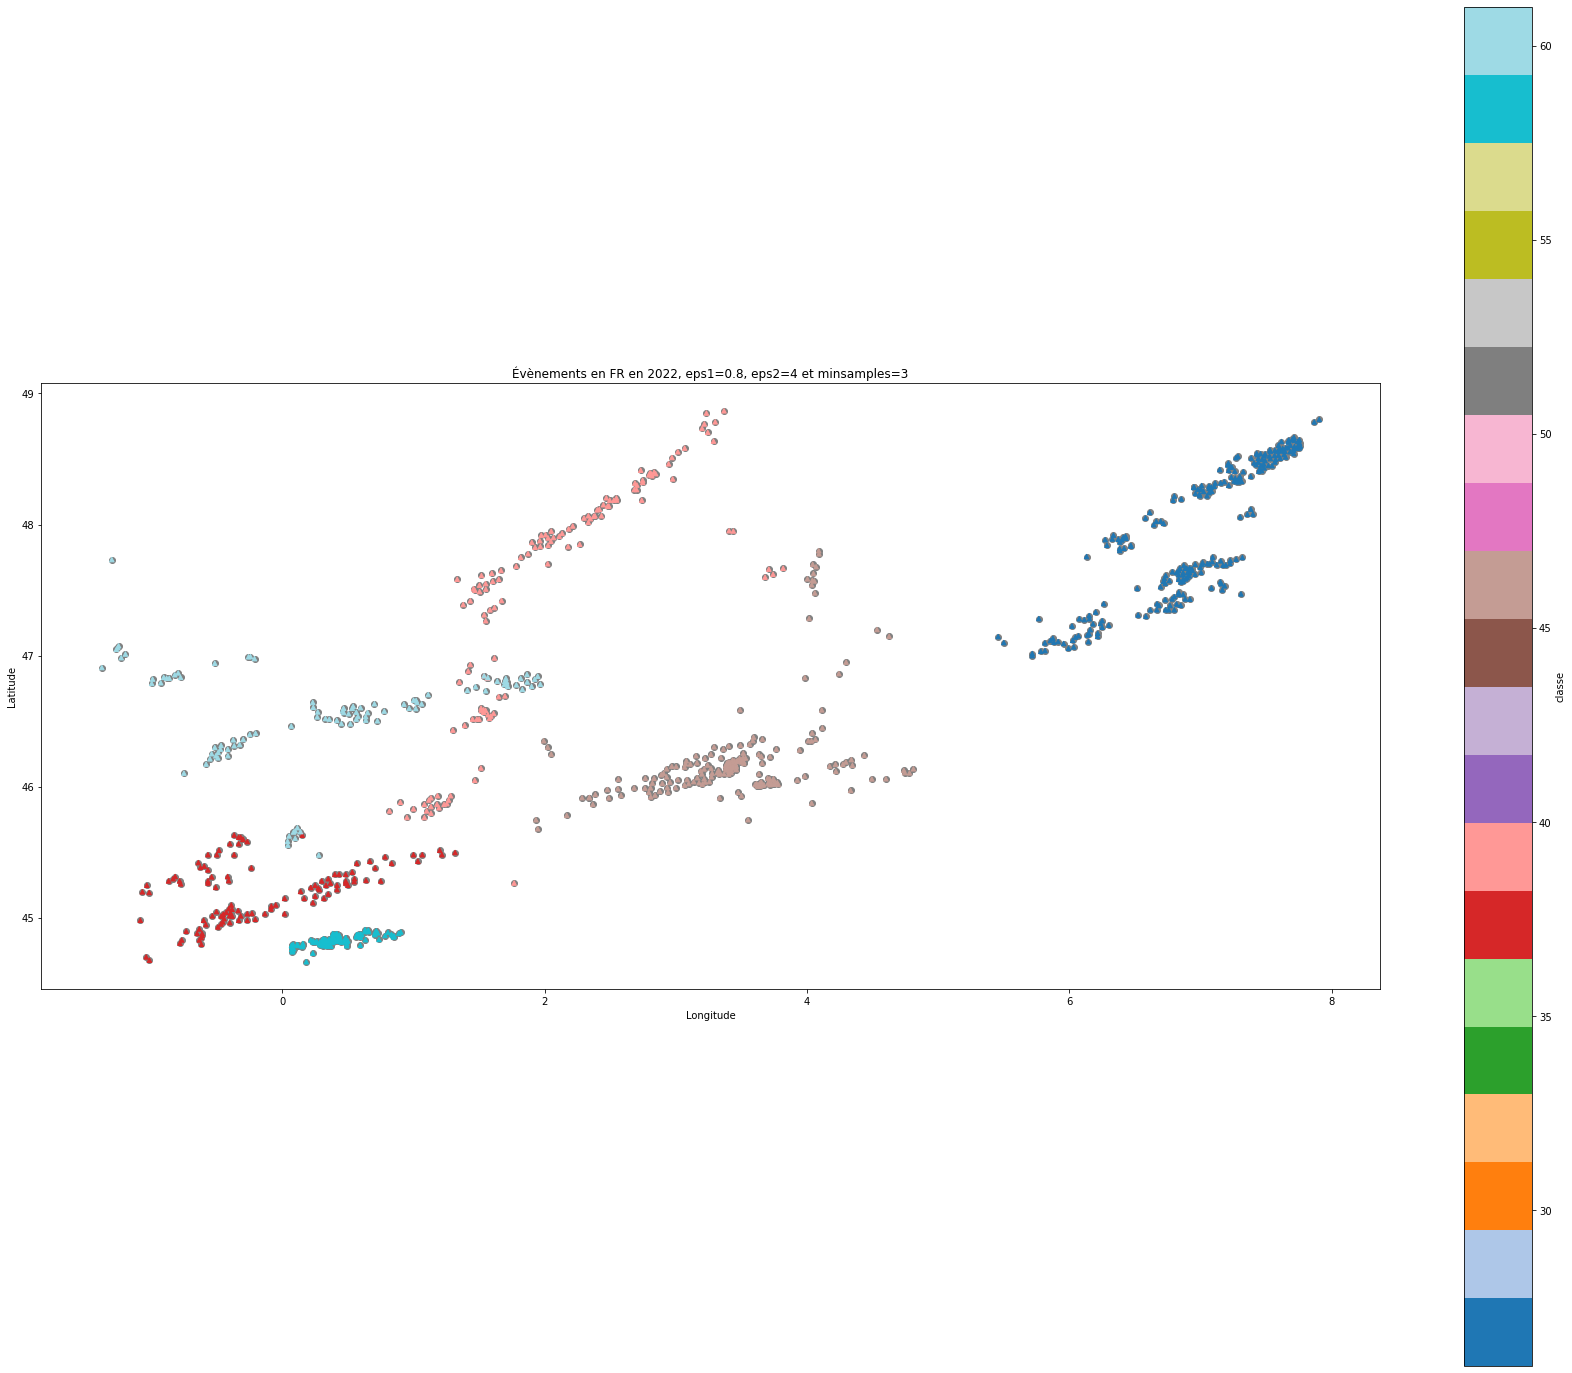

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
25            244       244        244      244
35            114       114        114      114
37            132       132        132      132
44            204       204        204      204
55            120       120        120      120
57            104       104        104      104


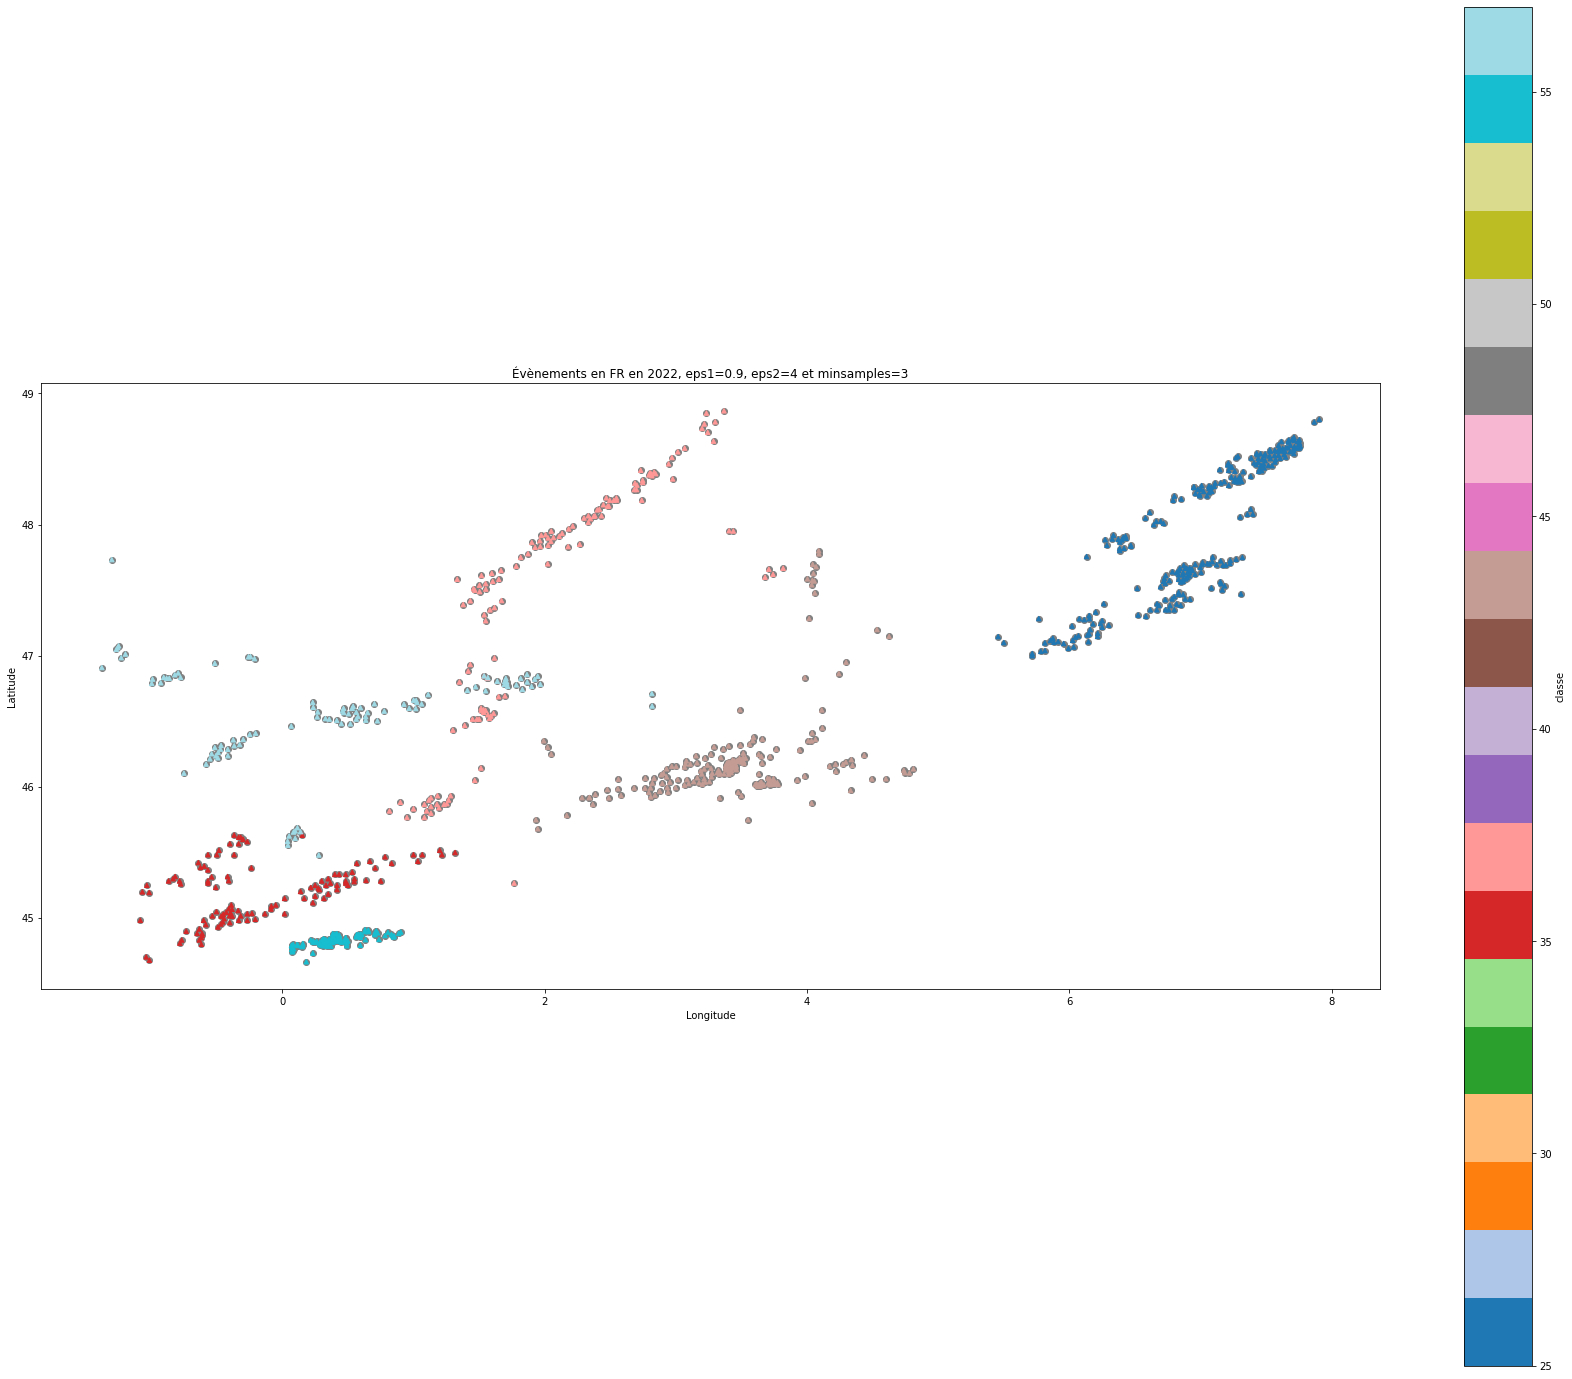

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
25            244       244        244      244
35            114       114        114      114
37            132       132        132      132
43            204       204        204      204
52            120       120        120      120
54            104       104        104      104


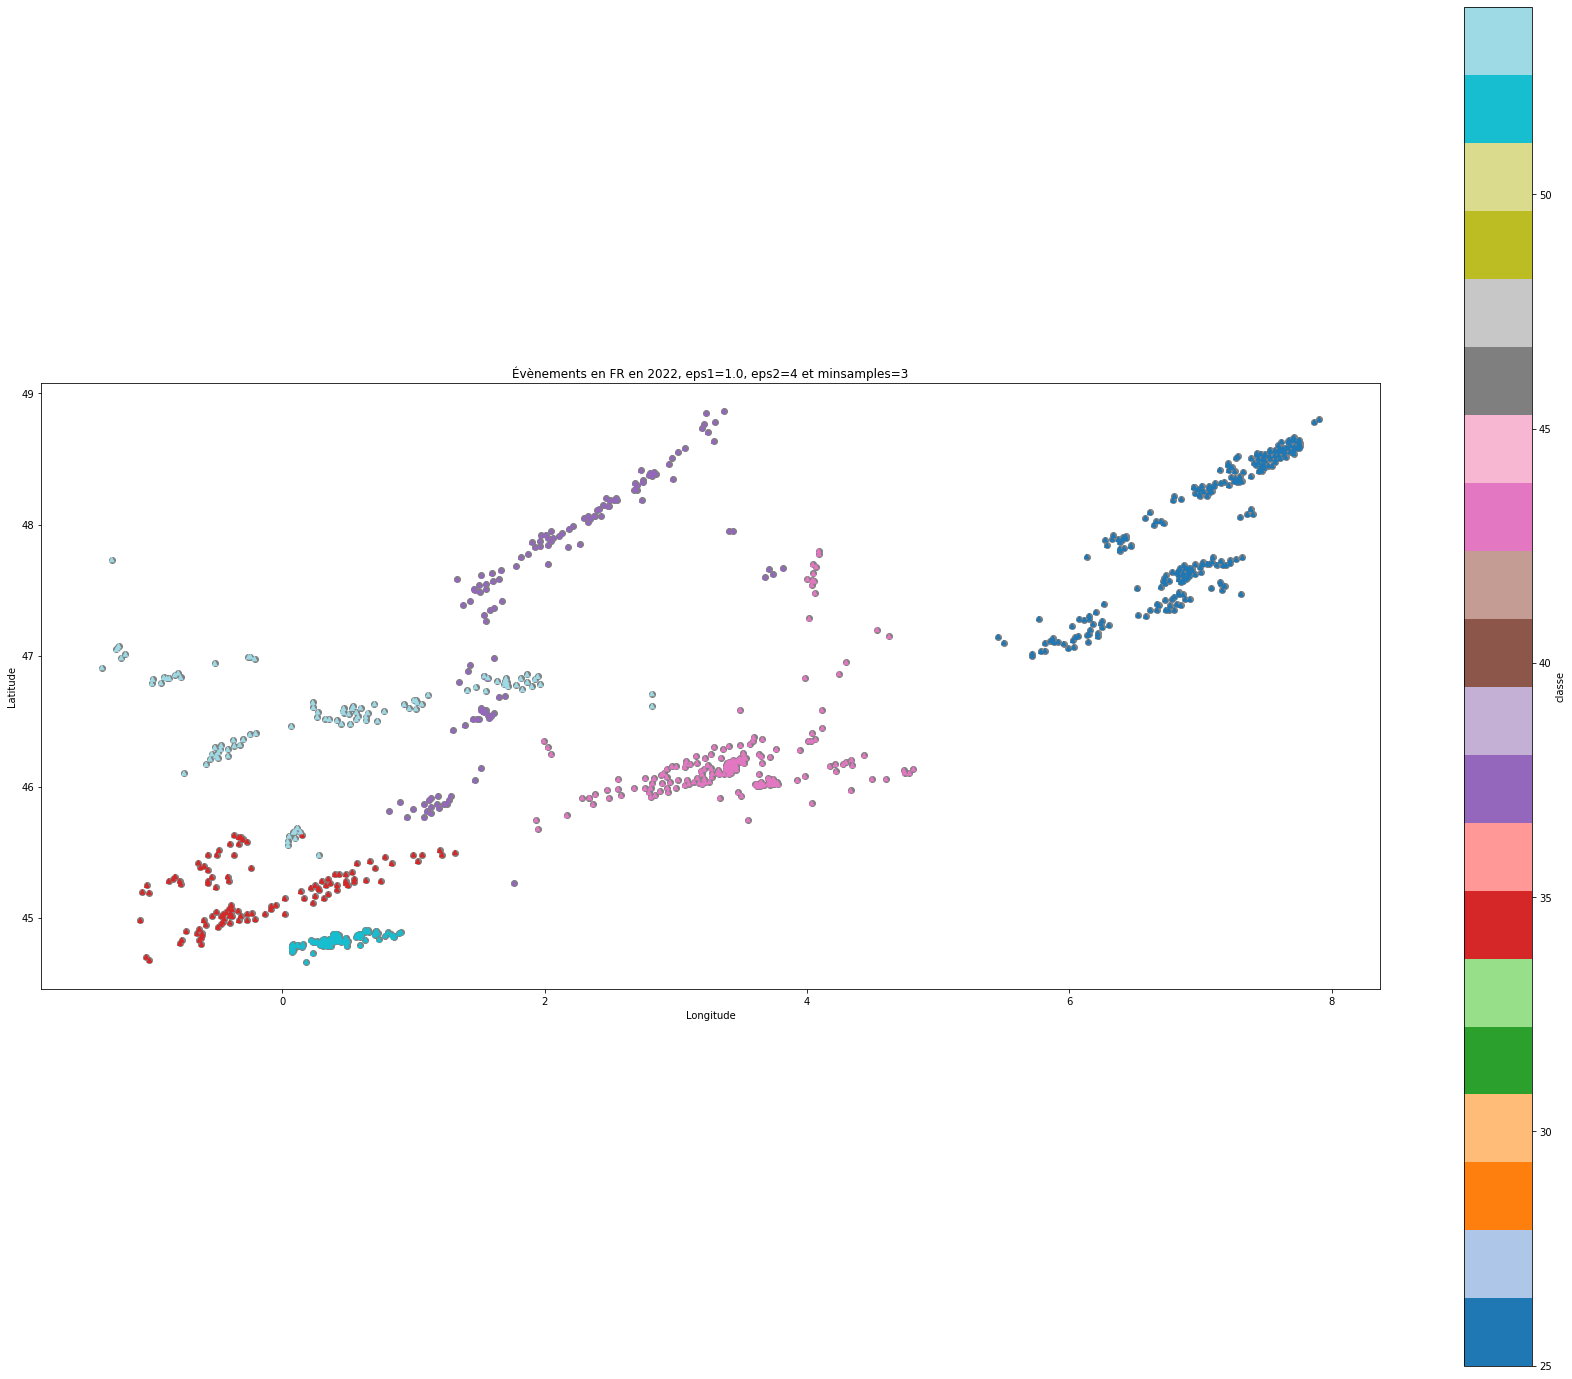

In [59]:
x="FR"

for i in range(1,11,1):
    y=i/10
    
    clusterise_country_year(x, 2022, y, 4, 3)

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             83        83         83       83
 42           244       244        244      244
 64           114       114        114      114
 65            76        76         76       76
 66           125       125        125      125
 77           190       190        190      190
 96           120       120        120      120


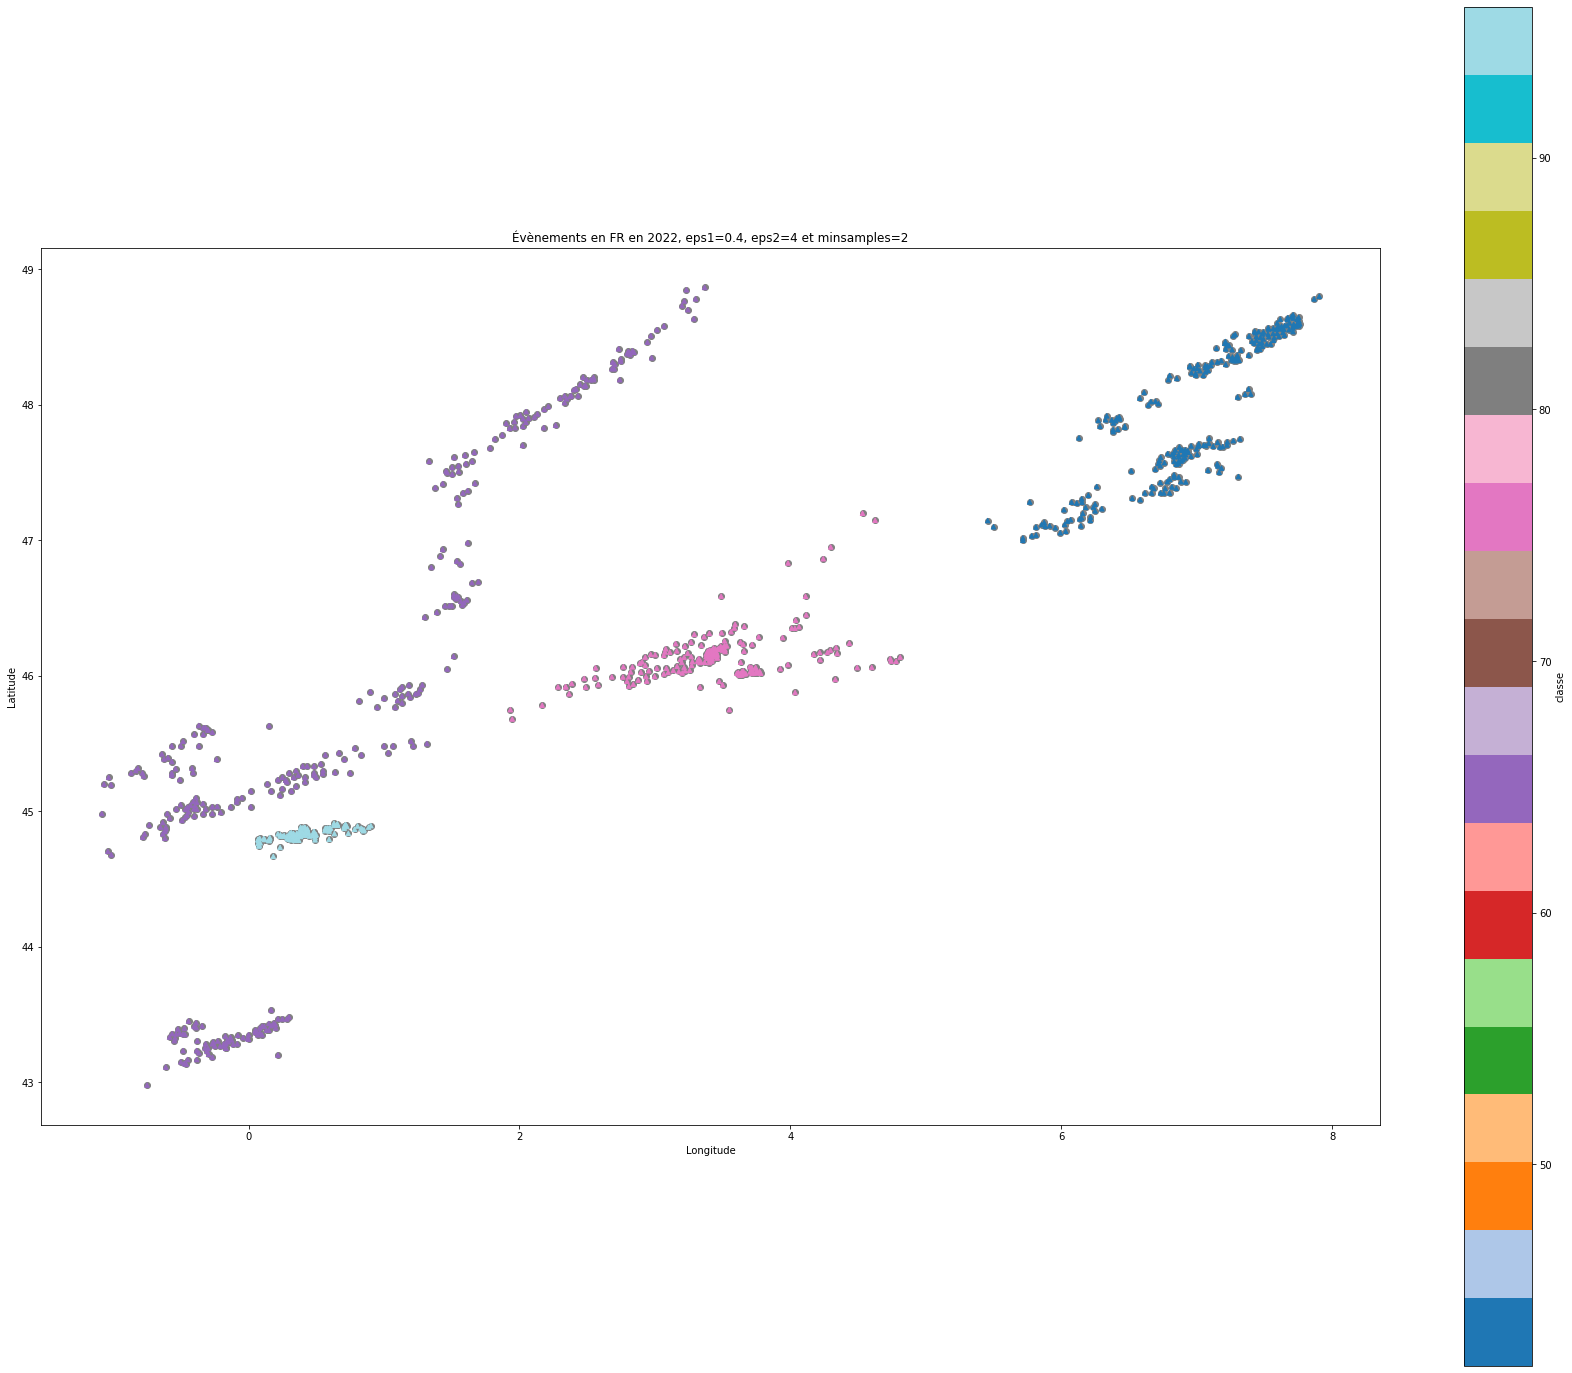

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            153       153        153      153
 27           244       244        244      244
 43           114       114        114      114
 44            76        76         76       76
 45           125       125        125      125
 52           190       190        190      190
 68           120       120        120      120


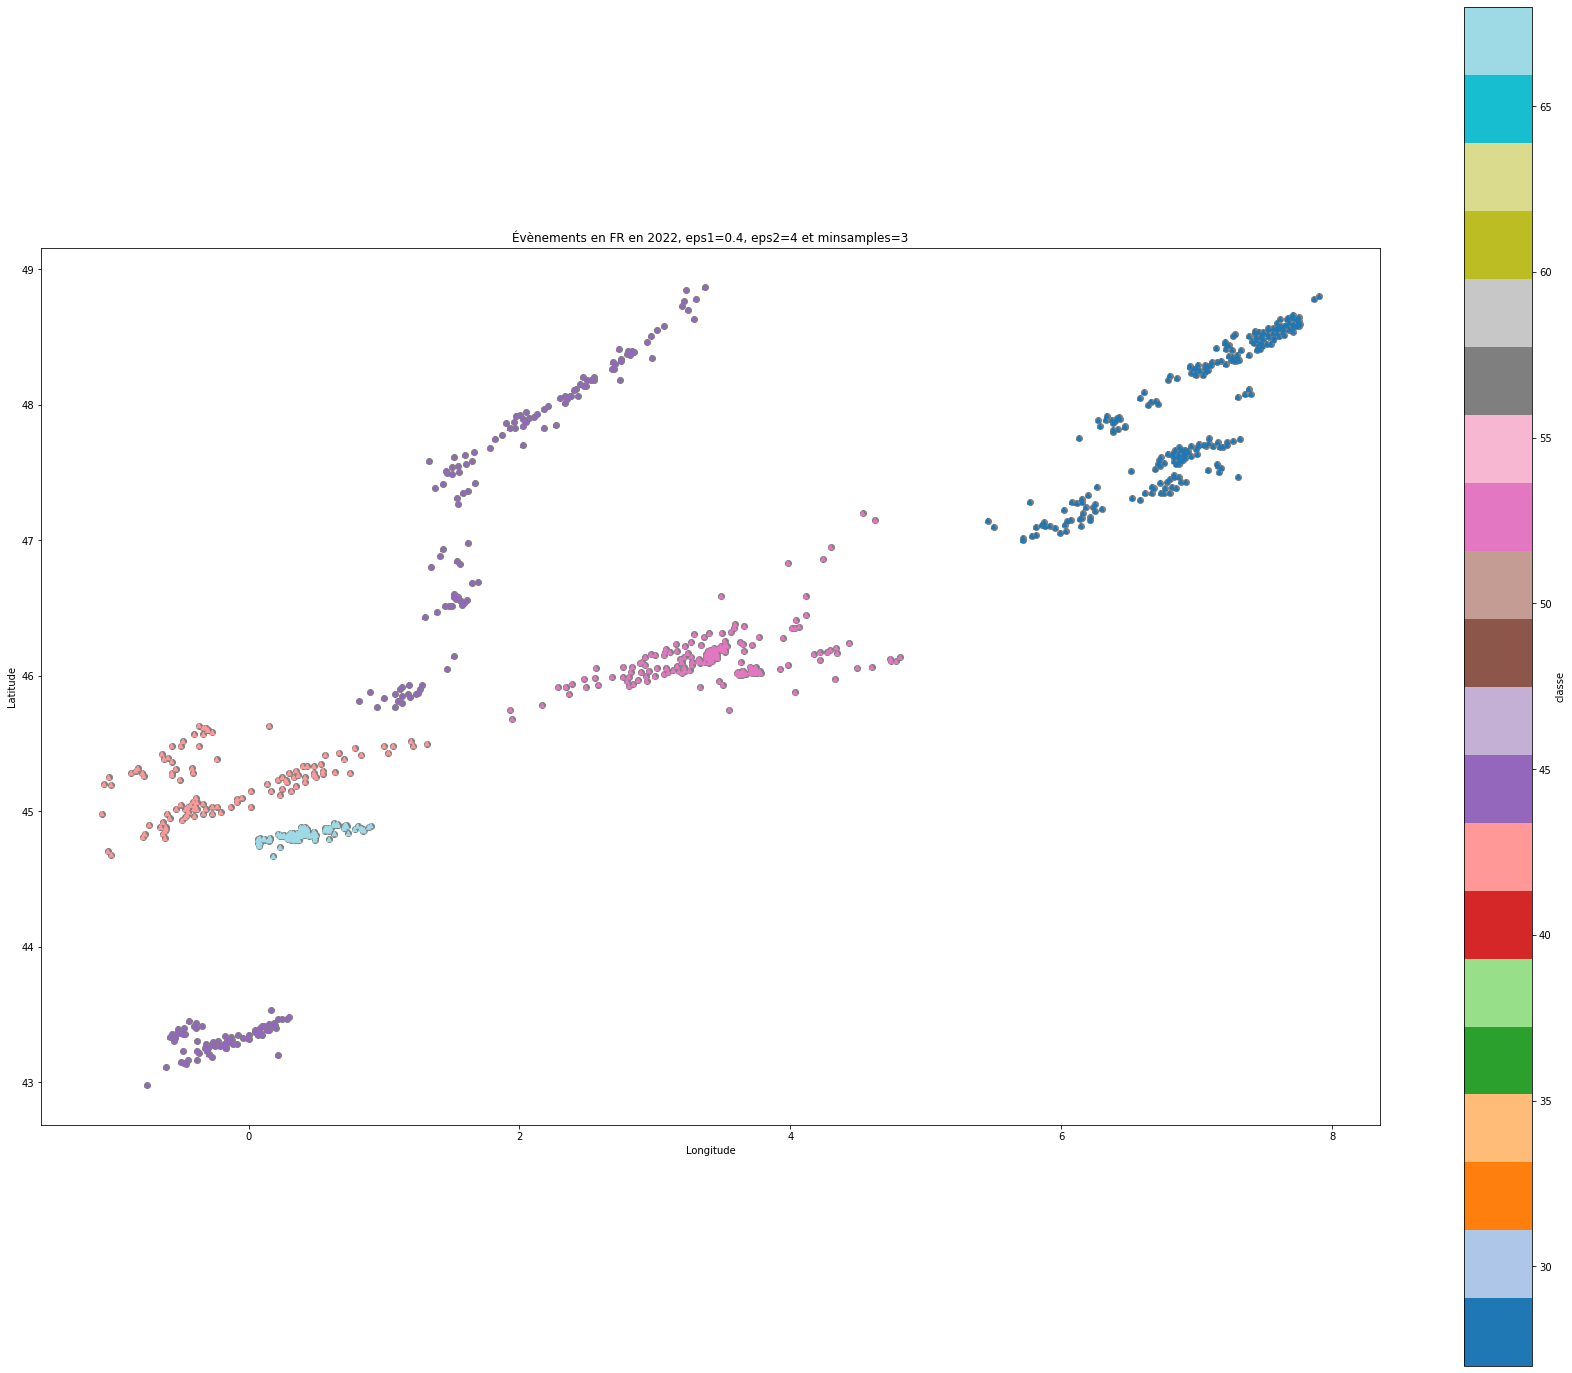

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            198       198        198      198
 21           244       244        244      244
 35           114       114        114      114
 36            76        76         76       76
 37           125       125        125      125
 43           189       189        189      189
 56           120       120        120      120


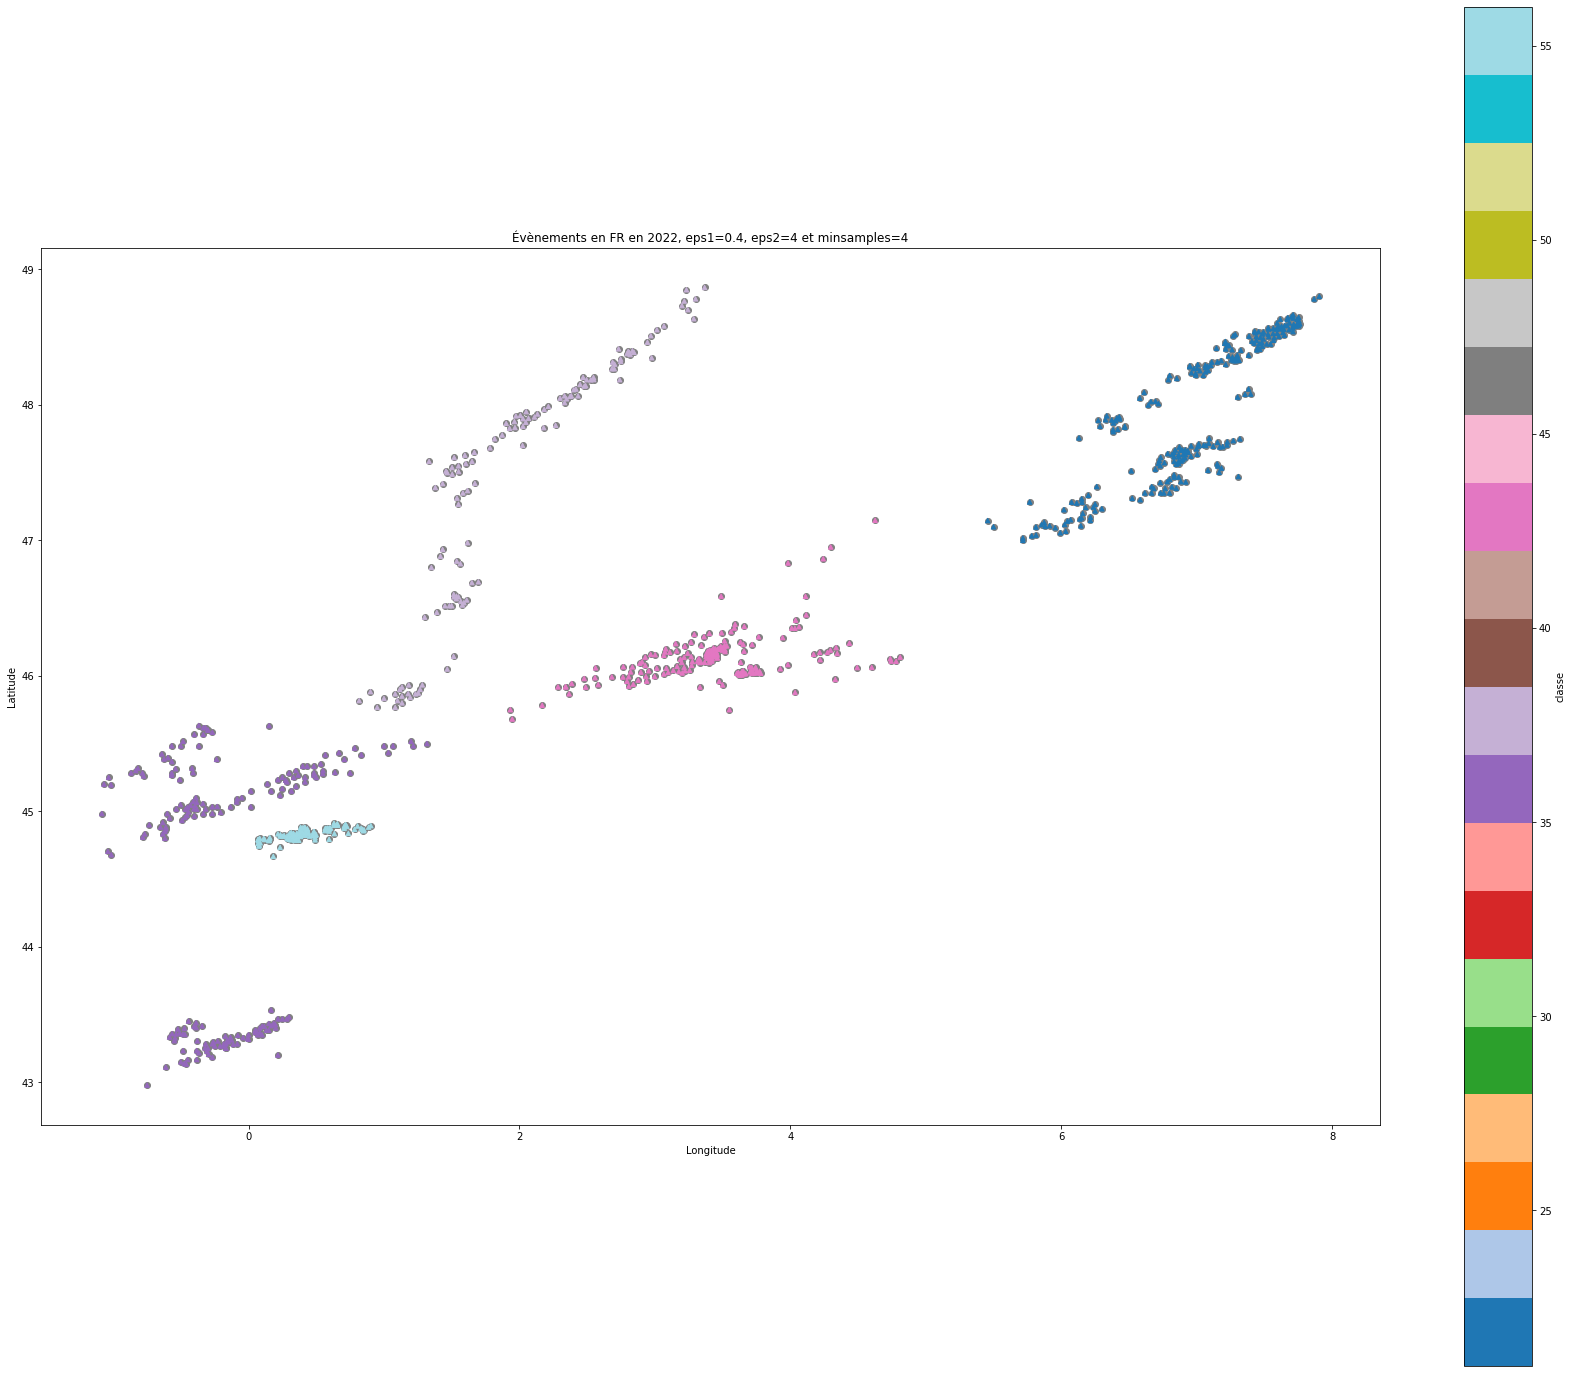

In [60]:
x="FR"

for i in range(2,5):    
    clusterise_country_year(x, 2022,0.4, 4,i)

In [61]:
for i in range(20013,2022):
    clusterise_per_year(i,0.3, 1,3)

In [ ]:
# plot with intensity as time_hour like only the tracks with most reports
# add other elements helping to tune (like percentage of total reports clustered in classe -1)
# try to clusterise for many parameters eps2 and take the reunion of classe 1 deprived from its intersection


In [226]:
x="PL"
df_clst=df[df['YEAR']==2022]
df_clst=df_clst[df_clst['COUNTRY']==x]
df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)        
#bdd finale à utiliser
df_clst=df_clst.loc[:,['TIME_HOUR','LATITUDE','LONGITUDE']]
df_clst1=df_clst.copy()
model = ST_DBSCAN(eps1=0.3, eps2=3,min_samples=3)
model.fit(df_clst1)
df_clst1["cluster"] = model.fit(df_clst)
classi = model.labels
events= clust(df_clst1,classi)
df_clst1["classe"]=classi
print(events[0])

#c=df_clst['LATITUDE'][209]
#print(c)
#r=df_clst['LATITUDE'].iloc[5]
#print(len(df_clst))
#print(r)   
print(df_clst1['classe'].iloc[393])
k=df_clst1.groupby(['classe']).count()
k=k[(k['LATITUDE']>8)&(k['LATITUDE']<50)]
print(k)

[0, 1, 2, 3, 4, 5, 10, 11, 12, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 31, 35, 41, 42, 47, 48, 49, 50, 51, 60, 61, 75, 77, 83, 85, 108, 114, 118, 132, 142, 144, 152, 154, 160, 165, 167, 170, 178, 181, 186, 190, 204, 205, 215, 216, 226, 246, 290, 291, 295, 296, 301, 302, 303, 331, 332, 333, 334, 335, 336, 337, 338, 359, 360, 364, 365, 373, 387, 388, 389, 390, 391, 392, 393, 394, 395, 399, 400]
-1
        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
9              41        41         41       41
20             10        10         10       10
24             24        24         24       24
25             10        10         10       10
28             29        29         29       29
33             22        22         22       22
42             10        10         10       10


In [ ]:
eps1=0.3 ou 0.4
eps2=1 ou 2
minpt=2 ou 3

In [65]:
def clusterise_country_year_2(country, year, ep1, ep2, minpts, nmbr_plot):
    
    # extraction des données nécessaires 
    country=str(country)
    df_clst=df[df['YEAR']==year]
    df_clst=df_clst[df_clst['COUNTRY']==country]
    
    #conversion de la date en heures
    df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)
    
    #bdd finale à utiliser
    df_clst=df_clst.loc[:,['TIME_HOUR','LATITUDE','LONGITUDE']]
    
    # application de st dbscan
    df_clst1=df_clst.copy()
    model = ST_DBSCAN(eps1=ep1, eps2=ep2,min_samples=minpts)
    model.fit(df_clst1)
    df_clst1["cluster"] = model.fit(df_clst)
    classi = model.labels
    
    # colonne contenant les labels
    df_clst1["classe"]=classi
    
    #on cherche à rajouter une colonne contenant le nombre de rapports par classe
    k=df_clst1.groupby(['classe']).count()
    l=[]
    for i in range(len(df_clst1)):
    
        for j in range(len(k)):
            if df_clst1.iloc[i]['classe']==j-1:
                l.append(k['LONGITUDE'][df_clst1.iloc[i]['classe']])
    df_clst1['LENGTH_EVENT']=l
    
    #on élimine les rapports contenus dans la classe déchets
    df_clst1=df_clst1[(df_clst1["classe"]>-1)]
    events= clust(df_clst1,classi)
    
    #nombre de clusters et de rapports par cluster
    #print(k.to_string())
    
    #on ne visualise que les plus grands tracks
    b=df_clst1['LENGTH_EVENT'].unique()
    b=sorted(b,reverse=True)
    d=b[nmbr_plot]+1
    c=b[nmbr_plot+1]
    df_clst1=df_clst1[(df_clst1['LENGTH_EVENT']>c)&(df_clst1['LENGTH_EVENT']<d)]
    k=k[(k['LATITUDE']>c)&(k['LATITUDE']<d)]
    print(k.to_string())

    #visulation
    geometry = [Point(xy) for xy in zip(df_clst1['LONGITUDE'], df_clst1['LATITUDE'])]
    gdf = GeoDataFrame(df_clst1, geometry=geometry)      
    ax = gdf.plot(figsize=(30,25), color="gray")
    
    
    df_clst1.plot.scatter(ax=ax, x = "LONGITUDE", y = "LATITUDE",s = 200, c = "TIME_HOUR", cmap = plt.cm.jet)
    plt.title("Évènements en " +str(country) + " en " + str(year) + ", eps1=" + str(ep1 ) + ", eps2=" + str(ep2 ) +" et minsamples=" +str(minpts ))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
    

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
95            133       133        133      133


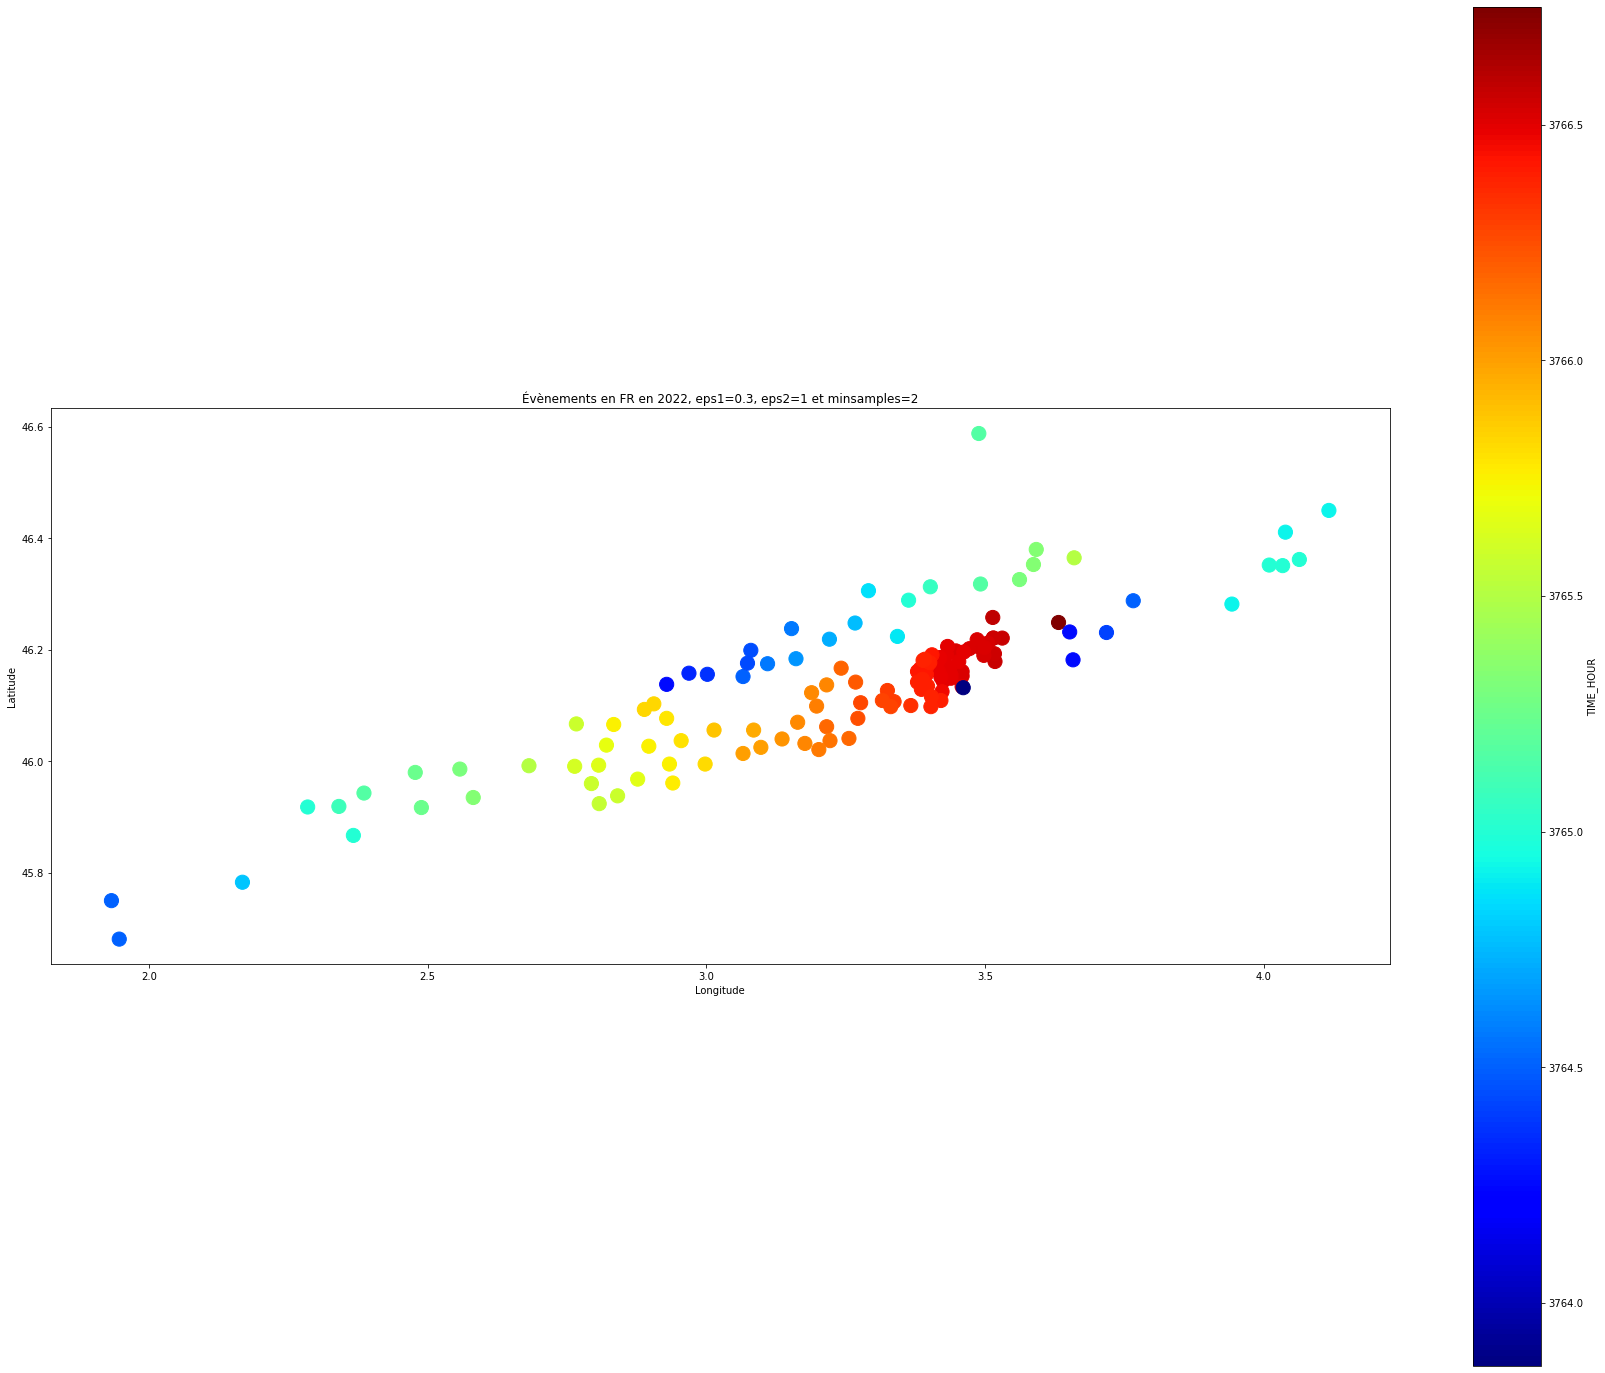

In [66]:
x="FR"
clusterise_country_year_2(x, 2022, 0.3, 1, 2, 1)

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
49            134       134        134      134


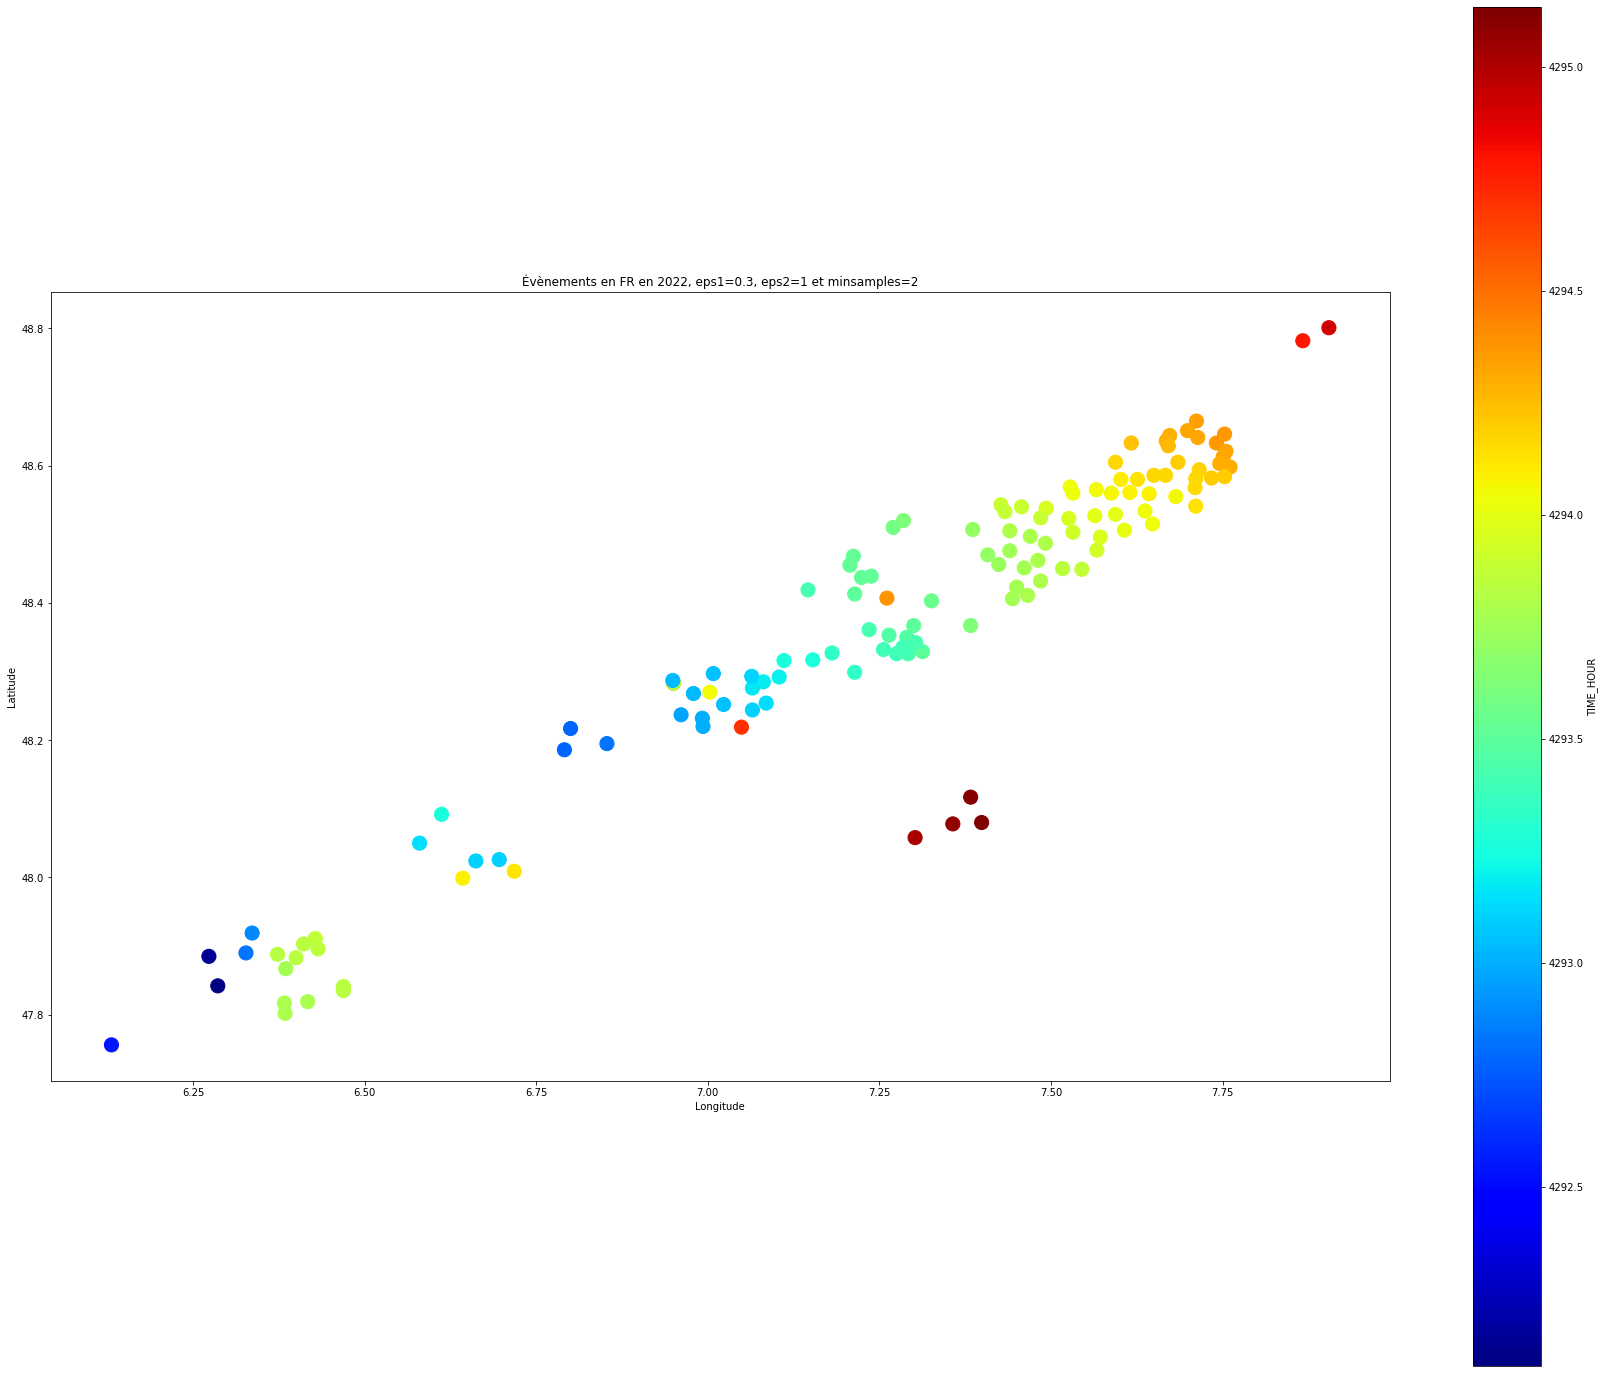

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
95            133       133        133      133


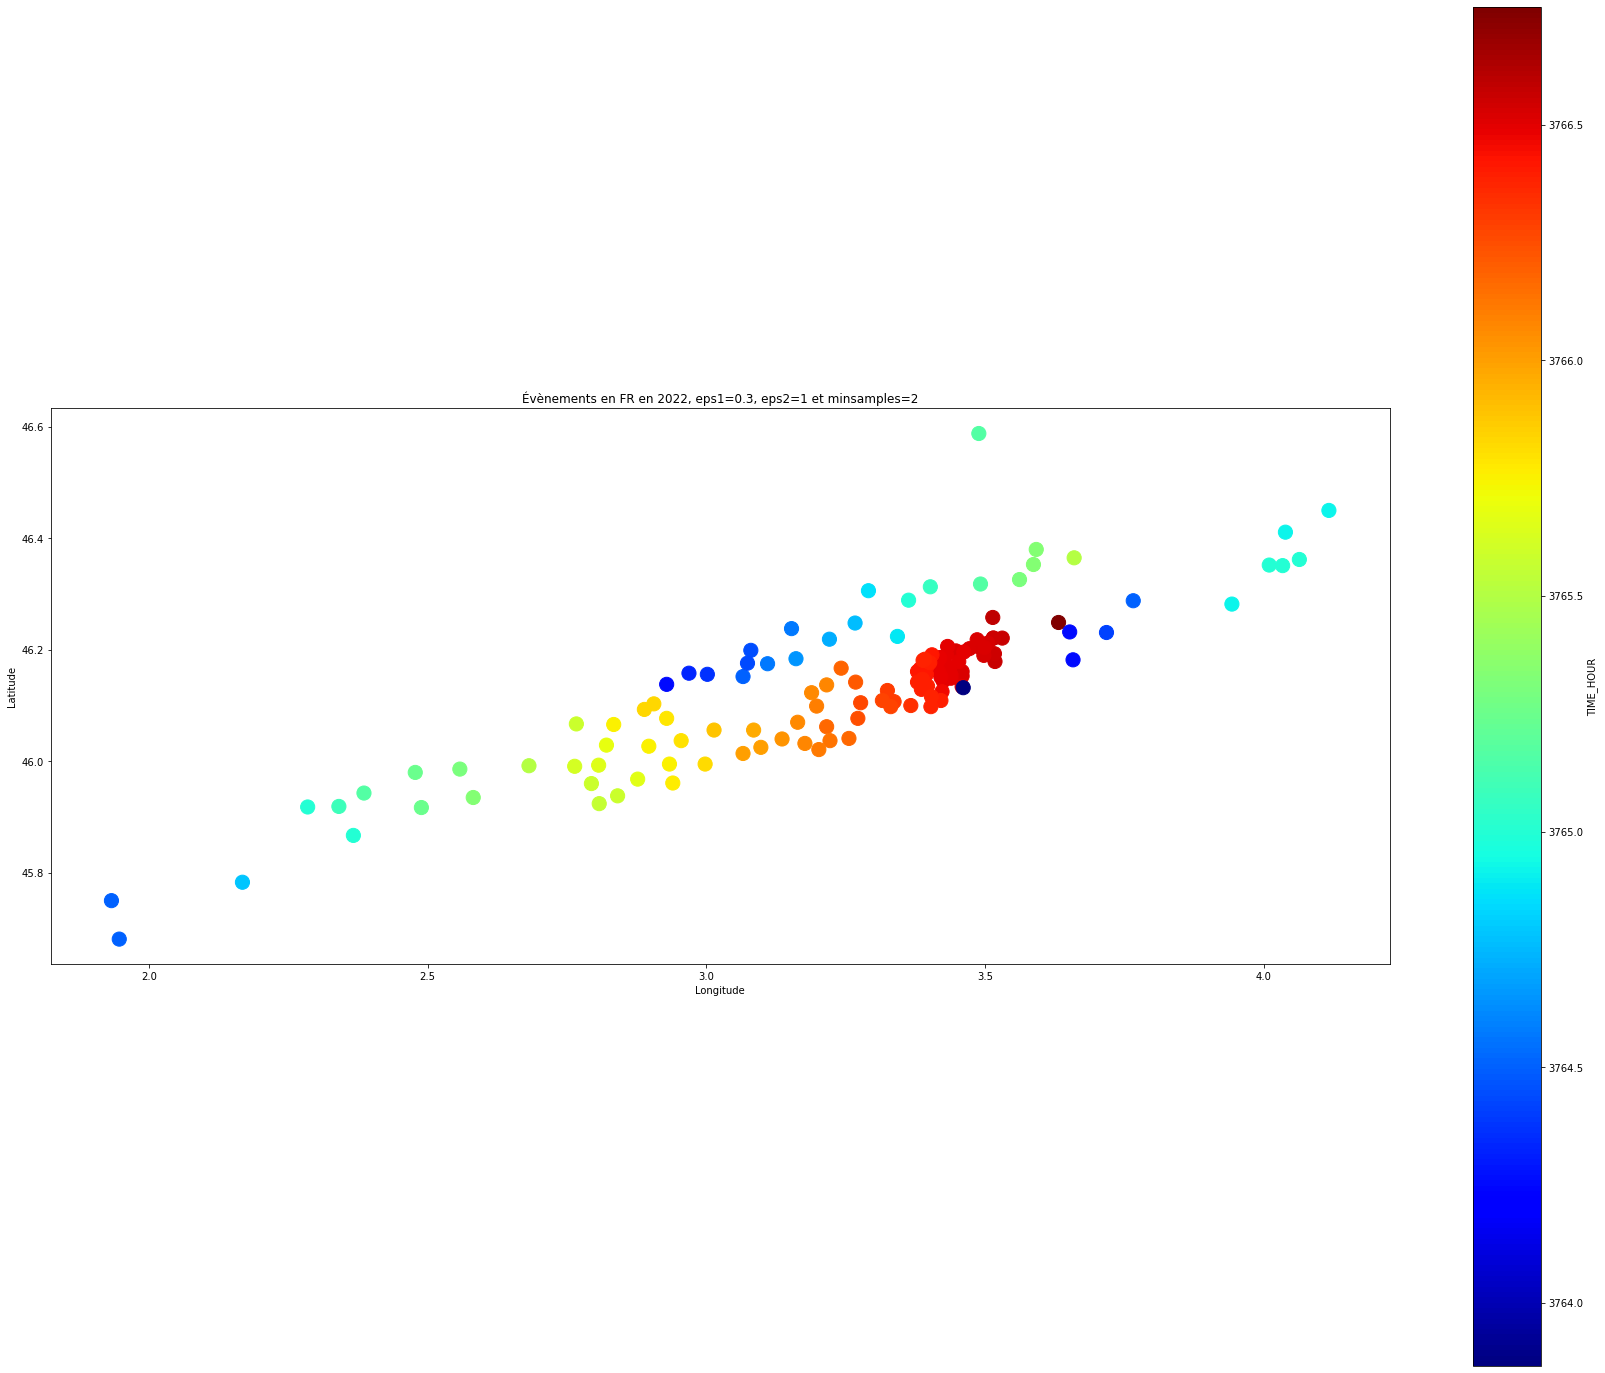

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            114       114        114      114
 120          117       117        117      117


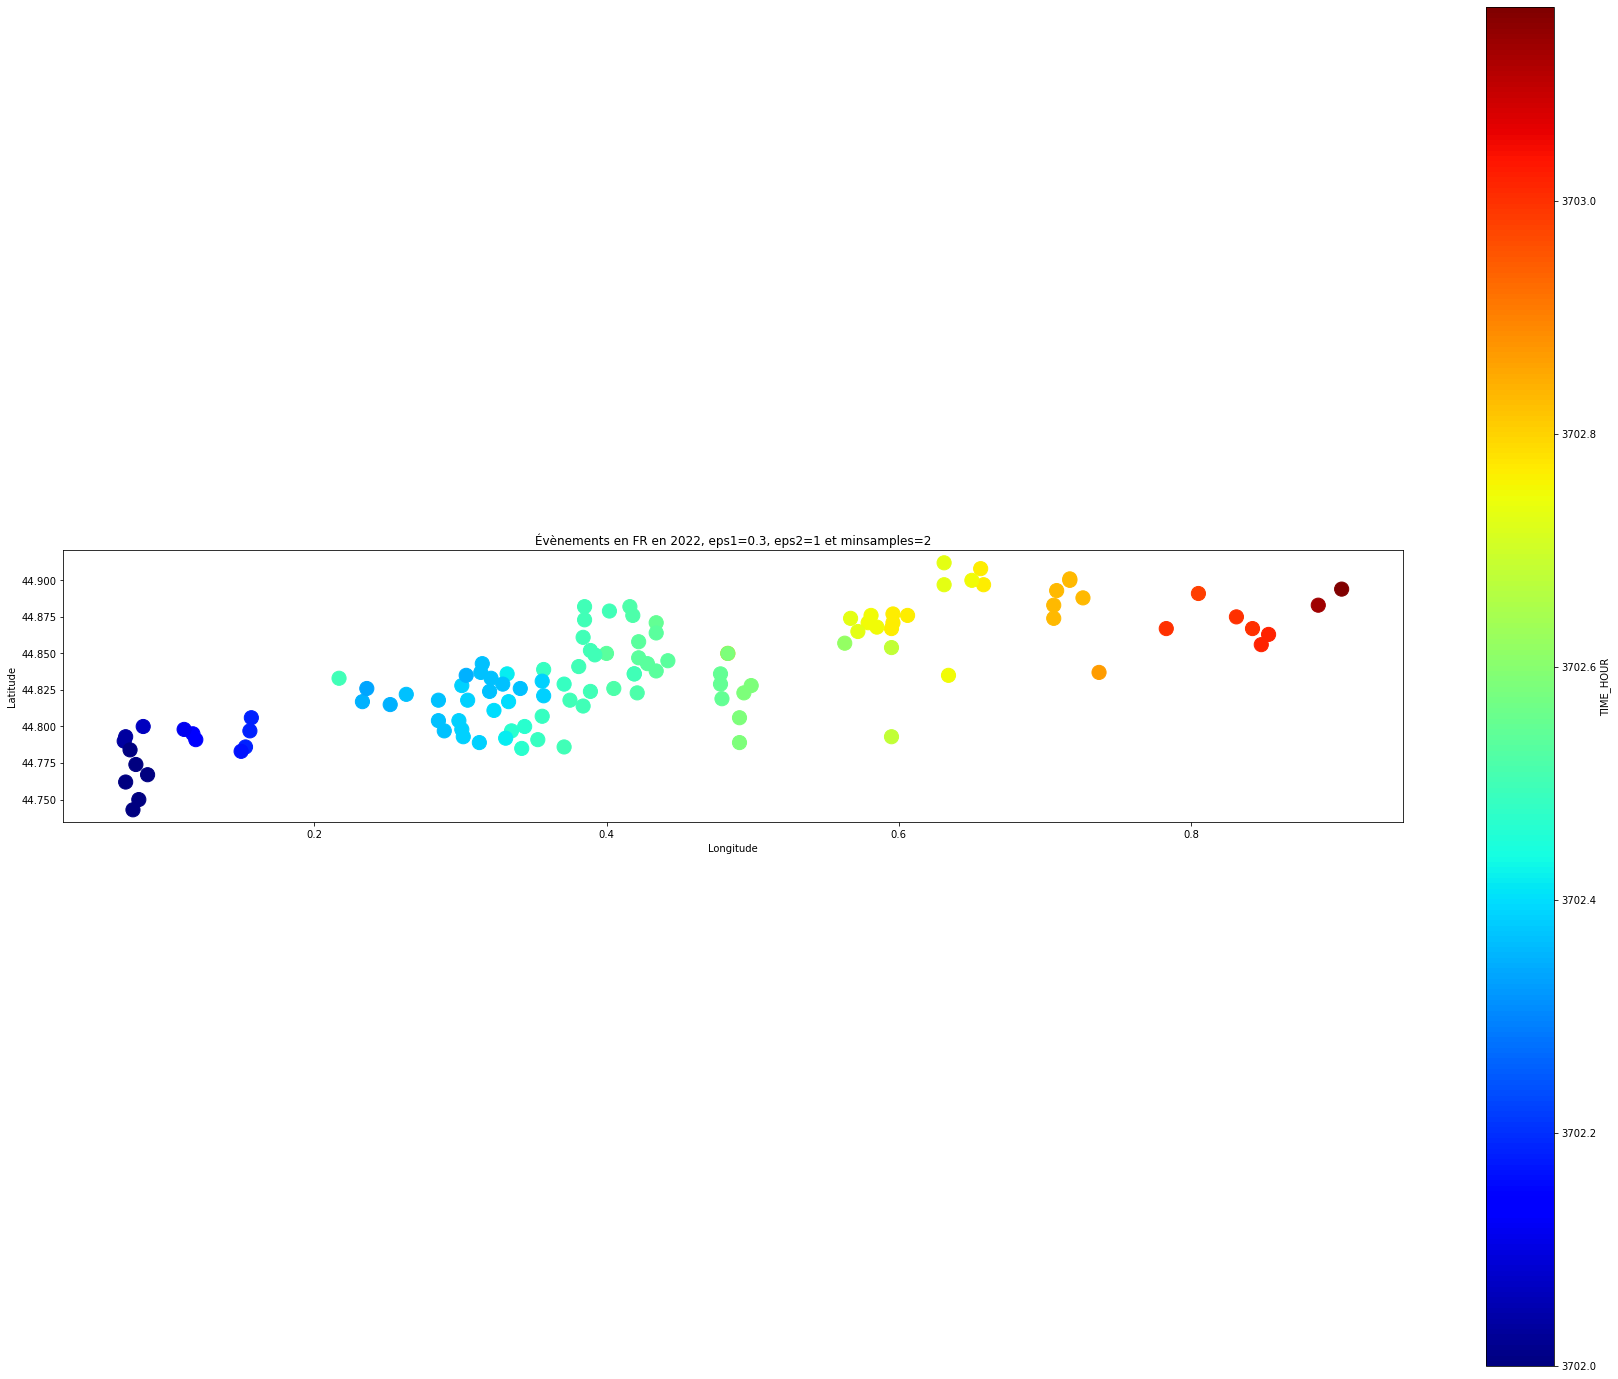

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
76            113       113        113      113


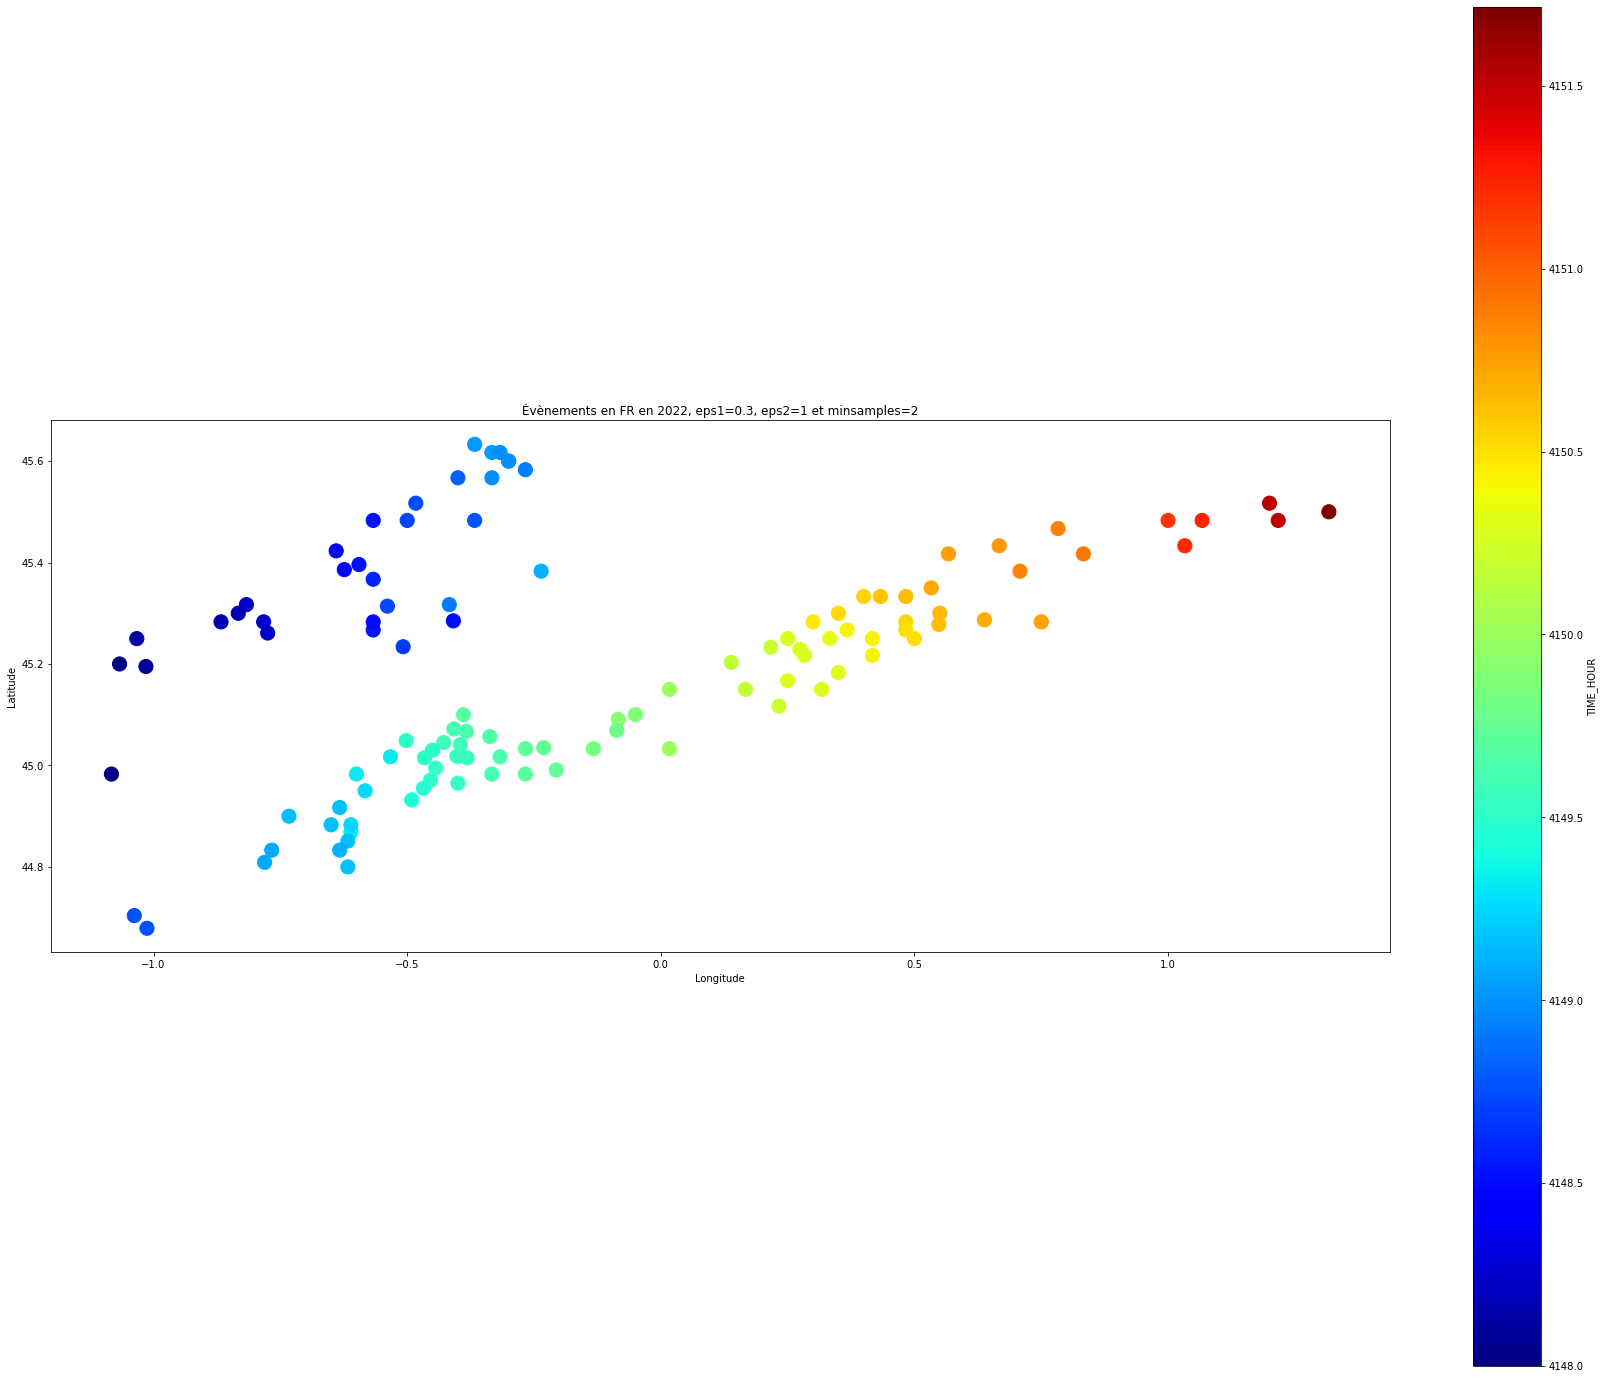

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
48            110       110        110      110


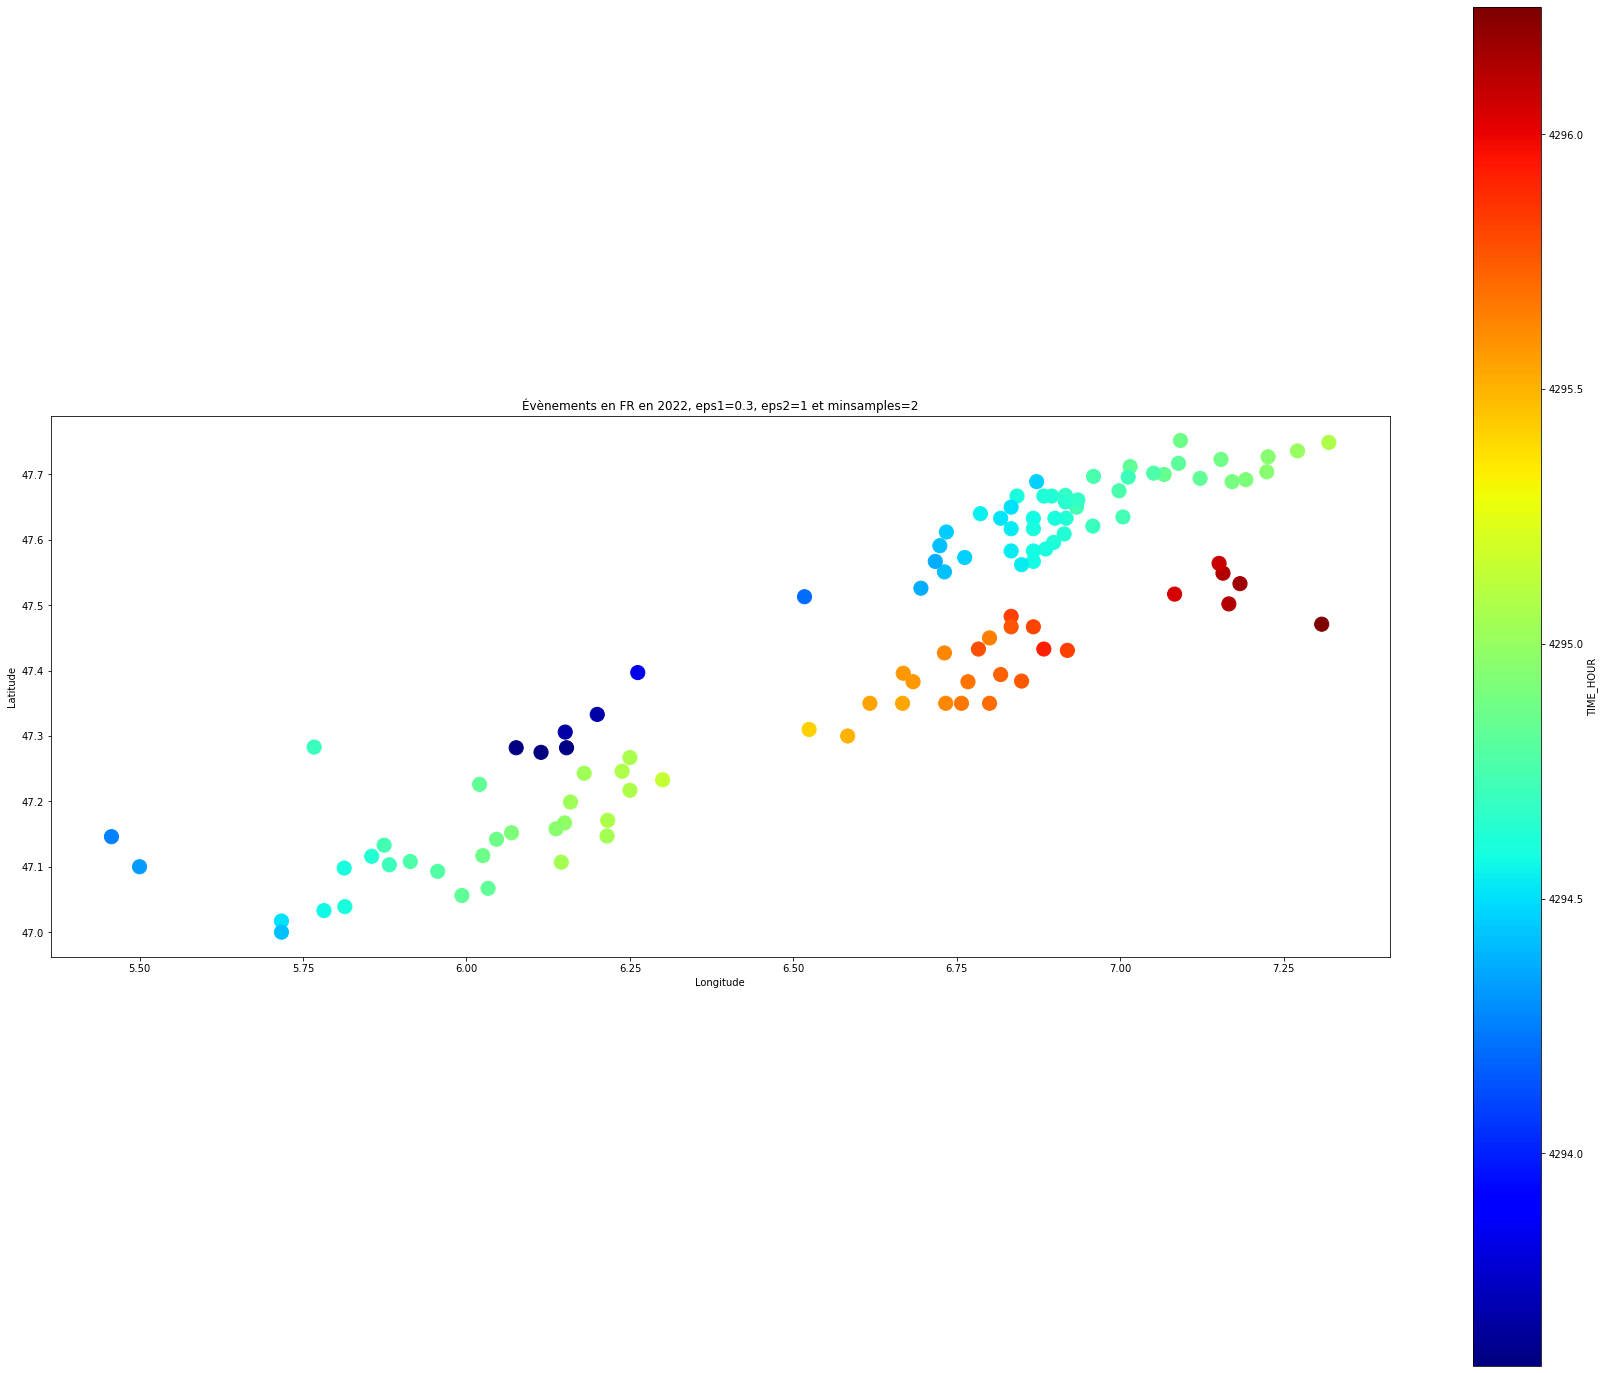

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
79             97        97         97       97


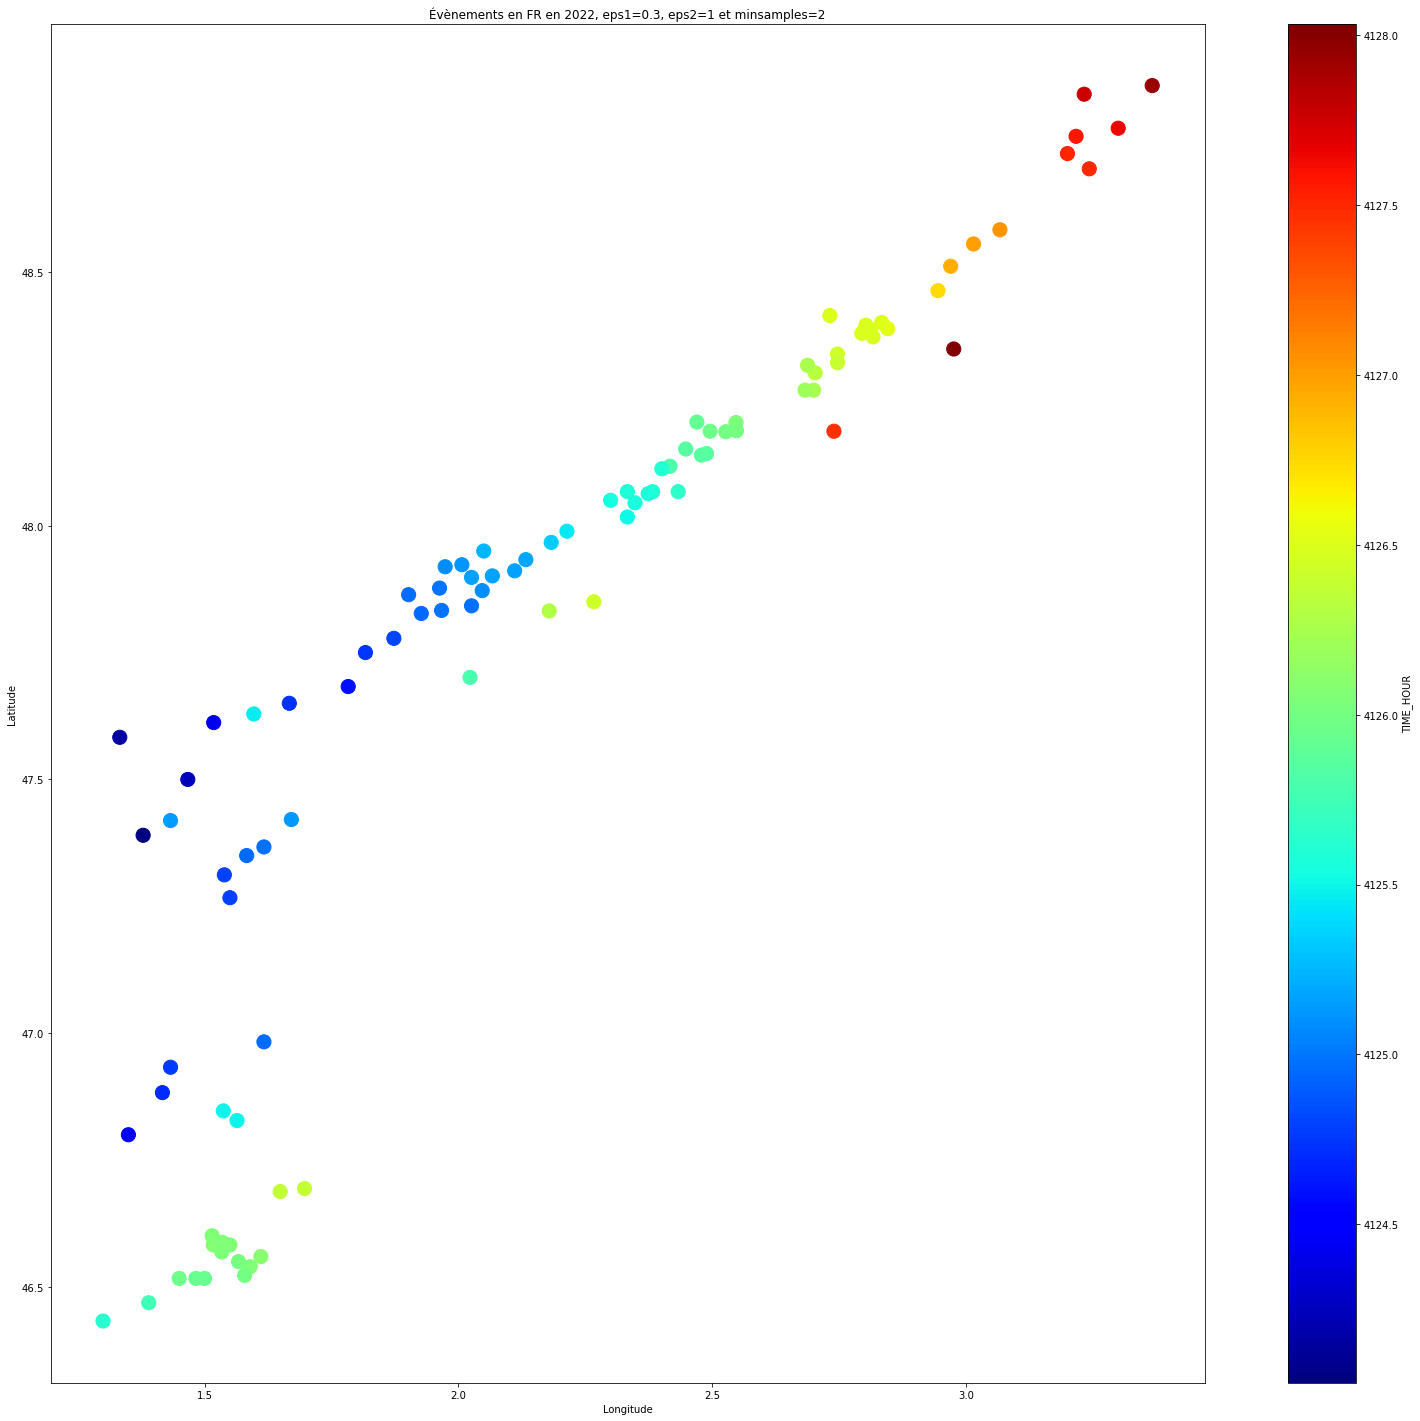

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
78             59        59         59       59


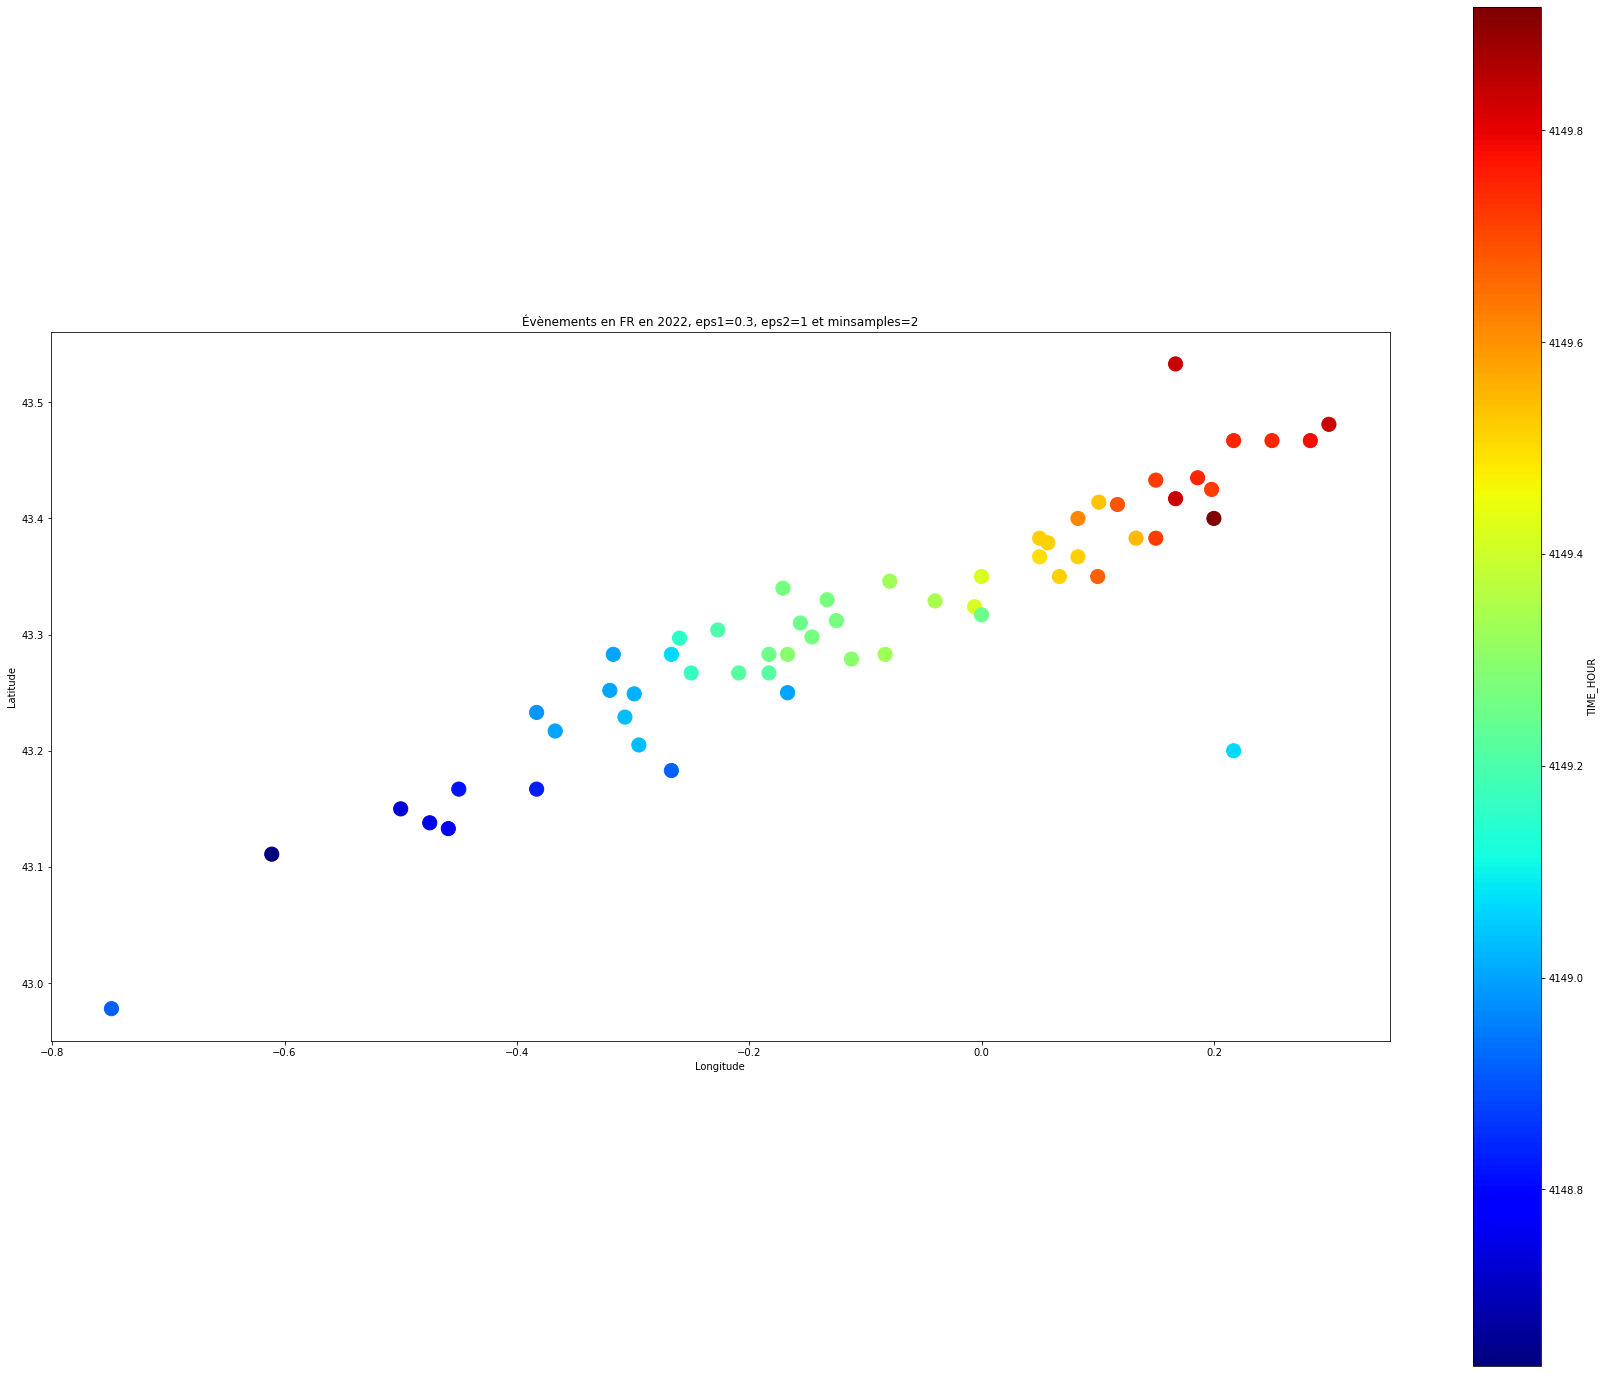

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
124            52        52         52       52


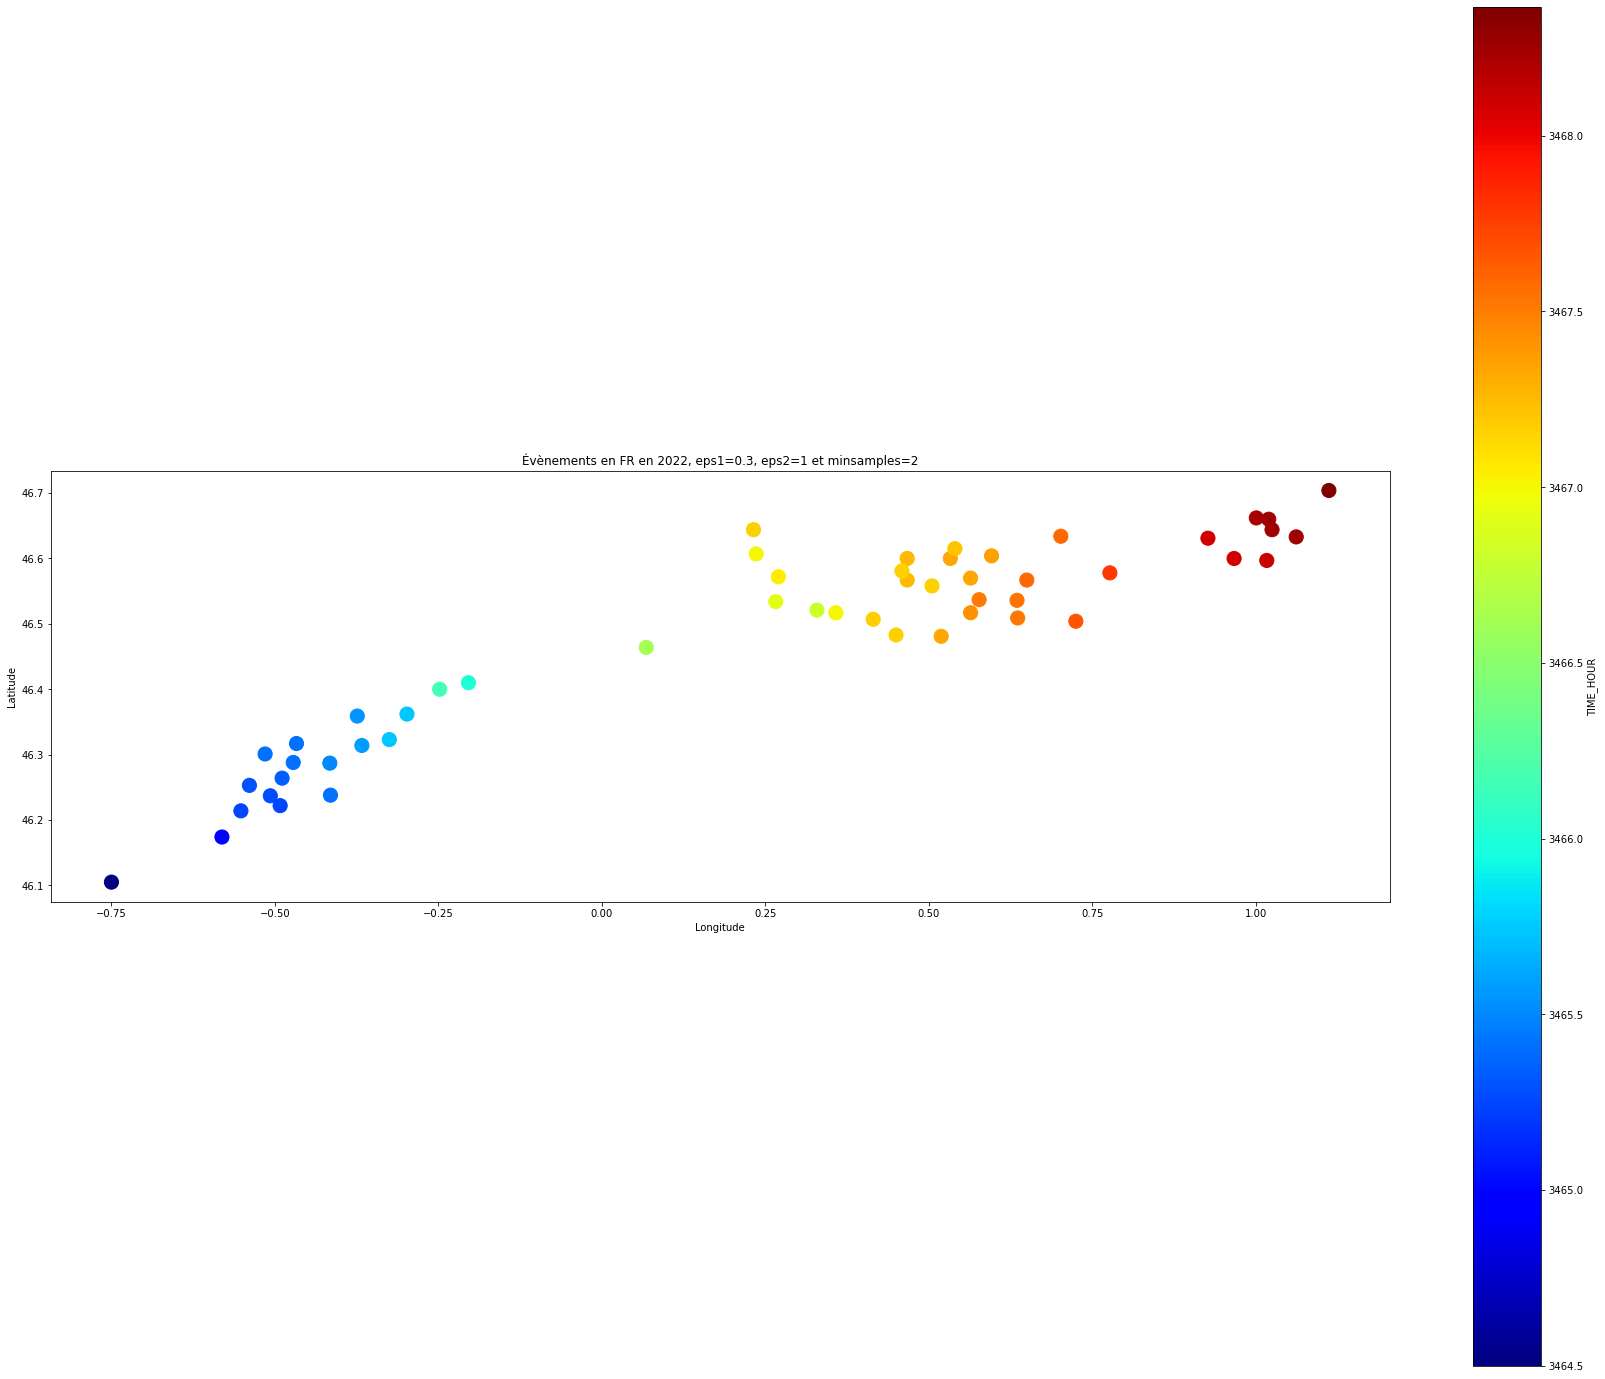

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
38             46        46         46       46


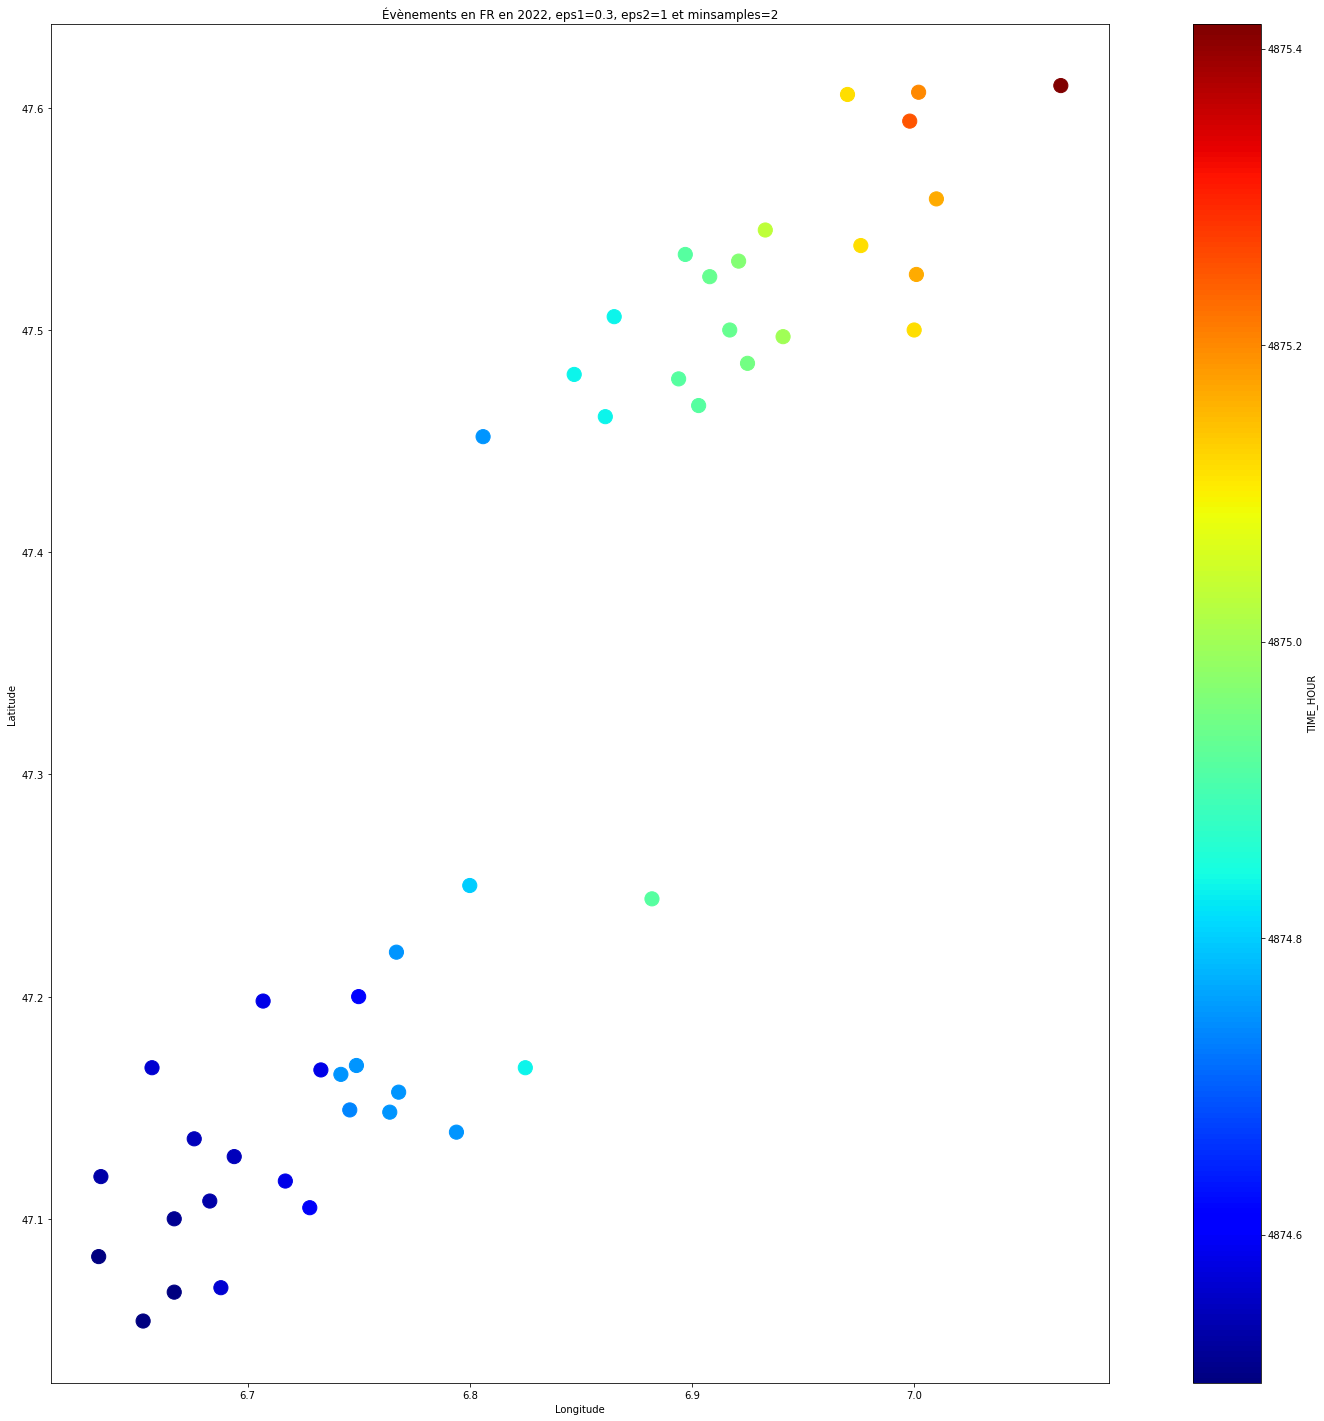

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
74             41        41         41       41


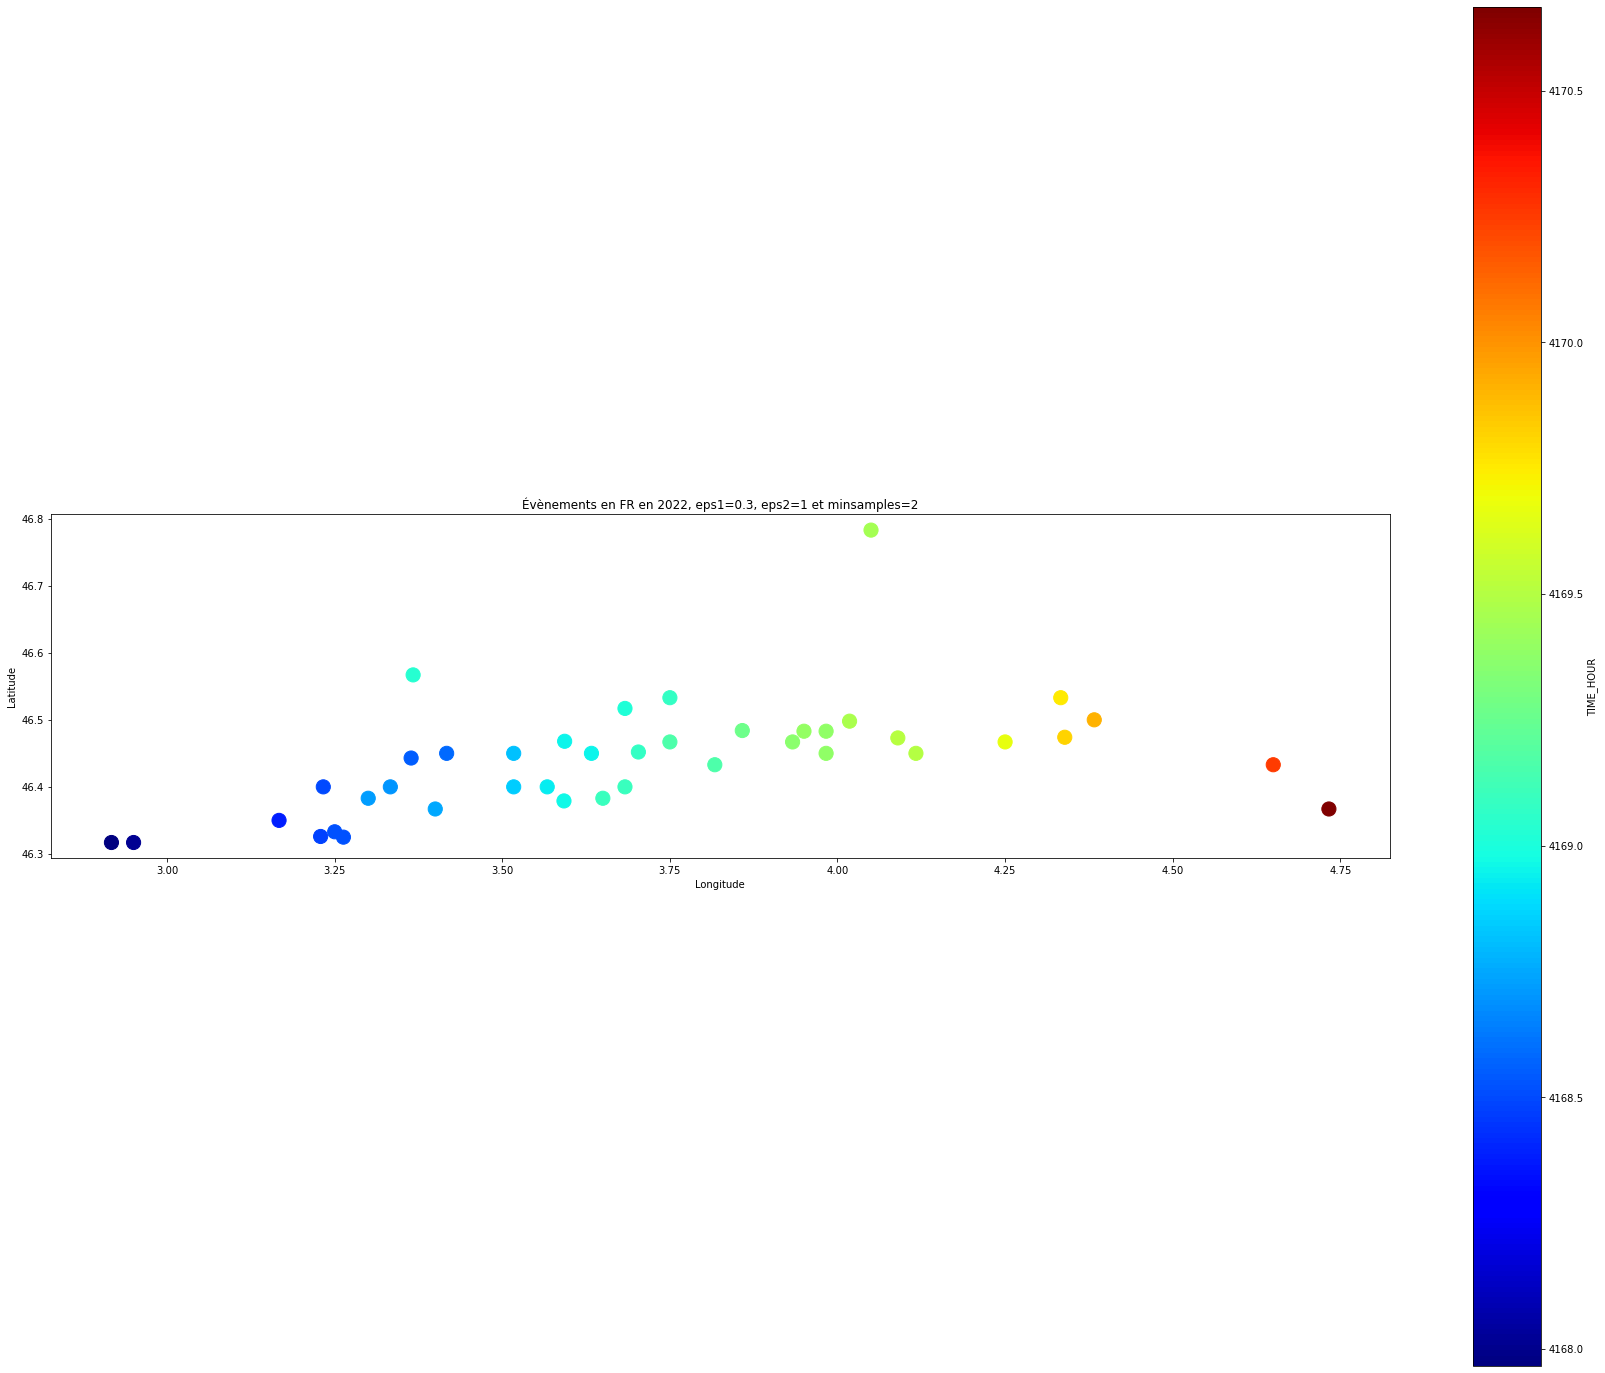

In [74]:
x='FR'
for i in range(10):
    clusterise_country_year_2(x, 2022, 0.3, 1, 2, i)

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            123       123        123      123
 27           364       364        364      364


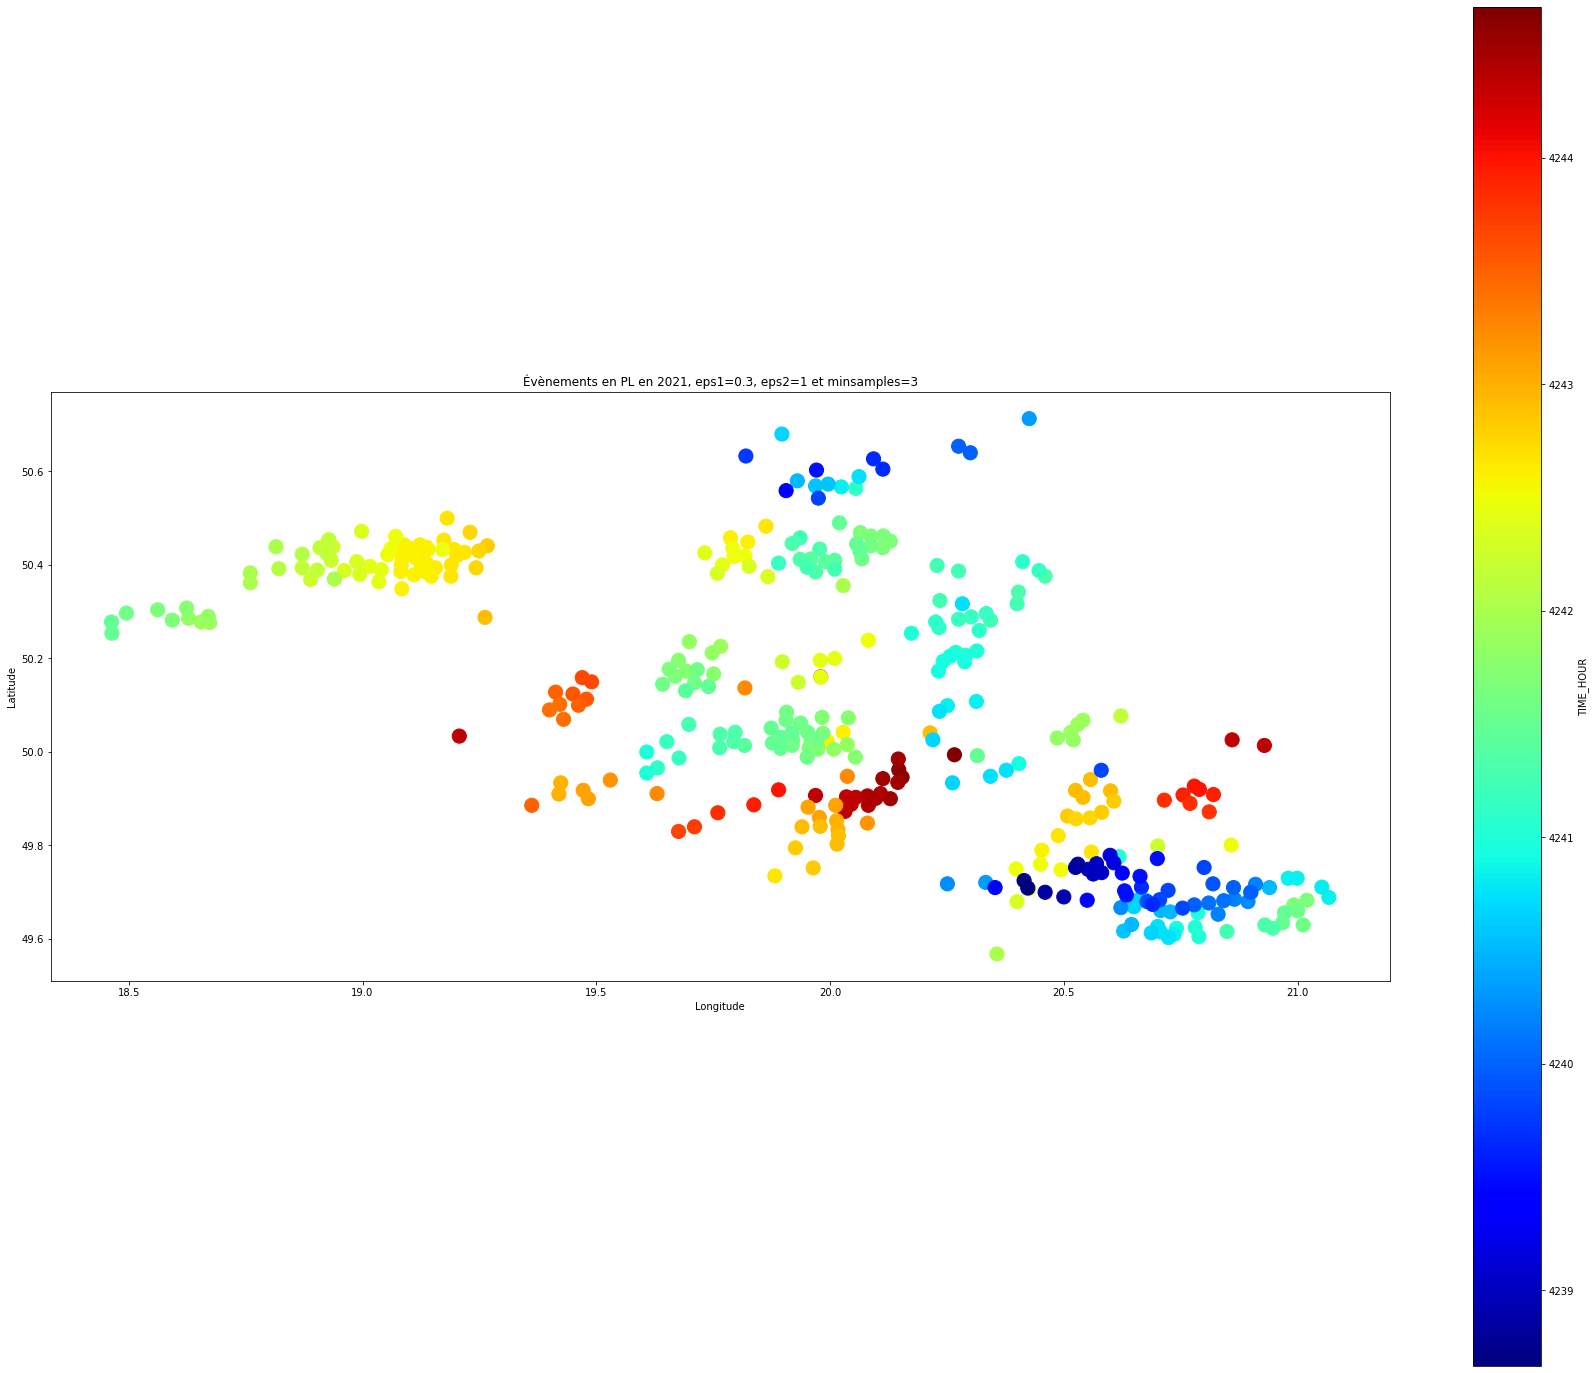

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
30            115       115        115      115


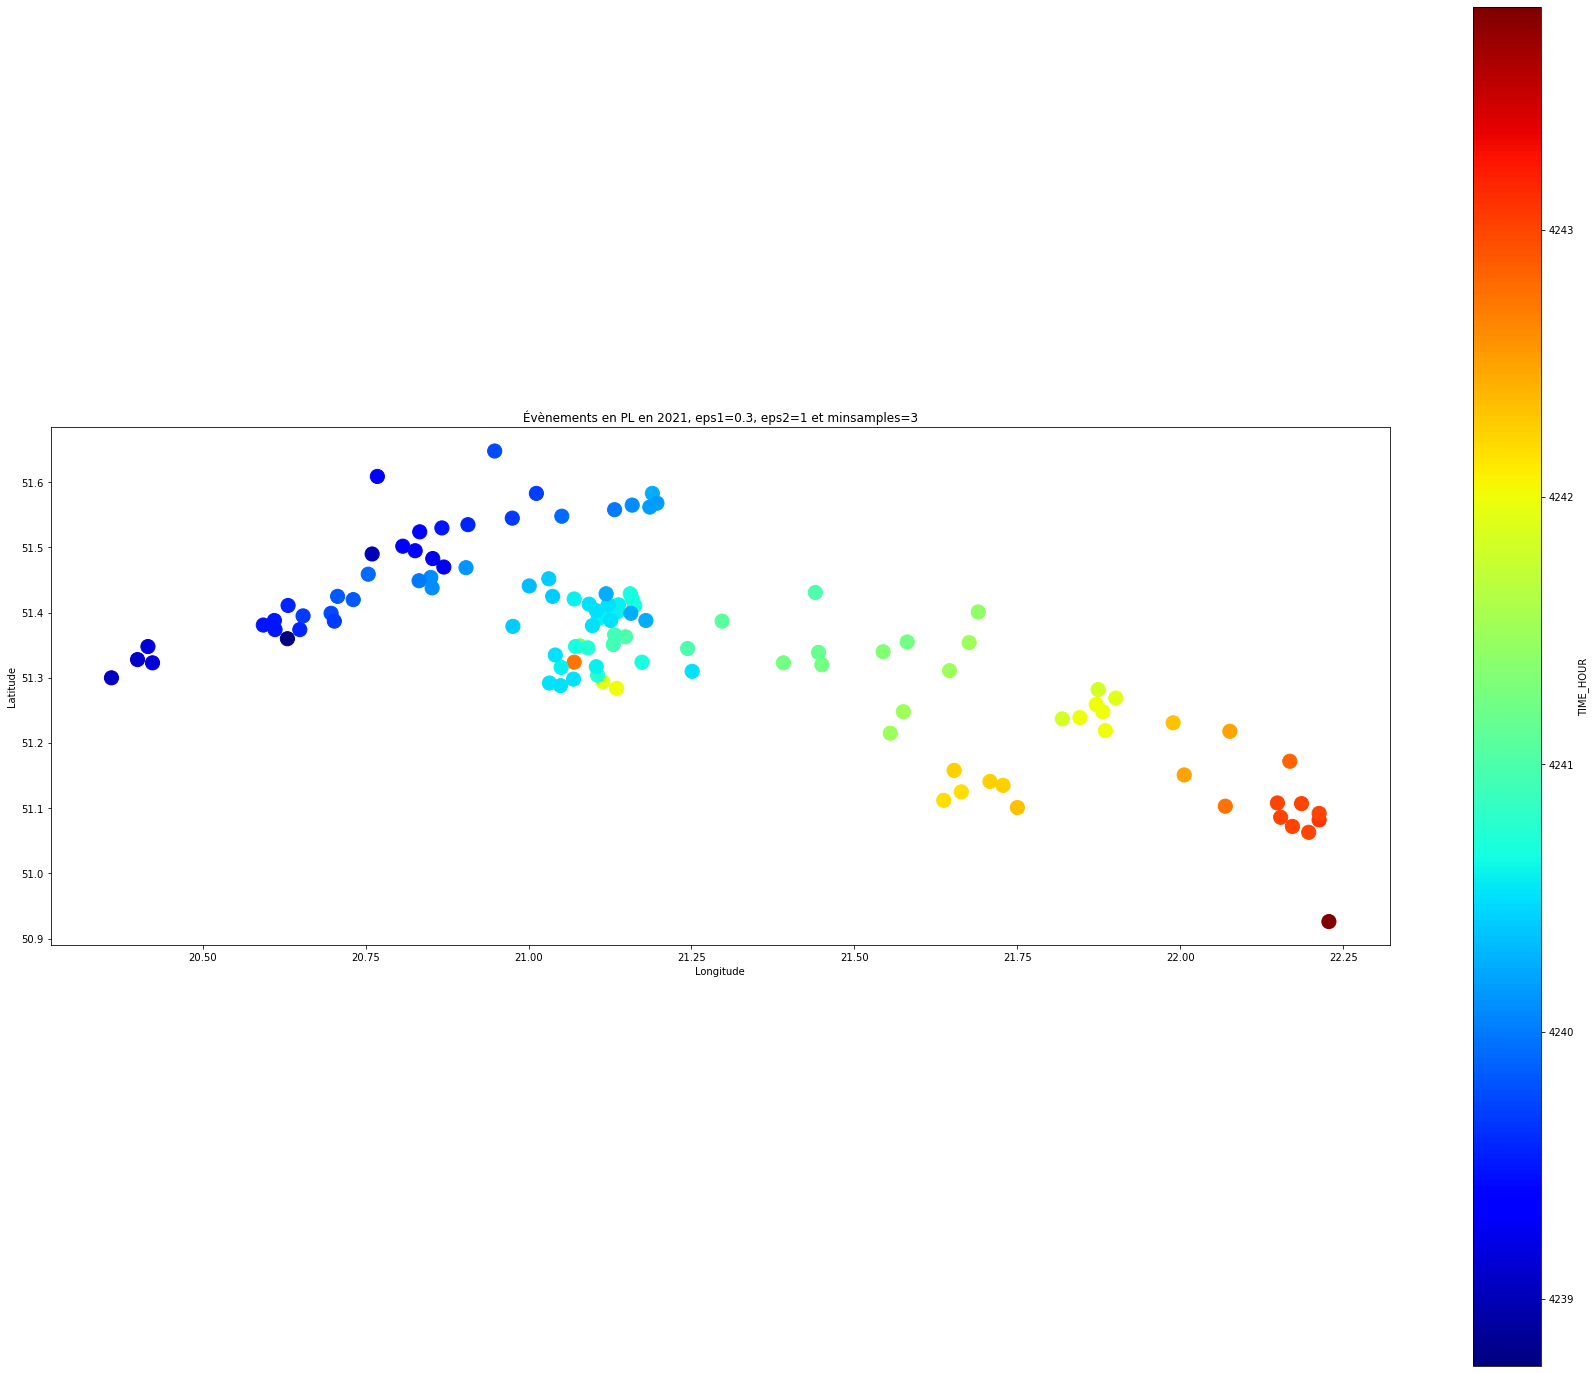

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
29             64        64         64       64


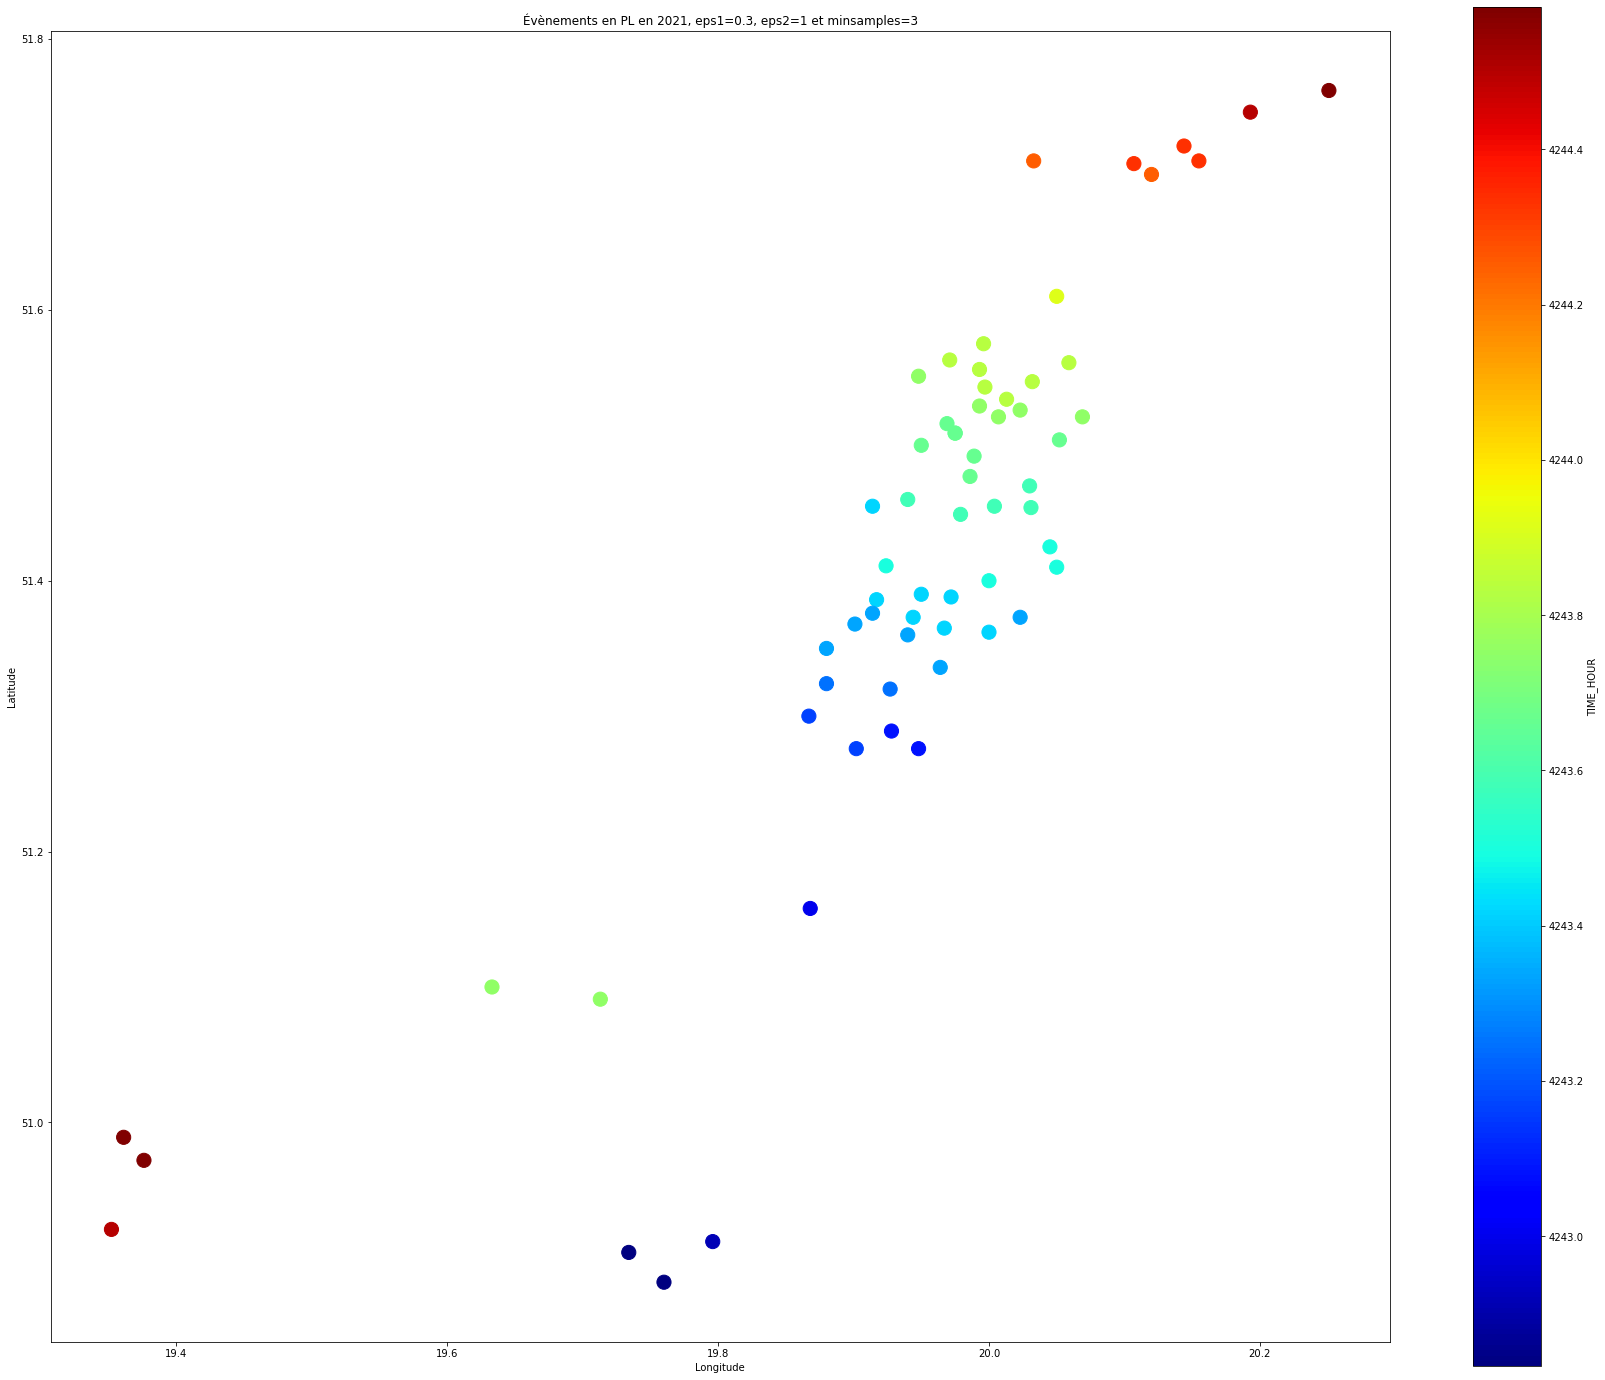

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
34             59        59         59       59


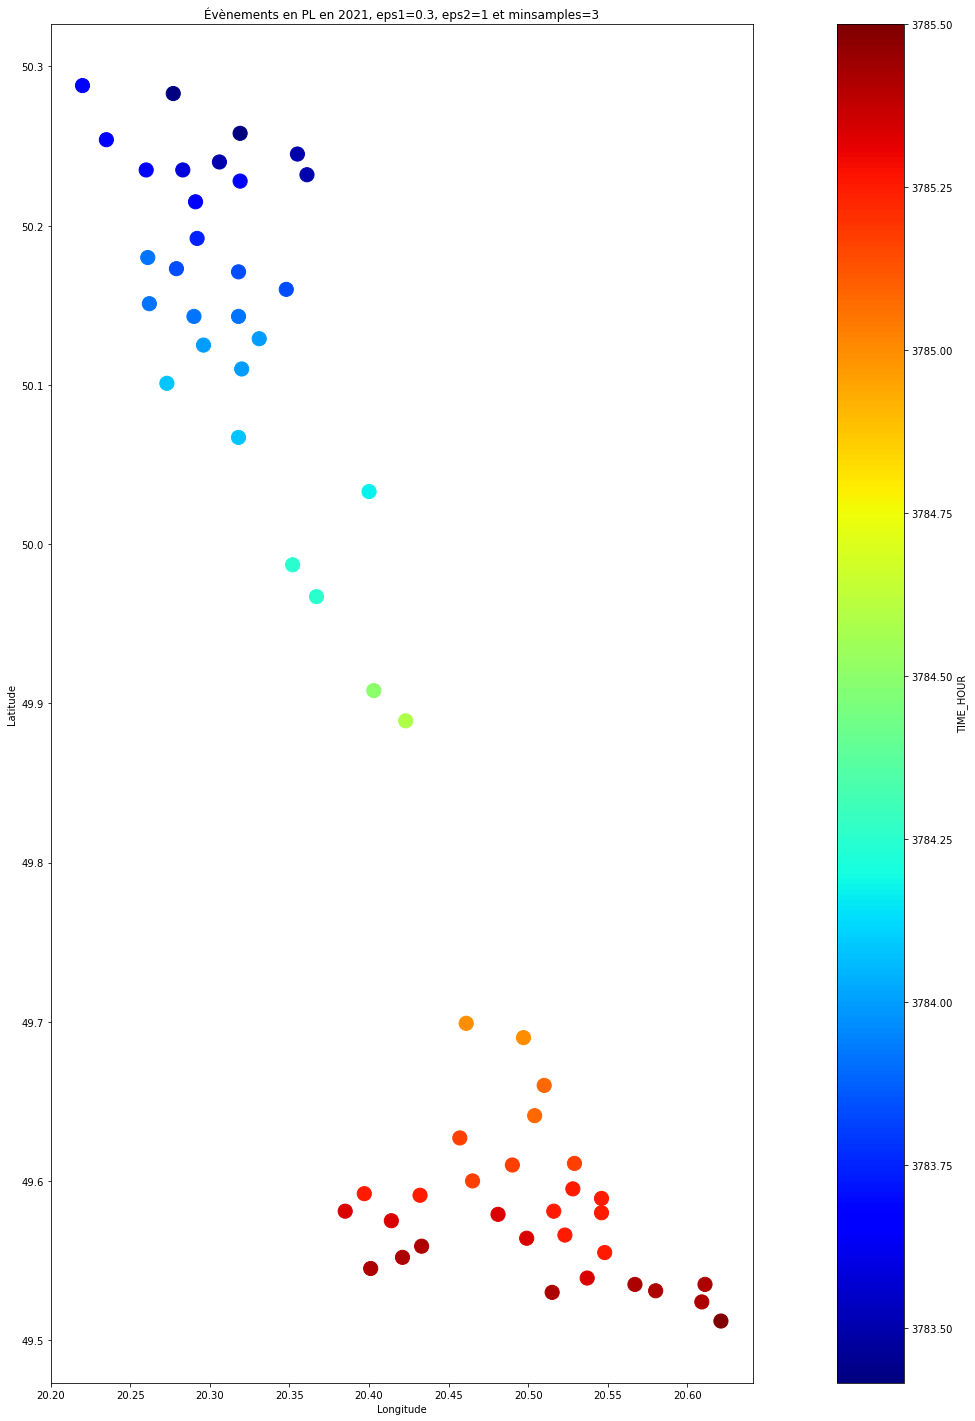

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
18             54        54         54       54


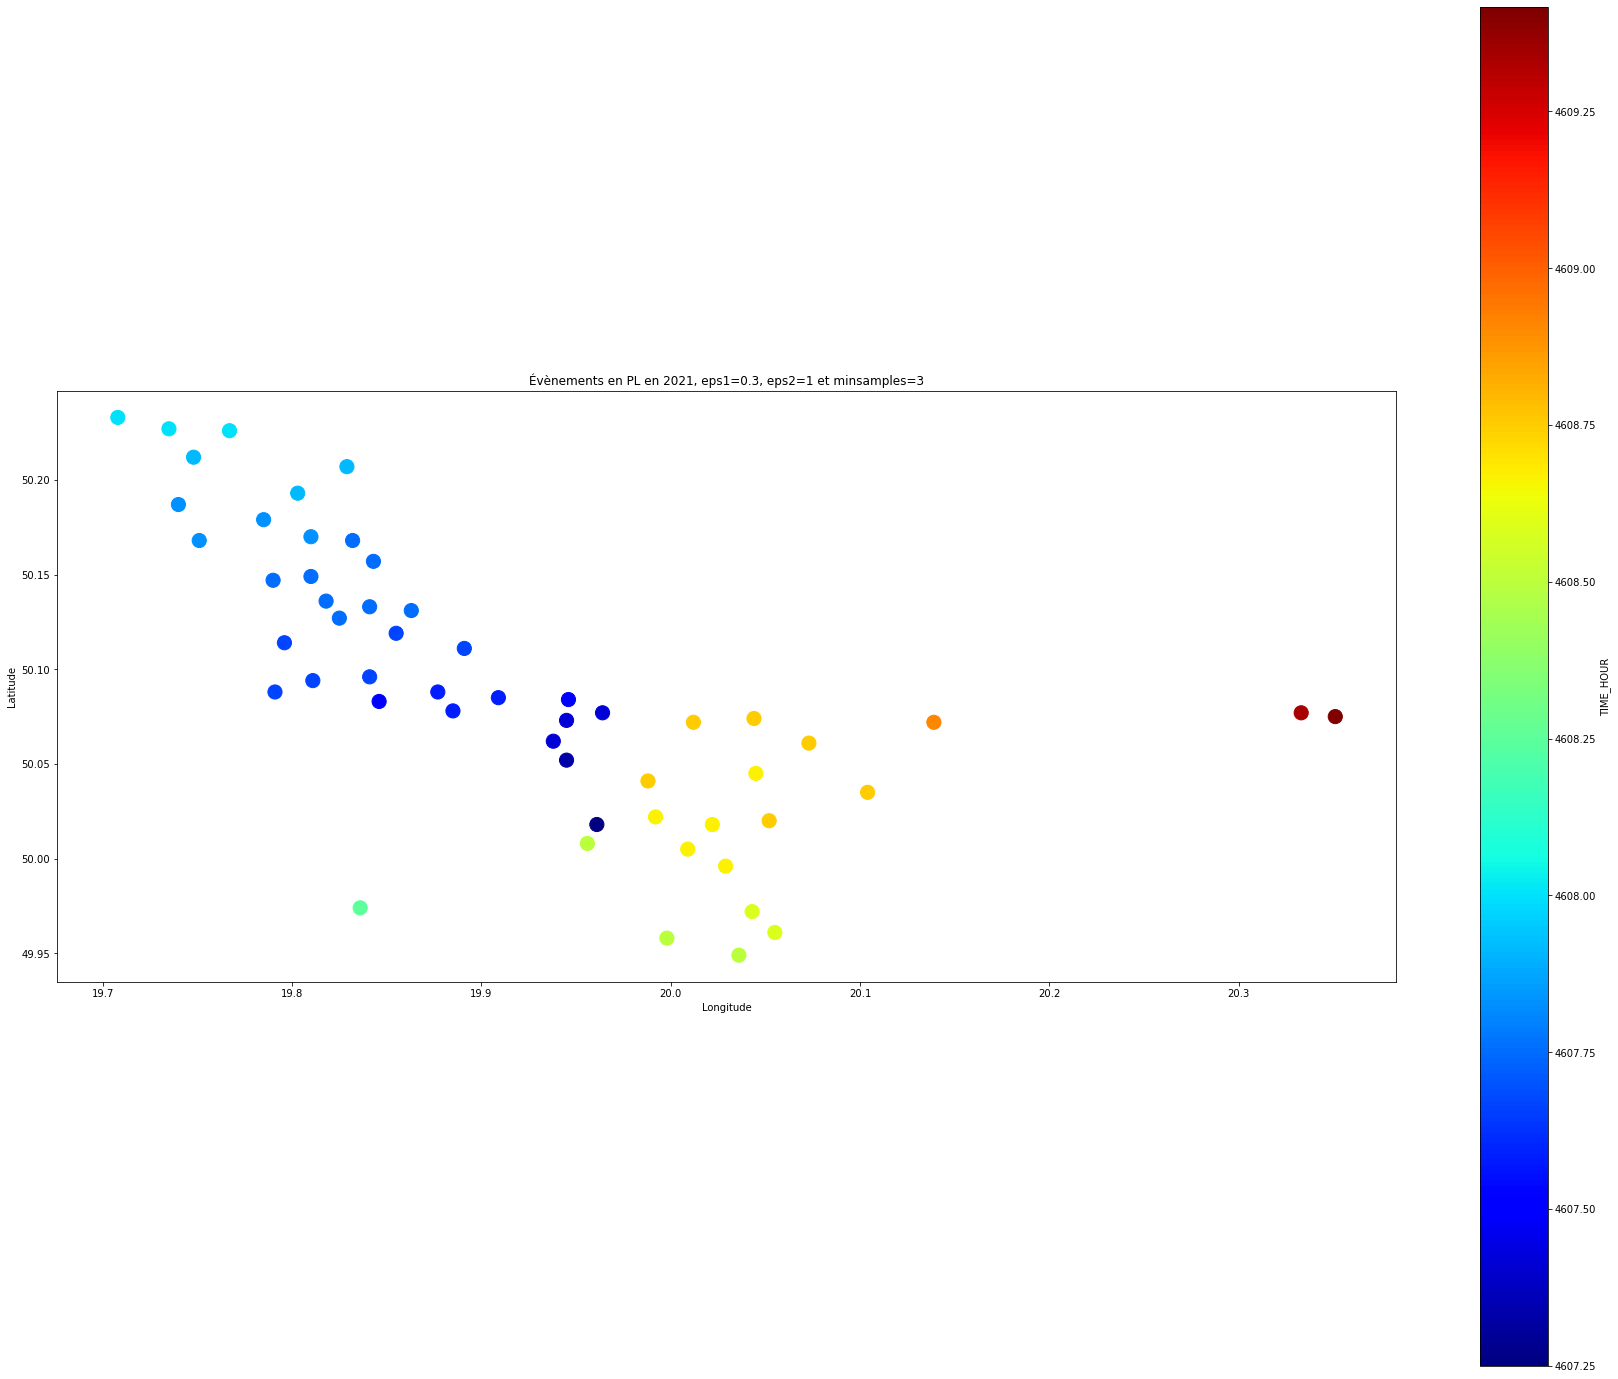

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
25             51        51         51       51


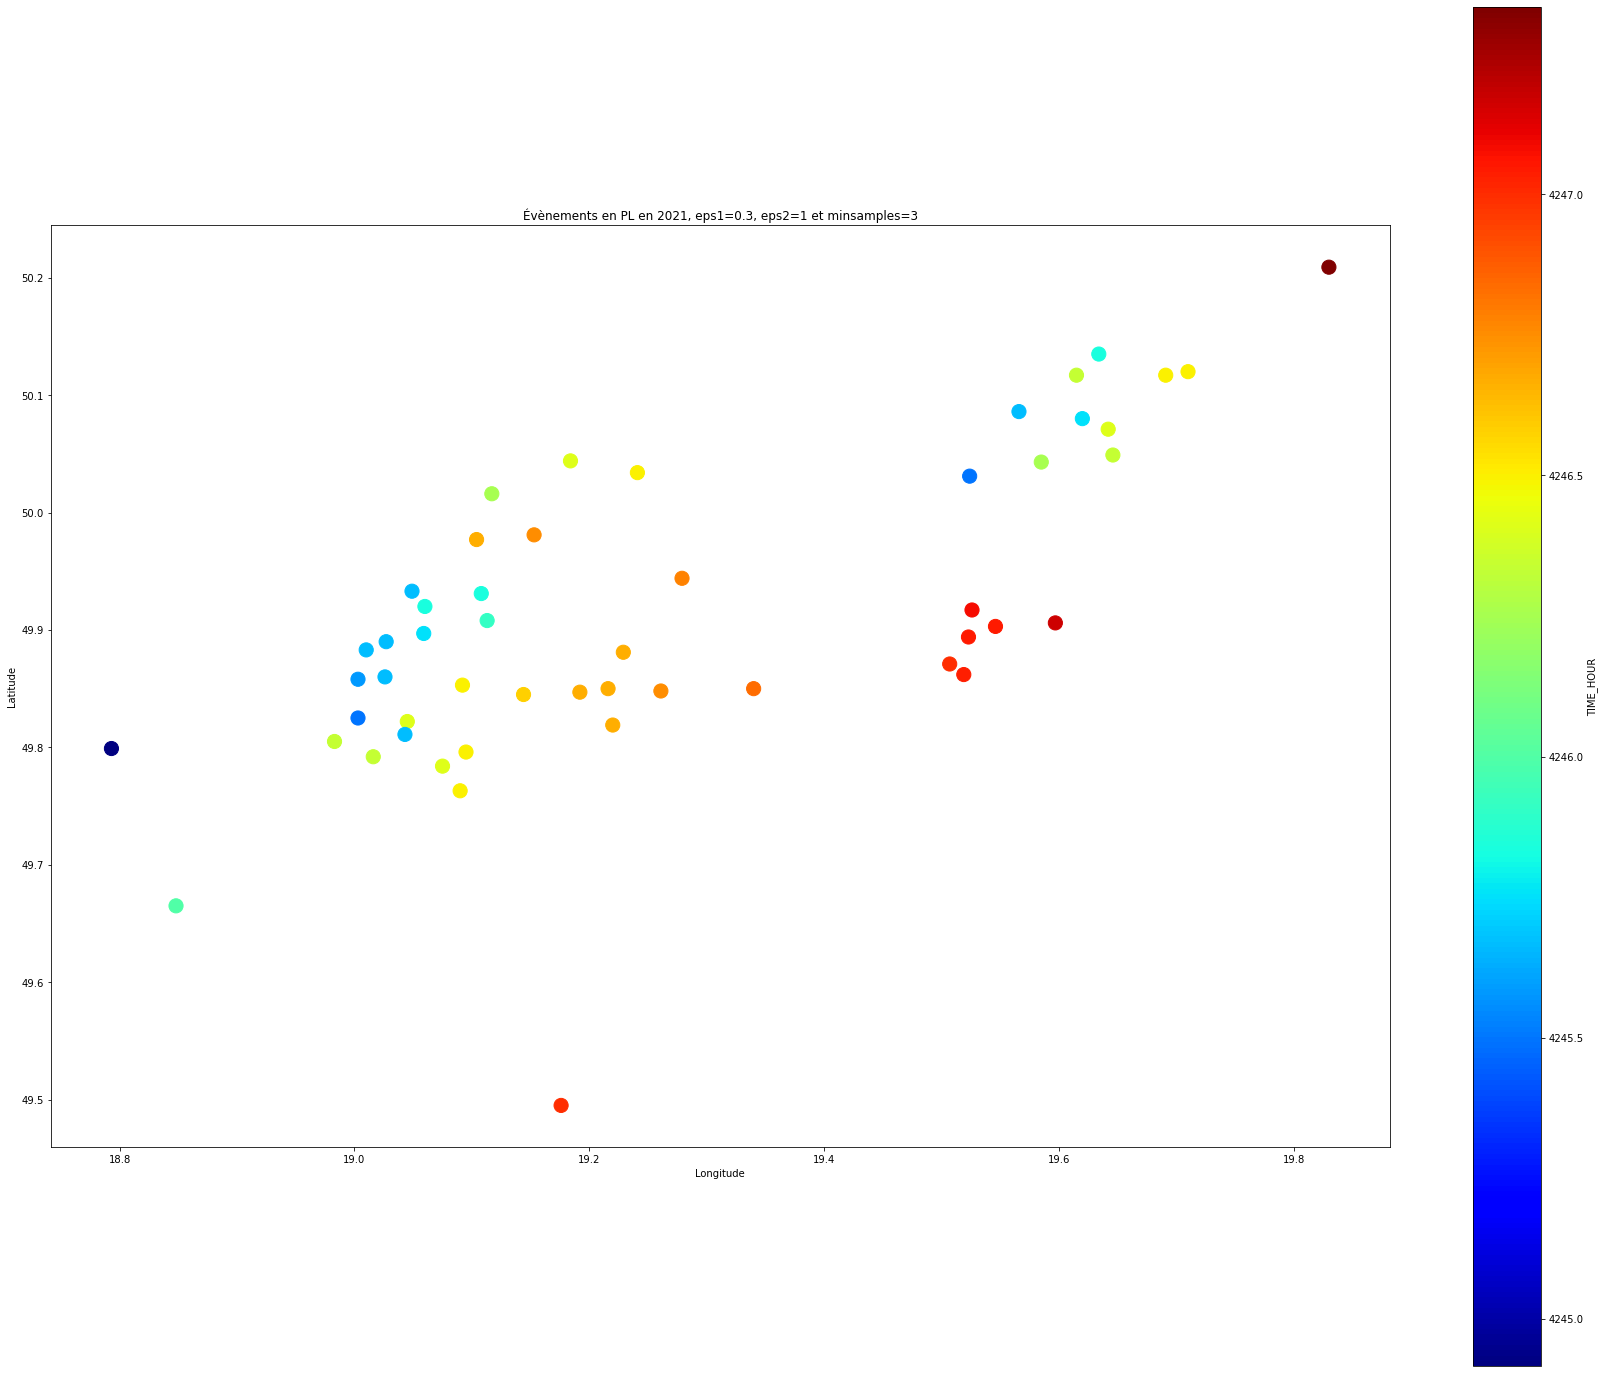

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
21             39        39         39       39


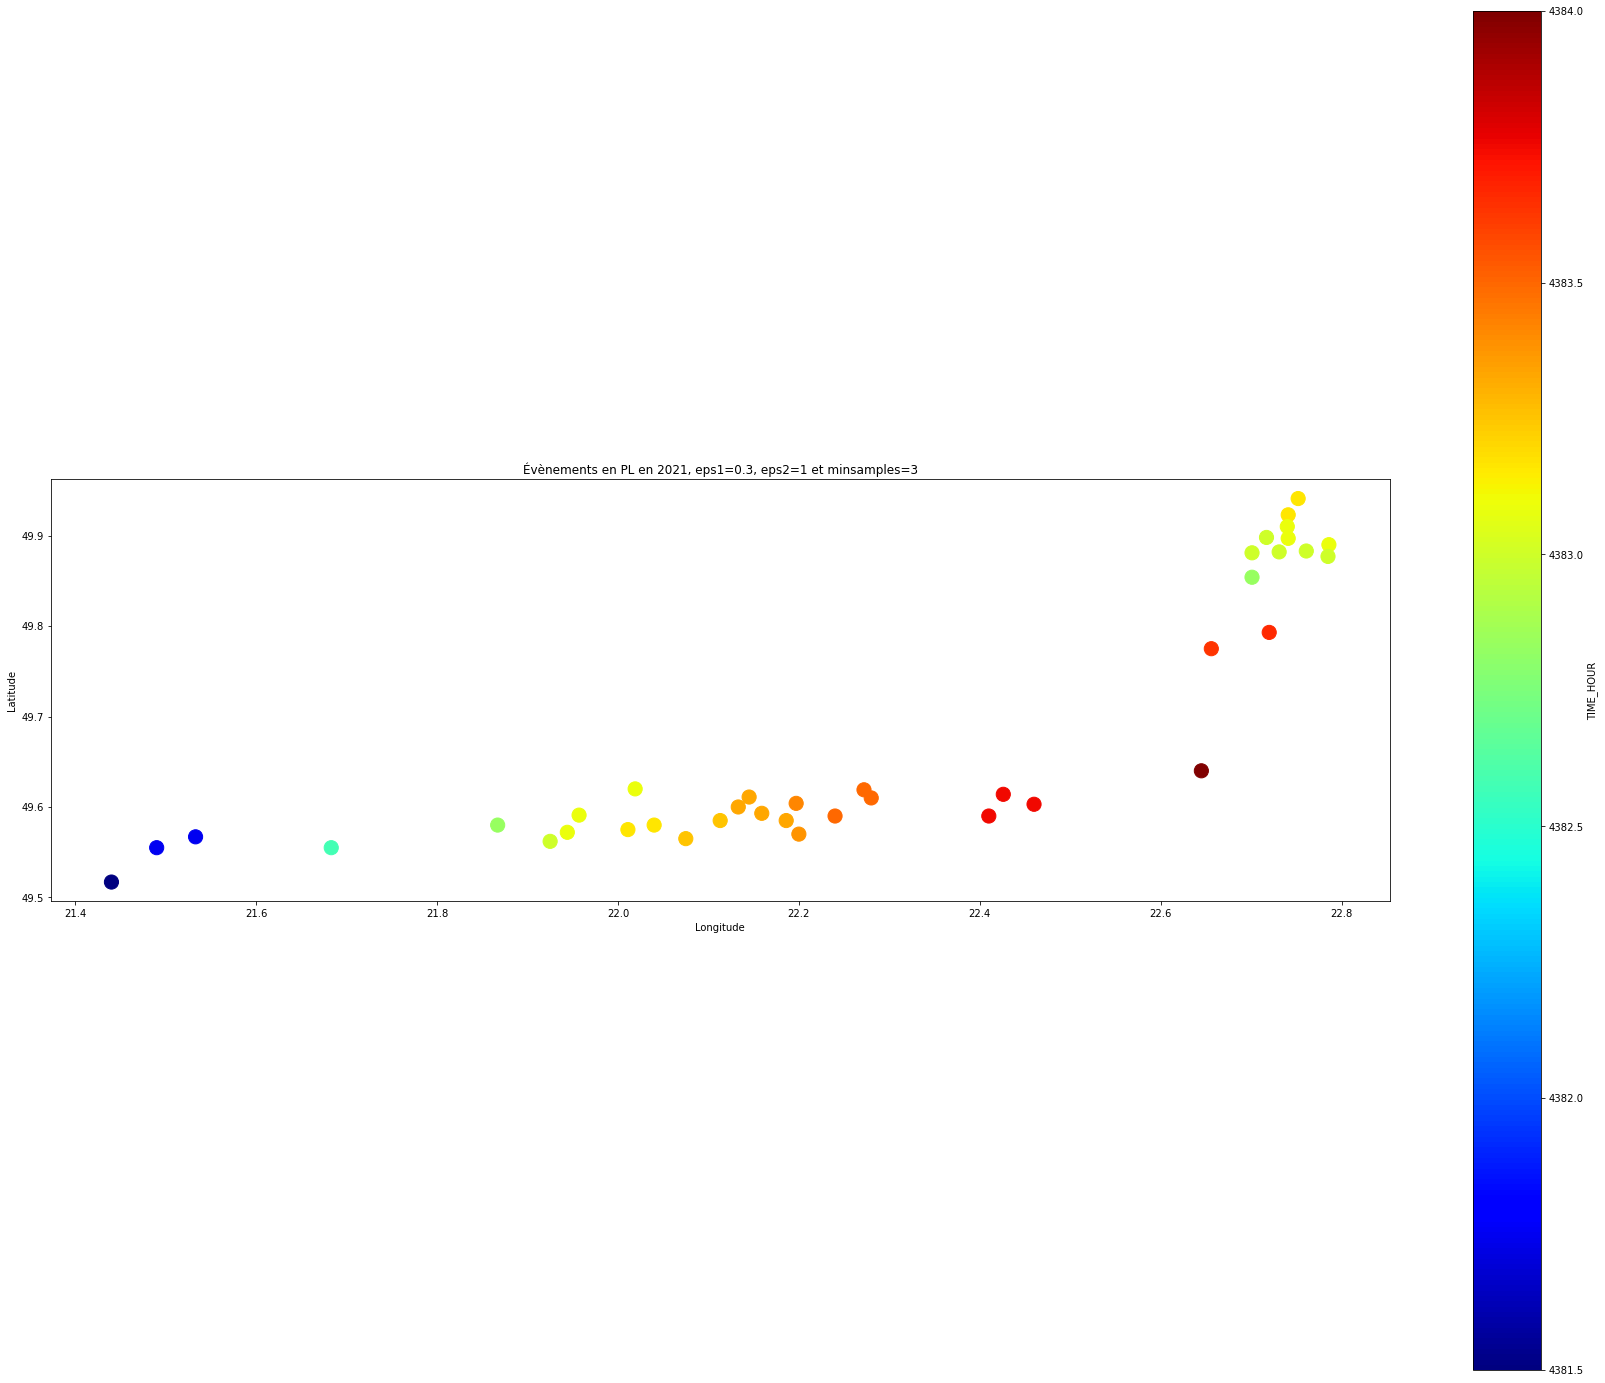

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
5              17        17         17       17


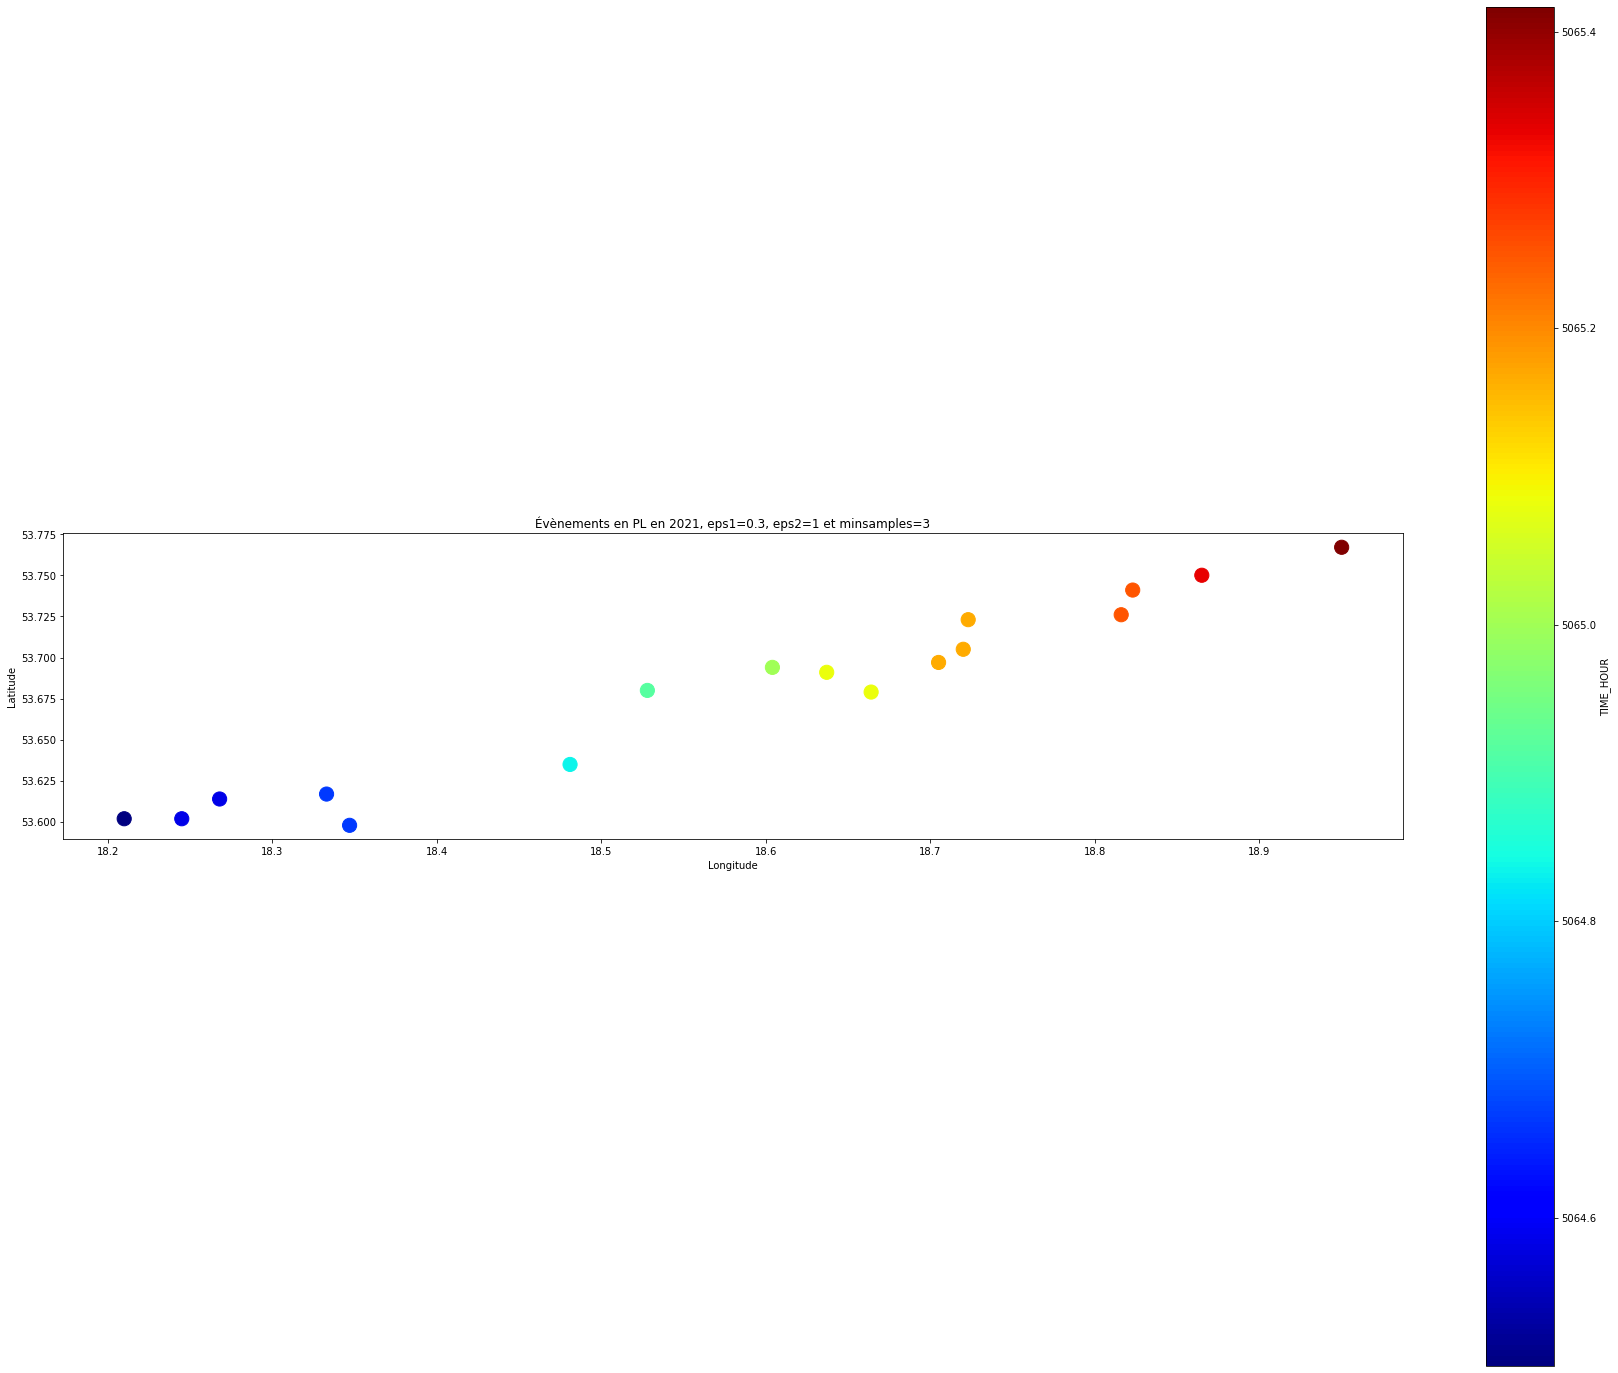

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
24             16        16         16       16


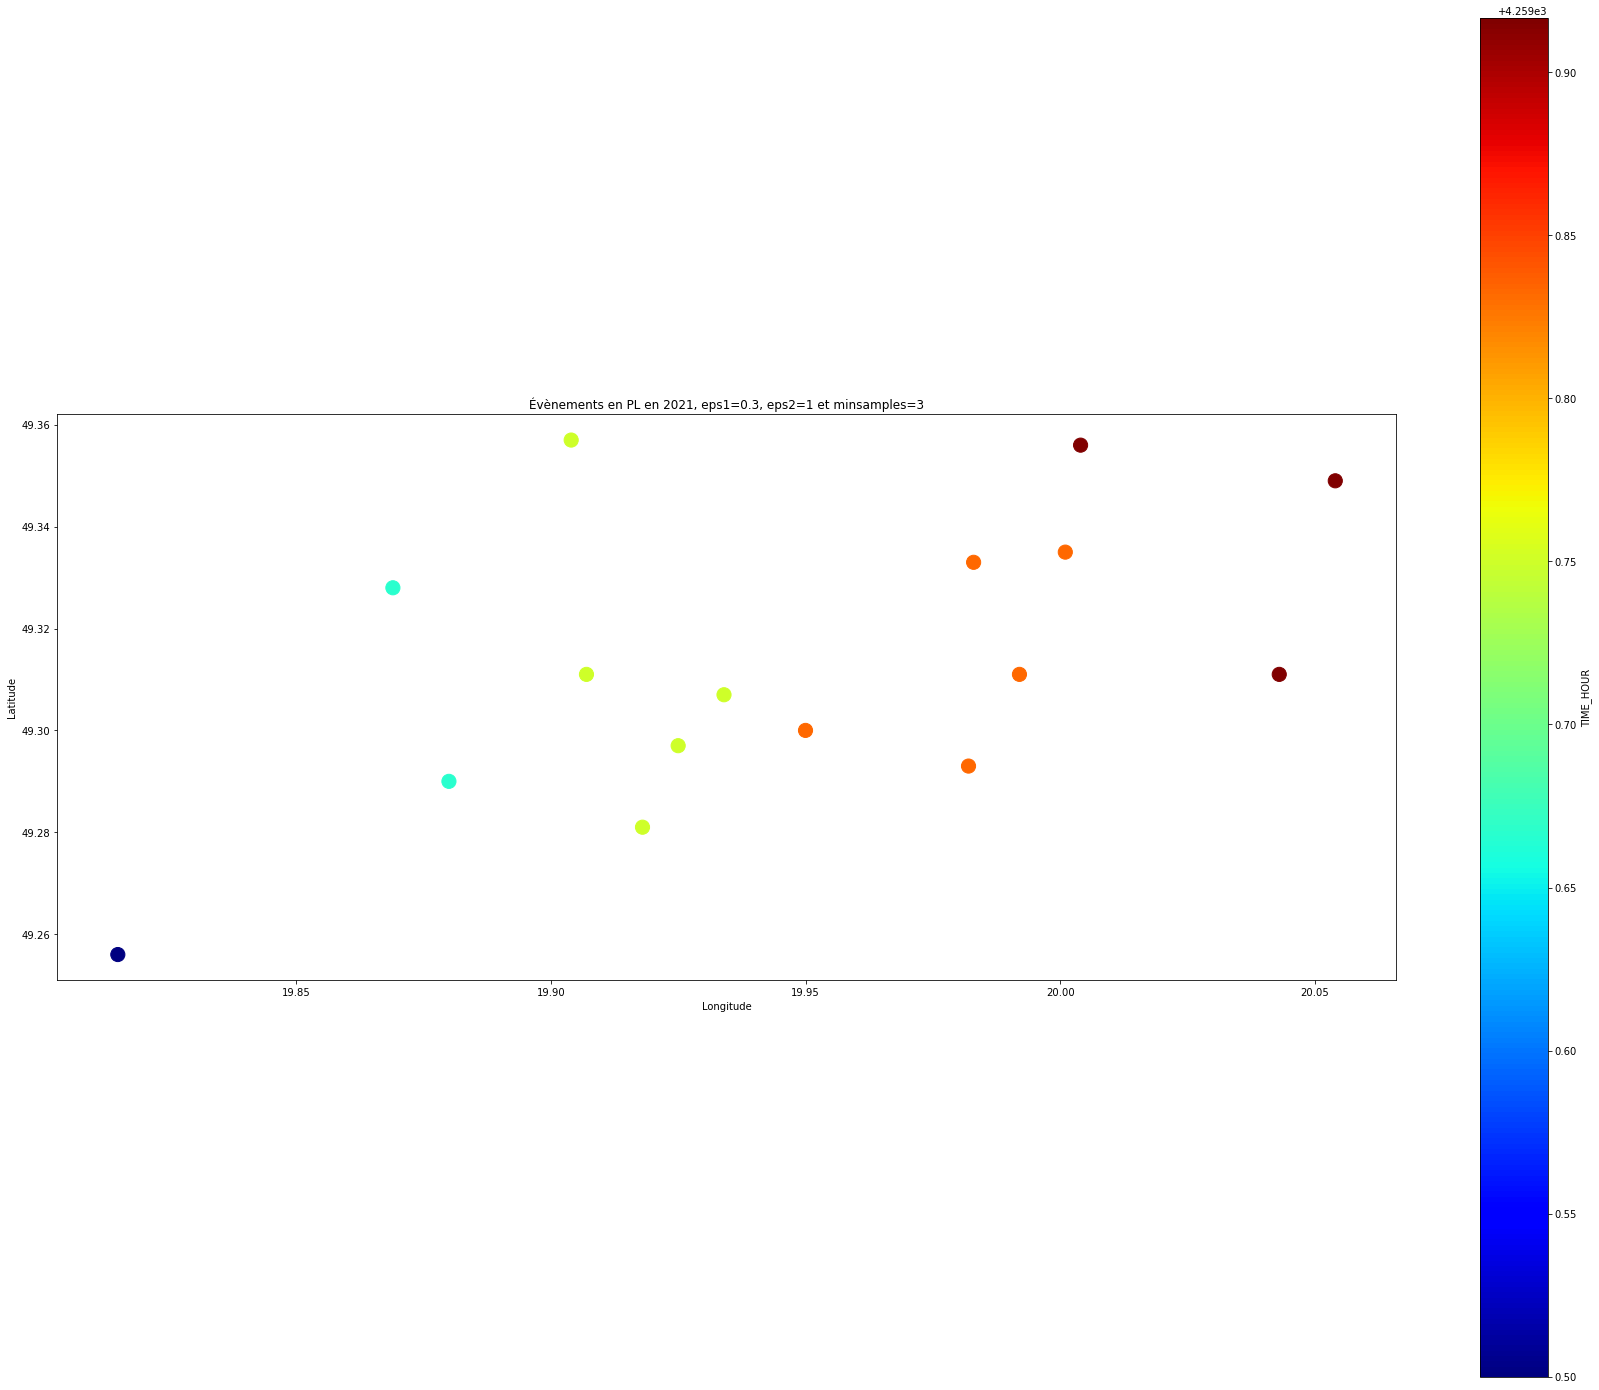

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
0              14        14         14       14
6              14        14         14       14


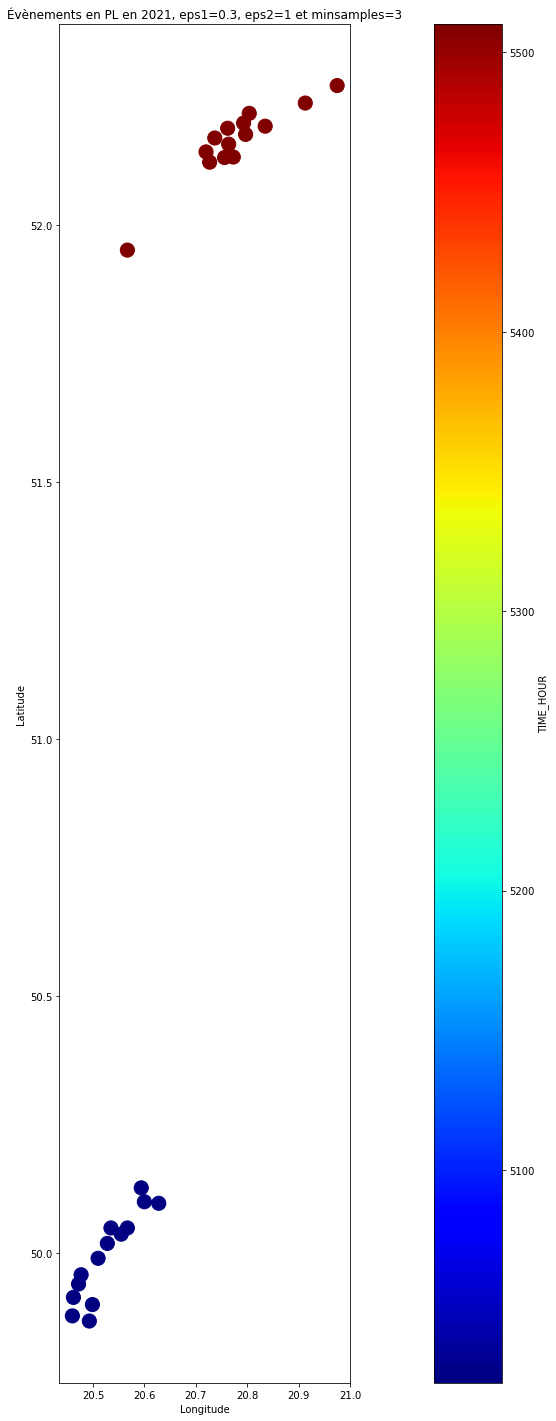

In [75]:
x='PL'
for i in range(10):
    clusterise_country_year_2(x, 2021, 0.3, 1, 3,i)